In [1]:
import sys, os, argparse, time, numpy as np, tensorflow as tf, pandas as pd
"""
Do the following if using colab
1. Download this notebook and upload to colab as your entry point
2. Uncomment the code below
"""
#!git clone https://github.com/Temiloluwa/leo_segmentation.git --branch leo_maml_tensorflow
#os.chdir(os.path.join("./leo_segmentation")) 
from leo_segmentation.data import Datagenerator, TrainingStats
from leo_segmentation.model import LEO, load_model, save_model
from leo_segmentation.utils import load_config, check_experiment, get_named_dict, \
                        log_data, load_yaml, train_logger, val_logger, print_to_string_io, \
                        save_pickled_data, model_dir, list_to_tensor
from leo_segmentation.run import train_model
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Train Model

In [2]:
dataset ="fss1000"
config = load_config()
leo = train_model(config, dataset)

num tasks: 5
tr_imgs shape: (5, 2, 224, 224, 3),tr_masks shape: (5, 2, 224, 224), val_imgs shape: (5, 5, 224, 224, 3), val_masks shape: (5, 5, 224, 224)
num tasks: 5
tr_imgs shape: (5, 2, 224, 224, 3),tr_masks shape: (5, 2, 224, 224), val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 12.30it/s]
8it [00:00, 13.28it/s]
8it [00:00, 19.05it/s]
8it [00:00, 14.85it/s]
8it [00:00, 18.92it/s]


mode:meta_val, episode:001, kl_loss:0.000000, total_val_loss:0.642970 
val_mean_iou:{'episode': 1,
'phonograph': 0.17536532308358016,
'plaice': 0.1715363151191579,
'sandbar': 0.10603432240395422,
'shower_curtain': 0.2221274767002105,
'sombrero': 0.17038624160617188}



8it [00:00, 19.68it/s]
28it [00:01, 15.11it/s]
8it [00:00, 17.59it/s]
8it [00:00, 19.91it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:002, kl_loss:0.000000, total_val_loss:0.560804 
val_mean_iou:{'episode': 2,
'panda': 0.02921194369383617,
'pepitas': 0.06748052797212051,
'polo_shirt': 0.013512296522498484,
'puma_logo': 0.035029880033538865,
'raven': 0.014830249455795303}



8it [00:00, 20.10it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.39it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:003, kl_loss:0.000000, total_val_loss:0.585789 
val_mean_iou:{'episode': 3,
'pill_bottle': 0.0011865847187677383,
'potted_plant': 0.00486403976146726,
'red_fox': 0.004457364217665133,
'roller_skate': 0.007627364079731038,
'screwdriver': 0.004883997703663073}



8it [00:00, 18.74it/s]
128it [00:06, 20.07it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:004, kl_loss:0.000000, total_val_loss:0.583349 
val_mean_iou:{'episode': 4,
'ox': 0.0002853646374152088,
'parachute': 0.0007176943172034626,
'recreational_vehicle': 0.0002164438738206315,
'redheart': 0.0019805615486717353,
'shumai': 0.0004342062349142427}



8it [00:00, 20.46it/s]
8it [00:00, 19.86it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.20it/s]
8it [00:00, 20.25it/s]


mode:meta_val, episode:005, kl_loss:0.000000, total_val_loss:0.689067 
val_mean_iou:{'episode': 5,
'pepitas': 0.0005419911015690191,
'photocopier': 0.00017952423141168587,
'pineapple': 0.0011480062260772652,
'pufferfish': 0.0006634424822956907,
'ski_mask': 0.00026712971466235936}



8it [00:00, 19.86it/s]
8it [00:00, 20.26it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.05it/s]
28it [00:01, 20.29it/s]


mode:meta_val, episode:006, kl_loss:0.000000, total_val_loss:0.493234 
val_mean_iou:{'episode': 6,
'panda': 0.0029753906017220303,
'partridge': 0.010023806224103567,
'perfume': 0.008540927913425748,
'roller_coaster': 0.0223284315730283,
'snowman': 0.00856364888115306}



8it [00:00, 19.81it/s]
8it [00:00, 21.11it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.38it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:007, kl_loss:0.000000, total_val_loss:0.613823 
val_mean_iou:{'episode': 7,
'pickup': 0.041681469573576366,
'pillow': 0.02647892018836804,
'pomelo': 0.0197059892104711,
'power_drill': 0.03980304743796896,
'roller_coaster': 0.09737909610157863}



8it [00:00, 20.00it/s]
8it [00:00, 20.05it/s]
8it [00:00, 20.41it/s]
18it [00:00, 20.10it/s]
8it [00:00, 19.14it/s]


mode:meta_val, episode:008, kl_loss:0.000000, total_val_loss:0.572243 
val_mean_iou:{'episode': 8,
'paper_crane': 0.08997064410884212,
'pingpong_racket': 0.07493103794156133,
'poached_egg': 0.057291910248270225,
'psp': 0.06209423586700445,
'quail_egg': 0.1679063541131538}



8it [00:00, 21.05it/s]
8it [00:00, 19.80it/s]
8it [00:00, 19.76it/s]
8it [00:00, 20.41it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:009, kl_loss:0.000000, total_val_loss:0.591692 
val_mean_iou:{'episode': 9,
'oyster': 0.07750753196460505,
'pickelhaube': 0.052084913573244046,
'potted_plant': 0.08455661207506977,
'printer': 0.016452715454870315,
'sarong': 0.09979468193763279}



8it [00:00, 20.89it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.16it/s]
18it [00:00, 20.01it/s]
8it [00:00, 20.41it/s]


mode:meta_val, episode:010, kl_loss:0.000000, total_val_loss:0.562611 
val_mean_iou:{'episode': 10,
'polar_bear': 0.005534222400176784,
'raccoon': 0.02471357778773056,
'ruffed_grouse': 0.045786644485573846,
'sealion': 0.009053666544209353,
'soap': 0.005652423316299902}



8it [00:00, 19.90it/s]
8it [00:00, 17.32it/s]
8it [00:00, 20.89it/s]
8it [00:00, 19.37it/s]
8it [00:00, 19.24it/s]


mode:meta_val, episode:011, kl_loss:0.000000, total_val_loss:0.651833 
val_mean_iou:{'episode': 11,
'pspgo': 0.005147302079457594,
'raccoon': 0.008459984415649723,
'red_wolf': 0.017781642815184698,
'rocking_chair': 0.013080500119868346,
'soap_dispenser': 0.0025961707637624054}



8it [00:00, 19.66it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:012, kl_loss:0.000000, total_val_loss:0.522361 
val_mean_iou:{'episode': 12,
'police_car': 0.005297374390505361,
'rabbit': 0.0013611061627889782,
'red_bayberry': 0.06523023863506486,
'rock_beauty': 0.004267155977958486,
'shuriken': 0.001508563874675502}



18it [00:00, 20.23it/s]
8it [00:00, 20.21it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.19it/s]
18it [00:00, 20.56it/s]


mode:meta_val, episode:013, kl_loss:0.000000, total_val_loss:0.580307 
val_mean_iou:{'episode': 13,
'papaya': 0.013555119103297653,
'pickup': 0.008821764037591431,
'rock_snake': 0.022540249216814738,
'sled': 0.029514723311889098,
'soap': 0.0016281686223613382}



8it [00:00, 20.26it/s]
8it [00:00, 18.83it/s]
8it [00:00, 19.71it/s]
8it [00:00, 20.55it/s]
18it [00:00, 19.92it/s]


mode:meta_val, episode:014, kl_loss:0.000000, total_val_loss:0.453629 
val_mean_iou:{'episode': 14,
'proboscis': 0.005715504109875145,
'quail': 0.0320691922898518,
'quill_pen': 0.0059058463561669425,
'samarra_mosque': 0.00253342470676946,
'snowplow': 0.02901227284382459}



8it [00:00, 20.00it/s]
8it [00:00, 19.81it/s]
28it [00:01, 20.01it/s]
18it [00:00, 20.17it/s]
18it [00:00, 19.85it/s]


mode:meta_val, episode:015, kl_loss:0.000000, total_val_loss:0.575978 
val_mean_iou:{'episode': 15,
'plastic_bag': 0.007635493422653021,
'potato': 0.00886257771776918,
'pumpkin': 0.009107381779054395,
'sandwich': 0.013816457047800585,
'seatbelt': 0.005836718923104506}



8it [00:00, 20.78it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.89it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:016, kl_loss:0.000000, total_val_loss:0.488886 
val_mean_iou:{'episode': 16,
'pingpong_ball': 0.01040587487110155,
'polar_bear': 0.0055424590969508965,
'raccoon': 0.03993782430604182,
'red_wolf': 0.08064705730068863,
'snowman': 0.059421261369538174}



8it [00:00, 19.42it/s]
8it [00:00, 20.04it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.10it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:017, kl_loss:0.000000, total_val_loss:0.684698 
val_mean_iou:{'episode': 17,
'park_bench': 0.03982007734763009,
'petri_dish': 0.017661641080016385,
'pingpong_racket': 0.04305492115360207,
'siamese_cat': 0.023402557211959978,
'sloth_bear': 0.01338352328611683}



8it [00:00, 20.09it/s]
88it [00:04, 19.95it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.05it/s]
8it [00:00, 19.61it/s]


mode:meta_val, episode:018, kl_loss:0.000000, total_val_loss:0.425385 
val_mean_iou:{'episode': 18,
'pen': 0.10192303203860166,
'platypus': 0.14823001573760936,
'recreational_vehicle': 0.12318863437864472,
'scroll_brush': 0.061418026988153004,
'snowmobile': 0.1963963054353487}



8it [00:00, 20.32it/s]
8it [00:00, 19.76it/s]
8it [00:00, 15.72it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.20it/s]


mode:meta_val, episode:019, kl_loss:0.000000, total_val_loss:0.493108 
val_mean_iou:{'episode': 19,
'persian_cat': 0.12645352375183133,
'ptarmigan': 0.22460113945576124,
'quail_egg': 0.4064649971953149,
'rice_cooker': 0.09588407161578343,
'schooner': 0.2248456500099233}



8it [00:00, 20.00it/s]
8it [00:00, 20.51it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.90it/s]


mode:meta_val, episode:020, kl_loss:0.000000, total_val_loss:0.414304 
val_mean_iou:{'episode': 20,
'ostrich': 0.12031984326815343,
'pokermon_ball': 0.10402894446510487,
'pubg_lvl3helmet': 0.017922335728194013,
'radio_telescope': 0.1534590846896491,
'snowball': 0.015690606372508683}



8it [00:00, 18.83it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.46it/s]
8it [00:00, 19.56it/s]
8it [00:00, 20.57it/s]


mode:meta_val, episode:021, kl_loss:0.000000, total_val_loss:0.423382 
val_mean_iou:{'episode': 21,
'polecat': 0.04453357164933854,
'ptarmigan': 0.10225335279127476,
'radio_telescope': 0.08595522194594228,
'ruler': 0.04026159498001587,
'sniper_rifle': 0.064831483594303}



8it [00:00, 20.41it/s]
8it [00:00, 19.95it/s]
8it [00:00, 20.94it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:022, kl_loss:0.000000, total_val_loss:0.431729 
val_mean_iou:{'episode': 22,
'persian_cat': 0.15336240690762043,
'quad_drone': 0.3412985332708258,
'ringlet_butterfly': 0.1961178070898939,
'rosehip': 0.316927926905472,
'sarong': 0.2922885099976551}



8it [00:00, 19.81it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.80it/s]
8it [00:00, 20.07it/s]
8it [00:00, 20.13it/s]


mode:meta_val, episode:023, kl_loss:0.000000, total_val_loss:0.483757 
val_mean_iou:{'episode': 23,
'pomelo': 0.22287225009339257,
'red_fox': 0.5232389621478002,
'scabbard': 0.27904594286176093,
'scarerow': 0.2678061514581583,
'shih-tzu': 0.4611751492231563}



8it [00:00, 19.14it/s]
38it [00:01, 19.88it/s]
8it [00:00, 20.26it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.62it/s]


mode:meta_val, episode:024, kl_loss:0.000000, total_val_loss:0.391332 
val_mean_iou:{'episode': 24,
'paper_crane': 0.2632636962937623,
'parthenon': 0.24895240670441152,
'pickelhaube': 0.2660678887897515,
'pomegranate': 0.40232420050905926,
'raft': 0.22871257160904632}



8it [00:00, 19.95it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.15it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:025, kl_loss:0.000000, total_val_loss:0.388066 
val_mean_iou:{'episode': 25,
'pencil_box': 0.2988212499494315,
'pyramid_cube': 0.370177142579599,
'raven': 0.3425423012229198,
'recreational_vehicle': 0.4430473310927205,
'rocking_chair': 0.3735774764379668}



8it [00:00, 18.11it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.83it/s]
8it [00:00, 20.62it/s]
8it [00:00, 20.46it/s]


mode:meta_val, episode:026, kl_loss:0.000000, total_val_loss:0.366976 
val_mean_iou:{'episode': 26,
'pickup': 0.5667600313691482,
'polo_shirt': 0.1430648726108283,
'quill_pen': 0.3226110123178426,
'rabbit': 0.26006720406368034,
'rosehip': 0.4678517355382752}



8it [00:00, 20.83it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.62it/s]
8it [00:00, 20.82it/s]
8it [00:00, 20.10it/s]


mode:meta_val, episode:027, kl_loss:0.000000, total_val_loss:0.347471 
val_mean_iou:{'episode': 27,
'pay_phone': 0.08061929095305906,
'pineapple': 0.07720328523603442,
'polar_bear': 0.031168875840625443,
'quill_pen': 0.027517448128997327,
'rocket': 0.10051463886473261}



8it [00:00, 20.05it/s]
8it [00:00, 18.87it/s]
8it [00:00, 20.62it/s]
28it [00:01, 20.61it/s]
8it [00:00, 18.03it/s]


mode:meta_val, episode:028, kl_loss:0.000000, total_val_loss:0.392171 
val_mean_iou:{'episode': 28,
'pool_table': 0.40832739079983277,
'potato': 0.5785848898078451,
'punching_bag': 0.31446787970874945,
'red_fox': 0.7445174939195727,
'reel': 0.6905508466247453}



8it [00:00, 19.95it/s]
8it [00:00, 19.51it/s]
8it [00:00, 20.26it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:029, kl_loss:0.000000, total_val_loss:0.428888 
val_mean_iou:{'episode': 29,
'papaya': 0.6358202323237829,
'porcupine': 0.5354914883970356,
'redshank': 0.2979007636149575,
'single_log': 0.22090003168905586,
'snail': 0.39431771818536165}



8it [00:00, 21.16it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.37it/s]
8it [00:00, 17.47it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:030, kl_loss:0.000000, total_val_loss:0.244482 
val_mean_iou:{'episode': 30,
'perfume': 0.5041726957496574,
'redheart': 0.15910689434461306,
'ruler': 0.140220200996954,
'sarong': 0.46343077428581125,
'snowball': 0.21611799161319223}



18it [00:00, 20.46it/s]
8it [00:00, 19.90it/s]
18it [00:00, 18.57it/s]
8it [00:00, 17.21it/s]
8it [00:00, 16.89it/s]


mode:meta_val, episode:031, kl_loss:0.000000, total_val_loss:0.405423 
val_mean_iou:{'episode': 31,
'potato_chips': 0.21446447049870704,
'sarong': 0.07603676108107861,
'sled': 0.17839611607073438,
'smoothing_iron': 0.09352221299294225,
'soap': 0.056430388313121096}



8it [00:00, 20.10it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.19it/s]
8it [00:00, 17.59it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:032, kl_loss:0.000000, total_val_loss:0.287730 
val_mean_iou:{'episode': 32,
'parachute': 0.6715444737017261,
'partridge': 0.6496694204097504,
'pepitas': 0.47565279414270617,
'perfume': 0.5348263953499843,
'soccer_ball': 0.3975997374430187}



18it [00:00, 19.16it/s]
8it [00:00, 18.11it/s]
8it [00:00, 17.83it/s]
18it [00:01, 17.92it/s]
8it [00:00, 18.44it/s]


mode:meta_val, episode:033, kl_loss:0.000000, total_val_loss:0.445449 
val_mean_iou:{'episode': 33,
'pinwheel': 0.3843036152314087,
'radio': 0.5867856971617929,
'relay_stick': 0.1638678232398035,
'seal': 0.6140444429428723,
'solar_dish': 0.5547338547306137}



8it [00:00, 20.31it/s]
8it [00:00, 18.40it/s]
8it [00:00, 20.31it/s]
8it [00:00, 18.27it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:034, kl_loss:0.000000, total_val_loss:0.365383 
val_mean_iou:{'episode': 34,
'parachute': 0.5497937088012868,
'pencil_box': 0.3881647141432595,
'peregine_falcon': 0.43423618354819626,
'pubg_lvl3helmet': 0.2604365913658495,
'radiator': 0.29000902389760946}



8it [00:00, 20.36it/s]
28it [00:01, 19.91it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.36it/s]


mode:meta_val, episode:035, kl_loss:0.000000, total_val_loss:0.340445 
val_mean_iou:{'episode': 35,
'pickup': 0.15202169922740744,
'pyramid': 0.05214196357446789,
'rabbit': 0.0975604806992624,
'scroll_brush': 0.0813380351323827,
'shopping_cart': 0.12018350329430452}



8it [00:00, 20.88it/s]
8it [00:00, 20.67it/s]
8it [00:00, 18.48it/s]
8it [00:00, 20.77it/s]
18it [00:00, 20.84it/s]


mode:meta_val, episode:036, kl_loss:0.000000, total_val_loss:0.452340 
val_mean_iou:{'episode': 36,
'platypus': 0.06501559754230986,
'rhinoceros': 0.059420552145276216,
'scabbard': 0.02931330390033881,
'shower_curtain': 0.00014417548236858553,
'soap': 0.05910177777369326}



8it [00:00, 20.73it/s]
8it [00:00, 19.91it/s]
8it [00:00, 19.76it/s]
8it [00:00, 21.33it/s]
8it [00:00, 20.67it/s]


mode:meta_val, episode:037, kl_loss:0.000000, total_val_loss:0.258387 
val_mean_iou:{'episode': 37,
'radio_telescope': 0.2927342972228242,
'rocking_chair': 0.27764456742480376,
'rubick_cube': 0.4848795791538923,
'sea_urchin': 0.2467373820814279,
'snail': 0.4770017396311804}



18it [00:00, 20.22it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.85it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.46it/s]


mode:meta_val, episode:038, kl_loss:0.000000, total_val_loss:0.335354 
val_mean_iou:{'episode': 38,
'pinecone': 0.6213642475427353,
'power_drill': 0.4301613293464839,
'roller_skate': 0.6248809077678589,
'screw': 0.4188786062001994,
'snow_leopard': 0.48524653405201945}



8it [00:00, 19.33it/s]
8it [00:00, 20.00it/s]
8it [00:00, 19.28it/s]
8it [00:00, 20.92it/s]
8it [00:00, 19.14it/s]


mode:meta_val, episode:039, kl_loss:0.000000, total_val_loss:0.347126 
val_mean_iou:{'episode': 39,
'persimmon': 0.5109031597325528,
'pizza': 0.62332695235697,
'redshank': 0.4361429228591934,
'sidewinder': 0.6081401691357851,
'sleeping_bag': 0.5142046235715}



8it [00:00, 20.94it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.46it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.52it/s]


mode:meta_val, episode:040, kl_loss:0.000000, total_val_loss:0.331989 
val_mean_iou:{'episode': 40,
'pomelo': 0.7025451066867008,
'pufferfish': 0.7104111098869537,
'santa_sledge': 0.6184244753929062,
'shumai': 0.5552412455936868,
'solar_dish': 0.5748909725850352}



8it [00:00, 21.11it/s]
8it [00:00, 20.52it/s]
8it [00:00, 19.96it/s]
8it [00:00, 20.78it/s]
8it [00:00, 20.57it/s]


mode:meta_val, episode:041, kl_loss:0.000000, total_val_loss:0.238918 
val_mean_iou:{'episode': 41,
'pheasant': 0.7369821132621746,
'pokermon_ball': 0.7532863413638445,
'sandwich_cookies': 0.5625891444045082,
'scabbard': 0.32117849559889433,
'sidewinder': 0.528492463515337}



8it [00:00, 21.45it/s]
8it [00:00, 19.19it/s]
8it [00:00, 20.01it/s]
8it [00:00, 19.17it/s]
8it [00:00, 20.10it/s]


mode:meta_val, episode:042, kl_loss:0.000000, total_val_loss:0.261123 
val_mean_iou:{'episode': 42,
'paddle': 0.48634570567185015,
'papaya': 0.7633763111509523,
'redshank': 0.6279454943516891,
'revolver': 0.5493548877183008,
'sidewinder': 0.4836947949566006}



8it [00:00, 20.57it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.51it/s]
8it [00:00, 21.05it/s]
8it [00:00, 20.15it/s]


mode:meta_val, episode:043, kl_loss:0.000000, total_val_loss:0.257269 
val_mean_iou:{'episode': 43,
'peacock': 0.4799543687171903,
'pinwheel': 0.6461976324450714,
'pubg_lvl3helmet': 0.34597153333021124,
'skunk': 0.666869677747236,
'sniper_rifle': 0.4540464251954643}



8it [00:00, 20.05it/s]
8it [00:00, 20.57it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.71it/s]
8it [00:00, 21.02it/s]


mode:meta_val, episode:044, kl_loss:0.000000, total_val_loss:0.333445 
val_mean_iou:{'episode': 44,
'pidan': 0.57126286914537,
'ruddy_turnstone': 0.6252222847684215,
'sarong': 0.4974815152327347,
'shower_cap': 0.2937773458404499,
'skua': 0.6100325897608502}



8it [00:00, 20.31it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.52it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.67it/s]


mode:meta_val, episode:045, kl_loss:0.000000, total_val_loss:0.341957 
val_mean_iou:{'episode': 45,
'paper_towel': 0.32636094297977203,
'pepitas': 0.45895535168065094,
'petri_dish': 0.8767047188594804,
'pubg_lvl3backpack': 0.5561406709912244,
'snail': 0.6224988200265036}



8it [00:00, 20.36it/s]
8it [00:00, 20.36it/s]
8it [00:00, 18.03it/s]
8it [00:00, 20.20it/s]
8it [00:00, 20.34it/s]


mode:meta_val, episode:046, kl_loss:0.000000, total_val_loss:0.331442 
val_mean_iou:{'episode': 46,
'oyster': 0.6593254836252271,
'pistachio': 0.6890933073475659,
'projector': 0.5498030885644414,
'punching_bag': 0.32426726448254595,
'sleeping_bag': 0.2903250448637345}



8it [00:00, 18.70it/s]
8it [00:00, 20.57it/s]
8it [00:00, 19.56it/s]
8it [00:00, 21.05it/s]
8it [00:00, 20.36it/s]


mode:meta_val, episode:047, kl_loss:0.000000, total_val_loss:0.207319 
val_mean_iou:{'episode': 47,
'pencil_sharpener1': 0.3355846314891062,
'redshank': 0.4140928247253607,
'revolver': 0.28881936010745346,
'ringlet_butterfly': 0.32191463684746147,
'snail': 0.4511061316637428}



18it [00:00, 18.43it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.90it/s]
18it [00:00, 21.18it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:048, kl_loss:0.000000, total_val_loss:0.255469 
val_mean_iou:{'episode': 48,
'parking_meter': 0.378887129669244,
'pubg_lvl3backpack': 0.15919172989130445,
'roller_skate': 0.41702159710852293,
'screw': 0.36011904923243154,
'seal': 0.2538213517068082}



8it [00:00, 20.95it/s]
8it [00:00, 20.77it/s]
8it [00:00, 21.01it/s]
8it [00:00, 20.00it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:049, kl_loss:0.000000, total_val_loss:0.145857 
val_mean_iou:{'episode': 49,
'partridge': 0.6800321404507128,
'rocket': 0.32220611336402916,
'seagull': 0.6136102404093831,
'siamang': 0.5035496348484692,
'snowball': 0.3201473783466621}



8it [00:00, 20.36it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.52it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.83it/s]


mode:meta_val, episode:050, kl_loss:0.000000, total_val_loss:0.241655 
val_mean_iou:{'episode': 50,
'panpipe': 0.6164007060016765,
'papaya': 0.7874515975217484,
'ptarmigan': 0.7098904881897228,
'snail': 0.7504929057442262,
'snowman': 0.544887571801719}



8it [00:00, 20.68it/s]
8it [00:00, 20.06it/s]
8it [00:00, 19.24it/s]
8it [00:00, 18.96it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:051, kl_loss:0.000000, total_val_loss:0.330950 
val_mean_iou:{'episode': 51,
'patas': 0.6929806887403522,
'piano_keyboard': 0.4714414222443254,
'potato_chips': 0.6102096909467163,
'prairie_chicken': 0.7848834388605981,
'sewing_machine': 0.5053552882429873}



8it [00:00, 20.15it/s]
88it [00:04, 20.73it/s]
8it [00:00, 21.11it/s]
8it [00:00, 20.15it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:052, kl_loss:0.000000, total_val_loss:0.201255 
val_mean_iou:{'episode': 52,
'paper_plane': 0.41517263853301867,
'pen': 0.5887880052668234,
'poached_egg': 0.6083588036968215,
'quad_drone': 0.5904969273773977,
'snail': 0.7345968236532018}



8it [00:00, 20.78it/s]
8it [00:00, 19.72it/s]
8it [00:00, 20.46it/s]
18it [00:00, 20.50it/s]
18it [00:00, 19.75it/s]


mode:meta_val, episode:053, kl_loss:0.000000, total_val_loss:0.279015 
val_mean_iou:{'episode': 53,
'pear': 0.6666721180369467,
'poker': 0.5442150374220402,
'saluki': 0.6679025128798854,
'screw': 0.6056939555885674,
'single_log': 0.02144819270030426}



8it [00:00, 18.96it/s]
8it [00:00, 19.76it/s]
28it [00:01, 20.37it/s]
8it [00:00, 19.90it/s]
8it [00:00, 19.81it/s]


mode:meta_val, episode:054, kl_loss:0.000000, total_val_loss:0.242917 
val_mean_iou:{'episode': 54,
'panda': 0.6418270065519417,
'pspgo': 0.6395294301949109,
'ptarmigan': 0.7075396148865036,
'pubg_airdrop': 0.6881548050690192,
'ringlet_butterfly': 0.7994332470271983}



8it [00:00, 20.57it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.94it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.56it/s]


mode:meta_val, episode:055, kl_loss:0.000000, total_val_loss:0.302532 
val_mean_iou:{'episode': 55,
'red_bayberry': 0.6651846068152522,
'refrigerator': 0.34379492379966053,
'rosehip': 0.46437373931741077,
'shuriken': 0.4560069026614393,
'siamese_cat': 0.7193678379000987}



18it [00:00, 20.25it/s]
18it [00:00, 20.49it/s]
8it [00:00, 17.48it/s]
8it [00:00, 17.67it/s]
88it [00:04, 20.09it/s]


mode:meta_val, episode:056, kl_loss:0.000000, total_val_loss:0.258350 
val_mean_iou:{'episode': 56,
'pear': 0.5826730932867973,
'pen': 0.5972288842043926,
'razor': 0.541109099570787,
'sandwich': 0.653890189250066,
'santa_sledge': 0.5552821670468869}



8it [00:00, 19.90it/s]
8it [00:00, 21.00it/s]
18it [00:00, 20.21it/s]
8it [00:00, 20.31it/s]
8it [00:00, 21.28it/s]


mode:meta_val, episode:057, kl_loss:0.000000, total_val_loss:0.219841 
val_mean_iou:{'episode': 57,
'panpipe': 0.4822955396554411,
'polar_bear': 0.6935511309043605,
'proboscis': 0.7335469322763253,
'radio_telescope': 0.6688424467923414,
'seal': 0.7074467369531605}



8it [00:00, 21.00it/s]
8it [00:00, 20.62it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.57it/s]
18it [00:00, 20.39it/s]


mode:meta_val, episode:058, kl_loss:0.000000, total_val_loss:0.211174 
val_mean_iou:{'episode': 58,
'paper_crane': 0.27952913115023637,
'raccoon': 0.6799621784730987,
'redshank': 0.6546165863077092,
'roller_coaster': 0.4507673873793754,
'sled': 0.4601098973106712}



18it [00:00, 20.57it/s]
8it [00:00, 20.46it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.37it/s]
8it [00:00, 19.57it/s]


mode:meta_val, episode:059, kl_loss:0.000000, total_val_loss:0.265556 
val_mean_iou:{'episode': 59,
'pingpong_ball': 0.13199611800892025,
'quail': 0.7291156346063359,
'saxophone': 0.6324301623666455,
'scabbard': 0.3295594195303033,
'snowman': 0.5937162007735733}



8it [00:00, 19.81it/s]
38it [00:01, 20.15it/s]
8it [00:00, 20.10it/s]
8it [00:00, 20.73it/s]
8it [00:00, 20.10it/s]


mode:meta_val, episode:060, kl_loss:0.000000, total_val_loss:0.186142 
val_mean_iou:{'episode': 60,
'potted_plant': 0.6337417599262058,
'raccoon': 0.7905207064822081,
'raft': 0.6979992918002665,
'scorpion': 0.6524446201049916,
'siamang': 0.7095749008420762}



8it [00:00, 20.51it/s]
8it [00:00, 19.38it/s]
8it [00:00, 21.00it/s]
8it [00:00, 20.73it/s]
8it [00:00, 18.65it/s]


mode:meta_val, episode:061, kl_loss:0.000000, total_val_loss:0.227772 
val_mean_iou:{'episode': 61,
'ostrich': 0.6442754715050718,
'projector': 0.5456363452103459,
'rock_snake': 0.7064167593472797,
'santa_sledge': 0.5965576104642252,
'siamang': 0.7338496483132074}



8it [00:00, 19.90it/s]
8it [00:00, 19.95it/s]
8it [00:00, 20.46it/s]
8it [00:00, 20.41it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:062, kl_loss:0.000000, total_val_loss:0.239067 
val_mean_iou:{'episode': 62,
'polo_shirt': 0.5353429088697502,
'remote_control': 0.7557096714453058,
'rubber_eraser': 0.7832933393043477,
'sleeping_bag': 0.6313848864580823,
'sloth_bear': 0.7717582845000229}



8it [00:00, 20.67it/s]
8it [00:00, 19.19it/s]
8it [00:00, 20.26it/s]
8it [00:00, 21.33it/s]
18it [00:00, 19.43it/s]


mode:meta_val, episode:063, kl_loss:0.000000, total_val_loss:0.341053 
val_mean_iou:{'episode': 63,
'paper_towel': 0.26760920530792875,
'pizza': 0.8260627143373738,
'poker': 0.5989081716667486,
'pufferfish': 0.7650231954542166,
'rock_beauty': 0.6760918981964428}



8it [00:00, 20.57it/s]
8it [00:00, 20.94it/s]
18it [00:00, 20.38it/s]
8it [00:00, 20.40it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:064, kl_loss:0.000000, total_val_loss:0.197874 
val_mean_iou:{'episode': 64,
'pineapple': 0.5907450541787944,
'ptarmigan': 0.6847458477330866,
'pumpkin': 0.7349083497151718,
'recreational_vehicle': 0.8306638083555391,
'skull': 0.8167072375348103}



8it [00:00, 20.46it/s]
8it [00:00, 20.52it/s]
8it [00:00, 19.80it/s]
8it [00:00, 20.78it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:065, kl_loss:0.000000, total_val_loss:0.268447 
val_mean_iou:{'episode': 65,
'paper_crane': 0.6050674249374342,
'patas': 0.7014352065221308,
'piano_keyboard': 0.543021541802333,
'ringlet_butterfly': 0.7878880821413605,
'shotgun': 0.44993239728177614}



8it [00:00, 20.05it/s]
58it [00:02, 19.78it/s]
8it [00:00, 20.88it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:066, kl_loss:0.000000, total_val_loss:0.299920 
val_mean_iou:{'episode': 66,
'piano_keyboard': 0.5343940025460815,
'poached_egg': 0.5762218296712915,
'red_wolf': 0.7269108299674409,
'rhinoceros': 0.7933187625984475,
'snake': 0.6470860219942052}



8it [00:00, 19.90it/s]
8it [00:00, 20.49it/s]
8it [00:00, 20.60it/s]
8it [00:00, 19.76it/s]
18it [00:00, 20.45it/s]


mode:meta_val, episode:067, kl_loss:0.000000, total_val_loss:0.250368 
val_mean_iou:{'episode': 67,
'oyster': 0.782013104414842,
'parthenon': 0.781943106164229,
'pencil_box': 0.7094797506483393,
'pumpkin': 0.7247443124639044,
'sniper_rifle': 0.5716234077143788}



8it [00:00, 19.56it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.26it/s]
8it [00:00, 20.46it/s]


mode:meta_val, episode:068, kl_loss:0.000000, total_val_loss:0.202549 
val_mean_iou:{'episode': 68,
'paint_brush': 0.715576463864912,
'potted_plant': 0.5824639979038878,
'pspgo': 0.902997512769371,
'saluki': 0.6647614982756918,
'sea_urchin': 0.6716634339916113}



8it [00:00, 20.62it/s]
8it [00:00, 21.00it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.88it/s]


mode:meta_val, episode:069, kl_loss:0.000000, total_val_loss:0.141540 
val_mean_iou:{'episode': 69,
'partridge': 0.7528918236099744,
'pheasant': 0.7864419786123111,
'phonograph': 0.7453609869955767,
'pomegranate': 0.8039629700466335,
'rabbit': 0.7446902379626418}



8it [00:00, 21.00it/s]
8it [00:00, 20.78it/s]
18it [00:00, 19.41it/s]
88it [00:04, 20.53it/s]
8it [00:00, 17.67it/s]


mode:meta_val, episode:070, kl_loss:0.000000, total_val_loss:0.230368 
val_mean_iou:{'episode': 70,
'paper_plane': 0.30678979793558736,
'pen': 0.48549193302933596,
'pig': 0.7020581759864257,
'radiator': 0.33917007579069663,
'samarra_mosque': 0.5695123727357015}



18it [00:00, 20.63it/s]
8it [00:00, 20.83it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.04it/s]
8it [00:00, 20.41it/s]


mode:meta_val, episode:071, kl_loss:0.000000, total_val_loss:0.192076 
val_mean_iou:{'episode': 71,
'partridge': 0.7251900622388356,
'razor': 0.49954397984422894,
'recreational_vehicle': 0.8349512449985588,
'rosehip': 0.5856370226911787,
'sleeping_bag': 0.6747735832173212}



8it [00:00, 20.05it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.88it/s]


mode:meta_val, episode:072, kl_loss:0.000000, total_val_loss:0.182276 
val_mean_iou:{'episode': 72,
'paper_crane': 0.6235875371946799,
'parthenon': 0.825154952637285,
'pickup': 0.842435495226687,
'roller_skate': 0.8361146010381137,
'sealion': 0.8092930570858932}



8it [00:00, 20.65it/s]
18it [00:00, 20.56it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.67it/s]
8it [00:00, 19.23it/s]


mode:meta_val, episode:073, kl_loss:0.000000, total_val_loss:0.257837 
val_mean_iou:{'episode': 73,
'pteropus': 0.8080487800888698,
'pubg_airdrop': 0.7037356436001195,
'pumpkin': 0.7804946492093372,
'sealion': 0.7904870214204631,
'shift_gear': 0.18578306830153402}



8it [00:00, 20.89it/s]
8it [00:00, 20.26it/s]
8it [00:00, 19.76it/s]
8it [00:00, 20.73it/s]
38it [00:01, 20.06it/s]


mode:meta_val, episode:074, kl_loss:0.000000, total_val_loss:0.244058 
val_mean_iou:{'episode': 74,
'pubg_lvl3backpack': 0.4504155280711426,
'raft': 0.37693396009972996,
'rocking_chair': 0.40443832747542097,
'ruler': 0.2599012245982395,
'snow_leopard': 0.5355535369384377}



8it [00:00, 18.61it/s]
8it [00:00, 19.51it/s]
8it [00:00, 14.67it/s]
8it [00:00, 19.38it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:075, kl_loss:0.000000, total_val_loss:0.332102 
val_mean_iou:{'episode': 75,
'pencil_sharpener2': 0.5203215089595586,
'pizza': 0.733590466145315,
'projector': 0.5086168051695451,
'pspgo': 0.5512043876483474,
'sloth_bear': 0.559043131747072}



8it [00:00, 19.90it/s]
8it [00:00, 20.21it/s]
8it [00:00, 11.46it/s]
8it [00:02,  3.93it/s]
8it [00:00, 18.32it/s]


mode:meta_val, episode:076, kl_loss:0.000000, total_val_loss:0.269310 
val_mean_iou:{'episode': 76,
'red_bayberry': 0.7338369985128563,
'refrigerator': 0.3775787223477052,
'rocking_chair': 0.5993119219618279,
'sandal': 0.6657323703880913,
'soccer_ball': 0.562783877023624}



8it [00:00, 15.98it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.55it/s]
8it [00:00, 14.86it/s]
8it [00:00, 18.31it/s]


mode:meta_val, episode:077, kl_loss:0.000000, total_val_loss:0.205630 
val_mean_iou:{'episode': 77,
'ostrich': 0.6691532601126743,
'pizza': 0.7373108595890225,
'pyramid_cube': 0.8331780428924991,
'rubick_cube': 0.8180616667368052,
'sock': 0.6051070492619665}



8it [00:00, 12.15it/s]
88it [00:05, 17.00it/s]
8it [00:00, 19.61it/s]
8it [00:00, 20.00it/s]
8it [00:00, 17.67it/s]


mode:meta_val, episode:078, kl_loss:0.000000, total_val_loss:0.184210 
val_mean_iou:{'episode': 78,
'paper_plane': 0.48028553607909047,
'pear': 0.709918980957273,
'pen': 0.6023648228176325,
'pokermon_ball': 0.734147199799611,
'polecat': 0.7362143663219756}



8it [00:00, 18.36it/s]
8it [00:00, 17.87it/s]
8it [00:00, 15.43it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.51it/s]


mode:meta_val, episode:079, kl_loss:0.000000, total_val_loss:0.198901 
val_mean_iou:{'episode': 79,
'otter': 0.789629330297396,
'paper_plane': 0.30050987076303026,
'polar_bear': 0.7460725903744276,
'police_car': 0.7833595938318724,
'punching_bag': 0.5016181404812682}



8it [00:00, 18.11it/s]
8it [00:00, 18.65it/s]
8it [00:00, 16.47it/s]
8it [00:00, 18.03it/s]
18it [00:01, 17.59it/s]


mode:meta_val, episode:080, kl_loss:0.000000, total_val_loss:0.186285 
val_mean_iou:{'episode': 80,
'pencil_sharpener1': 0.6138030159385232,
'pubg_lvl3backpack': 0.46263421203482524,
'radio_telescope': 0.6370452571700201,
'saltshaker': 0.6569066202549334,
'sled': 0.5050312006990751}



8it [00:00, 11.69it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.61it/s]
8it [00:00, 18.15it/s]


mode:meta_val, episode:081, kl_loss:0.000000, total_val_loss:0.270683 
val_mean_iou:{'episode': 81,
'pencil_box': 0.6382218654886402,
'pizza': 0.8303642805685243,
'proboscis': 0.7058283973064748,
'snow_leopard': 0.6347555454885191,
'solar_dish': 0.509643734559482}



8it [00:00, 19.66it/s]
8it [00:00, 20.77it/s]
8it [00:00, 20.52it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.95it/s]


mode:meta_val, episode:082, kl_loss:0.000000, total_val_loss:0.178708 
val_mean_iou:{'episode': 82,
'paint_brush': 0.7775274553029285,
'pepitas': 0.716800591673678,
'perfume': 0.6514310137844506,
'pickup': 0.8227520872455087,
'reflex_camera': 0.7643773846395172}



8it [00:00, 20.62it/s]
8it [00:00, 20.10it/s]
8it [00:00, 20.10it/s]
8it [00:00, 20.52it/s]
8it [00:00, 20.20it/s]


mode:meta_val, episode:083, kl_loss:0.000000, total_val_loss:0.202002 
val_mean_iou:{'episode': 83,
'oyster': 0.759500621634841,
'pencil_sharpener1': 0.7155669888923932,
'scissors': 0.5484821605544339,
'shih-tzu': 0.8489277284038197,
'snowplow': 0.7448499962546475}



8it [00:00, 17.90it/s]
18it [00:00, 18.05it/s]
8it [00:00, 19.10it/s]
8it [00:00, 20.15it/s]
8it [00:00, 16.75it/s]


mode:meta_val, episode:084, kl_loss:0.000000, total_val_loss:0.165951 
val_mean_iou:{'episode': 84,
'pill_bottle': 0.7650018348004574,
'potato_chips': 0.7419730422581551,
'pubg_lvl3backpack': 0.6014286289443407,
'scroll_brush': 0.6562232667943977,
'sled': 0.6227397872124558}



8it [00:00, 16.75it/s]
8it [00:00, 16.95it/s]
8it [00:00, 15.88it/s]
8it [00:00, 18.53it/s]
8it [00:00, 18.35it/s]


mode:meta_val, episode:085, kl_loss:0.000000, total_val_loss:0.292578 
val_mean_iou:{'episode': 85,
'otter': 0.7730717226499972,
'pillow': 0.37338552912873013,
'potato_chips': 0.5729328027908948,
'pubg_airdrop': 0.6583602587726536,
'shower_cap': 0.47916442183293306}



8it [00:00, 20.73it/s]
88it [00:04, 20.47it/s]
8it [00:00, 19.95it/s]
18it [00:00, 19.92it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:086, kl_loss:0.000000, total_val_loss:0.229026 
val_mean_iou:{'episode': 86,
'paddle': 0.6181854876265732,
'pen': 0.4290959940651764,
'prairie_chicken': 0.7576858989071091,
'psp': 0.612810691413954,
'remote_control': 0.6746379096657589}



28it [00:01, 19.71it/s]
8it [00:00, 18.83it/s]
18it [00:00, 18.97it/s]
8it [00:00, 17.10it/s]
8it [00:00, 16.04it/s]


mode:meta_val, episode:087, kl_loss:0.000000, total_val_loss:0.225077 
val_mean_iou:{'episode': 87,
'owl': 0.7421791888847977,
'peregine_falcon': 0.6817219493710068,
'police_car': 0.8462012441573163,
'radio': 0.784907417523546,
'sidewinder': 0.7491125231984905}



8it [00:00, 15.46it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.61it/s]
8it [00:00, 17.94it/s]
8it [00:00, 14.64it/s]


mode:meta_val, episode:088, kl_loss:0.000000, total_val_loss:0.244336 
val_mean_iou:{'episode': 88,
'platypus': 0.7312212583888876,
'pufferfish': 0.7895766176002329,
'quill_pen': 0.36964742253682037,
'schooner': 0.7123895537703084,
'sidewinder': 0.7127855823539142}



8it [00:00, 19.33it/s]
8it [00:00, 18.19it/s]
58it [00:03, 19.07it/s]
8it [00:00, 18.92it/s]
8it [00:00, 17.44it/s]


mode:meta_val, episode:089, kl_loss:0.000000, total_val_loss:0.234504 
val_mean_iou:{'episode': 89,
'parachute': 0.7477972343084187,
'pillow': 0.7139114390006348,
'plate': 0.8354190183931101,
'printer': 0.6952899394366168,
'snake': 0.6673725803068699}



8it [00:00, 20.62it/s]
8it [00:00, 19.90it/s]
8it [00:00, 16.75it/s]
8it [00:00, 17.63it/s]
8it [00:00, 17.63it/s]


mode:meta_val, episode:090, kl_loss:0.000000, total_val_loss:0.241393 
val_mean_iou:{'episode': 90,
'persian_cat': 0.7023369196208784,
'pomelo': 0.7101390057187171,
'recreational_vehicle': 0.6551894439313837,
'sealion': 0.6967208804682061,
'smoothing_iron': 0.5877095188244298}



8it [00:00, 19.42it/s]
8it [00:00, 17.82it/s]
8it [00:00, 19.80it/s]
18it [00:01, 17.62it/s]
8it [00:00, 18.11it/s]


mode:meta_val, episode:091, kl_loss:0.000000, total_val_loss:0.321682 
val_mean_iou:{'episode': 91,
'psp': 0.49885125528859703,
'rice_cooker': 0.573410765263306,
'rock_beauty': 0.6271841279137681,
'schooner': 0.3172233413016414,
'ski_mask': 0.5032919740832229}



8it [00:00, 20.78it/s]
8it [00:00, 20.57it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.51it/s]
8it [00:00, 20.10it/s]


mode:meta_val, episode:092, kl_loss:0.000000, total_val_loss:0.254262 
val_mean_iou:{'episode': 92,
'paper_towel': 0.3969379487600967,
'sandwich_cookies': 0.6542368469403474,
'scabbard': 0.20437023729609594,
'skunk': 0.7350550118048641,
'sniper_rifle': 0.31413723843064945}



88it [00:04, 20.50it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.31it/s]
8it [00:00, 20.73it/s]


mode:meta_val, episode:093, kl_loss:0.000000, total_val_loss:0.187564 
val_mean_iou:{'episode': 93,
'parking_meter': 0.729596667694141,
'peanut': 0.6437023356278759,
'pen': 0.6118688720064024,
'potted_plant': 0.5577903751247365,
'santa_sledge': 0.5908083112820164}



8it [00:00, 20.36it/s]
8it [00:00, 20.10it/s]
8it [00:00, 20.46it/s]
8it [00:00, 20.41it/s]
8it [00:00, 19.52it/s]


mode:meta_val, episode:094, kl_loss:0.000000, total_val_loss:0.199789 
val_mean_iou:{'episode': 94,
'platypus': 0.7414191864993261,
'police_car': 0.7920834176265517,
'power_drill': 0.6205678162206236,
'pteropus': 0.7710753085741558,
'pyramid_cube': 0.7981640950429468}



8it [00:00, 19.78it/s]
8it [00:00, 19.42it/s]
28it [00:01, 19.91it/s]
8it [00:00, 20.45it/s]
28it [00:01, 20.43it/s]


mode:meta_val, episode:095, kl_loss:0.000000, total_val_loss:0.245749 
val_mean_iou:{'episode': 95,
'owl': 0.7478246017714809,
'photocopier': 0.8019284659315443,
'polo_shirt': 0.5812171258148537,
'pyramid': 0.6209531457137955,
'red_fox': 0.7808545416944249}



18it [00:00, 20.21it/s]
8it [00:00, 19.95it/s]
8it [00:00, 20.62it/s]
18it [00:00, 20.77it/s]
8it [00:00, 20.41it/s]


mode:meta_val, episode:096, kl_loss:0.000000, total_val_loss:0.188730 
val_mean_iou:{'episode': 96,
'pingpong_racket': 0.7503742276488252,
'psp': 0.8525042513631288,
'rosehip': 0.688912952051312,
'screw': 0.6112536692333367,
'sea_urchin': 0.695326690678959}



8it [00:00, 20.46it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.26it/s]
8it [00:00, 17.36it/s]
8it [00:00, 19.05it/s]


mode:meta_val, episode:097, kl_loss:0.000000, total_val_loss:0.223439 
val_mean_iou:{'episode': 97,
'printer': 0.7177259004704772,
'quad_drone': 0.5041126752263149,
'school_bus': 0.8300274040819247,
'ski_mask': 0.48932551492150933,
'snail': 0.7658686294967076}



8it [00:00, 20.20it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.26it/s]
8it [00:00, 19.85it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:098, kl_loss:0.000000, total_val_loss:0.194224 
val_mean_iou:{'episode': 98,
'pencil_sharpener2': 0.7585929665038074,
'pidan': 0.6706053187004986,
'platypus': 0.7717312565790535,
'red_fox': 0.7898439016722757,
'snowplow': 0.738687082763164}



8it [00:00, 20.00it/s]
8it [00:00, 21.00it/s]
8it [00:00, 20.31it/s]
8it [00:00, 20.10it/s]
8it [00:00, 17.29it/s]


mode:meta_val, episode:099, kl_loss:0.000000, total_val_loss:0.335226 
val_mean_iou:{'episode': 99,
'pingpong_racket': 0.7003474671861926,
'proboscis': 0.7680202062373469,
'pspgo': 0.9170843917600513,
'redheart': 0.056280142303719326,
'shumai': 0.6398923741941361}



8it [00:00, 20.02it/s]
8it [00:00, 20.78it/s]
8it [00:00, 20.95it/s]
8it [00:00, 19.06it/s]
8it [00:00, 20.67it/s]


mode:meta_val, episode:100, kl_loss:0.000000, total_val_loss:0.228122 
val_mean_iou:{'episode': 100,
'projector': 0.6503799242483961,
'pubg_lvl3backpack': 0.6244391680494943,
'puma_logo': 0.19567034647506676,
'ruler': 0.7101911609777529,
'sniper_rifle': 0.5238542407603265}



8it [00:00, 20.31it/s]
8it [00:00, 20.62it/s]
8it [00:00, 20.94it/s]
8it [00:00, 20.05it/s]
8it [00:00, 20.51it/s]


mode:meta_val, episode:101, kl_loss:0.000000, total_val_loss:0.211214 
val_mean_iou:{'episode': 101,
'pistachio': 0.7731371280654731,
'pizza': 0.8429042755573484,
'rock_beauty': 0.6747537711599003,
'rock_snake': 0.6580741594827368,
'santa_sledge': 0.5761589879544}



8it [00:00, 19.81it/s]
8it [00:00, 20.38it/s]
8it [00:00, 21.07it/s]
8it [00:00, 19.47it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:102, kl_loss:0.000000, total_val_loss:0.268843 
val_mean_iou:{'episode': 102,
'papaya': 0.8420028802351587,
'pyramid_cube': 0.5418434906159684,
'refrigerator': 0.19250430552844444,
'samarra_mosque': 0.5418950753241638,
'sloth_bear': 0.7453371228799226}



8it [00:00, 20.25it/s]
8it [00:00, 20.78it/s]
8it [00:00, 20.84it/s]
8it [00:00, 19.52it/s]
8it [00:00, 20.73it/s]


mode:meta_val, episode:103, kl_loss:0.000000, total_val_loss:0.172300 
val_mean_iou:{'episode': 103,
'pepitas': 0.7014121626053633,
'police_car': 0.8186501519471403,
'prairie_chicken': 0.8223671107365997,
'ptarmigan': 0.783063746249788,
'punching_bag': 0.49595955881194187}



18it [00:00, 20.63it/s]
8it [00:00, 19.47it/s]
8it [00:00, 20.52it/s]
8it [00:00, 20.43it/s]
8it [00:00, 20.62it/s]


mode:meta_val, episode:104, kl_loss:0.000000, total_val_loss:0.162209 
val_mean_iou:{'episode': 104,
'ptarmigan': 0.6889328821185787,
'quail': 0.6957676812891105,
'samarra_mosque': 0.6009506248328657,
'shovel': 0.6301350938098886,
'siamang': 0.7632382421662711}



8it [00:00, 20.57it/s]
8it [00:00, 19.81it/s]
8it [00:00, 17.10it/s]
8it [00:00, 20.73it/s]
8it [00:00, 20.20it/s]


mode:meta_val, episode:105, kl_loss:0.000000, total_val_loss:0.187204 
val_mean_iou:{'episode': 105,
'pencil_sharpener1': 0.6978916328038502,
'persian_cat': 0.793017850836763,
'prayer_rug': 0.9137726763351381,
'rhinoceros': 0.7969610821327677,
'sarong': 0.5381214977369297}



8it [00:00, 20.57it/s]
8it [00:00, 20.73it/s]
8it [00:00, 19.84it/s]
8it [00:00, 20.73it/s]
8it [00:00, 20.57it/s]


mode:meta_val, episode:106, kl_loss:0.000000, total_val_loss:0.210092 
val_mean_iou:{'episode': 106,
'radiator': 0.5445557276311079,
'rhinoceros': 0.7925393428953444,
'ski_mask': 0.5535783062149497,
'skua': 0.7652978821079051,
'snowplow': 0.7314996765753907}



18it [00:00, 19.45it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.05it/s]
8it [00:00, 20.62it/s]
8it [00:00, 19.86it/s]


mode:meta_val, episode:107, kl_loss:0.000000, total_val_loss:0.220444 
val_mean_iou:{'episode': 107,
'polecat': 0.7456958769226077,
'rose': 0.7861399230847249,
'scorpion': 0.5308210530535615,
'sidewinder': 0.7166550270078356,
'sleeping_bag': 0.590125786834798}



8it [00:00, 19.24it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.16it/s]
8it [00:00, 20.52it/s]
18it [00:00, 20.39it/s]


mode:meta_val, episode:108, kl_loss:0.000000, total_val_loss:0.199134 
val_mean_iou:{'episode': 108,
'pencil_box': 0.652880109576556,
'quad_drone': 0.3763235595071428,
'quail': 0.7561881346347573,
'rugby_ball': 0.6748423748080055,
'sandbar': 0.10684318859391859}



8it [00:00, 20.26it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.83it/s]
8it [00:00, 20.10it/s]
8it [00:00, 19.91it/s]


mode:meta_val, episode:109, kl_loss:0.000000, total_val_loss:0.194574 
val_mean_iou:{'episode': 109,
'park_bench': 0.6230505772874131,
'pear': 0.679645388293346,
'pubg_airdrop': 0.643040145407354,
'sealion': 0.8110649080795134,
'sidewinder': 0.7428475471186342}



8it [00:00, 20.57it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.67it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:110, kl_loss:0.000000, total_val_loss:0.201126 
val_mean_iou:{'episode': 110,
'persian_cat': 0.7850300523570541,
'pyramid_cube': 0.7463038676303205,
'raven': 0.7433578764709587,
'shotgun': 0.5662338212488339,
'single_log': 0.3433107722156878}



128it [00:06, 20.36it/s]
8it [00:00, 20.83it/s]
8it [00:00, 19.95it/s]
18it [00:00, 20.30it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:111, kl_loss:0.000000, total_val_loss:0.201045 
val_mean_iou:{'episode': 111,
'ox': 0.7770909344982853,
'pufferfish': 0.8282231751748604,
'punching_bag': 0.44609269901101134,
'rugby_ball': 0.6487267207804824,
'sled': 0.6004836689795134}



8it [00:00, 20.89it/s]
8it [00:00, 20.31it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.89it/s]


mode:meta_val, episode:112, kl_loss:0.000000, total_val_loss:0.166674 
val_mean_iou:{'episode': 112,
'oyster': 0.781016965666822,
'partridge': 0.7131329066570475,
'pear': 0.7230473962666883,
'sidewinder': 0.74508355008173,
'snowball': 0.6193029628112052}



8it [00:00, 20.31it/s]
18it [00:00, 19.83it/s]
8it [00:00, 21.00it/s]
8it [00:00, 20.62it/s]
8it [00:00, 19.85it/s]


mode:meta_val, episode:113, kl_loss:0.000000, total_val_loss:0.154827 
val_mean_iou:{'episode': 113,
'persimmon': 0.7519034498005475,
'pig': 0.806882105817997,
'pufferfish': 0.8120838341164816,
'red_breasted_merganser': 0.6727999003430363,
'sealion': 0.8216048446556725}



8it [00:00, 20.67it/s]
8it [00:00, 20.15it/s]
8it [00:00, 19.10it/s]
8it [00:00, 18.61it/s]
8it [00:00, 19.23it/s]


mode:meta_val, episode:114, kl_loss:0.000000, total_val_loss:0.157972 
val_mean_iou:{'episode': 114,
'pear': 0.7139601358648918,
'red_breasted_merganser': 0.627590074648757,
'red_fox': 0.8068150462963497,
'shih-tzu': 0.8189574943936797,
'snowmobile': 0.38038249408276803}



8it [00:00, 20.41it/s]
8it [00:00, 20.21it/s]
8it [00:00, 19.81it/s]
8it [00:00, 21.00it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:115, kl_loss:0.000000, total_val_loss:0.197044 
val_mean_iou:{'episode': 115,
'printer': 0.6447611959701134,
'ptarmigan': 0.7493215994472809,
'revolver': 0.561520561578171,
'running_shoe': 0.5166708307011462,
'santa_sledge': 0.5867575325331155}



8it [00:00, 20.57it/s]
8it [00:00, 17.40it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.62it/s]
8it [00:00, 20.67it/s]


mode:meta_val, episode:116, kl_loss:0.000000, total_val_loss:0.322995 
val_mean_iou:{'episode': 116,
'phonograph': 0.7323106201701809,
'piano_keyboard': 0.4653830571810404,
'pidan': 0.7836387267462688,
'plastic_bag': 0.49291524475027704,
'sandwich_cookies': 0.6789906204079377}



8it [00:00, 19.43it/s]
8it [00:00, 20.20it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.16it/s]
88it [00:04, 20.63it/s]


mode:meta_val, episode:117, kl_loss:0.000000, total_val_loss:0.156613 
val_mean_iou:{'episode': 117,
'pen': 0.6375347679417692,
'potted_plant': 0.6154780079471975,
'ringlet_butterfly': 0.8247789272399617,
'rubick_cube': 0.8636791181876158,
'sleeping_bag': 0.7558463623618381}



8it [00:00, 19.95it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.41it/s]
28it [00:01, 20.37it/s]
8it [00:00, 20.89it/s]


mode:meta_val, episode:118, kl_loss:0.000000, total_val_loss:0.207099 
val_mean_iou:{'episode': 118,
'panda': 0.7418770641147269,
'plate': 0.8371007193608028,
'prairie_chicken': 0.8264718510387474,
'refrigerator': 0.6270317248245234,
'roller_coaster': 0.49685462273428205}



18it [00:00, 19.64it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.62it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.41it/s]


mode:meta_val, episode:119, kl_loss:0.000000, total_val_loss:0.210427 
val_mean_iou:{'episode': 119,
'pinwheel': 0.7286624503395387,
'polo_shirt': 0.4942044240995224,
'red_wolf': 0.7411151337973502,
'running_shoe': 0.5537771715710882,
'soap': 0.6498558413166545}



8it [00:00, 19.71it/s]
8it [00:00, 20.78it/s]
8it [00:00, 20.26it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:120, kl_loss:0.000000, total_val_loss:0.367127 
val_mean_iou:{'episode': 120,
'polo_shirt': 0.37489907048524707,
'rabbit': 0.6498511516570453,
'radiator': 0.5130718303810562,
'rugby_ball': 0.7220332044540976,
'shower_curtain': 0.35966912220173397}



8it [00:00, 19.61it/s]
8it [00:00, 19.28it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.73it/s]
8it [00:00, 20.36it/s]


mode:meta_val, episode:121, kl_loss:0.000000, total_val_loss:0.206046 
val_mean_iou:{'episode': 121,
'pill_bottle': 0.7842797164127855,
'polar_bear': 0.7858570864051182,
'pubg_airdrop': 0.690335873219089,
'seatbelt': 0.03767528063709145,
'sock': 0.6412492392758378}



8it [00:00, 20.15it/s]
8it [00:00, 20.21it/s]
8it [00:00, 20.78it/s]
8it [00:00, 20.46it/s]
18it [00:00, 20.51it/s]


mode:meta_val, episode:122, kl_loss:0.000000, total_val_loss:0.191938 
val_mean_iou:{'episode': 122,
'persimmon': 0.7590970462053008,
'pineapple': 0.5806976455444695,
'police_car': 0.8134331768738744,
'quail': 0.7493842201987586,
'screwdriver': 0.6837380287754933}



8it [00:00, 20.36it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.86it/s]
8it [00:00, 19.38it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:123, kl_loss:0.000000, total_val_loss:0.227230 
val_mean_iou:{'episode': 123,
'pickelhaube': 0.7722986564035563,
'pillow': 0.7385534106484545,
'printer': 0.7203588265203973,
'rock_beauty': 0.74783051650402,
'sidewinder': 0.7116287141843747}



8it [00:00, 19.42it/s]
8it [00:00, 20.21it/s]
8it [00:00, 19.96it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:124, kl_loss:0.000000, total_val_loss:0.195605 
val_mean_iou:{'episode': 124,
'panther': 0.7628987843981629,
'plate': 0.7708131176013712,
'rubber_eraser': 0.7489699419371605,
'sandbar': 0.08460853033148197,
'shakuhachi': 0.576402762782592}



8it [00:00, 20.41it/s]
8it [00:00, 20.15it/s]
8it [00:00, 19.15it/s]
8it [00:00, 19.15it/s]
8it [00:00, 19.81it/s]


mode:meta_val, episode:125, kl_loss:0.000000, total_val_loss:0.244546 
val_mean_iou:{'episode': 125,
'printer': 0.676799745241329,
'pubg_airdrop': 0.6768779101068257,
'rice_cooker': 0.6899867452997533,
'siamese_cat': 0.7440977871789003,
'sleeping_bag': 0.5200830386923158}



8it [00:00, 19.47it/s]
8it [00:00, 20.35it/s]
8it [00:00, 20.41it/s]
28it [00:01, 20.07it/s]
8it [00:00, 20.41it/s]


mode:meta_val, episode:126, kl_loss:0.000000, total_val_loss:0.202041 
val_mean_iou:{'episode': 126,
'pill_bottle': 0.7496702144704008,
'poached_egg': 0.6912347050632068,
'potato': 0.7419592115803555,
'printer': 0.6820257604639266,
'sea_urchin': 0.7131257413550879}



8it [00:00, 20.67it/s]
8it [00:00, 20.01it/s]
8it [00:00, 20.52it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.56it/s]


mode:meta_val, episode:127, kl_loss:0.000000, total_val_loss:0.198820 
val_mean_iou:{'episode': 127,
'ostrich': 0.7469250670866479,
'pencil_sharpener1': 0.7278096162858086,
'plaice': 0.8601955572190759,
'radiator': 0.5514057464769462,
'santa_sledge': 0.5448789958527666}



8it [00:00, 19.81it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.73it/s]
18it [00:00, 20.39it/s]


mode:meta_val, episode:128, kl_loss:0.000000, total_val_loss:0.312644 
val_mean_iou:{'episode': 128,
'pencil_sharpener2': 0.7785235043155869,
'rugby_ball': 0.612602557947276,
'seatbelt': 0.04714262884342874,
'shih-tzu': 0.8719188510334638,
'soap': 0.6188483056119737}



8it [00:00, 19.90it/s]
8it [00:00, 20.51it/s]
8it [00:00, 20.52it/s]
8it [00:00, 19.39it/s]
8it [00:00, 20.12it/s]


mode:meta_val, episode:129, kl_loss:0.000000, total_val_loss:0.180015 
val_mean_iou:{'episode': 129,
'parallel_bars': 0.2803323271404546,
'peanut': 0.7426606663671715,
'pencil_sharpener1': 0.7467267871787157,
'reel': 0.7343601312491123,
'shovel': 0.612075496534243}



8it [00:00, 20.57it/s]
8it [00:00, 18.27it/s]
8it [00:00, 20.26it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:130, kl_loss:0.000000, total_val_loss:0.168004 
val_mean_iou:{'episode': 130,
'puma_logo': 0.15504093707972727,
'revolver': 0.6518639588488111,
'rock_beauty': 0.7519460363185724,
'siamang': 0.7741927685414527,
'soap_dispenser': 0.7576920215022227}



8it [00:00, 19.51it/s]
8it [00:00, 20.10it/s]
8it [00:00, 20.52it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.90it/s]


mode:meta_val, episode:131, kl_loss:0.000000, total_val_loss:0.174294 
val_mean_iou:{'episode': 131,
'petri_dish': 0.7921233309596085,
'pineapple': 0.6077333697750841,
'polecat': 0.7907206593524905,
'reel': 0.8698389290299366,
'ruffed_grouse': 0.8224162573554283}



8it [00:00, 19.76it/s]
18it [00:00, 19.81it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.20it/s]
8it [00:00, 20.62it/s]


mode:meta_val, episode:132, kl_loss:0.000000, total_val_loss:0.188255 
val_mean_iou:{'episode': 132,
'pay_phone': 0.6295743789798895,
'pubg_airdrop': 0.6933036944761304,
'pubg_lvl3helmet': 0.5302068981651974,
'pumpkin': 0.8069465490378042,
'rain_barrel': 0.7023180978626988}



8it [00:00, 19.71it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.57it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.50it/s]


mode:meta_val, episode:133, kl_loss:0.000000, total_val_loss:0.269043 
val_mean_iou:{'episode': 133,
'phonograph': 0.768224726938736,
'piano_keyboard': 0.4870960687930971,
'pillow': 0.6850505835298579,
'pyraminx': 0.8272423481491404,
'rock_beauty': 0.7210108136020568}



8it [00:00, 20.83it/s]
8it [00:00, 19.71it/s]
8it [00:00, 20.46it/s]
8it [00:00, 20.41it/s]
18it [00:00, 20.07it/s]


mode:meta_val, episode:134, kl_loss:0.000000, total_val_loss:0.178160 
val_mean_iou:{'episode': 134,
'panpipe': 0.636418060629026,
'radiator': 0.5580850710581363,
'rose': 0.7753395462632143,
'sandal': 0.6050878370563245,
'skull': 0.8541815258899946}



8it [00:00, 20.57it/s]
8it [00:00, 19.14it/s]
8it [00:00, 20.46it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:135, kl_loss:0.000000, total_val_loss:0.247875 
val_mean_iou:{'episode': 135,
'paper_towel': 0.4274398722316126,
'pear': 0.7447292237944495,
'pepitas': 0.733197254780995,
'police_car': 0.7987654529185992,
'red_wolf': 0.7957542130184505}



8it [00:00, 20.48it/s]
8it [00:00, 19.52it/s]
8it [00:00, 20.74it/s]
8it [00:00, 20.41it/s]
28it [00:01, 19.79it/s]


mode:meta_val, episode:136, kl_loss:0.000000, total_val_loss:0.183602 
val_mean_iou:{'episode': 136,
'panda': 0.782600278650978,
'pistachio': 0.7085699440523352,
'rhinoceros': 0.8190827678952519,
'running_shoe': 0.5252990804044995,
'shopping_cart': 0.6747153753789916}



8it [00:00, 19.42it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.96it/s]
8it [00:00, 20.36it/s]
18it [00:00, 20.37it/s]


mode:meta_val, episode:137, kl_loss:0.000000, total_val_loss:0.241891 
val_mean_iou:{'episode': 137,
'pool_table': 0.5151893364078635,
'proboscis': 0.8029706565803675,
'recreational_vehicle': 0.808334742586696,
'red_breasted_merganser': 0.6999835767802702,
'sandwich': 0.7042311748192988}



8it [00:00, 20.36it/s]
8it [00:00, 19.81it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.05it/s]
8it [00:00, 19.90it/s]


mode:meta_val, episode:138, kl_loss:0.000000, total_val_loss:0.251027 
val_mean_iou:{'episode': 138,
'pomegranate': 0.7807134632777871,
'sandbar': 0.19993516252585372,
'school_bus': 0.750759631809357,
'snow_leopard': 0.7533161515771175,
'snowman': 0.5241002669420678}



8it [00:00, 20.00it/s]
8it [00:00, 19.10it/s]
8it [00:00, 20.67it/s]
8it [00:00, 20.52it/s]
8it [00:00, 19.96it/s]


mode:meta_val, episode:139, kl_loss:0.000000, total_val_loss:0.187236 
val_mean_iou:{'episode': 139,
'park_bench': 0.6204309550596199,
'pickup': 0.8642775013725774,
'pill_bottle': 0.8075360823558289,
'printer': 0.7284552187421005,
'single_log': 0.2804767363016718}



8it [00:00, 20.26it/s]
8it [00:00, 20.26it/s]
8it [00:00, 19.61it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.62it/s]


mode:meta_val, episode:140, kl_loss:0.000000, total_val_loss:0.222359 
val_mean_iou:{'episode': 140,
'poached_egg': 0.6201234803919317,
'power_drill': 0.6609529113986131,
'pubg_lvl3backpack': 0.6546960372854937,
'quail_egg': 0.7050401066211583,
'rabbit': 0.8457586780347972}



8it [00:00, 20.67it/s]
8it [00:00, 20.10it/s]
8it [00:00, 19.85it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.73it/s]


mode:meta_val, episode:141, kl_loss:0.000000, total_val_loss:0.236176 
val_mean_iou:{'episode': 141,
'peacock': 0.6867390643258561,
'rock_snake': 0.7031748073845798,
'sandbar': 0.26240196641715,
'skateboard': 0.24557545786824353,
'sniper_rifle': 0.5959619301310626}



8it [00:00, 19.47it/s]
8it [00:00, 20.00it/s]
8it [00:00, 19.71it/s]
8it [00:00, 20.07it/s]
8it [00:00, 20.72it/s]


mode:meta_val, episode:142, kl_loss:0.000000, total_val_loss:0.178830 
val_mean_iou:{'episode': 142,
'pizza': 0.8029841022914802,
'ringlet_butterfly': 0.9006150545332707,
'rock_beauty': 0.7127457483839629,
'snowball': 0.5801033402906326,
'sombrero': 0.6695585359507258}



8it [00:00, 20.51it/s]
8it [00:00, 20.51it/s]
8it [00:00, 20.31it/s]
8it [00:00, 20.00it/s]
8it [00:00, 20.83it/s]


mode:meta_val, episode:143, kl_loss:0.000000, total_val_loss:0.222884 
val_mean_iou:{'episode': 143,
'panther': 0.6685123135352984,
'parachute': 0.7906727342320947,
'pingpong_ball': 0.17622275540690716,
'potato_chips': 0.6055453131275788,
'sandwich_cookies': 0.6677920299848383}



8it [00:00, 19.80it/s]
8it [00:00, 20.20it/s]
18it [00:00, 19.81it/s]
8it [00:00, 20.41it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:144, kl_loss:0.000000, total_val_loss:0.210045 
val_mean_iou:{'episode': 144,
'patas': 0.7605398319861316,
'pretzel': 0.7078549102485157,
'psp': 0.8423416379714399,
'quail_egg': 0.8103923199451992,
'single_log': 0.2073805142344563}



38it [00:01, 20.25it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.95it/s]
18it [00:00, 20.30it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:145, kl_loss:0.000000, total_val_loss:0.172405 
val_mean_iou:{'episode': 145,
'perfume': 0.6738828117231588,
'pickelhaube': 0.7869300473363718,
'quail': 0.7422766750921121,
'raft': 0.7652716735149454,
'snowplow': 0.7869558885294687}



18it [00:00, 20.42it/s]
8it [00:00, 19.89it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.86it/s]
8it [00:00, 20.04it/s]


mode:meta_val, episode:146, kl_loss:0.000000, total_val_loss:0.179311 
val_mean_iou:{'episode': 146,
'pidan': 0.682719194757005,
'prayer_rug': 0.9022080035101778,
'red_fox': 0.7957807234275109,
'screw': 0.6256900383481017,
'sloth_bear': 0.8204793981063083}



8it [00:00, 18.83it/s]
88it [00:04, 20.44it/s]
8it [00:00, 20.57it/s]
8it [00:00, 20.26it/s]
8it [00:00, 19.96it/s]


mode:meta_val, episode:147, kl_loss:0.000000, total_val_loss:0.183011 
val_mean_iou:{'episode': 147,
'pen': 0.6687924159411314,
'pencil_sharpener2': 0.8185474134997719,
'pepitas': 0.695652070470711,
'prayer_rug': 0.8599436829767051,
'reflex_camera': 0.809920852422537}



18it [00:00, 20.23it/s]
8it [00:00, 20.62it/s]
8it [00:00, 19.68it/s]
8it [00:00, 20.02it/s]
18it [00:00, 20.44it/s]


mode:meta_val, episode:148, kl_loss:0.000000, total_val_loss:0.359098 
val_mean_iou:{'episode': 148,
'parallel_bars': 0.037034706378463136,
'plastic_bag': 0.2791564183806662,
'radio': 0.6831474951289708,
'seal': 0.728358707882713,
'skull': 0.8112736850117486}



8it [00:00, 19.81it/s]
8it [00:00, 19.90it/s]
8it [00:00, 20.68it/s]
8it [00:00, 20.57it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:149, kl_loss:0.000000, total_val_loss:0.306983 
val_mean_iou:{'episode': 149,
'pencil_sharpener2': 0.5999792999378242,
'polar_bear': 0.779183789111246,
'puma_logo': 0.09944678780552788,
'radiator': 0.4311023100042191,
'schooner': 0.4526391687341547}



8it [00:00, 20.41it/s]
8it [00:00, 20.31it/s]
8it [00:00, 20.73it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.41it/s]


mode:meta_val, episode:150, kl_loss:0.000000, total_val_loss:0.128848 
val_mean_iou:{'episode': 150,
'parachute': 0.8431126960461874,
'pencil_box': 0.8100532573163244,
'pinecone': 0.8858301384653751,
'pomelo': 0.7415097463173065,
'radio_telescope': 0.7875129665090814}



8it [00:00, 19.10it/s]
18it [00:00, 19.73it/s]
8it [00:00, 19.01it/s]
8it [00:00, 20.21it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:151, kl_loss:0.000000, total_val_loss:0.138374 
val_mean_iou:{'episode': 151,
'parachute': 0.7909665727661319,
'plaice': 0.7428539841620063,
'psp': 0.9182434406369759,
'sea_cucumber': 0.7791662473148155,
'soap_dispenser': 0.812536696569302}



8it [00:00, 19.24it/s]
8it [00:00, 20.62it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.71it/s]
8it [00:00, 20.57it/s]


mode:meta_val, episode:152, kl_loss:0.000000, total_val_loss:0.285697 
val_mean_iou:{'episode': 152,
'piano_keyboard': 0.5120593467798876,
'pretzel': 0.7891109901484052,
'schooner': 0.7489302930984738,
'seagull': 0.7244465083970045,
'sniper_rifle': 0.5944439125083203}



8it [00:00, 20.34it/s]
8it [00:00, 20.41it/s]
18it [00:00, 19.94it/s]
8it [00:00, 20.20it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:153, kl_loss:0.000000, total_val_loss:0.161589 
val_mean_iou:{'episode': 153,
'pig': 0.8151549926216457,
'roller_coaster': 0.4098459137691126,
'ruffed_grouse': 0.8427245648022376,
'samarra_mosque': 0.6449681054273075,
'skull': 0.8560140404286076}



8it [00:00, 19.19it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.47it/s]
8it [00:00, 19.24it/s]


mode:meta_val, episode:154, kl_loss:0.000000, total_val_loss:0.304992 
val_mean_iou:{'episode': 154,
'oyster': 0.5897330900368692,
'polecat': 0.7463621191198732,
'refrigerator': 0.2840768041601026,
'sea_urchin': 0.6978019661769775,
'snowplow': 0.5961887740663857}



8it [00:00, 20.55it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.76it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.57it/s]


mode:meta_val, episode:155, kl_loss:0.000000, total_val_loss:0.308898 
val_mean_iou:{'episode': 155,
'papaya': 0.6692933918645455,
'polo_shirt': 0.04090245382645104,
'power_drill': 0.420948794759777,
'shotgun': 0.24456033843387054,
'soccer_ball': 0.5411448616860717}



8it [00:00, 19.71it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.24it/s]
8it [00:00, 19.56it/s]


mode:meta_val, episode:156, kl_loss:0.000000, total_val_loss:0.209499 
val_mean_iou:{'episode': 156,
'oyster': 0.5839968588890887,
'panpipe': 0.39561939985988975,
'pidan': 0.7298431999217186,
'rocket': 0.2747436351567891,
'skull': 0.7625153582097066}



8it [00:00, 19.80it/s]
8it [00:00, 20.41it/s]
18it [00:00, 20.25it/s]
28it [00:01, 16.64it/s]
8it [00:00, 19.81it/s]


mode:meta_val, episode:157, kl_loss:0.000000, total_val_loss:0.247607 
val_mean_iou:{'episode': 157,
'panpipe': 0.6275066995487917,
'pay_phone': 0.637445929936996,
'photocopier': 0.7717405282715322,
'potato': 0.7450056295114392,
'razor': 0.5872606259761494}



8it [00:00, 18.27it/s]
8it [00:00, 18.27it/s]
8it [00:00, 19.33it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:158, kl_loss:0.000000, total_val_loss:0.135580 
val_mean_iou:{'episode': 158,
'pyraminx': 0.814365698660199,
'rabbit': 0.8194580650095871,
'relay_stick': 0.28761529072181224,
'saltshaker': 0.8895219999539612,
'saluki': 0.8170981942419702}



8it [00:00, 19.24it/s]
88it [00:04, 18.42it/s]
8it [00:00, 18.44it/s]
8it [00:00, 17.99it/s]
8it [00:00, 18.65it/s]


mode:meta_val, episode:159, kl_loss:0.000000, total_val_loss:0.256802 
val_mean_iou:{'episode': 159,
'parallel_bars': 0.25866620214767383,
'pen': 0.6570189588081268,
'pineapple': 0.655078425303245,
'santa_sledge': 0.6101323020866659,
'sombrero': 0.5995644928261955}



8it [00:00, 17.40it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.33it/s]
8it [00:00, 18.07it/s]
8it [00:00, 18.53it/s]


mode:meta_val, episode:160, kl_loss:0.000000, total_val_loss:0.125136 
val_mean_iou:{'episode': 160,
'partridge': 0.7561527549905962,
'polar_bear': 0.8129274256889794,
'roller_skate': 0.9009536257012619,
'rubick_cube': 0.853642227308891,
'saluki': 0.7276743495710631}



18it [00:00, 18.32it/s]
8it [00:00, 17.44it/s]
18it [00:01, 17.96it/s]
8it [00:00, 17.83it/s]
8it [00:00, 17.29it/s]


mode:meta_val, episode:161, kl_loss:0.000000, total_val_loss:0.198691 
val_mean_iou:{'episode': 161,
'parthenon': 0.8388908167332318,
'pepitas': 0.7073255664647958,
'pomelo': 0.7806855454429715,
'rose': 0.7200155094613798,
'sled': 0.6143703823184904}



8it [00:00, 17.21it/s]
8it [00:00, 19.14it/s]
8it [00:00, 16.82it/s]
8it [00:00, 17.94it/s]
28it [00:01, 18.56it/s]


mode:meta_val, episode:162, kl_loss:0.000000, total_val_loss:0.342970 
val_mean_iou:{'episode': 162,
'paper_towel': 0.4868954175005048,
'potato_chips': 0.6483778349462997,
'printer': 0.7270940287477191,
'pyramid': 0.6226333539983436,
'reflex_camera': 0.7869688486198273}



8it [00:00, 18.44it/s]
8it [00:00, 19.24it/s]
8it [00:00, 18.44it/s]
8it [00:00, 18.31it/s]
8it [00:00, 18.57it/s]


mode:meta_val, episode:163, kl_loss:0.000000, total_val_loss:0.242329 
val_mean_iou:{'episode': 163,
'paper_towel': 0.44512560563947723,
'pillow': 0.7601829617270621,
'polecat': 0.7869139109949755,
'pubg_lvl3backpack': 0.5200237072182944,
'shovel': 0.6052919171371145}



8it [00:00, 18.03it/s]
28it [00:01, 18.70it/s]
8it [00:00, 17.36it/s]
18it [00:00, 19.12it/s]
8it [00:00, 17.99it/s]


mode:meta_val, episode:164, kl_loss:0.000000, total_val_loss:0.199109 
val_mean_iou:{'episode': 164,
'potato': 0.7365390902484253,
'pretzel': 0.7549399901377363,
'psp': 0.8533122673614691,
'roller_skate': 0.8253860297941633,
'sloth_bear': 0.8157080559531799}



8it [00:00, 19.05it/s]
8it [00:00, 19.71it/s]
8it [00:00, 18.74it/s]
8it [00:00, 18.70it/s]
8it [00:00, 19.61it/s]


mode:meta_val, episode:165, kl_loss:0.000000, total_val_loss:0.152314 
val_mean_iou:{'episode': 165,
'panpipe': 0.6757831187460277,
'pufferfish': 0.8227144125570448,
'relay_stick': 0.29950240966263003,
'ruddy_turnstone': 0.8131585000456915,
'shower_cap': 0.5399234696883769}



8it [00:00, 18.87it/s]
8it [00:00, 18.53it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.07it/s]
8it [00:00, 18.44it/s]


mode:meta_val, episode:166, kl_loss:0.000000, total_val_loss:0.224501 
val_mean_iou:{'episode': 166,
'piano_keyboard': 0.4895135219822577,
'platypus': 0.8048816097769004,
'pomegranate': 0.8789010948877318,
'pspgo': 0.9067785050916951,
'shih-tzu': 0.8930853304195308}



8it [00:00, 20.10it/s]
8it [00:00, 18.96it/s]
8it [00:00, 17.90it/s]
8it [00:00, 17.94it/s]
8it [00:00, 18.74it/s]


mode:meta_val, episode:167, kl_loss:0.000000, total_val_loss:0.264435 
val_mean_iou:{'episode': 167,
'polar_bear': 0.8120199737979872,
'pool_table': 0.6983573847493473,
'projector': 0.6212963766253566,
'sandbar': 0.16298207601533035,
'sandwich_cookies': 0.7023968385246449}



8it [00:00, 18.57it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.76it/s]
8it [00:00, 18.87it/s]
8it [00:00, 20.21it/s]


mode:meta_val, episode:168, kl_loss:0.000000, total_val_loss:0.239568 
val_mean_iou:{'episode': 168,
'parallel_bars': 0.1785021553701439,
'polar_bear': 0.8244036513844424,
'sidewinder': 0.6357718060873094,
'snowman': 0.6897828897401179,
'solar_dish': 0.635564129095304}



8it [00:00, 20.21it/s]
8it [00:00, 20.20it/s]
18it [00:00, 18.74it/s]
8it [00:00, 19.23it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:169, kl_loss:0.000000, total_val_loss:0.177818 
val_mean_iou:{'episode': 169,
'pill_bottle': 0.7662819930165334,
'polar_bear': 0.787278481156594,
'pubg_lvl3backpack': 0.6048188108073176,
'razor': 0.4678274100937925,
'shopping_cart': 0.5170824152498401}



18it [00:00, 20.12it/s]
8it [00:00, 19.75it/s]
8it [00:00, 20.41it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.01it/s]


mode:meta_val, episode:170, kl_loss:0.000000, total_val_loss:0.244762 
val_mean_iou:{'episode': 170,
'parking_meter': 0.5877701203601253,
'pencil_sharpener2': 0.6030609148556225,
'roller_skate': 0.5798770928711832,
'rose': 0.7843265272376727,
'school_bus': 0.6271933249165207}



8it [00:00, 19.90it/s]
18it [00:00, 19.68it/s]
8it [00:00, 19.47it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.80it/s]


mode:meta_val, episode:171, kl_loss:0.000000, total_val_loss:0.137648 
val_mean_iou:{'episode': 171,
'parachute': 0.8364498970001408,
'rain_barrel': 0.7074600239945985,
'seal': 0.7482671100971086,
'skunk': 0.7705753474087325,
'snowball': 0.619727030179144}



8it [00:00, 18.92it/s]
18it [00:00, 19.68it/s]
8it [00:00, 20.20it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.42it/s]


mode:meta_val, episode:172, kl_loss:0.000000, total_val_loss:0.208412 
val_mean_iou:{'episode': 172,
'photocopier': 0.7935808741849659,
'proboscis': 0.7668860815372496,
'pteropus': 0.8329656500474357,
'samarra_mosque': 0.6378048172362916,
'screw': 0.7055358861586427}



8it [00:00, 19.87it/s]
8it [00:00, 19.90it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.47it/s]
8it [00:00, 20.46it/s]


mode:meta_val, episode:173, kl_loss:0.000000, total_val_loss:0.205859 
val_mean_iou:{'episode': 173,
'persian_cat': 0.8385872918655287,
'pill_bottle': 0.8074762761565843,
'printer': 0.7185714545155915,
'siamang': 0.7723580890256775,
'sleeping_bag': 0.7617733141766279}



8it [00:00, 20.26it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.01it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.52it/s]


mode:meta_val, episode:174, kl_loss:0.000000, total_val_loss:0.156077 
val_mean_iou:{'episode': 174,
'pheasant': 0.7821713794579908,
'pickelhaube': 0.8781574353215851,
'porcupine': 0.8605481691721606,
'pubg_airdrop': 0.618135311282657,
'reflex_camera': 0.8032118529711285}



8it [00:00, 19.66it/s]
8it [00:00, 19.80it/s]
8it [00:00, 19.38it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:175, kl_loss:0.000000, total_val_loss:0.253672 
val_mean_iou:{'episode': 175,
'perfume': 0.6339217457878504,
'power_drill': 0.6725934688116544,
'radiator': 0.5065972861280164,
'saltshaker': 0.751941235644365,
'sewing_machine': 0.4941367697832251}



8it [00:00, 19.47it/s]
8it [00:00, 20.36it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:176, kl_loss:0.000000, total_val_loss:0.322795 
val_mean_iou:{'episode': 176,
'parallel_bars': 0.05029245384626241,
'perfume': 0.5793529862710066,
'piano_keyboard': 0.31895457459709414,
'pubg_airdrop': 0.6420265533039836,
'skunk': 0.7843569626838401}



8it [00:00, 19.47it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.22it/s]
8it [00:00, 19.80it/s]
8it [00:00, 18.48it/s]


mode:meta_val, episode:177, kl_loss:0.000000, total_val_loss:0.144170 
val_mean_iou:{'episode': 177,
'paper_plane': 0.4401747407692268,
'pinwheel': 0.6966260881557369,
'porcupine': 0.8158954432873999,
'pubg_lvl3backpack': 0.6418700621628843,
'snowplow': 0.7067219994558698}



8it [00:00, 19.38it/s]
8it [00:00, 17.25it/s]
8it [00:00, 19.47it/s]
8it [00:00, 19.10it/s]
8it [00:00, 19.33it/s]


mode:meta_val, episode:178, kl_loss:0.000000, total_val_loss:0.132117 
val_mean_iou:{'episode': 178,
'pill_bottle': 0.8249184192543815,
'porcupine': 0.778354441620527,
'proboscis': 0.8051354056831764,
'rugby_ball': 0.689647762222751,
'smoothing_iron': 0.7689187335555407}



18it [00:00, 19.76it/s]
88it [00:04, 19.98it/s]
8it [00:00, 20.36it/s]
38it [00:01, 19.43it/s]
8it [00:00, 19.95it/s]


mode:meta_val, episode:179, kl_loss:0.000000, total_val_loss:0.162460 
val_mean_iou:{'episode': 179,
'pen': 0.6212431384032105,
'pencil_sharpener1': 0.7836689953364008,
'pillow': 0.7250179720901708,
'raft': 0.7229412429373204,
'rose': 0.7763248170074379}



8it [00:00, 20.46it/s]
18it [00:00, 19.83it/s]
8it [00:00, 20.31it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.15it/s]


mode:meta_val, episode:180, kl_loss:0.000000, total_val_loss:0.161543 
val_mean_iou:{'episode': 180,
'polo_shirt': 0.5473459188833538,
'radio': 0.8048897621160989,
'radio_telescope': 0.7873669976364605,
'red_wolf': 0.8075190078489178,
'ruffed_grouse': 0.8401646075247073}



8it [00:00, 20.00it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.61it/s]


mode:meta_val, episode:181, kl_loss:0.000000, total_val_loss:0.154545 
val_mean_iou:{'episode': 181,
'parking_meter': 0.7885771790561513,
'pillow': 0.8389270996258031,
'pyramid_cube': 0.8615812750494933,
'skull': 0.8605348109781623,
'snow_leopard': 0.8032998039755928}



8it [00:00, 19.59it/s]
8it [00:00, 18.65it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.71it/s]
18it [00:00, 19.45it/s]


mode:meta_val, episode:182, kl_loss:0.000000, total_val_loss:0.214849 
val_mean_iou:{'episode': 182,
'paper_towel': 0.5351852805505583,
'pencil_sharpener1': 0.818932350796221,
'radio': 0.825412381425444,
'ruler': 0.7072468775360209,
'santa_sledge': 0.6503480192234429}



8it [00:00, 20.36it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.10it/s]
8it [00:00, 18.53it/s]
8it [00:00, 19.61it/s]


mode:meta_val, episode:183, kl_loss:0.000000, total_val_loss:0.119203 
val_mean_iou:{'episode': 183,
'pufferfish': 0.8408645738165801,
'recreational_vehicle': 0.8576179628645918,
'ringlet_butterfly': 0.870418820056132,
'ruffed_grouse': 0.8305271209511693,
'snowmobile': 0.49701562920419295}



8it [00:00, 19.24it/s]
8it [00:00, 20.41it/s]
8it [00:00, 20.16it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:184, kl_loss:0.000000, total_val_loss:0.226354 
val_mean_iou:{'episode': 184,
'petri_dish': 0.7330159640786568,
'sarong': 0.602008507990841,
'shopping_cart': 0.5542239966419137,
'skua': 0.8017031967117976,
'snowmobile': 0.4456226399655144}



58it [00:02, 19.99it/s]
8it [00:00, 19.10it/s]
8it [00:00, 20.11it/s]
8it [00:00, 19.38it/s]
8it [00:00, 17.98it/s]


mode:meta_val, episode:185, kl_loss:0.000000, total_val_loss:0.164978 
val_mean_iou:{'episode': 185,
'saltshaker': 0.8175609727887653,
'saluki': 0.6889001118921587,
'samarra_mosque': 0.6917606261877391,
'snake': 0.6491410696601555,
'soccer_ball': 0.49279784377108615}



8it [00:00, 20.55it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.66it/s]
8it [00:00, 20.00it/s]
18it [00:00, 19.75it/s]


mode:meta_val, episode:186, kl_loss:0.000000, total_val_loss:0.168338 
val_mean_iou:{'episode': 186,
'persimmon': 0.7166534800451628,
'pig': 0.8515021732022827,
'sandwich_cookies': 0.7675903638122243,
'saxophone': 0.6225828919123958,
'snowball': 0.642607645059214}



8it [00:00, 20.37it/s]
8it [00:00, 19.82it/s]
28it [00:01, 19.89it/s]
8it [00:00, 19.19it/s]
8it [00:00, 18.78it/s]


mode:meta_val, episode:187, kl_loss:0.000000, total_val_loss:0.168805 
val_mean_iou:{'episode': 187,
'pheasant': 0.8001618167271609,
'pyramid': 0.6246076059743533,
'roller_skate': 0.8974227054050979,
'rubber_eraser': 0.7114954371065627,
'smoothing_iron': 0.8086791407169958}



8it [00:00, 19.28it/s]
8it [00:00, 20.16it/s]
8it [00:00, 19.64it/s]
8it [00:00, 20.15it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:188, kl_loss:0.000000, total_val_loss:0.224765 
val_mean_iou:{'episode': 188,
'petri_dish': 0.8838619499327763,
'plastic_bag': 0.683017177510919,
'pubg_lvl3backpack': 0.5167946770946931,
'red_bayberry': 0.7496514014609585,
'roller_coaster': 0.4773144570732104}



8it [00:00, 19.80it/s]
8it [00:00, 19.33it/s]
8it [00:00, 19.47it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:189, kl_loss:0.000000, total_val_loss:0.206304 
val_mean_iou:{'episode': 189,
'pencil_sharpener2': 0.7348247768251528,
'pickelhaube': 0.8321752381602405,
'roller_skate': 0.8023699780286389,
'shih-tzu': 0.8698004381665515,
'shumai': 0.6741766372318774}



8it [00:00, 19.76it/s]
88it [00:04, 20.18it/s]
128it [00:06, 19.77it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.19it/s]


mode:meta_val, episode:190, kl_loss:0.000000, total_val_loss:0.183826 
val_mean_iou:{'episode': 190,
'ox': 0.7210723660155834,
'panther': 0.6945546472316888,
'pen': 0.48157703937731644,
'rubber_eraser': 0.6783667986742532,
'sidewinder': 0.5883562904924936}



8it [00:00, 20.05it/s]
8it [00:00, 20.21it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.47it/s]
58it [00:02, 19.96it/s]


mode:meta_val, episode:191, kl_loss:0.000000, total_val_loss:0.192983 
val_mean_iou:{'episode': 191,
'police_car': 0.7344510112249796,
'punching_bag': 0.594346755559436,
'red_breasted_merganser': 0.6572148704399263,
'shower_cap': 0.5629416870083163,
'snake': 0.544919990038567}



8it [00:00, 20.10it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.52it/s]
18it [00:00, 19.75it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:192, kl_loss:0.000000, total_val_loss:0.175645 
val_mean_iou:{'episode': 192,
'papaya': 0.867073130060043,
'pool_table': 0.6270195730131207,
'power_drill': 0.746874374451811,
'razor': 0.5286317424052989,
'rocket': 0.5979214406331197}



8it [00:00, 19.47it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.70it/s]
8it [00:00, 20.15it/s]
8it [00:00, 20.31it/s]


mode:meta_val, episode:193, kl_loss:0.000000, total_val_loss:0.183929 
val_mean_iou:{'episode': 193,
'paper_plane': 0.5542583137870694,
'pteropus': 0.8030360526559837,
'quill_pen': 0.4705974817690245,
'sea_urchin': 0.7379290113463823,
'sleeping_bag': 0.7268562638003723}



8it [00:00, 19.61it/s]
8it [00:00, 19.56it/s]
8it [00:00, 18.44it/s]
8it [00:00, 19.85it/s]
38it [00:01, 19.21it/s]


mode:meta_val, episode:194, kl_loss:0.000000, total_val_loss:0.184183 
val_mean_iou:{'episode': 194,
'pillow': 0.6830110009878645,
'proboscis': 0.7641671467761348,
'raft': 0.7033966416796735,
'ringlet_butterfly': 0.9288973210083726,
'single_log': 0.10864505613891562}



8it [00:00, 19.85it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.10it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:195, kl_loss:0.000000, total_val_loss:0.152407 
val_mean_iou:{'episode': 195,
'panpipe': 0.533554892207626,
'perfume': 0.635997055553686,
'plaice': 0.8211919962824878,
'pumpkin_pie': 0.845677991488996,
'rubick_cube': 0.895019831790693}



8it [00:00, 19.94it/s]
18it [00:00, 20.05it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.56it/s]


mode:meta_val, episode:196, kl_loss:0.000000, total_val_loss:0.160378 
val_mean_iou:{'episode': 196,
'pencil_sharpener2': 0.7388885209945585,
'raccoon': 0.8636386979429592,
'radiator': 0.4751090272747379,
'razor': 0.5120840462920829,
'redshank': 0.7016830481716072}



28it [00:01, 19.39it/s]
8it [00:00, 18.61it/s]
8it [00:00, 19.05it/s]
8it [00:00, 18.23it/s]
8it [00:00, 15.98it/s]


mode:meta_val, episode:197, kl_loss:0.000000, total_val_loss:0.236311 
val_mean_iou:{'episode': 197,
'parthenon': 0.7220111455809788,
'partridge': 0.7802745695011992,
'peacock': 0.6674868182701552,
'pyramid': 0.5859136840308079,
'red_fox': 0.8477455047763587}



18it [00:00, 19.27it/s]
8it [00:00, 20.36it/s]
8it [00:00, 20.05it/s]
8it [00:00, 19.81it/s]
18it [00:00, 19.18it/s]


mode:meta_val, episode:198, kl_loss:0.000000, total_val_loss:0.164894 
val_mean_iou:{'episode': 198,
'photocopier': 0.8075203168262433,
'pinwheel': 0.7259532935239716,
'psp': 0.9038044354008776,
'seal': 0.8534644516530006,
'shih-tzu': 0.9000176349499127}



8it [00:00, 20.00it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.28it/s]
8it [00:00, 20.57it/s]
8it [00:00, 19.42it/s]


mode:meta_val, episode:199, kl_loss:0.000000, total_val_loss:0.193611 
val_mean_iou:{'episode': 199,
'pepitas': 0.7169804013498089,
'pickup': 0.8817656547139947,
'radiator': 0.5853468109078702,
'sarong': 0.6136016420224797,
'siamang': 0.7941126587471017}



8it [00:00, 19.19it/s]
8it [00:00, 19.33it/s]
8it [00:00, 18.35it/s]
8it [00:00, 19.33it/s]
8it [00:00, 18.92it/s]


mode:meta_val, episode:200, kl_loss:0.000000, total_val_loss:0.177759 
val_mean_iou:{'episode': 200,
'pencil_sharpener2': 0.7878117784631599,
'rock_beauty': 0.7488784277293004,
'rocking_chair': 0.5646281325434356,
'sea_cucumber': 0.7998393429945786,
'shuriken': 0.44055049326548684}



8it [00:00, 19.86it/s]
8it [00:00, 19.38it/s]
8it [00:00, 18.74it/s]
8it [00:00, 16.85it/s]
8it [00:00, 19.56it/s]


mode:meta_val, episode:201, kl_loss:0.000000, total_val_loss:0.203057 
val_mean_iou:{'episode': 201,
'peanut': 0.6639889642300565,
'recreational_vehicle': 0.7502268087103243,
'reflex_camera': 0.6548518961466885,
'scarerow': 0.41779033855551795,
'sidewinder': 0.682378663285828}



8it [00:00, 15.85it/s]
8it [00:00, 18.70it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.10it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:202, kl_loss:0.000000, total_val_loss:0.188246 
val_mean_iou:{'episode': 202,
'proboscis': 0.7459777455159543,
'rock_beauty': 0.6973757854750859,
'scarerow': 0.4637477880195066,
'school_bus': 0.7427325221512209,
'scissors': 0.29543266947822455}



8it [00:00, 19.71it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.81it/s]


mode:meta_val, episode:203, kl_loss:0.000000, total_val_loss:0.176750 
val_mean_iou:{'episode': 203,
'pencil_sharpener2': 0.7565106160874784,
'persimmon': 0.7819926331141771,
'pinwheel': 0.6754370724917809,
'pubg_airdrop': 0.7240522427138931,
'revolver': 0.6319473781046441}



8it [00:00, 19.76it/s]
8it [00:00, 19.33it/s]
8it [00:00, 19.24it/s]
28it [00:01, 19.63it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:204, kl_loss:0.000000, total_val_loss:0.184706 
val_mean_iou:{'episode': 204,
'polecat': 0.8150795474475747,
'pyramid': 0.6317362164258792,
'red_bayberry': 0.7422000191038729,
'shih-tzu': 0.8947357228323822,
'snowmobile': 0.5535545908203463}



8it [00:00, 19.62it/s]
8it [00:00, 19.24it/s]
8it [00:00, 19.42it/s]
18it [00:00, 19.83it/s]
8it [00:00, 19.47it/s]


mode:meta_val, episode:205, kl_loss:0.000000, total_val_loss:0.123523 
val_mean_iou:{'episode': 205,
'plate': 0.834655707617874,
'pyraminx': 0.8379465159810257,
'screw': 0.6831102807990885,
'screwdriver': 0.7001423058785211,
'skunk': 0.8704673946978569}



8it [00:00, 19.52it/s]
8it [00:00, 19.23it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.95it/s]


mode:meta_val, episode:206, kl_loss:0.000000, total_val_loss:0.152052 
val_mean_iou:{'episode': 206,
'papaya': 0.893209102875265,
'pubg_lvl3helmet': 0.559907807356647,
'raven': 0.8347141029078627,
'skull': 0.8752908490620521,
'solar_dish': 0.6597199417830527}



8it [00:00, 19.52it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:207, kl_loss:0.000000, total_val_loss:0.257632 
val_mean_iou:{'episode': 207,
'pokermon_ball': 0.8139196279952046,
'revolver': 0.7003941965781426,
'ruler': 0.7656055673215493,
'screwdriver': 0.7589612706004176,
'shower_curtain': 0.5460693002279342}



8it [00:00, 19.28it/s]
58it [00:02, 19.38it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:208, kl_loss:0.000000, total_val_loss:0.186773 
val_mean_iou:{'episode': 208,
'parking_meter': 0.7998457274341819,
'plate': 0.8351475547791559,
'school_bus': 0.8283051757591575,
'schooner': 0.6797055778028773,
'snake': 0.6870930429668919}



8it [00:00, 19.56it/s]
8it [00:00, 18.96it/s]
8it [00:00, 19.33it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:209, kl_loss:0.000000, total_val_loss:0.191341 
val_mean_iou:{'episode': 209,
'potato_chips': 0.7298453910590414,
'pteropus': 0.7828118965879707,
'pubg_lvl3helmet': 0.35677683530964954,
'school_bus': 0.8686388727950286,
'sidewinder': 0.7010151189556713}



8it [00:00, 19.37it/s]
8it [00:00, 20.05it/s]
8it [00:00, 19.71it/s]
8it [00:00, 19.19it/s]
8it [00:00, 19.56it/s]


mode:meta_val, episode:210, kl_loss:0.000000, total_val_loss:0.160870 
val_mean_iou:{'episode': 210,
'otter': 0.8600924451481382,
'paint_brush': 0.7543586991861868,
'pizza': 0.8174229732330016,
'pyramid_cube': 0.7978187075870523,
'sniper_rifle': 0.4993920195715895}



8it [00:00, 19.77it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.19it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.28it/s]


mode:meta_val, episode:211, kl_loss:0.000000, total_val_loss:0.252191 
val_mean_iou:{'episode': 211,
'paddle': 0.744393028406656,
'pufferfish': 0.8568798734761887,
'radiator': 0.5420509593489493,
'reflex_camera': 0.7675314118560876,
'seatbelt': 0.04008067185879008}



8it [00:00, 19.37it/s]
8it [00:00, 19.24it/s]
18it [00:00, 19.55it/s]
18it [00:00, 19.08it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:212, kl_loss:0.000000, total_val_loss:0.159938 
val_mean_iou:{'episode': 212,
'persian_cat': 0.8320097003482911,
'pumpkin': 0.7868313638798627,
'rose': 0.6025013665838079,
'samarra_mosque': 0.6104752702834186,
'skull': 0.8506910102858132}



8it [00:00, 19.52it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.96it/s]
8it [00:00, 19.61it/s]
8it [00:00, 18.70it/s]


mode:meta_val, episode:213, kl_loss:0.000000, total_val_loss:0.215590 
val_mean_iou:{'episode': 213,
'pubg_lvl3helmet': 0.504354504511785,
'revolver': 0.6398924844383977,
'ruffed_grouse': 0.7343286599792835,
'siamang': 0.7699846261353669,
'snowman': 0.6744671684203127}



8it [00:00, 19.37it/s]
8it [00:00, 19.22it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.00it/s]
8it [00:00, 18.74it/s]


mode:meta_val, episode:214, kl_loss:0.000000, total_val_loss:0.155528 
val_mean_iou:{'episode': 214,
'panther': 0.7933205402897276,
'pyraminx': 0.843686466005277,
'saltshaker': 0.856150141362964,
'sea_urchin': 0.772054181832944,
'snowplow': 0.8001417803520263}



8it [00:00, 19.47it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.81it/s]
18it [00:00, 19.64it/s]
8it [00:00, 19.14it/s]


mode:meta_val, episode:215, kl_loss:0.000000, total_val_loss:0.204640 
val_mean_iou:{'episode': 215,
'prayer_rug': 0.83206426985148,
'projector': 0.6655215543498617,
'screw': 0.647946493944843,
'shumai': 0.6663417517247275,
'skateboard': 0.2021900495425096}



18it [00:00, 19.50it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.76it/s]


mode:meta_val, episode:216, kl_loss:0.000000, total_val_loss:0.148129 
val_mean_iou:{'episode': 216,
'reel': 0.8644677281370985,
'rose': 0.8095469986454046,
'rosehip': 0.7433951058121135,
'ski_mask': 0.5582885537232171,
'skunk': 0.8448974149698951}



8it [00:00, 18.70it/s]
8it [00:00, 19.95it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.10it/s]
8it [00:00, 18.83it/s]


mode:meta_val, episode:217, kl_loss:0.000000, total_val_loss:0.347117 
val_mean_iou:{'episode': 217,
'pear': 0.7156798838299144,
'piano_keyboard': 0.46717885833122696,
'porcupine': 0.8190895690344098,
'ringlet_butterfly': 0.84360050450152,
'seatbelt': 0.06949260362244646}



8it [00:00, 19.36it/s]
8it [00:00, 19.42it/s]
38it [00:01, 19.76it/s]
18it [00:00, 19.45it/s]
8it [00:00, 18.87it/s]


mode:meta_val, episode:218, kl_loss:0.000000, total_val_loss:0.188911 
val_mean_iou:{'episode': 218,
'pencil_sharpener2': 0.8790741196953038,
'pumpkin_pie': 0.7591626290646695,
'raft': 0.7334480773551217,
'sandwich': 0.703105308408185,
'snowman': 0.6674342323573013}



8it [00:00, 20.00it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.10it/s]


mode:meta_val, episode:219, kl_loss:0.000000, total_val_loss:0.220376 
val_mean_iou:{'episode': 219,
'paddle': 0.7288911071475337,
'pepitas': 0.6601969493769696,
'photocopier': 0.8601012576952103,
'reel': 0.815616766909228,
'scarerow': 0.6002300374658807}



8it [00:00, 18.79it/s]
8it [00:00, 19.33it/s]
8it [00:00, 20.00it/s]
18it [00:00, 19.51it/s]
8it [00:00, 18.70it/s]


mode:meta_val, episode:220, kl_loss:0.000000, total_val_loss:0.169765 
val_mean_iou:{'episode': 220,
'puma_logo': 0.2267868803311681,
'pumpkin': 0.8313634514956993,
'pyramid_cube': 0.8079573515023294,
'ruler': 0.7039475206717358,
'seagull': 0.737424752825178}



8it [00:00, 19.62it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:221, kl_loss:0.000000, total_val_loss:0.202327 
val_mean_iou:{'episode': 221,
'pheasant': 0.8407234078351615,
'pomegranate': 0.8258013272098663,
'redheart': 0.05251325219738166,
'santa_sledge': 0.5673875784844126,
'snowmobile': 0.4763854615229556}



8it [00:00, 19.81it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.95it/s]
8it [00:00, 18.40it/s]
8it [00:00, 19.33it/s]


mode:meta_val, episode:222, kl_loss:0.000000, total_val_loss:0.149715 
val_mean_iou:{'episode': 222,
'parking_meter': 0.6964255089512984,
'pidan': 0.7378809066043298,
'raccoon': 0.8431939314685233,
'sea_cucumber': 0.7865982505583069,
'shower_cap': 0.5915800622371801}



8it [00:00, 19.81it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.52it/s]
8it [00:00, 18.96it/s]
8it [00:00, 19.28it/s]


mode:meta_val, episode:223, kl_loss:0.000000, total_val_loss:0.186274 
val_mean_iou:{'episode': 223,
'paddle': 0.7811519670620829,
'pay_phone': 0.5999622755394303,
'persimmon': 0.782685701432553,
'sea_cucumber': 0.8091371948331012,
'siamese_cat': 0.8089575559056155}



8it [00:00, 18.96it/s]
18it [00:00, 19.68it/s]
8it [00:00, 19.42it/s]
18it [00:00, 19.45it/s]
8it [00:00, 19.28it/s]


mode:meta_val, episode:224, kl_loss:0.000000, total_val_loss:0.135806 
val_mean_iou:{'episode': 224,
'plaice': 0.820804690164235,
'pumpkin_pie': 0.7541773126810064,
'saltshaker': 0.8696313559711097,
'screw': 0.6787316220163867,
'seal': 0.8515932856569354}



8it [00:00, 19.90it/s]
8it [00:00, 18.79it/s]
28it [00:01, 19.56it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.70it/s]


mode:meta_val, episode:225, kl_loss:0.000000, total_val_loss:0.161271 
val_mean_iou:{'episode': 225,
'panda': 0.7930248214222801,
'roller_coaster': 0.5187043318605367,
'sealion': 0.845601904391011,
'skull': 0.9043111733219275,
'sniper_rifle': 0.49466619220483604}



8it [00:00, 19.76it/s]
8it [00:00, 19.85it/s]
58it [00:02, 19.71it/s]
8it [00:00, 19.23it/s]
8it [00:00, 19.32it/s]


mode:meta_val, episode:226, kl_loss:0.000000, total_val_loss:0.176198 
val_mean_iou:{'episode': 226,
'oyster': 0.7474965971169321,
'quail_egg': 0.8335175167437707,
'shuriken': 0.5216701527763979,
'skull': 0.8797268222651669,
'snake': 0.6579787338075694}



8it [00:00, 19.71it/s]
88it [00:04, 19.61it/s]
8it [00:00, 19.52it/s]
18it [00:00, 19.20it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:227, kl_loss:0.000000, total_val_loss:0.122852 
val_mean_iou:{'episode': 227,
'paper_crane': 0.6925226639598361,
'pen': 0.6693802931563165,
'pig': 0.8465171332456571,
'raccoon': 0.8597314254567892,
'roller_skate': 0.851765170210644}



8it [00:00, 19.42it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.79it/s]
8it [00:00, 19.80it/s]
8it [00:00, 19.69it/s]


mode:meta_val, episode:228, kl_loss:0.000000, total_val_loss:0.216470 
val_mean_iou:{'episode': 228,
'paper_towel': 0.5054270989956942,
'pencil_sharpener1': 0.7206628773103385,
'pencil_sharpener2': 0.861037994629672,
'reel': 0.7581990573683702,
'scarerow': 0.5959661584602638}



8it [00:00, 17.57it/s]
8it [00:00, 17.44it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.19it/s]
8it [00:00, 18.79it/s]


mode:meta_val, episode:229, kl_loss:0.000000, total_val_loss:0.146759 
val_mean_iou:{'episode': 229,
'parachute': 0.8001181113652296,
'plastic_bag': 0.742208299441955,
'polar_bear': 0.8468211616990202,
'relay_stick': 0.30908198849283935,
'smoothing_iron': 0.7886466422739415}



8it [00:00, 19.47it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.37it/s]
8it [00:00, 19.23it/s]


mode:meta_val, episode:230, kl_loss:0.000000, total_val_loss:0.186842 
val_mean_iou:{'episode': 230,
'panpipe': 0.5841699582863228,
'patas': 0.7899585422588428,
'projector': 0.7667493694379317,
'reflex_camera': 0.7798039859015229,
'rock_snake': 0.6662120635637427}



8it [00:00, 18.31it/s]
8it [00:00, 19.24it/s]
8it [00:00, 19.81it/s]
8it [00:00, 18.83it/s]
8it [00:00, 20.05it/s]


mode:meta_val, episode:231, kl_loss:0.000000, total_val_loss:0.218116 
val_mean_iou:{'episode': 231,
'partridge': 0.8445851969390183,
'sewing_machine': 0.5104751287275473,
'shower_cap': 0.6233250481838688,
'snowman': 0.6959672110822083,
'sombrero': 0.6582115769268331}



8it [00:00, 19.52it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.23it/s]
8it [00:00, 19.38it/s]


mode:meta_val, episode:232, kl_loss:0.000000, total_val_loss:0.169171 
val_mean_iou:{'episode': 232,
'otter': 0.8753706208452007,
'parallel_bars': 0.2784424899430205,
'polecat': 0.8195335879074523,
'raccoon': 0.8574719076582024,
'ski_mask': 0.5807411531264071}



28it [00:01, 18.77it/s]
8it [00:00, 19.61it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.10it/s]
8it [00:00, 19.01it/s]


mode:meta_val, episode:233, kl_loss:0.000000, total_val_loss:0.166042 
val_mean_iou:{'episode': 233,
'owl': 0.7638571193954837,
'panpipe': 0.6653173055538522,
'persian_cat': 0.846747682185651,
'petri_dish': 0.8916054544861662,
'pubg_airdrop': 0.7715591235815211}



8it [00:00, 19.61it/s]
8it [00:00, 18.70it/s]
8it [00:00, 19.32it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.42it/s]


mode:meta_val, episode:234, kl_loss:0.000000, total_val_loss:0.126111 
val_mean_iou:{'episode': 234,
'pspgo': 0.9119163876585267,
'rhinoceros': 0.8413664211843808,
'school_bus': 0.829990763642015,
'shakuhachi': 0.56263621062155,
'skunk': 0.85123753397611}



128it [00:06, 19.14it/s]
8it [00:00, 19.42it/s]
8it [00:00, 20.06it/s]
18it [00:00, 19.02it/s]
8it [00:00, 19.71it/s]


mode:meta_val, episode:235, kl_loss:0.000000, total_val_loss:0.181099 
val_mean_iou:{'episode': 235,
'ox': 0.750079644229519,
'pheasant': 0.831530835585641,
'pickelhaube': 0.6695840720002844,
'pyraminx': 0.7191853068432343,
'sled': 0.4798969808835719}



128it [00:06, 19.17it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.76it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.05it/s]


mode:meta_val, episode:236, kl_loss:0.000000, total_val_loss:0.223232 
val_mean_iou:{'episode': 236,
'ox': 0.6061115917280555,
'plaice': 0.5825868565133289,
'rain_barrel': 0.5806985572682299,
'rally_car': 0.5644536162062035,
'redshank': 0.6373557141362047}



8it [00:00, 18.87it/s]
8it [00:00, 19.38it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.81it/s]
8it [00:00, 19.47it/s]


mode:meta_val, episode:237, kl_loss:0.000000, total_val_loss:0.252160 
val_mean_iou:{'episode': 237,
'paper_plane': 0.25127783437337575,
'peacock': 0.4836402957430943,
'pingpong_ball': 0.16989032230732376,
'projector': 0.629230332766744,
'red_fox': 0.8017697613816229}



8it [00:00, 19.15it/s]
18it [00:00, 19.37it/s]
8it [00:00, 18.70it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:238, kl_loss:0.000000, total_val_loss:0.171609 
val_mean_iou:{'episode': 238,
'pill_bottle': 0.8186557671947601,
'poker': 0.6733174717127984,
'power_drill': 0.7059925355235978,
'ptarmigan': 0.796054209407522,
'rhinoceros': 0.8582834953844951}



8it [00:00, 17.51it/s]
8it [00:00, 19.24it/s]
8it [00:00, 19.33it/s]
8it [00:00, 19.56it/s]
8it [00:00, 19.66it/s]


mode:meta_val, episode:239, kl_loss:0.000000, total_val_loss:0.227960 
val_mean_iou:{'episode': 239,
'panther': 0.7708680431470123,
'pteropus': 0.7914753668016121,
'punching_bag': 0.49129945165291455,
'raccoon': 0.8201539078947705,
'red_bayberry': 0.749540690587469}



8it [00:00, 18.96it/s]
8it [00:00, 19.37it/s]
8it [00:00, 18.87it/s]
8it [00:00, 19.57it/s]
8it [00:00, 19.47it/s]


mode:meta_val, episode:240, kl_loss:0.000000, total_val_loss:0.237485 
val_mean_iou:{'episode': 240,
'pencil_sharpener2': 0.7993343326072271,
'perfume': 0.7169541510196868,
'polo_shirt': 0.5687168592271351,
'potato_chips': 0.6636306208339946,
'santa_sledge': 0.5397977115714412}



8it [00:00, 19.56it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.03it/s]
8it [00:00, 20.00it/s]


mode:meta_val, episode:241, kl_loss:0.000000, total_val_loss:0.154848 
val_mean_iou:{'episode': 241,
'pencil_sharpener1': 0.7497511944894255,
'pheasant': 0.8396237152312553,
'pistachio': 0.7390891382835909,
'polo_shirt': 0.5629625024444782,
'sea_cucumber': 0.8164961149571641}



8it [00:00, 19.33it/s]
8it [00:00, 19.38it/s]
8it [00:00, 19.28it/s]
8it [00:00, 19.85it/s]
8it [00:00, 18.57it/s]


mode:meta_val, episode:242, kl_loss:0.000000, total_val_loss:0.171444 
val_mean_iou:{'episode': 242,
'pomegranate': 0.8190517855535793,
'raven': 0.8864127365958347,
'samarra_mosque': 0.6895007705000744,
'scabbard': 0.2316796575365872,
'scissors': 0.4913398470128665}



8it [00:00, 19.61it/s]
8it [00:00, 17.25it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.88it/s]


mode:meta_val, episode:243, kl_loss:0.000000, total_val_loss:0.396897 
val_mean_iou:{'episode': 243,
'pistachio': 0.5954956582772102,
'plastic_bag': 0.3424234868744422,
'police_car': 0.7784989117899987,
'redshank': 0.7450876428206743,
'rubber_eraser': 0.6643011871544346}



18it [00:00, 19.60it/s]
8it [00:00, 19.19it/s]
8it [00:00, 19.66it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.79it/s]


mode:meta_val, episode:244, kl_loss:0.000000, total_val_loss:0.124756 
val_mean_iou:{'episode': 244,
'quail': 0.8040426593066409,
'rocket': 0.5802410562497218,
'seagull': 0.7585932064656459,
'shopping_cart': 0.7721603949198657,
'sidewinder': 0.7465663342013795}



8it [00:00, 19.14it/s]
8it [00:00, 19.14it/s]
8it [00:00, 18.88it/s]
8it [00:00, 18.96it/s]
8it [00:00, 19.47it/s]


mode:meta_val, episode:245, kl_loss:0.000000, total_val_loss:0.356562 
val_mean_iou:{'episode': 245,
'pool_table': 0.7162152906306314,
'power_drill': 0.6082242690607167,
'pubg_airdrop': 0.5669162608384543,
'redheart': 0.050861652529897064,
'ruffed_grouse': 0.7422727456250384}



8it [00:00, 19.71it/s]
8it [00:00, 18.74it/s]
8it [00:00, 18.27it/s]
38it [00:01, 19.23it/s]
8it [00:00, 19.47it/s]


mode:meta_val, episode:246, kl_loss:0.000000, total_val_loss:0.241584 
val_mean_iou:{'episode': 246,
'panther': 0.7576607811506533,
'pepitas': 0.6045207968155133,
'pidan': 0.753465438640848,
'raft': 0.7118104623882788,
'shakuhachi': 0.43800574783107854}



8it [00:00, 19.33it/s]
8it [00:00, 19.10it/s]
8it [00:00, 17.29it/s]
8it [00:00, 19.19it/s]
8it [00:00, 19.61it/s]


mode:meta_val, episode:247, kl_loss:0.000000, total_val_loss:0.178310 
val_mean_iou:{'episode': 247,
'otter': 0.8766517634524824,
'peanut': 0.675933729389417,
'reflex_camera': 0.804914142865865,
'shotgun': 0.5667801683594695,
'shumai': 0.7304255774645307}



8it [00:00, 18.52it/s]
18it [00:00, 19.16it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.47it/s]
8it [00:00, 19.37it/s]


mode:meta_val, episode:248, kl_loss:0.000000, total_val_loss:0.160705 
val_mean_iou:{'episode': 248,
'pumpkin': 0.8681403842363066,
'ruffed_grouse': 0.8445378236093373,
'sandwich_cookies': 0.7212782825394614,
'sea_cucumber': 0.8535880121917969,
'sleeping_bag': 0.6917146509774925}



8it [00:00, 18.65it/s]
8it [00:00, 18.35it/s]
8it [00:00, 15.85it/s]
8it [00:00, 18.44it/s]
8it [00:00, 16.47it/s]


mode:meta_val, episode:249, kl_loss:0.000000, total_val_loss:0.212132 
val_mean_iou:{'episode': 249,
'plaice': 0.8070774096051645,
'remote_control': 0.8433796528811082,
'rocking_chair': 0.5757815042134037,
'santa_sledge': 0.5650462850421953,
'schooner': 0.6237060382743527}



8it [00:00, 18.40it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.58it/s]
8it [00:00, 19.28it/s]
8it [00:00, 18.87it/s]


mode:meta_val, episode:250, kl_loss:0.000000, total_val_loss:0.119121 
val_mean_iou:{'episode': 250,
'pyramid_cube': 0.7986480158146188,
'raccoon': 0.8414157534312421,
'red_wolf': 0.8010344485204123,
'snail': 0.7735880899069909,
'snow_leopard': 0.794982602190868}



8it [00:00, 18.87it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.19it/s]
8it [00:00, 18.27it/s]
8it [00:00, 19.28it/s]


mode:meta_val, episode:251, kl_loss:0.000000, total_val_loss:0.137789 
val_mean_iou:{'episode': 251,
'pear': 0.7208931170490901,
'printer': 0.7581213400712252,
'quail_egg': 0.770888389622765,
'red_fox': 0.8396268848122728,
'relay_stick': 0.2474849887030269}



8it [00:00, 19.61it/s]
8it [00:00, 19.15it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.48it/s]


mode:meta_val, episode:252, kl_loss:0.000000, total_val_loss:0.301981 
val_mean_iou:{'episode': 252,
'photocopier': 0.8675489892083883,
'pingpong_ball': 0.12697532836184966,
'power_drill': 0.7004152354451345,
'sea_urchin': 0.705796070257898,
'sloth_bear': 0.8461342333960951}



8it [00:00, 16.57it/s]
8it [00:00, 19.94it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.31it/s]
8it [00:00, 17.51it/s]


mode:meta_val, episode:253, kl_loss:0.000000, total_val_loss:0.213662 
val_mean_iou:{'episode': 253,
'otter': 0.8335597543600735,
'pidan': 0.7527471006355264,
'pill_bottle': 0.7882892519493421,
'rice_cooker': 0.7148235500927772,
'ruler': 0.6885216899182156}



8it [00:00, 19.33it/s]
8it [00:00, 18.83it/s]
8it [00:00, 19.19it/s]
8it [00:00, 19.42it/s]
8it [00:00, 19.14it/s]


mode:meta_val, episode:254, kl_loss:0.000000, total_val_loss:0.250168 
val_mean_iou:{'episode': 254,
'polo_shirt': 0.5853882057829303,
'pool_table': 0.7079266299365878,
'red_wolf': 0.8110129165189288,
'shift_gear': 0.26531866804927334,
'soap_dispenser': 0.8602489840386677}



8it [00:00, 18.74it/s]
8it [00:00, 18.83it/s]
18it [00:01, 17.45it/s]
18it [00:00, 19.24it/s]
8it [00:00, 19.24it/s]


mode:meta_val, episode:255, kl_loss:0.000000, total_val_loss:0.156580 
val_mean_iou:{'episode': 255,
'poker': 0.6996646629221327,
'pubg_lvl3helmet': 0.4521824592793081,
'quail': 0.8169507296323502,
'rosehip': 0.7630424033110201,
'soccer_ball': 0.6014199291804947}



8it [00:00, 19.42it/s]
8it [00:00, 16.68it/s]
8it [00:00, 18.82it/s]
18it [00:00, 19.08it/s]
8it [00:00, 19.05it/s]


mode:meta_val, episode:256, kl_loss:0.000000, total_val_loss:0.139938 
val_mean_iou:{'episode': 256,
'pinwheel': 0.6809380394762771,
'punching_bag': 0.6139339903567238,
'quail': 0.7442226497491135,
'samarra_mosque': 0.612004510300133,
'shakuhachi': 0.517408108284279}



8it [00:00, 19.14it/s]
8it [00:00, 18.27it/s]
8it [00:00, 19.85it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.19it/s]


mode:meta_val, episode:257, kl_loss:0.000000, total_val_loss:0.197092 
val_mean_iou:{'episode': 257,
'panther': 0.7734973411872854,
'red_wolf': 0.8009534307939443,
'running_shoe': 0.5396184311162046,
'sandbar': 0.09999551403154155,
'single_log': 0.20328146470578468}



8it [00:00, 19.10it/s]
8it [00:00, 19.05it/s]
8it [00:00, 18.53it/s]
8it [00:00, 19.28it/s]
8it [00:00, 18.15it/s]


mode:meta_val, episode:258, kl_loss:0.000000, total_val_loss:0.188873 
val_mean_iou:{'episode': 258,
'peanut': 0.7639778213745052,
'pool_table': 0.6996687738276812,
'reflex_camera': 0.8283706500040215,
'ruler': 0.7293987390184566,
'scabbard': 0.3062793956906066}



8it [00:00, 19.30it/s]
8it [00:00, 18.61it/s]
8it [00:00, 19.09it/s]
8it [00:00, 18.07it/s]
8it [00:00, 19.14it/s]


mode:meta_val, episode:259, kl_loss:0.000000, total_val_loss:0.161680 
val_mean_iou:{'episode': 259,
'panpipe': 0.6604222436284601,
'remote_control': 0.7556991831012532,
'roller_skate': 0.8837989571780495,
'sea_cucumber': 0.7932799355147893,
'shopping_cart': 0.7971597034879261}



8it [00:00, 19.10it/s]
18it [00:00, 19.34it/s]
8it [00:00, 18.65it/s]
8it [00:00, 19.52it/s]
8it [00:00, 18.63it/s]


mode:meta_val, episode:260, kl_loss:0.000000, total_val_loss:0.145362 
val_mean_iou:{'episode': 260,
'paper_crane': 0.7155548380564478,
'pepitas': 0.725168379090873,
'prayer_rug': 0.8949694364345516,
'razor': 0.6292041237262449,
'skull': 0.8694424536873335}



8it [00:00, 19.81it/s]
8it [00:00, 18.70it/s]
8it [00:00, 18.96it/s]
8it [00:00, 19.14it/s]
8it [00:00, 18.74it/s]


mode:meta_val, episode:261, kl_loss:0.000000, total_val_loss:0.157557 
val_mean_iou:{'episode': 261,
'pspgo': 0.859360363282824,
'ptarmigan': 0.829118988281006,
'reflex_camera': 0.8010160260602985,
'sarong': 0.6228614290596755,
'sidewinder': 0.7469413978895951}



8it [00:00, 18.78it/s]
18it [00:00, 18.70it/s]
8it [00:00, 19.52it/s]
8it [00:00, 19.15it/s]
8it [00:00, 19.19it/s]


mode:meta_val, episode:262, kl_loss:0.000000, total_val_loss:0.277683 
val_mean_iou:{'episode': 262,
'papaya': 0.8700143604026458,
'paper_towel': 0.51983140099954,
'plastic_bag': 0.4745166563219779,
'skua': 0.822341885517828,
'soap': 0.6589972529783716}



8it [00:00, 18.92it/s]
8it [00:00, 19.37it/s]
8it [00:00, 18.91it/s]
8it [00:00, 19.14it/s]
8it [00:00, 19.10it/s]


mode:meta_val, episode:263, kl_loss:0.000000, total_val_loss:0.164453 
val_mean_iou:{'episode': 263,
'pinwheel': 0.7767279559489859,
'reflex_camera': 0.8277061008665908,
'schooner': 0.6758878160660708,
'scorpion': 0.6572721007354319,
'snowmobile': 0.47660570163506655}



8it [00:00, 18.44it/s]
18it [00:00, 19.20it/s]
8it [00:00, 19.15it/s]
8it [00:00, 19.28it/s]
28it [00:01, 19.16it/s]


mode:meta_val, episode:264, kl_loss:0.000000, total_val_loss:0.138708 
val_mean_iou:{'episode': 264,
'owl': 0.7750376247199344,
'panpipe': 0.7706390052748946,
'pinwheel': 0.7470770419379633,
'razor': 0.6359533472634072,
'scroll_brush': 0.7314512900788119}



18it [00:00, 18.98it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.24it/s]
8it [00:00, 18.74it/s]
8it [00:00, 18.48it/s]


mode:meta_val, episode:265, kl_loss:0.000000, total_val_loss:0.132627 
val_mean_iou:{'episode': 265,
'pumpkin': 0.8469054344556546,
'red_bayberry': 0.7888324772721981,
'scarerow': 0.6458201483841617,
'snowplow': 0.815969941319831,
'sombrero': 0.7597662209351661}



8it [00:00, 18.69it/s]
8it [00:00, 15.76it/s]
8it [00:00, 19.24it/s]
28it [00:01, 18.91it/s]
8it [00:00, 18.91it/s]


mode:meta_val, episode:266, kl_loss:0.000000, total_val_loss:0.143216 
val_mean_iou:{'episode': 266,
'owl': 0.763210226773821,
'pheasant': 0.8305542147338961,
'ringlet_butterfly': 0.8489217924031516,
'ruffed_grouse': 0.8193065844371645,
'shumai': 0.7343281185856598}



8it [00:00, 19.23it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.19it/s]
8it [00:00, 18.53it/s]


mode:meta_val, episode:267, kl_loss:0.000000, total_val_loss:0.186133 
val_mean_iou:{'episode': 267,
'pay_phone': 0.5543496311119247,
'peanut': 0.7328117767834107,
'plaice': 0.8393576174930751,
'samarra_mosque': 0.5949878473265358,
'snowplow': 0.810769402626131}



8it [00:00, 19.05it/s]
28it [00:01, 19.06it/s]
8it [00:00, 19.01it/s]
58it [00:03, 18.66it/s]
18it [00:00, 18.90it/s]


mode:meta_val, episode:268, kl_loss:0.000000, total_val_loss:0.173144 
val_mean_iou:{'episode': 268,
'ostrich': 0.7422423870130366,
'owl': 0.7768649215374338,
'rock_beauty': 0.7104822950969839,
'sled': 0.5552554700774952,
'snake': 0.6164656759151846}



8it [00:00, 18.70it/s]
8it [00:00, 19.14it/s]
18it [00:00, 19.20it/s]
8it [00:00, 19.56it/s]
8it [00:00, 18.83it/s]


mode:meta_val, episode:269, kl_loss:0.000000, total_val_loss:0.130694 
val_mean_iou:{'episode': 269,
'police_car': 0.8277104944137574,
'quail': 0.7420802064801834,
'scroll_brush': 0.6955019011763718,
'shotgun': 0.5980520274285023,
'snail': 0.7640935789173664}



88it [00:04, 19.22it/s]
8it [00:00, 19.10it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.11it/s]
8it [00:00, 18.70it/s]


mode:meta_val, episode:270, kl_loss:0.000000, total_val_loss:0.115532 
val_mean_iou:{'episode': 270,
'peanut': 0.7642632997629617,
'pen': 0.6851374278768977,
'pinecone': 0.9022322951774537,
'scorpion': 0.7300161664667553,
'snowball': 0.6687358701288684}



8it [00:00, 18.87it/s]
8it [00:00, 18.40it/s]
8it [00:00, 18.70it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.65it/s]


mode:meta_val, episode:271, kl_loss:0.000000, total_val_loss:0.186984 
val_mean_iou:{'episode': 271,
'perfume': 0.7482428385866114,
'persian_cat': 0.8600894902066634,
'pspgo': 0.936760566424576,
'pubg_lvl3helmet': 0.4321032128791743,
'sombrero': 0.6878991375313388}



8it [00:00, 19.24it/s]
8it [00:00, 19.21it/s]
8it [00:00, 17.87it/s]
18it [00:01, 17.01it/s]
18it [00:01, 16.88it/s]


mode:meta_val, episode:272, kl_loss:0.000000, total_val_loss:0.232828 
val_mean_iou:{'episode': 272,
'raccoon': 0.8665007284291748,
'razor': 0.6180325889132796,
'seal': 0.8644199475459324,
'shift_gear': 0.18476954123508396,
'sidewinder': 0.7503045301218775}



28it [00:01, 19.19it/s]
8it [00:00, 19.14it/s]
8it [00:00, 18.79it/s]
8it [00:00, 18.87it/s]
18it [00:00, 18.88it/s]


mode:meta_val, episode:273, kl_loss:0.000000, total_val_loss:0.168661 
val_mean_iou:{'episode': 273,
'poached_egg': 0.7323058333148493,
'pyramid': 0.66898669004534,
'red_bayberry': 0.7981064381068042,
'screw': 0.7308088967336103,
'siamese_cat': 0.8565458020572416}



8it [00:00, 17.90it/s]
8it [00:00, 19.10it/s]
8it [00:00, 19.01it/s]
8it [00:00, 19.76it/s]
8it [00:00, 18.92it/s]


mode:meta_val, episode:274, kl_loss:0.000000, total_val_loss:0.132606 
val_mean_iou:{'episode': 274,
'partridge': 0.8272431700265268,
'pepitas': 0.755256108897352,
'puma_logo': 0.15446547065366165,
'relay_stick': 0.3887262939789681,
'rock_beauty': 0.7061866225846714}



18it [00:00, 19.06it/s]
8it [00:00, 18.61it/s]
8it [00:00, 19.01it/s]
8it [00:00, 18.83it/s]
8it [00:00, 18.70it/s]


mode:meta_val, episode:275, kl_loss:0.000000, total_val_loss:0.147858 
val_mean_iou:{'episode': 275,
'pretzel': 0.7114569655074438,
'pumpkin_pie': 0.8573608911335352,
'screw': 0.6761746279982136,
'screwdriver': 0.7715893508264297,
'snow_leopard': 0.8007851884072913}



8it [00:00, 18.92it/s]
8it [00:00, 18.79it/s]
8it [00:00, 18.83it/s]
8it [00:00, 18.87it/s]
8it [00:00, 18.96it/s]


mode:meta_val, episode:276, kl_loss:0.000000, total_val_loss:0.146870 
val_mean_iou:{'episode': 276,
'phonograph': 0.8147253133354443,
'pokermon_ball': 0.8134993937880753,
'puma_logo': 0.12934854640589943,
'shotgun': 0.5250419467547485,
'snowmobile': 0.5053045602334731}



8it [00:00, 19.19it/s]
8it [00:00, 18.82it/s]
8it [00:00, 19.47it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.40it/s]


mode:meta_val, episode:277, kl_loss:0.000000, total_val_loss:0.181520 
val_mean_iou:{'episode': 277,
'pidan': 0.72840113001008,
'plate': 0.873716281010924,
'roller_coaster': 0.47731434962043856,
'sidewinder': 0.7499660973865514,
'snowplow': 0.8199598962161518}



8it [00:00, 18.57it/s]
8it [00:00, 18.96it/s]
8it [00:00, 18.40it/s]
8it [00:00, 18.44it/s]
8it [00:00, 18.78it/s]


mode:meta_val, episode:278, kl_loss:0.000000, total_val_loss:0.167026 
val_mean_iou:{'episode': 278,
'pizza': 0.8090800914371612,
'rabbit': 0.8635444886874406,
'running_shoe': 0.5281688155597888,
'shih-tzu': 0.8834921968511413,
'solar_dish': 0.751642046967658}



8it [00:00, 19.47it/s]
8it [00:00, 19.49it/s]
8it [00:00, 18.87it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.05it/s]


mode:meta_val, episode:279, kl_loss:0.000000, total_val_loss:0.190848 
val_mean_iou:{'episode': 279,
'sandbar': 0.32413678497533954,
'scroll_brush': 0.7357438526377049,
'shopping_cart': 0.8168595129887956,
'shuriken': 0.5516966046298758,
'skateboard': 0.3143939765711444}



8it [00:00, 18.36it/s]
8it [00:00, 18.23it/s]
8it [00:00, 18.27it/s]
8it [00:00, 17.18it/s]
8it [00:00, 18.65it/s]


mode:meta_val, episode:280, kl_loss:0.000000, total_val_loss:0.125940 
val_mean_iou:{'episode': 280,
'ostrich': 0.7157017724631276,
'panpipe': 0.5863877377706281,
'parachute': 0.8741121953740725,
'pepitas': 0.7386279554684426,
'snail': 0.7885327878821127}



18it [00:01, 17.64it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.70it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.23it/s]


mode:meta_val, episode:281, kl_loss:0.000000, total_val_loss:0.159189 
val_mean_iou:{'episode': 281,
'parking_meter': 0.7420007725406168,
'pinwheel': 0.6782409629492197,
'ruddy_turnstone': 0.8200436965904818,
'sandwich': 0.707868768644957,
'ski_mask': 0.5932369080576678}



8it [00:00, 18.53it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.96it/s]
8it [00:00, 18.70it/s]
8it [00:00, 18.65it/s]


mode:meta_val, episode:282, kl_loss:0.000000, total_val_loss:0.182763 
val_mean_iou:{'episode': 282,
'persimmon': 0.7566899397592324,
'pokermon_ball': 0.8089879622172205,
'pyraminx': 0.826685835543685,
'redheart': 0.055429233653908186,
'rubick_cube': 0.9191899233730052}



8it [00:00, 18.61it/s]
8it [00:00, 18.61it/s]
8it [00:00, 19.33it/s]
8it [00:00, 18.79it/s]
8it [00:00, 18.74it/s]


mode:meta_val, episode:283, kl_loss:0.000000, total_val_loss:0.127539 
val_mean_iou:{'episode': 283,
'pheasant': 0.871798508845286,
'polo_shirt': 0.5772341012911552,
'pyramid_cube': 0.805979855619656,
'ruddy_turnstone': 0.8241186752690808,
'siamang': 0.8456456590682153}



8it [00:00, 18.92it/s]
8it [00:00, 18.83it/s]
8it [00:00, 19.05it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.92it/s]


mode:meta_val, episode:284, kl_loss:0.000000, total_val_loss:0.165782 
val_mean_iou:{'episode': 284,
'panther': 0.8347867941166633,
'pyraminx': 0.8054607981355766,
'rice_cooker': 0.7415632243743029,
'ruffed_grouse': 0.8342750946732889,
'sombrero': 0.6593213827142764}



8it [00:00, 19.38it/s]
28it [00:01, 18.92it/s]
8it [00:00, 19.28it/s]
8it [00:00, 17.99it/s]
8it [00:00, 19.19it/s]


mode:meta_val, episode:285, kl_loss:0.000000, total_val_loss:0.200493 
val_mean_iou:{'episode': 285,
'pay_phone': 0.6315014334550109,
'pingpong_racket': 0.719753380150526,
'pyramid': 0.6931347818055736,
'saxophone': 0.6386563467901616,
'skunk': 0.869651512973521}



8it [00:00, 18.07it/s]
28it [00:01, 18.35it/s]
18it [00:00, 18.84it/s]
18it [00:01, 17.92it/s]
8it [00:00, 18.19it/s]


mode:meta_val, episode:286, kl_loss:0.000000, total_val_loss:0.158436 
val_mean_iou:{'episode': 286,
'oyster': 0.7439884316392824,
'potato': 0.7563332616784505,
'pumpkin': 0.8683976539427457,
'rosehip': 0.7612114066480092,
'screw': 0.7148367073078157}



8it [00:00, 18.99it/s]
8it [00:00, 18.92it/s]
8it [00:00, 19.24it/s]
8it [00:00, 19.05it/s]
8it [00:00, 19.01it/s]


mode:meta_val, episode:287, kl_loss:0.000000, total_val_loss:0.167539 
val_mean_iou:{'episode': 287,
'pencil_sharpener2': 0.801613888391199,
'pickelhaube': 0.7931975470924952,
'potted_plant': 0.6503243356931159,
'remote_control': 0.8000253776114914,
'sniper_rifle': 0.5460353128875141}



8it [00:00, 19.42it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.48it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.87it/s]


mode:meta_val, episode:288, kl_loss:0.000000, total_val_loss:0.245729 
val_mean_iou:{'episode': 288,
'pomegranate': 0.8360392421469919,
'pufferfish': 0.8298960369370532,
'quill_pen': 0.4608984838857488,
'school_bus': 0.8519410909712187,
'shumai': 0.675108025330226}



8it [00:00, 18.03it/s]
8it [00:00, 17.07it/s]
8it [00:00, 18.28it/s]
8it [00:00, 18.88it/s]
8it [00:00, 19.28it/s]


mode:meta_val, episode:289, kl_loss:0.000000, total_val_loss:0.103833 
val_mean_iou:{'episode': 289,
'platypus': 0.8582228386818825,
'proboscis': 0.7845814517270255,
'ringlet_butterfly': 0.914302849638766,
'saxophone': 0.6062025714625725,
'snail': 0.823311847217636}



8it [00:00, 19.01it/s]
8it [00:00, 18.52it/s]
8it [00:00, 18.65it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.44it/s]


mode:meta_val, episode:290, kl_loss:0.000000, total_val_loss:0.307149 
val_mean_iou:{'episode': 290,
'pencil_box': 0.8051514909861069,
'santa_sledge': 0.6382240366041261,
'scroll_brush': 0.7653529880384642,
'shift_gear': 0.23829285379135284,
'solar_dish': 0.7781166189290065}



8it [00:00, 18.65it/s]
8it [00:00, 17.99it/s]
8it [00:00, 18.87it/s]
8it [00:00, 18.07it/s]
8it [00:00, 18.36it/s]


mode:meta_val, episode:291, kl_loss:0.000000, total_val_loss:0.222066 
val_mean_iou:{'episode': 291,
'pidan': 0.7635025874991906,
'pizza': 0.852988792934722,
'rubber_eraser': 0.7845959810984622,
'shower_cap': 0.6190323434479146,
'single_log': 0.22760943504233272}



8it [00:00, 18.70it/s]
8it [00:00, 18.87it/s]
8it [00:00, 18.44it/s]
8it [00:00, 17.99it/s]
8it [00:00, 18.48it/s]


mode:meta_val, episode:292, kl_loss:0.000000, total_val_loss:0.145401 
val_mean_iou:{'episode': 292,
'proboscis': 0.7760103194611315,
'rice_cooker': 0.7593937948393288,
'rocket': 0.6052768058927005,
'seagull': 0.7808409221057242,
'ski_mask': 0.574992732450769}



8it [00:00, 18.57it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.48it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.61it/s]


mode:meta_val, episode:293, kl_loss:0.000000, total_val_loss:0.198783 
val_mean_iou:{'episode': 293,
'oyster': 0.6119907407137211,
'paper_crane': 0.5049793074378277,
'reflex_camera': 0.6915344370523593,
'rocket': 0.564334807111337,
'sniper_rifle': 0.33487586155991994}



8it [00:00, 18.86it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.11it/s]
18it [00:00, 18.78it/s]
8it [00:00, 18.74it/s]


mode:meta_val, episode:294, kl_loss:0.000000, total_val_loss:0.222638 
val_mean_iou:{'episode': 294,
'remote_control': 0.7826179710059809,
'sleeping_bag': 0.6045129024594291,
'snowplow': 0.6876792953409712,
'soap': 0.6900157972418719,
'sombrero': 0.5979981272112895}



8it [00:00, 18.74it/s]
8it [00:00, 17.29it/s]
8it [00:00, 19.14it/s]
8it [00:00, 18.70it/s]
8it [00:00, 18.83it/s]


mode:meta_val, episode:295, kl_loss:0.000000, total_val_loss:0.201136 
val_mean_iou:{'episode': 295,
'paddle': 0.7899952603498175,
'pay_phone': 0.5765708643059636,
'pistachio': 0.7272413744073108,
'ptarmigan': 0.8306444975682498,
'snowman': 0.7352059601681056}



8it [00:00, 17.71it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.79it/s]
8it [00:00, 18.27it/s]
8it [00:00, 18.70it/s]


mode:meta_val, episode:296, kl_loss:0.000000, total_val_loss:0.231835 
val_mean_iou:{'episode': 296,
'peregine_falcon': 0.6987910062534185,
'pistachio': 0.7746484928545879,
'printer': 0.7437569163250994,
'projector': 0.7169510829738772,
'pyraminx': 0.7610083578463253}



8it [00:00, 18.44it/s]
8it [00:00, 18.83it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.65it/s]
8it [00:00, 18.31it/s]


mode:meta_val, episode:297, kl_loss:0.000000, total_val_loss:0.183478 
val_mean_iou:{'episode': 297,
'panther': 0.7914323111972164,
'pspgo': 0.946091251769132,
'remote_control': 0.724201042600203,
'shotgun': 0.5724480402159664,
'shower_cap': 0.43111625600355374}



8it [00:00, 19.01it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.83it/s]
8it [00:00, 18.40it/s]
8it [00:00, 18.53it/s]


mode:meta_val, episode:298, kl_loss:0.000000, total_val_loss:0.165373 
val_mean_iou:{'episode': 298,
'partridge': 0.8691629418748856,
'saluki': 0.7336361728650412,
'sarong': 0.5546517746538656,
'sea_urchin': 0.7828681120068165,
'sock': 0.7604230847937368}



8it [00:00, 18.36it/s]
8it [00:00, 18.44it/s]
28it [00:01, 18.40it/s]
8it [00:00, 18.66it/s]
8it [00:00, 18.40it/s]


mode:meta_val, episode:299, kl_loss:0.000000, total_val_loss:0.139456 
val_mean_iou:{'episode': 299,
'partridge': 0.8028563709670689,
'pencil_box': 0.7802676263156564,
'pencil_sharpener2': 0.822973837890205,
'potato': 0.7455934358716123,
'red_fox': 0.8676305816333102}



28it [00:01, 18.84it/s]
8it [00:00, 18.36it/s]
8it [00:00, 19.17it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.79it/s]


mode:meta_val, episode:300, kl_loss:0.000000, total_val_loss:0.165072 
val_mean_iou:{'episode': 300,
'owl': 0.7759831861022704,
'ptarmigan': 0.8223466176631461,
'rubick_cube': 0.9254047131687597,
'sealion': 0.874629072718424,
'shumai': 0.6863547204008911}



8it [00:00, 18.57it/s]
8it [00:00, 18.74it/s]
8it [00:00, 17.90it/s]
128it [00:07, 18.13it/s]
8it [00:00, 18.61it/s]


mode:meta_val, episode:301, kl_loss:0.000000, total_val_loss:0.159043 
val_mean_iou:{'episode': 301,
'ox': 0.8383133361375815,
'parachute': 0.9038308798667749,
'persimmon': 0.7737864046189818,
'pineapple': 0.6507763820147257,
'rock_snake': 0.7314345318927502}



8it [00:00, 18.70it/s]
128it [00:06, 18.38it/s]
8it [00:00, 18.92it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.48it/s]


mode:meta_val, episode:302, kl_loss:0.000000, total_val_loss:0.196806 
val_mean_iou:{'episode': 302,
'ox': 0.8381378043754154,
'projector': 0.7460260640424513,
'pyramid_cube': 0.8120764217471501,
'shift_gear': 0.22676198618817311,
'skull': 0.9096907855327341}



8it [00:00, 18.23it/s]
8it [00:00, 18.70it/s]
8it [00:00, 18.65it/s]
8it [00:00, 18.89it/s]
8it [00:00, 18.27it/s]


mode:meta_val, episode:303, kl_loss:0.000000, total_val_loss:0.174098 
val_mean_iou:{'episode': 303,
'pay_phone': 0.5992708897995762,
'platypus': 0.8479568288417476,
'redshank': 0.6757077231499733,
'sea_urchin': 0.6819952376440991,
'snowball': 0.5889052259441752}



8it [00:00, 18.35it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.79it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.65it/s]


mode:meta_val, episode:304, kl_loss:0.000000, total_val_loss:0.136112 
val_mean_iou:{'episode': 304,
'polecat': 0.8028419053030966,
'rally_car': 0.9118656324444983,
'rice_cooker': 0.7731245459743099,
'rosehip': 0.6585120439529175,
'scorpion': 0.7657125424601912}



8it [00:00, 18.10it/s]
8it [00:00, 18.31it/s]
38it [00:02, 18.37it/s]
8it [00:00, 18.44it/s]
8it [00:00, 18.23it/s]


mode:meta_val, episode:305, kl_loss:0.000000, total_val_loss:0.175037 
val_mean_iou:{'episode': 305,
'pencil_sharpener2': 0.8534437593057644,
'pool_table': 0.700353089658216,
'pubg_lvl3helmet': 0.5417084280351271,
'raft': 0.7969455331588433,
'running_shoe': 0.6398290125584294}



8it [00:00, 18.96it/s]
8it [00:00, 18.48it/s]
8it [00:00, 17.98it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.68it/s]


mode:meta_val, episode:306, kl_loss:0.000000, total_val_loss:0.169174 
val_mean_iou:{'episode': 306,
'petri_dish': 0.8746084466695923,
'pomegranate': 0.8648114732040061,
'pomelo': 0.8171994454517638,
'rally_car': 0.9142088174681758,
'refrigerator': 0.6675300017627936}



8it [00:00, 18.66it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.74it/s]
8it [00:00, 18.31it/s]
8it [00:00, 18.11it/s]


mode:meta_val, episode:307, kl_loss:0.000000, total_val_loss:0.117221 
val_mean_iou:{'episode': 307,
'prairie_chicken': 0.8785534144128752,
'rugby_ball': 0.6850835646006046,
'scarerow': 0.7148718797287106,
'sleeping_bag': 0.7764641165941543,
'soccer_ball': 0.5067178443141108}



8it [00:00, 18.44it/s]
8it [00:00, 18.23it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.78it/s]
8it [00:00, 19.05it/s]


mode:meta_val, episode:308, kl_loss:0.000000, total_val_loss:0.220163 
val_mean_iou:{'episode': 308,
'radiator': 0.6642255879304007,
'red_bayberry': 0.8142582665648916,
'sarong': 0.5940351283090144,
'shift_gear': 0.33218474006238286,
'smoothing_iron': 0.7605942056265332}



8it [00:00, 19.19it/s]
8it [00:00, 18.70it/s]
8it [00:00, 17.99it/s]
8it [00:00, 18.44it/s]
8it [00:00, 18.36it/s]


mode:meta_val, episode:309, kl_loss:0.000000, total_val_loss:0.170252 
val_mean_iou:{'episode': 309,
'platypus': 0.8356814736631017,
'power_drill': 0.668752817380647,
'redshank': 0.7717567427745782,
'sandbar': 0.16195100785973682,
'skateboard': 0.19062108282665507}



8it [00:00, 18.79it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.57it/s]
28it [00:01, 18.31it/s]
8it [00:00, 18.66it/s]


mode:meta_val, episode:310, kl_loss:0.000000, total_val_loss:0.205445 
val_mean_iou:{'episode': 310,
'pyramid': 0.6427467580642937,
'rhinoceros': 0.8436399407649546,
'screwdriver': 0.7850751957666471,
'solar_dish': 0.5284105108493131,
'sombrero': 0.63131172404844}



8it [00:00, 17.94it/s]
8it [00:00, 18.70it/s]
18it [00:00, 18.69it/s]
58it [00:03, 17.99it/s]
8it [00:00, 18.36it/s]


mode:meta_val, episode:311, kl_loss:0.000000, total_val_loss:0.144593 
val_mean_iou:{'episode': 311,
'parallel_bars': 0.22639635828993782,
'screw': 0.7440522640812711,
'sea_cucumber': 0.8173968728547216,
'snake': 0.6791527447371958,
'snowball': 0.6198002165249739}



28it [00:01, 18.52it/s]
8it [00:00, 18.40it/s]
8it [00:00, 18.27it/s]
8it [00:00, 18.11it/s]
8it [00:00, 18.61it/s]


mode:meta_val, episode:312, kl_loss:0.000000, total_val_loss:0.178618 
val_mean_iou:{'episode': 312,
'panther': 0.8163977639225315,
'papaya': 0.8610491697424787,
'pinecone': 0.9056145563613485,
'pretzel': 0.6928236504087506,
'pyramid': 0.6916058510096607}



8it [00:00, 17.67it/s]
8it [00:00, 18.44it/s]
8it [00:00, 17.59it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.15it/s]


mode:meta_val, episode:313, kl_loss:0.000000, total_val_loss:0.206222 
val_mean_iou:{'episode': 313,
'patas': 0.7715713828537253,
'persimmon': 0.7192588294841356,
'saxophone': 0.5889390160686648,
'scabbard': 0.42200899310459006,
'smoothing_iron': 0.776593654877435}



8it [00:00, 18.70it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.40it/s]
8it [00:00, 16.37it/s]
8it [00:00, 16.89it/s]


mode:meta_val, episode:314, kl_loss:0.000000, total_val_loss:0.208540 
val_mean_iou:{'episode': 314,
'polar_bear': 0.845793929863702,
'pomegranate': 0.8856457014071419,
'quill_pen': 0.4163093852801273,
'rock_beauty': 0.615639148205025,
'single_log': 0.361473118336435}



8it [00:00, 18.74it/s]
8it [00:00, 18.66it/s]
8it [00:00, 18.31it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.98it/s]


mode:meta_val, episode:315, kl_loss:0.000000, total_val_loss:0.127512 
val_mean_iou:{'episode': 315,
'partridge': 0.8201446402951711,
'perfume': 0.7306924326513815,
'pokermon_ball': 0.7910783140244328,
'quad_drone': 0.6610540103388869,
'shuriken': 0.5553617946363831}



8it [00:00, 18.54it/s]
8it [00:00, 18.40it/s]
18it [00:00, 18.10it/s]
8it [00:00, 18.67it/s]
8it [00:00, 16.89it/s]


mode:meta_val, episode:316, kl_loss:0.000000, total_val_loss:0.161202 
val_mean_iou:{'episode': 316,
'pencil_sharpener2': 0.7688582039124103,
'sandwich_cookies': 0.7391522158466574,
'screw': 0.7026718096539928,
'sidewinder': 0.7241812177510569,
'skateboard': 0.316867892213153}



8it [00:00, 18.19it/s]
18it [00:00, 18.12it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.25it/s]
8it [00:00, 18.15it/s]


mode:meta_val, episode:317, kl_loss:0.000000, total_val_loss:0.130049 
val_mean_iou:{'episode': 317,
'pokermon_ball': 0.7725184985876526,
'prairie_chicken': 0.8619612936776093,
'pspgo': 0.847110844447851,
'seal': 0.8418368463475157,
'snowball': 0.7225362937912914}



8it [00:00, 17.51it/s]
18it [00:00, 18.20it/s]
8it [00:00, 18.07it/s]
28it [00:01, 17.96it/s]
8it [00:00, 17.57it/s]


mode:meta_val, episode:318, kl_loss:0.000000, total_val_loss:0.134556 
val_mean_iou:{'episode': 318,
'panda': 0.8102881908924401,
'papaya': 0.8459434462821336,
'red_wolf': 0.8299213210556227,
'siamang': 0.8539899760275242,
'sled': 0.5899575538666064}



8it [00:00, 18.65it/s]
8it [00:00, 17.86it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.03it/s]
8it [00:00, 18.74it/s]


mode:meta_val, episode:319, kl_loss:0.000000, total_val_loss:0.141478 
val_mean_iou:{'episode': 319,
'pencil_sharpener2': 0.8527751585549987,
'pineapple': 0.6936647659273215,
'remote_control': 0.7858980218220025,
'ruddy_turnstone': 0.8326409463097679,
'saxophone': 0.6905069550353009}



8it [00:00, 18.15it/s]
18it [00:00, 18.29it/s]
8it [00:00, 17.86it/s]
8it [00:00, 18.03it/s]
8it [00:00, 18.52it/s]


mode:meta_val, episode:320, kl_loss:0.000000, total_val_loss:0.127015 
val_mean_iou:{'episode': 320,
'pinecone': 0.9212822390626341,
'radio_telescope': 0.8458053161398356,
'reflex_camera': 0.7805133342569952,
'sandwich': 0.7729787063803588,
'snow_leopard': 0.855275902232715}



8it [00:00, 18.40it/s]
8it [00:00, 17.07it/s]
8it [00:00, 16.68it/s]
8it [00:00, 15.79it/s]
8it [00:00, 16.11it/s]


mode:meta_val, episode:321, kl_loss:0.000000, total_val_loss:0.128126 
val_mean_iou:{'episode': 321,
'paint_brush': 0.7847804622278297,
'parking_meter': 0.7780544650281673,
'punching_bag': 0.5863435339090649,
'screwdriver': 0.7942778235464965,
'sloth_bear': 0.8403106914661789}



8it [00:00, 15.34it/s]
8it [00:00, 16.24it/s]
8it [00:00, 16.07it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.63it/s]


mode:meta_val, episode:322, kl_loss:0.000000, total_val_loss:0.141542 
val_mean_iou:{'episode': 322,
'pumpkin_pie': 0.8586070899601208,
'rock_snake': 0.6799356780776878,
'rosehip': 0.7632225680394986,
'sea_urchin': 0.7891319776738313,
'snail': 0.8260470203303124}



8it [00:00, 18.53it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.23it/s]
8it [00:00, 18.48it/s]
8it [00:00, 18.23it/s]


mode:meta_val, episode:323, kl_loss:0.000000, total_val_loss:0.170267 
val_mean_iou:{'episode': 323,
'paper_plane': 0.5695197033682057,
'pineapple': 0.6392548721389797,
'radio_telescope': 0.8258470809261071,
'sandal': 0.6266793225689464,
'smoothing_iron': 0.7501583607954179}



8it [00:00, 18.19it/s]
8it [00:00, 18.53it/s]
8it [00:00, 18.27it/s]
18it [00:00, 18.07it/s]
8it [00:00, 17.63it/s]


mode:meta_val, episode:324, kl_loss:0.000000, total_val_loss:0.142057 
val_mean_iou:{'episode': 324,
'pidan': 0.8389358856146208,
'pizza': 0.8193090336907878,
'pyramid_cube': 0.8293856346792327,
'screw': 0.7260616499108911,
'shakuhachi': 0.5382573909142081}



8it [00:00, 18.40it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.53it/s]
8it [00:00, 18.23it/s]
8it [00:00, 16.20it/s]


mode:meta_val, episode:325, kl_loss:0.000000, total_val_loss:0.184026 
val_mean_iou:{'episode': 325,
'pheasant': 0.8549892793172598,
'pingpong_racket': 0.7347664614407527,
'printer': 0.7654729976879207,
'pumpkin_pie': 0.7773634877748361,
'santa_sledge': 0.5658292652065728}



8it [00:00, 18.48it/s]
8it [00:00, 18.11it/s]
18it [00:00, 18.14it/s]
8it [00:00, 18.27it/s]
8it [00:00, 17.55it/s]


mode:meta_val, episode:326, kl_loss:0.000000, total_val_loss:0.241849 
val_mean_iou:{'episode': 326,
'oyster': 0.8325695379839745,
'pingpong_ball': 0.10297596053028606,
'pufferfish': 0.8582586400719565,
'pumpkin': 0.8656667792641535,
'samarra_mosque': 0.6048720000644567}



8it [00:00, 18.23it/s]
8it [00:00, 18.23it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.23it/s]
8it [00:00, 18.27it/s]


mode:meta_val, episode:327, kl_loss:0.000000, total_val_loss:0.200667 
val_mean_iou:{'episode': 327,
'perfume': 0.7289248200075297,
'pickelhaube': 0.7621201080408946,
'pingpong_racket': 0.731037892623263,
'pomegranate': 0.8425877334192405,
'sombrero': 0.7041413402458249}



8it [00:00, 18.23it/s]
8it [00:00, 18.48it/s]
18it [00:00, 18.03it/s]
8it [00:00, 17.94it/s]
8it [00:00, 18.35it/s]


mode:meta_val, episode:328, kl_loss:0.000000, total_val_loss:0.142723 
val_mean_iou:{'episode': 328,
'panther': 0.8084826121079678,
'pencil_box': 0.6855943288165117,
'pig': 0.8612194788946756,
'poached_egg': 0.762301287248623,
'ringlet_butterfly': 0.9456356638945083}



8it [00:00, 18.03it/s]
8it [00:00, 18.13it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.24it/s]
8it [00:00, 16.75it/s]


mode:meta_val, episode:329, kl_loss:0.000000, total_val_loss:0.126661 
val_mean_iou:{'episode': 329,
'paint_brush': 0.8094912653634536,
'parachute': 0.8527836786862821,
'polecat': 0.8531967787454267,
'radiator': 0.6375814630443818,
'soap_dispenser': 0.825060991065932}



8it [00:00, 18.52it/s]
8it [00:00, 18.19it/s]
8it [00:00, 17.90it/s]
8it [00:00, 16.20it/s]
8it [00:00, 18.31it/s]


mode:meta_val, episode:330, kl_loss:0.000000, total_val_loss:0.179914 
val_mean_iou:{'episode': 330,
'papaya': 0.8879661438018842,
'photocopier': 0.7637724735007834,
'prairie_chicken': 0.8720881007541232,
'sidewinder': 0.7171874186651229,
'sniper_rifle': 0.6224016546724231}



8it [00:00, 18.44it/s]
8it [00:00, 18.27it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.34it/s]
8it [00:00, 18.57it/s]


mode:meta_val, episode:331, kl_loss:0.000000, total_val_loss:0.189472 
val_mean_iou:{'episode': 331,
'pineapple': 0.6574804160834224,
'radio_telescope': 0.8492189736432016,
'rock_snake': 0.7680439457724006,
'ruffed_grouse': 0.8409484568910743,
'snowman': 0.6839160971261617}



8it [00:00, 18.07it/s]
8it [00:00, 18.31it/s]
8it [00:00, 18.40it/s]
58it [00:03, 18.09it/s]
8it [00:00, 17.51it/s]


mode:meta_val, episode:332, kl_loss:0.000000, total_val_loss:0.189359 
val_mean_iou:{'episode': 332,
'park_bench': 0.7201555054947555,
'pencil_sharpener1': 0.7785657637652914,
'photocopier': 0.8495630456649716,
'pyraminx': 0.7990076545258818,
'snake': 0.7290453571631544}



8it [00:00, 18.07it/s]
8it [00:00, 17.92it/s]
18it [00:00, 18.19it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.94it/s]


mode:meta_val, episode:333, kl_loss:0.000000, total_val_loss:0.217479 
val_mean_iou:{'episode': 333,
'pig': 0.8643210217485974,
'polo_shirt': 0.471741746043942,
'power_drill': 0.7081187906102577,
'pspgo': 0.8025931563286524,
'sandal': 0.6292894443730547}



8it [00:00, 18.31it/s]
8it [00:00, 18.57it/s]
8it [00:00, 18.61it/s]
8it [00:00, 18.31it/s]
8it [00:00, 17.83it/s]


mode:meta_val, episode:334, kl_loss:0.000000, total_val_loss:0.154719 
val_mean_iou:{'episode': 334,
'pidan': 0.8697710804301707,
'plaice': 0.8841004299347451,
'ruddy_turnstone': 0.8360165965831898,
'seatbelt': 0.001986007700077546,
'ski_mask': 0.5929085531662336}



8it [00:00, 17.67it/s]
8it [00:00, 18.38it/s]
8it [00:00, 18.52it/s]
8it [00:00, 18.54it/s]
8it [00:00, 17.91it/s]


mode:meta_val, episode:335, kl_loss:0.000000, total_val_loss:0.082028 
val_mean_iou:{'episode': 335,
'otter': 0.9010749081105953,
'parking_meter': 0.8603702697685789,
'pheasant': 0.8972143641135291,
'pinwheel': 0.6915721097691658,
'pufferfish': 0.8615208611821503}



8it [00:00, 18.53it/s]
8it [00:00, 17.63it/s]
8it [00:00, 17.99it/s]
8it [00:00, 18.35it/s]
8it [00:00, 16.34it/s]


mode:meta_val, episode:336, kl_loss:0.000000, total_val_loss:0.166106 
val_mean_iou:{'episode': 336,
'pinecone': 0.905965982914091,
'plaice': 0.8490940627164902,
'santa_sledge': 0.6201105930145625,
'scabbard': 0.3980016772411566,
'sleeping_bag': 0.7610442124891516}



8it [00:00, 18.44it/s]
8it [00:00, 17.59it/s]
8it [00:00, 18.03it/s]
8it [00:00, 18.44it/s]
8it [00:00, 18.53it/s]


mode:meta_val, episode:337, kl_loss:0.000000, total_val_loss:0.251382 
val_mean_iou:{'episode': 337,
'saluki': 0.8302905583379994,
'sarong': 0.6008892293604731,
'shopping_cart': 0.6991978335493741,
'shower_curtain': 0.6030552825036735,
'snowmobile': 0.5323113783390079}



8it [00:00, 18.19it/s]
8it [00:00, 18.19it/s]
8it [00:00, 18.11it/s]
8it [00:00, 18.52it/s]
18it [00:00, 18.34it/s]


mode:meta_val, episode:338, kl_loss:0.000000, total_val_loss:0.141388 
val_mean_iou:{'episode': 338,
'pumpkin': 0.883791951412279,
'remote_control': 0.7951542514749452,
'rock_snake': 0.6933766673869739,
'siamang': 0.8532732417135641,
'skunk': 0.8823449586473826}



18it [00:00, 18.40it/s]
8it [00:00, 18.65it/s]
18it [00:01, 17.57it/s]
8it [00:00, 18.07it/s]
8it [00:00, 18.11it/s]


mode:meta_val, episode:339, kl_loss:0.000000, total_val_loss:0.131151 
val_mean_iou:{'episode': 339,
'pill_bottle': 0.881047030998771,
'platypus': 0.8538614807477092,
'quill_pen': 0.5193022779976394,
'sandwich': 0.7569414447185436,
'screw': 0.7137479389796119}



8it [00:00, 18.40it/s]
8it [00:00, 18.31it/s]
8it [00:00, 17.86it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.95it/s]


mode:meta_val, episode:340, kl_loss:0.000000, total_val_loss:0.198927 
val_mean_iou:{'episode': 340,
'pizza': 0.8612875271907561,
'pubg_airdrop': 0.6697966715565986,
'red_bayberry': 0.8211776394583286,
'rice_cooker': 0.748395653298471,
'sock': 0.5379225178810569}



8it [00:00, 18.23it/s]
8it [00:00, 18.52it/s]
8it [00:00, 18.02it/s]
8it [00:00, 18.27it/s]
8it [00:00, 18.57it/s]


mode:meta_val, episode:341, kl_loss:0.000000, total_val_loss:0.205838 
val_mean_iou:{'episode': 341,
'projector': 0.6674978624523995,
'pubg_airdrop': 0.7180118078646013,
'punching_bag': 0.6106161565382056,
'radiator': 0.6267610619042531,
'rocking_chair': 0.644209050538979}



8it [00:00, 18.24it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.24it/s]
8it [00:00, 18.03it/s]
8it [00:00, 18.40it/s]


mode:meta_val, episode:342, kl_loss:0.000000, total_val_loss:0.215089 
val_mean_iou:{'episode': 342,
'panpipe': 0.7496082768081611,
'pistachio': 0.7939477587416355,
'pool_table': 0.6412292407507272,
'potato_chips': 0.7671609807707076,
'santa_sledge': 0.5387063463861145}



8it [00:00, 18.03it/s]
8it [00:00, 18.11it/s]
28it [00:01, 17.87it/s]
8it [00:00, 18.23it/s]
8it [00:00, 17.63it/s]


mode:meta_val, episode:343, kl_loss:0.000000, total_val_loss:0.177705 
val_mean_iou:{'episode': 343,
'owl': 0.7770249896508413,
'oyster': 0.8045070994725352,
'papaya': 0.8972035123380236,
'shih-tzu': 0.9128138627769697,
'shumai': 0.7538410371182249}



8it [00:00, 18.11it/s]
8it [00:00, 17.78it/s]
8it [00:00, 17.86it/s]
8it [00:00, 18.15it/s]
8it [00:00, 17.94it/s]


mode:meta_val, episode:344, kl_loss:0.000000, total_val_loss:0.137680 
val_mean_iou:{'episode': 344,
'otter': 0.8796654304074156,
'pubg_lvl3backpack': 0.5934131452412732,
'scabbard': 0.40505517368873456,
'siamang': 0.8323041502541522,
'snowplow': 0.8336002505387703}



8it [00:00, 17.48it/s]
8it [00:00, 18.40it/s]
8it [00:00, 17.99it/s]
8it [00:00, 17.79it/s]
8it [00:00, 18.15it/s]


mode:meta_val, episode:345, kl_loss:0.000000, total_val_loss:0.173002 
val_mean_iou:{'episode': 345,
'pepitas': 0.7337864190191326,
'potato_chips': 0.6709434856365237,
'pubg_airdrop': 0.632361008816159,
'relay_stick': 0.4287889719338589,
'ruffed_grouse': 0.854148628853163}



8it [00:00, 17.98it/s]
8it [00:00, 17.44it/s]
8it [00:00, 18.35it/s]
8it [00:00, 18.44it/s]
8it [00:00, 18.47it/s]


mode:meta_val, episode:346, kl_loss:0.000000, total_val_loss:0.180448 
val_mean_iou:{'episode': 346,
'park_bench': 0.7196121052459471,
'raven': 0.875580309341231,
'redheart': 0.05456307633246071,
'sealion': 0.9001007958493892,
'shopping_cart': 0.7202433364131731}



8it [00:00, 17.75it/s]
8it [00:00, 18.03it/s]
18it [00:01, 17.87it/s]
8it [00:00, 17.22it/s]
8it [00:00, 17.82it/s]


mode:meta_val, episode:347, kl_loss:0.000000, total_val_loss:0.153499 
val_mean_iou:{'episode': 347,
'pig': 0.8527366144265374,
'roller_skate': 0.7861557551312436,
'shift_gear': 0.3557593499209588,
'skua': 0.8506712865980365,
'snow_leopard': 0.8419199722820192}



8it [00:00, 16.75it/s]
8it [00:00, 18.07it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.36it/s]
8it [00:00, 17.71it/s]


mode:meta_val, episode:348, kl_loss:0.000000, total_val_loss:0.276664 
val_mean_iou:{'episode': 348,
'polo_shirt': 0.44959179416519474,
'pubg_lvl3helmet': 0.45893867530282145,
'quail_egg': 0.7689245855207144,
'seatbelt': 0.06726139518511895,
'shopping_cart': 0.6195630941529844}



8it [00:00, 17.67it/s]
8it [00:00, 18.02it/s]
8it [00:00, 17.83it/s]
8it [00:00, 18.06it/s]
18it [00:01, 17.75it/s]


mode:meta_val, episode:349, kl_loss:0.000000, total_val_loss:0.216249 
val_mean_iou:{'episode': 349,
'pufferfish': 0.8209652395370238,
'saltshaker': 0.8513254952407285,
'sandwich': 0.7670951854290817,
'sandwich_cookies': 0.829284132174213,
'shopping_cart': 0.6537354190831307}



8it [00:00, 17.86it/s]
8it [00:00, 17.44it/s]
8it [00:00, 18.53it/s]
18it [00:00, 18.15it/s]
8it [00:00, 18.19it/s]


mode:meta_val, episode:350, kl_loss:0.000000, total_val_loss:0.187090 
val_mean_iou:{'episode': 350,
'paint_brush': 0.8699441421613942,
'panpipe': 0.6623259245181174,
'pig': 0.8681526453296409,
'ruler': 0.684236839271618,
'sewing_machine': 0.5268630893268614}



8it [00:00, 17.58it/s]
28it [00:01, 18.02it/s]
18it [00:01, 17.96it/s]
8it [00:00, 18.03it/s]
8it [00:00, 18.15it/s]


mode:meta_val, episode:351, kl_loss:0.000000, total_val_loss:0.179350 
val_mean_iou:{'episode': 351,
'owl': 0.7940525150194793,
'oyster': 0.7948568532867064,
'pool_table': 0.7125408522031453,
'screw': 0.7278674028235542,
'skunk': 0.8797308727568994}



8it [00:00, 18.03it/s]
8it [00:00, 17.55it/s]
8it [00:00, 17.07it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.53it/s]


mode:meta_val, episode:352, kl_loss:0.000000, total_val_loss:0.166774 
val_mean_iou:{'episode': 352,
'ringlet_butterfly': 0.8880137052154247,
'sandwich_cookies': 0.7612766438541063,
'sewing_machine': 0.5735766140436601,
'smoothing_iron': 0.8027915637070545,
'snail': 0.8356019735803569}



8it [00:00, 18.23it/s]
8it [00:00, 18.11it/s]
8it [00:00, 17.55it/s]
8it [00:00, 18.19it/s]
8it [00:00, 17.63it/s]


mode:meta_val, episode:353, kl_loss:0.000000, total_val_loss:0.099372 
val_mean_iou:{'episode': 353,
'pheasant': 0.8847351579720388,
'raccoon': 0.8814033496144374,
'ringlet_butterfly': 0.8927618663106093,
'shovel': 0.7569194546327016,
'shower_cap': 0.6146338093551251}



8it [00:00, 18.23it/s]
8it [00:00, 18.19it/s]
8it [00:00, 16.54it/s]
8it [00:00, 16.78it/s]
8it [00:00, 18.19it/s]


mode:meta_val, episode:354, kl_loss:0.000000, total_val_loss:0.175656 
val_mean_iou:{'episode': 354,
'pizza': 0.8254320535016894,
'saxophone': 0.5847071399120685,
'siamese_cat': 0.8697437295380368,
'ski_mask': 0.6142281671810504,
'soccer_ball': 0.4028498945568526}



8it [00:00, 18.31it/s]
8it [00:00, 17.94it/s]
8it [00:00, 18.24it/s]
8it [00:00, 18.03it/s]
8it [00:00, 17.94it/s]


mode:meta_val, episode:355, kl_loss:0.000000, total_val_loss:0.245078 
val_mean_iou:{'episode': 355,
'paddle': 0.8059136851955995,
'phonograph': 0.7714479644903364,
'piano_keyboard': 0.44015141589145435,
'ruffed_grouse': 0.8524579446322004,
'screwdriver': 0.7519244094207898}



8it [00:00, 17.79it/s]
8it [00:00, 17.25it/s]
8it [00:00, 18.00it/s]
8it [00:00, 18.11it/s]
8it [00:00, 14.88it/s]


mode:meta_val, episode:356, kl_loss:0.000000, total_val_loss:0.195629 
val_mean_iou:{'episode': 356,
'paper_crane': 0.7136410914216478,
'pidan': 0.8576888023282037,
'pingpong_ball': 0.16489946050519322,
'school_bus': 0.8081317618423604,
'siamese_cat': 0.8470500033707513}



8it [00:00, 17.82it/s]
8it [00:00, 18.36it/s]
8it [00:00, 18.04it/s]
8it [00:00, 17.98it/s]
18it [00:01, 17.73it/s]


mode:meta_val, episode:357, kl_loss:0.000000, total_val_loss:0.180468 
val_mean_iou:{'episode': 357,
'pickelhaube': 0.7973301514669756,
'pig': 0.8748520220220996,
'pineapple': 0.6150271985050072,
'plaice': 0.8853248328019332,
'revolver': 0.7043890256398964}



8it [00:00, 17.86it/s]
8it [00:00, 17.55it/s]
8it [00:00, 17.98it/s]
18it [00:01, 17.90it/s]
8it [00:00, 18.07it/s]


mode:meta_val, episode:358, kl_loss:0.000000, total_val_loss:0.202843 
val_mean_iou:{'episode': 358,
'pickelhaube': 0.7936477683637272,
'pufferfish': 0.8496551206734496,
'scarerow': 0.6983166547158668,
'sea_cucumber': 0.7713863324312347,
'soap': 0.6229890911200561}



8it [00:00, 17.94it/s]
8it [00:00, 15.55it/s]
8it [00:00, 16.47it/s]
8it [00:00, 17.75it/s]
28it [00:01, 17.63it/s]


mode:meta_val, episode:359, kl_loss:0.000000, total_val_loss:0.182830 
val_mean_iou:{'episode': 359,
'panda': 0.7801436506156235,
'parallel_bars': 0.33748719017608475,
'petri_dish': 0.9406597520530757,
'puma_logo': 0.34325266417200495,
'radio_telescope': 0.8570426754962155}



28it [00:01, 17.35it/s]
8it [00:00, 17.79it/s]
8it [00:00, 17.86it/s]
8it [00:00, 18.00it/s]
8it [00:00, 18.18it/s]


mode:meta_val, episode:360, kl_loss:0.000000, total_val_loss:0.170304 
val_mean_iou:{'episode': 360,
'owl': 0.7730211041444793,
'photocopier': 0.8392104759683572,
'prayer_rug': 0.8959760425267935,
'ruddy_turnstone': 0.8564135202559395,
'scissors': 0.6121750032567144}



8it [00:00, 17.75it/s]
8it [00:00, 16.51it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.71it/s]
8it [00:00, 18.29it/s]


mode:meta_val, episode:361, kl_loss:0.000000, total_val_loss:0.167093 
val_mean_iou:{'episode': 361,
'panther': 0.8093432810131268,
'redheart': 0.05689263796362039,
'rubick_cube': 0.9100965716881249,
'saxophone': 0.5278226447344481,
'snow_leopard': 0.8260291647949838}



8it [00:00, 18.18it/s]
8it [00:00, 17.36it/s]
8it [00:00, 17.98it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.51it/s]


mode:meta_val, episode:362, kl_loss:0.000000, total_val_loss:0.184477 
val_mean_iou:{'episode': 362,
'pokermon_ball': 0.7991857940183578,
'pretzel': 0.6835882443448832,
'quail_egg': 0.7532985192454339,
'roller_coaster': 0.41128438305356085,
'snail': 0.8085396766683415}



8it [00:00, 17.71it/s]
28it [00:01, 17.83it/s]
8it [00:00, 17.51it/s]
8it [00:00, 18.23it/s]
8it [00:00, 18.19it/s]


mode:meta_val, episode:363, kl_loss:0.000000, total_val_loss:0.149074 
val_mean_iou:{'episode': 363,
'panda': 0.8043726038372702,
'pubg_airdrop': 0.6886212427774022,
'refrigerator': 0.6689034870263759,
'rubber_eraser': 0.787166463683476,
'skua': 0.8467646345344244}



8it [00:00, 18.19it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.98it/s]
18it [00:01, 17.54it/s]


mode:meta_val, episode:364, kl_loss:0.000000, total_val_loss:0.152095 
val_mean_iou:{'episode': 364,
'power_drill': 0.7648962861924777,
'pufferfish': 0.8580735463773415,
'quail': 0.8295817838428752,
'rain_barrel': 0.7451665846499451,
'shuriken': 0.5906697594804458}



8it [00:00, 18.02it/s]
8it [00:00, 18.19it/s]
8it [00:00, 17.59it/s]
18it [00:01, 17.96it/s]
8it [00:00, 17.44it/s]


mode:meta_val, episode:365, kl_loss:0.000000, total_val_loss:0.113958 
val_mean_iou:{'episode': 365,
'paint_brush': 0.8644180820627242,
'pinecone': 0.8906726361233821,
'pistachio': 0.7389056967026404,
'reflex_camera': 0.8008774013837647,
'rose': 0.6913930568976961}



8it [00:00, 17.99it/s]
8it [00:00, 17.25it/s]
8it [00:00, 17.63it/s]
8it [00:00, 17.82it/s]
8it [00:00, 17.18it/s]


mode:meta_val, episode:366, kl_loss:0.000000, total_val_loss:0.171860 
val_mean_iou:{'episode': 366,
'persimmon': 0.74534597072384,
'pufferfish': 0.8679796413815182,
'red_breasted_merganser': 0.7455144622784005,
'sarong': 0.6328802152362372,
'ski_mask': 0.6088183393301074}



8it [00:00, 17.90it/s]
8it [00:00, 17.82it/s]
8it [00:00, 17.75it/s]
8it [00:00, 17.40it/s]
8it [00:00, 18.48it/s]


mode:meta_val, episode:367, kl_loss:0.000000, total_val_loss:0.204688 
val_mean_iou:{'episode': 367,
'papaya': 0.8736123157292438,
'pingpong_ball': 0.1405523690630347,
'power_drill': 0.7255523492953566,
'remote_control': 0.8433614453715486,
'skunk': 0.872854669290066}



8it [00:00, 17.86it/s]
28it [00:01, 17.48it/s]
8it [00:00, 17.75it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.83it/s]


mode:meta_val, episode:368, kl_loss:0.000000, total_val_loss:0.150166 
val_mean_iou:{'episode': 368,
'pyramid': 0.6929220507296562,
'red_bayberry': 0.840622613989183,
'running_shoe': 0.5925780431182347,
'scarerow': 0.6517423290855484,
'sock': 0.7013422699455771}



8it [00:00, 17.90it/s]
8it [00:00, 17.91it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.59it/s]


mode:meta_val, episode:369, kl_loss:0.000000, total_val_loss:0.227243 
val_mean_iou:{'episode': 369,
'red_breasted_merganser': 0.7487737693598993,
'roller_coaster': 0.479687476149356,
'santa_sledge': 0.5590281663060469,
'snow_leopard': 0.8416412736336389,
'snowman': 0.597440310605454}



8it [00:00, 17.40it/s]
18it [00:01, 17.87it/s]
8it [00:00, 18.15it/s]
8it [00:00, 18.07it/s]
8it [00:00, 17.75it/s]


mode:meta_val, episode:370, kl_loss:0.000000, total_val_loss:0.112077 
val_mean_iou:{'episode': 370,
'pinwheel': 0.7773867323981605,
'proboscis': 0.844590551855568,
'psp': 0.9207797083452038,
'sea_cucumber': 0.8328047076524768,
'soccer_ball': 0.5062291752465571}



18it [00:01, 15.78it/s]
8it [00:00, 15.28it/s]
8it [00:00, 15.70it/s]
8it [00:00, 15.61it/s]
8it [00:00, 16.30it/s]


mode:meta_val, episode:371, kl_loss:0.000000, total_val_loss:0.249132 
val_mean_iou:{'episode': 371,
'rabbit': 0.8936198399136597,
'scarerow': 0.6292419855547822,
'sewing_machine': 0.5330467565939776,
'shower_curtain': 0.6660621729118696,
'sled': 0.6600911097443094}



8it [00:00, 18.36it/s]
18it [00:01, 17.75it/s]
8it [00:00, 16.68it/s]
8it [00:00, 17.97it/s]
8it [00:00, 17.32it/s]


mode:meta_val, episode:372, kl_loss:0.000000, total_val_loss:0.127206 
val_mean_iou:{'episode': 372,
'panpipe': 0.688967645213313,
'pubg_lvl3backpack': 0.7206579057808555,
'rock_snake': 0.7778622351725624,
'scroll_brush': 0.8059898967389272,
'seal': 0.8741109952869895}



8it [00:00, 17.63it/s]
18it [00:01, 17.92it/s]
8it [00:00, 17.51it/s]
8it [00:00, 17.90it/s]
8it [00:00, 17.59it/s]


mode:meta_val, episode:373, kl_loss:0.000000, total_val_loss:0.249990 
val_mean_iou:{'episode': 373,
'piano_keyboard': 0.4796711879121104,
'pumpkin': 0.8579061125106713,
'quail_egg': 0.8068656098742402,
'revolver': 0.6720777931547444,
'shopping_cart': 0.8301640233644345}



8it [00:00, 17.51it/s]
8it [00:00, 17.59it/s]
8it [00:00, 17.07it/s]
8it [00:00, 17.94it/s]
8it [00:00, 18.23it/s]


mode:meta_val, episode:374, kl_loss:0.000000, total_val_loss:0.129679 
val_mean_iou:{'episode': 374,
'plaice': 0.8378629924885722,
'pomegranate': 0.8730863685445639,
'reel': 0.8813342478846818,
'rock_beauty': 0.724597998196995,
'shovel': 0.6729087479354584}



8it [00:00, 18.03it/s]
8it [00:00, 17.90it/s]
8it [00:00, 18.15it/s]
8it [00:00, 17.55it/s]
8it [00:00, 17.48it/s]


mode:meta_val, episode:375, kl_loss:0.000000, total_val_loss:0.138842 
val_mean_iou:{'episode': 375,
'paper_plane': 0.5832842507802503,
'pheasant': 0.8843815044086405,
'prairie_chicken': 0.8761989002761207,
'saltshaker': 0.8134085998576379,
'shift_gear': 0.26833345986281465}



8it [00:00, 17.36it/s]
8it [00:00, 17.94it/s]
8it [00:00, 18.19it/s]
8it [00:00, 17.10it/s]
8it [00:00, 17.68it/s]


mode:meta_val, episode:376, kl_loss:0.000000, total_val_loss:0.093772 
val_mean_iou:{'episode': 376,
'pill_bottle': 0.8135271836585765,
'pinecone': 0.9179811637147153,
'pufferfish': 0.8604362797372972,
'scarerow': 0.6462028306451785,
'skull': 0.8868019849480309}



8it [00:00, 16.89it/s]
8it [00:00, 17.78it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.61it/s]
8it [00:00, 16.96it/s]


mode:meta_val, episode:377, kl_loss:0.000000, total_val_loss:0.134692 
val_mean_iou:{'episode': 377,
'raven': 0.8856530848896766,
'ruler': 0.7114761534507628,
'running_shoe': 0.6112208110083375,
'scorpion': 0.778262733761707,
'sea_urchin': 0.7694295359061452}



8it [00:00, 16.96it/s]
8it [00:00, 17.51it/s]
8it [00:00, 18.16it/s]
8it [00:00, 17.51it/s]
8it [00:00, 17.02it/s]


mode:meta_val, episode:378, kl_loss:0.000000, total_val_loss:0.155502 
val_mean_iou:{'episode': 378,
'quill_pen': 0.4639449532839911,
'radio_telescope': 0.8583266226486725,
'running_shoe': 0.554496078084436,
'sandbar': 0.368222379513792,
'snail': 0.828039562852471}



8it [00:00, 17.71it/s]
8it [00:00, 17.29it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.23it/s]
8it [00:00, 17.59it/s]


mode:meta_val, episode:379, kl_loss:0.000000, total_val_loss:0.176404 
val_mean_iou:{'episode': 379,
'pubg_lvl3helmet': 0.4295443008101822,
'rhinoceros': 0.874720026841732,
'ringlet_butterfly': 0.8674142578703169,
'rocket': 0.5937929887704209,
'sewing_machine': 0.5255139120250615}



8it [00:00, 17.10it/s]
8it [00:00, 17.82it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.83it/s]
8it [00:00, 17.86it/s]


mode:meta_val, episode:380, kl_loss:0.000000, total_val_loss:0.137571 
val_mean_iou:{'episode': 380,
'peanut': 0.78083666642989,
'proboscis': 0.835632658308491,
'pufferfish': 0.8543195816414331,
'rain_barrel': 0.7596386957120382,
'snowmobile': 0.5746475800466271}



8it [00:00, 17.55it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.75it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.21it/s]


mode:meta_val, episode:381, kl_loss:0.000000, total_val_loss:0.325710 
val_mean_iou:{'episode': 381,
'papaya': 0.8580498101316822,
'patas': 0.8203758669453677,
'piano_keyboard': 0.39128222641985533,
'pill_bottle': 0.8066904851709573,
'shower_curtain': 0.5002534687428122}



8it [00:00, 17.44it/s]
8it [00:00, 17.78it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.63it/s]
8it [00:00, 17.71it/s]


mode:meta_val, episode:382, kl_loss:0.000000, total_val_loss:0.149670 
val_mean_iou:{'episode': 382,
'otter': 0.8618297930648582,
'police_car': 0.7604351354303718,
'projector': 0.663148964360328,
'saltshaker': 0.7888609989183257,
'scroll_brush': 0.689046293616449}



8it [00:00, 17.55it/s]
8it [00:00, 17.54it/s]
8it [00:00, 16.92it/s]
8it [00:00, 18.03it/s]
8it [00:00, 17.99it/s]


mode:meta_val, episode:383, kl_loss:0.000000, total_val_loss:0.210843 
val_mean_iou:{'episode': 383,
'plastic_bag': 0.4863276455027407,
'prairie_chicken': 0.8778681234588137,
'rain_barrel': 0.7958063663664086,
'ruler': 0.6650716626826856,
'snail': 0.8128712567377465}



8it [00:00, 17.63it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.63it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.72it/s]


mode:meta_val, episode:384, kl_loss:0.000000, total_val_loss:0.212610 
val_mean_iou:{'episode': 384,
'pencil_sharpener2': 0.8284481019811798,
'petri_dish': 0.8554863095339982,
'pretzel': 0.7185146488981489,
'pubg_lvl3helmet': 0.4202822204194837,
'rubber_eraser': 0.7378566598930273}



8it [00:00, 17.79it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.60it/s]
8it [00:00, 17.82it/s]


mode:meta_val, episode:385, kl_loss:0.000000, total_val_loss:0.171964 
val_mean_iou:{'episode': 385,
'paper_crane': 0.7303649223639456,
'samarra_mosque': 0.5666153865589046,
'sandwich_cookies': 0.7457599919378561,
'siamese_cat': 0.8338881026492738,
'snowmobile': 0.6074994994312624}



8it [00:00, 17.59it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.43it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.14it/s]


mode:meta_val, episode:386, kl_loss:0.000000, total_val_loss:0.170604 
val_mean_iou:{'episode': 386,
'pay_phone': 0.6274609959476961,
'pistachio': 0.723939841212331,
'pumpkin_pie': 0.8379151105802163,
'revolver': 0.7520717172734452,
'rock_beauty': 0.7786859879480428}



8it [00:00, 17.82it/s]
8it [00:00, 16.61it/s]
8it [00:00, 17.59it/s]
8it [00:00, 17.67it/s]
8it [00:00, 17.86it/s]


mode:meta_val, episode:387, kl_loss:0.000000, total_val_loss:0.244393 
val_mean_iou:{'episode': 387,
'pickelhaube': 0.7115757762554809,
'pinecone': 0.9051643647168583,
'polo_shirt': 0.1290177064293177,
'pretzel': 0.6588363763022693,
'saltshaker': 0.7520186855359693}



28it [00:01, 17.55it/s]
8it [00:00, 17.79it/s]
18it [00:01, 17.46it/s]
8it [00:00, 17.44it/s]
8it [00:00, 16.54it/s]


mode:meta_val, episode:388, kl_loss:0.000000, total_val_loss:0.292977 
val_mean_iou:{'episode': 388,
'piano_keyboard': 0.3274904235224111,
'potato': 0.775928602858355,
'ptarmigan': 0.8096633722417527,
'radio': 0.7577679814875086,
'santa_sledge': 0.4370261044515987}



8it [00:00, 17.63it/s]
8it [00:00, 17.18it/s]
8it [00:00, 17.29it/s]
8it [00:00, 17.94it/s]
18it [00:01, 17.42it/s]


mode:meta_val, episode:389, kl_loss:0.000000, total_val_loss:0.182497 
val_mean_iou:{'episode': 389,
'paper_crane': 0.7003971032148568,
'pubg_lvl3backpack': 0.6280398744883068,
'redheart': 0.0934021907463059,
'roller_coaster': 0.5391935435427532,
'sled': 0.5806277729184507}



8it [00:00, 17.44it/s]
8it [00:00, 17.21it/s]
88it [00:05, 17.41it/s]
8it [00:00, 17.36it/s]
8it [00:00, 17.83it/s]


mode:meta_val, episode:390, kl_loss:0.000000, total_val_loss:0.244711 
val_mean_iou:{'episode': 390,
'pen': 0.7293630912114334,
'pepitas': 0.6882109091977091,
'prayer_rug': 0.9351458803721594,
'scorpion': 0.7718108948789553,
'seatbelt': 0.09619449060207924}



8it [00:00, 17.29it/s]
8it [00:00, 17.66it/s]
8it [00:00, 17.51it/s]
8it [00:00, 17.32it/s]
8it [00:00, 17.83it/s]


mode:meta_val, episode:391, kl_loss:0.000000, total_val_loss:0.244006 
val_mean_iou:{'episode': 391,
'paddle': 0.7752364661858353,
'perfume': 0.7029482356116696,
'pretzel': 0.6820646245580956,
'punching_bag': 0.47300771269596176,
'shih-tzu': 0.9083967889164036}



18it [00:01, 16.74it/s]
8it [00:00, 17.82it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.03it/s]
58it [00:03, 17.34it/s]


mode:meta_val, episode:392, kl_loss:0.000000, total_val_loss:0.138199 
val_mean_iou:{'episode': 392,
'pig': 0.8712255420816433,
'sarong': 0.5629364821341133,
'shovel': 0.7050084408886429,
'siamang': 0.8451397301632905,
'snake': 0.7398863066058429}



8it [00:00, 17.86it/s]
8it [00:00, 17.29it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.48it/s]
8it [00:00, 17.14it/s]


mode:meta_val, episode:393, kl_loss:0.000000, total_val_loss:0.204539 
val_mean_iou:{'episode': 393,
'paper_plane': 0.6607841692149847,
'phonograph': 0.8204346765598658,
'photocopier': 0.8233342740905403,
'plate': 0.8107489363188282,
'quill_pen': 0.5685505094782768}



8it [00:00, 17.03it/s]
128it [00:07, 17.16it/s]
8it [00:00, 17.21it/s]
8it [00:00, 17.18it/s]
8it [00:00, 17.14it/s]


mode:meta_val, episode:394, kl_loss:0.000000, total_val_loss:0.176270 
val_mean_iou:{'episode': 394,
'ox': 0.8134505469711681,
'pufferfish': 0.8191364266893728,
'punching_bag': 0.6469356854302091,
'shumai': 0.6509939200273989,
'siamang': 0.8538399010239462}



8it [00:00, 16.89it/s]
8it [00:00, 17.71it/s]
8it [00:00, 16.92it/s]
8it [00:00, 17.70it/s]
8it [00:00, 17.29it/s]


mode:meta_val, episode:395, kl_loss:0.000000, total_val_loss:0.141491 
val_mean_iou:{'episode': 395,
'oyster': 0.6939967835951616,
'pingpong_racket': 0.737251392967455,
'pubg_lvl3backpack': 0.7314502862783152,
'seagull': 0.81260926256029,
'snail': 0.8080433993853613}



8it [00:00, 17.10it/s]
8it [00:00, 17.40it/s]
18it [00:01, 17.30it/s]
8it [00:00, 17.36it/s]
8it [00:00, 17.48it/s]


mode:meta_val, episode:396, kl_loss:0.000000, total_val_loss:0.164989 
val_mean_iou:{'episode': 396,
'pear': 0.7965620011772218,
'photocopier': 0.7584635672037952,
'rose': 0.8478639450058756,
'ruddy_turnstone': 0.8569015972003177,
'sea_cucumber': 0.8868070632778601}



8it [00:00, 14.27it/s]
8it [00:00, 14.22it/s]
8it [00:00, 17.14it/s]
8it [00:00, 15.82it/s]
18it [00:01, 15.22it/s]


mode:meta_val, episode:397, kl_loss:0.000000, total_val_loss:0.173596 
val_mean_iou:{'episode': 397,
'parking_meter': 0.7760305761056212,
'police_car': 0.8356874438955074,
'ptarmigan': 0.8902563891590919,
'sandbar': 0.2782019895851988,
'soap': 0.6767221803348343}



8it [00:00, 17.69it/s]
8it [00:00, 17.18it/s]
8it [00:00, 12.35it/s]
8it [00:00, 14.40it/s]
8it [00:00, 15.13it/s]


mode:meta_val, episode:398, kl_loss:0.000000, total_val_loss:0.223455 
val_mean_iou:{'episode': 398,
'petri_dish': 0.8855082405250141,
'pineapple': 0.7160912721904613,
'pretzel': 0.7218539290663705,
'running_shoe': 0.5964619279314882,
'shuriken': 0.5612709715858526}



8it [00:00, 17.75it/s]
8it [00:00, 17.40it/s]
8it [00:00, 16.74it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.18it/s]


mode:meta_val, episode:399, kl_loss:0.000000, total_val_loss:0.160035 
val_mean_iou:{'episode': 399,
'peanut': 0.7707684144767373,
'pyramid_cube': 0.8153028431605968,
'rubber_eraser': 0.725817113324281,
'samarra_mosque': 0.6809859582571682,
'sandwich_cookies': 0.7360533563050705}



8it [00:00, 17.21it/s]
8it [00:00, 17.36it/s]
8it [00:00, 17.51it/s]
8it [00:00, 17.10it/s]
8it [00:00, 16.99it/s]


mode:meta_val, episode:400, kl_loss:0.000000, total_val_loss:0.131672 
val_mean_iou:{'episode': 400,
'prairie_chicken': 0.8682737994854851,
'red_bayberry': 0.7188572853925206,
'siamese_cat': 0.8248474611690607,
'skateboard': 0.31732953513018014,
'skull': 0.9146859282596619}



8it [00:00, 17.33it/s]
8it [00:00, 17.48it/s]
28it [00:01, 16.78it/s]
8it [00:00, 17.29it/s]
8it [00:00, 17.47it/s]


mode:meta_val, episode:401, kl_loss:0.000000, total_val_loss:0.142573 
val_mean_iou:{'episode': 401,
'partridge': 0.8127333094903929,
'pidan': 0.8412064895815825,
'plaice': 0.8553001731915533,
'pubg_airdrop': 0.675936022811259,
'pyramid': 0.7293646185092557}



8it [00:00, 17.32it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.33it/s]
8it [00:00, 16.78it/s]
8it [00:00, 17.25it/s]


mode:meta_val, episode:402, kl_loss:0.000000, total_val_loss:0.157101 
val_mean_iou:{'episode': 402,
'pear': 0.7996006761703129,
'pyramid_cube': 0.8064786396632029,
'quail_egg': 0.7036032056170265,
'saluki': 0.6945335826530481,
'soccer_ball': 0.5285305755278615}



8it [00:00, 16.96it/s]
8it [00:00, 16.92it/s]
8it [00:00, 17.48it/s]
8it [00:00, 17.25it/s]
8it [00:00, 17.56it/s]


mode:meta_val, episode:403, kl_loss:0.000000, total_val_loss:0.159558 
val_mean_iou:{'episode': 403,
'perfume': 0.7865804601947575,
'pillow': 0.775949180456814,
'plate': 0.8180018170006285,
'rabbit': 0.8526668917963968,
'radio_telescope': 0.8468620430501412}



8it [00:00, 17.14it/s]
8it [00:00, 16.64it/s]
8it [00:00, 16.61it/s]
8it [00:00, 15.85it/s]
8it [00:00, 17.23it/s]


mode:meta_val, episode:404, kl_loss:0.000000, total_val_loss:0.167650 
val_mean_iou:{'episode': 404,
'pencil_sharpener2': 0.8420142480596668,
'rain_barrel': 0.7517742067873889,
'rally_car': 0.9279803946189114,
'santa_sledge': 0.6074587720969462,
'sleeping_bag': 0.7934780006700417}



8it [00:00, 17.55it/s]
8it [00:00, 17.25it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.10it/s]


mode:meta_val, episode:405, kl_loss:0.000000, total_val_loss:0.131914 
val_mean_iou:{'episode': 405,
'persian_cat': 0.8597168536228732,
'potted_plant': 0.7679639494834195,
'quad_drone': 0.7671606738272191,
'raven': 0.8238665896667501,
'schooner': 0.7778300638338324}



8it [00:00, 17.40it/s]
8it [00:00, 16.78it/s]
8it [00:00, 17.07it/s]
8it [00:00, 17.36it/s]
8it [00:00, 16.17it/s]


mode:meta_val, episode:406, kl_loss:0.000000, total_val_loss:0.316938 
val_mean_iou:{'episode': 406,
'photocopier': 0.8657842985051334,
'pretzel': 0.6817822130229918,
'raven': 0.8244042434099478,
'rosehip': 0.57518667746265,
'seatbelt': 0.09571948688792092}



8it [00:00, 16.96it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.03it/s]


mode:meta_val, episode:407, kl_loss:0.000000, total_val_loss:0.121783 
val_mean_iou:{'episode': 407,
'park_bench': 0.7393161123402457,
'potted_plant': 0.6571535219200371,
'prayer_rug': 0.913521365055409,
'reel': 0.8609576076720868,
'ringlet_butterfly': 0.9178317643696732}



8it [00:00, 17.48it/s]
8it [00:00, 17.67it/s]
8it [00:00, 16.99it/s]
18it [00:01, 16.90it/s]
8it [00:00, 17.71it/s]


mode:meta_val, episode:408, kl_loss:0.000000, total_val_loss:0.150467 
val_mean_iou:{'episode': 408,
'pyraminx': 0.8103563406724992,
'rock_snake': 0.6712434514083081,
'rose': 0.8365306915738486,
'scroll_brush': 0.7476299637736993,
'shovel': 0.6426878971935179}



8it [00:00, 17.14it/s]
8it [00:00, 17.29it/s]
8it [00:00, 17.44it/s]
8it [00:00, 16.92it/s]
8it [00:00, 17.71it/s]


mode:meta_val, episode:409, kl_loss:0.000000, total_val_loss:0.230565 
val_mean_iou:{'episode': 409,
'petri_dish': 0.5503497692261494,
'raccoon': 0.8613548928394562,
'ringlet_butterfly': 0.9336982340227425,
'scabbard': 0.19762457955218515,
'sombrero': 0.6553999961963246}



8it [00:00, 16.68it/s]
8it [00:00, 15.43it/s]
8it [00:00, 17.74it/s]
8it [00:00, 17.79it/s]
8it [00:00, 17.20it/s]


mode:meta_val, episode:410, kl_loss:0.000000, total_val_loss:0.216455 
val_mean_iou:{'episode': 410,
'peacock': 0.6656882448494318,
'pingpong_ball': 0.17580852434998678,
'quail_egg': 0.8089251905456007,
'shakuhachi': 0.6558680393264328,
'snow_leopard': 0.8123093798587608}



8it [00:00, 17.32it/s]
8it [00:00, 16.75it/s]
8it [00:00, 17.36it/s]
8it [00:00, 17.25it/s]
8it [00:00, 17.58it/s]


mode:meta_val, episode:411, kl_loss:0.000000, total_val_loss:0.145371 
val_mean_iou:{'episode': 411,
'pubg_lvl3backpack': 0.7024975782468974,
'punching_bag': 0.6835414878261372,
'radiator': 0.60251770862299,
'rice_cooker': 0.8259560430562254,
'snail': 0.8341795550855493}



8it [00:00, 17.36it/s]
8it [00:00, 17.59it/s]
8it [00:00, 17.48it/s]
8it [00:00, 17.23it/s]
8it [00:00, 17.25it/s]


mode:meta_val, episode:412, kl_loss:0.000000, total_val_loss:0.107852 
val_mean_iou:{'episode': 412,
'paper_plane': 0.5982198906889006,
'reel': 0.8324706380136198,
'scroll_brush': 0.7949958395735972,
'sealion': 0.8830087092013922,
'skua': 0.8437260632747796}



8it [00:00, 17.67it/s]
8it [00:00, 17.71it/s]
8it [00:00, 17.55it/s]
8it [00:00, 17.25it/s]
8it [00:00, 17.10it/s]


mode:meta_val, episode:413, kl_loss:0.000000, total_val_loss:0.176253 
val_mean_iou:{'episode': 413,
'pay_phone': 0.6892556780618123,
'raccoon': 0.8903320457455266,
'radiator': 0.607128567934647,
'shuriken': 0.5377008379621605,
'soap_dispenser': 0.8265295619361843}



8it [00:00, 17.40it/s]
28it [00:01, 17.08it/s]
18it [00:01, 17.09it/s]
8it [00:00, 17.44it/s]
8it [00:00, 17.14it/s]


mode:meta_val, episode:414, kl_loss:0.000000, total_val_loss:0.157255 
val_mean_iou:{'episode': 414,
'potato': 0.7902790064528791,
'razor': 0.6763266408310169,
'red_wolf': 0.8671127997681372,
'scissors': 0.6281301994208236,
'seatbelt': 0.05262838505914485}



8it [00:00, 17.29it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.18it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.40it/s]


mode:meta_val, episode:415, kl_loss:0.000000, total_val_loss:0.276676 
val_mean_iou:{'episode': 415,
'parallel_bars': 0.3733821734926307,
'roller_coaster': 0.48983242614018935,
'shower_curtain': 0.6501187829269746,
'skateboard': 0.2631935260968651,
'solar_dish': 0.6489860804205044}



18it [00:01, 17.16it/s]
88it [00:05, 17.14it/s]
8it [00:00, 16.71it/s]
128it [00:07, 16.67it/s]
8it [00:00, 15.34it/s]


mode:meta_val, episode:416, kl_loss:0.000000, total_val_loss:0.127320 
val_mean_iou:{'episode': 416,
'ox': 0.8631880557534981,
'pen': 0.7592833326406526,
'ringlet_butterfly': 0.9082396963556714,
'samarra_mosque': 0.6256647032243449,
'sandwich': 0.7750762782424269}



8it [00:00, 17.10it/s]
8it [00:00, 17.40it/s]
8it [00:00, 17.10it/s]
128it [00:07, 16.90it/s]
8it [00:00, 17.53it/s]


mode:meta_val, episode:417, kl_loss:0.000000, total_val_loss:0.165477 
val_mean_iou:{'episode': 417,
'ox': 0.8641861036992144,
'papaya': 0.8636772237653783,
'reflex_camera': 0.8101332908969539,
'sewing_machine': 0.5717344245560925,
'siamese_cat': 0.8704312265000066}



8it [00:00, 16.78it/s]
8it [00:00, 17.59it/s]
8it [00:00, 16.71it/s]
8it [00:00, 16.61it/s]
8it [00:00, 16.57it/s]


mode:meta_val, episode:418, kl_loss:0.000000, total_val_loss:0.106252 
val_mean_iou:{'episode': 418,
'potted_plant': 0.6957097352702024,
'rabbit': 0.8706543023662909,
'saltshaker': 0.9086333024155291,
'scorpion': 0.7858805248950873,
'siamese_cat': 0.8759416511801146}



8it [00:00, 16.07it/s]
8it [00:00, 16.57it/s]
8it [00:00, 16.34it/s]
8it [00:00, 17.40it/s]
8it [00:00, 16.71it/s]


mode:meta_val, episode:419, kl_loss:0.000000, total_val_loss:0.129208 
val_mean_iou:{'episode': 419,
'pencil_box': 0.7483061914791195,
'potato_chips': 0.8371821613406665,
'raven': 0.914275041577371,
'red_bayberry': 0.8582403521690308,
'snowmobile': 0.5420444148113027}



8it [00:00, 15.39it/s]
8it [00:00, 12.15it/s]
8it [00:00, 14.20it/s]
8it [00:00, 13.71it/s]
8it [00:00, 16.11it/s]


mode:meta_val, episode:420, kl_loss:0.000000, total_val_loss:0.134735 
val_mean_iou:{'episode': 420,
'perfume': 0.7721655869916446,
'pill_bottle': 0.8957237378956254,
'sarong': 0.5914779015173837,
'saxophone': 0.6646283216815977,
'shower_cap': 0.7533564496268308}



8it [00:00, 17.35it/s]
8it [00:00, 17.17it/s]
8it [00:00, 17.25it/s]
18it [00:01, 17.09it/s]
8it [00:00, 17.47it/s]


mode:meta_val, episode:421, kl_loss:0.000000, total_val_loss:0.139726 
val_mean_iou:{'episode': 421,
'pinecone': 0.9164740614964724,
'quail': 0.7969499057688743,
'sandal': 0.7473029269592478,
'ski_mask': 0.6282231898043464,
'soccer_ball': 0.5959430610339983}



8it [00:00, 16.89it/s]
18it [00:01, 15.22it/s]
8it [00:00, 16.17it/s]
8it [00:00, 15.37it/s]
18it [00:01, 16.32it/s]


mode:meta_val, episode:422, kl_loss:0.000000, total_val_loss:0.150936 
val_mean_iou:{'episode': 422,
'potato_chips': 0.6706154381299656,
'prayer_rug': 0.913225915805597,
'pumpkin': 0.8328365448820704,
'rose': 0.6971322676006656,
'seagull': 0.8576098858992613}



8it [00:00, 16.64it/s]
8it [00:00, 16.89it/s]
8it [00:00, 17.28it/s]
8it [00:00, 17.25it/s]
8it [00:00, 15.98it/s]


mode:meta_val, episode:423, kl_loss:0.000000, total_val_loss:0.173874 
val_mean_iou:{'episode': 423,
'otter': 0.8959098632855713,
'pinecone': 0.8936579992705652,
'quill_pen': 0.505722753074852,
'single_log': 0.4122190351478904,
'soccer_ball': 0.37547668790725214}



8it [00:00, 17.48it/s]
38it [00:02, 16.93it/s]
8it [00:00, 16.92it/s]
8it [00:00, 17.14it/s]
18it [00:01, 17.01it/s]


mode:meta_val, episode:424, kl_loss:0.000000, total_val_loss:0.166173 
val_mean_iou:{'episode': 424,
'raft': 0.8236198954998444,
'revolver': 0.7194560248364588,
'rose': 0.7183627716360544,
'rubick_cube': 0.9302718266784364,
'shift_gear': 0.27209132400625613}



8it [00:00, 16.99it/s]
8it [00:00, 17.32it/s]
8it [00:00, 17.95it/s]
18it [00:01, 16.02it/s]
8it [00:00, 16.92it/s]


mode:meta_val, episode:425, kl_loss:0.000000, total_val_loss:0.191296 
val_mean_iou:{'episode': 425,
'panpipe': 0.7483137905269418,
'rain_barrel': 0.7598550948024708,
'shopping_cart': 0.7291399988303012,
'shower_cap': 0.6781174526485445,
'soap': 0.6796057408645497}



8it [00:00, 16.54it/s]
8it [00:00, 15.76it/s]
8it [00:00, 15.37it/s]
8it [00:03,  2.06it/s]
18it [00:01, 16.80it/s]


mode:meta_val, episode:426, kl_loss:0.000000, total_val_loss:0.148036 
val_mean_iou:{'episode': 426,
'pubg_airdrop': 0.7196469986593689,
'rain_barrel': 0.7619965324088742,
'sandwich': 0.7664250444498418,
'sidewinder': 0.7013370751749992,
'snail': 0.8543905430540347}



8it [00:00, 16.89it/s]
28it [00:01, 16.21it/s]
8it [00:00, 16.96it/s]
8it [00:00, 17.14it/s]
8it [00:00, 15.76it/s]


mode:meta_val, episode:427, kl_loss:0.000000, total_val_loss:0.190252 
val_mean_iou:{'episode': 427,
'peregine_falcon': 0.7832690752719981,
'potato': 0.7549996136774906,
'raccoon': 0.8879122089449023,
'remote_control': 0.7891592540142618,
'samarra_mosque': 0.6914066427856775}



8it [00:00, 16.75it/s]
8it [00:00, 16.61it/s]
8it [00:00, 16.40it/s]
8it [00:00, 14.85it/s]
8it [00:00, 17.51it/s]


mode:meta_val, episode:428, kl_loss:0.000000, total_val_loss:0.207059 
val_mean_iou:{'episode': 428,
'panpipe': 0.7340580751335968,
'ptarmigan': 0.8758048744939513,
'redheart': 0.058456553771086835,
'revolver': 0.7258074758496894,
'skateboard': 0.33881986402819797}



8it [00:00, 16.57it/s]
8it [00:00, 16.14it/s]
8it [00:00, 16.82it/s]
8it [00:00, 17.21it/s]
8it [00:00, 16.91it/s]


mode:meta_val, episode:429, kl_loss:0.000000, total_val_loss:0.138061 
val_mean_iou:{'episode': 429,
'plaice': 0.8422800189747945,
'pomelo': 0.7699993958652753,
'rock_beauty': 0.7460768664986086,
'screwdriver': 0.8162516805954864,
'snowmobile': 0.5756624491045119}



8it [00:00, 17.10it/s]
8it [00:00, 16.66it/s]
8it [00:00, 16.73it/s]
8it [00:00, 17.21it/s]
38it [00:02, 16.51it/s]


mode:meta_val, episode:430, kl_loss:0.000000, total_val_loss:0.099811 
val_mean_iou:{'episode': 430,
'peanut': 0.7732946211669083,
'persimmon': 0.781821525513644,
'raft': 0.798523251511015,
'rosehip': 0.7949596082815666,
'siamese_cat': 0.8741596018753859}



8it [00:00, 17.03it/s]
8it [00:00, 17.79it/s]
8it [00:00, 17.14it/s]
8it [00:00, 17.11it/s]
8it [00:00, 16.75it/s]


mode:meta_val, episode:431, kl_loss:0.000000, total_val_loss:0.200653 
val_mean_iou:{'episode': 431,
'paper_towel': 0.4449942671108988,
'prairie_chicken': 0.8783490766625789,
'pufferfish': 0.8488332956323769,
'puma_logo': 0.22502050857217482,
'rosehip': 0.8086317368851891}



8it [00:00, 16.64it/s]
28it [00:01, 16.70it/s]
8it [00:00, 16.89it/s]
8it [00:00, 17.58it/s]
8it [00:00, 16.96it/s]


mode:meta_val, episode:432, kl_loss:0.000000, total_val_loss:0.133447 
val_mean_iou:{'episode': 432,
'pepitas': 0.74920273236026,
'pyramid': 0.7141993366230733,
'redshank': 0.8015948460993864,
'rocking_chair': 0.7312764637165191,
'screwdriver': 0.8135898847113028}



18it [00:01, 15.64it/s]
8it [00:00, 17.03it/s]
8it [00:00, 17.25it/s]
8it [00:00, 15.92it/s]
8it [00:00, 17.40it/s]


mode:meta_val, episode:433, kl_loss:0.000000, total_val_loss:0.152483 
val_mean_iou:{'episode': 433,
'panpipe': 0.6155844316995478,
'paper_crane': 0.7825907404570973,
'poker': 0.773931642174452,
'pubg_airdrop': 0.65842065674001,
'redshank': 0.7219936080354539}



8it [00:00, 14.05it/s]
8it [00:00, 15.11it/s]
8it [00:00, 16.50it/s]
8it [00:00, 16.89it/s]
8it [00:00, 17.40it/s]


mode:meta_val, episode:434, kl_loss:0.000000, total_val_loss:0.157154 
val_mean_iou:{'episode': 434,
'petri_dish': 0.9231935898675825,
'pistachio': 0.7627841774564093,
'quill_pen': 0.5572351826222054,
'sealion': 0.9170548838313324,
'sombrero': 0.7289042008546511}



8it [00:00, 16.71it/s]
8it [00:00, 16.71it/s]
8it [00:00, 17.18it/s]
8it [00:00, 16.56it/s]
8it [00:00, 17.10it/s]


mode:meta_val, episode:435, kl_loss:0.000000, total_val_loss:0.119191 
val_mean_iou:{'episode': 435,
'ostrich': 0.7900902703329749,
'ringlet_butterfly': 0.9092353214431017,
'rocking_chair': 0.7791213472519591,
'rosehip': 0.7693728002747566,
'sarong': 0.6478735946283204}



8it [00:00, 16.77it/s]
8it [00:00, 16.68it/s]
8it [00:00, 16.78it/s]
8it [00:00, 16.78it/s]
8it [00:00, 16.40it/s]


mode:meta_val, episode:436, kl_loss:0.000000, total_val_loss:0.132423 
val_mean_iou:{'episode': 436,
'pspgo': 0.8957658457204345,
'rhinoceros': 0.8823141985364004,
'saxophone': 0.5500063095114907,
'siamese_cat': 0.8845321066988009,
'smoothing_iron': 0.8120582015257938}



8it [00:00, 14.90it/s]
8it [00:00, 14.85it/s]
18it [00:01, 15.45it/s]
8it [00:00, 16.17it/s]
28it [00:01, 15.32it/s]


mode:meta_val, episode:437, kl_loss:0.000000, total_val_loss:0.173705 
val_mean_iou:{'episode': 437,
'potato': 0.7778348491416652,
'recreational_vehicle': 0.8675563332212386,
'redheart': 0.06101196320322104,
'rose': 0.8319083938786647,
'schooner': 0.7143735675972551}



8it [00:00, 16.37it/s]
8it [00:00, 16.69it/s]
8it [00:00, 16.20it/s]
8it [00:00, 15.02it/s]
8it [00:00, 15.02it/s]


mode:meta_val, episode:438, kl_loss:0.000000, total_val_loss:0.327348 
val_mean_iou:{'episode': 438,
'piano_keyboard': 0.44809840470405793,
'platypus': 0.8648216298511349,
'potted_plant': 0.5178436502621568,
'sandbar': 0.06180161309494957,
'shumai': 0.6009635724600536}



38it [00:02, 14.97it/s]
18it [00:01, 15.18it/s]
8it [00:00, 14.48it/s]
8it [00:00, 15.25it/s]
8it [00:00, 14.76it/s]


mode:meta_val, episode:439, kl_loss:0.000000, total_val_loss:0.130108 
val_mean_iou:{'episode': 439,
'quail': 0.790722894160459,
'quail_egg': 0.804848889533393,
'raft': 0.8000811664586364,
'siamese_cat': 0.8844958055691667,
'sniper_rifle': 0.5706021271448413}



8it [00:00, 15.31it/s]
8it [00:00, 16.89it/s]
8it [00:00, 16.99it/s]
8it [00:00, 14.27it/s]
8it [00:00, 13.64it/s]


mode:meta_val, episode:440, kl_loss:0.000000, total_val_loss:0.136403 
val_mean_iou:{'episode': 440,
'pencil_box': 0.8529129933064337,
'quill_pen': 0.6007661663850934,
'revolver': 0.7993441491208622,
'single_log': 0.4024920448854224,
'skull': 0.914779845804279}



8it [00:00, 15.82it/s]
28it [00:01, 15.63it/s]
8it [00:00, 15.25it/s]
8it [00:00, 16.30it/s]
18it [00:01, 14.98it/s]


mode:meta_val, episode:441, kl_loss:0.000000, total_val_loss:0.150803 
val_mean_iou:{'episode': 441,
'owl': 0.7999954975675772,
'persimmon': 0.7552937967954723,
'poker': 0.7532916754740656,
'pufferfish': 0.8665800141894348,
'radio_telescope': 0.8339273267064776}



8it [00:00, 16.14it/s]
8it [00:00, 11.20it/s]
8it [00:00, 13.41it/s]
8it [00:00, 12.08it/s]
8it [00:00, 15.91it/s]


mode:meta_val, episode:442, kl_loss:0.000000, total_val_loss:0.199798 
val_mean_iou:{'episode': 442,
'pingpong_racket': 0.746055264647587,
'porcupine': 0.7975051814915426,
'roller_coaster': 0.4770815429375807,
'school_bus': 0.8220662602485875,
'scorpion': 0.7103718260761528}



8it [00:00, 15.34it/s]
8it [00:00, 16.47it/s]
18it [00:01, 15.51it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.79it/s]


mode:meta_val, episode:443, kl_loss:0.000000, total_val_loss:0.183469 
val_mean_iou:{'episode': 443,
'papaya': 0.8191289028334782,
'pig': 0.8237810490725452,
'rice_cooker': 0.7609155793847092,
'roller_skate': 0.65198452104972,
'shotgun': 0.4771691526240249}



8it [00:00, 16.50it/s]
18it [00:01, 16.00it/s]
8it [00:00, 17.03it/s]
8it [00:00, 13.88it/s]
8it [00:00, 15.72it/s]


mode:meta_val, episode:444, kl_loss:0.000000, total_val_loss:0.211350 
val_mean_iou:{'episode': 444,
'pay_phone': 0.6118838396531779,
'plaice': 0.8427703238312347,
'radio_telescope': 0.6807504218612997,
'rock_snake': 0.5293728331240087,
'rose': 0.7658764015372571}



8it [00:00, 13.76it/s]
8it [00:00, 13.81it/s]
8it [00:00, 14.15it/s]
8it [00:00, 14.66it/s]
8it [00:00, 12.94it/s]


mode:meta_val, episode:445, kl_loss:0.000000, total_val_loss:0.256560 
val_mean_iou:{'episode': 445,
'parthenon': 0.6594166763272706,
'partridge': 0.8071730145236198,
'radiator': 0.6799100469210908,
'sewing_machine': 0.4537697845650587,
'single_log': 0.13148030300244598}



8it [00:00, 14.72it/s]
8it [00:00, 16.01it/s]
8it [00:00, 16.31it/s]
8it [00:00, 14.05it/s]
38it [00:02, 15.71it/s]


mode:meta_val, episode:446, kl_loss:0.000000, total_val_loss:0.129618 
val_mean_iou:{'episode': 446,
'park_bench': 0.7320068869623901,
'pomelo': 0.7838220088742094,
'raft': 0.798186649544608,
'reel': 0.8892619097901169,
'roller_skate': 0.8398363966096821}



8it [00:00, 16.30it/s]
8it [00:00, 15.31it/s]
8it [00:00, 13.93it/s]
8it [00:00, 13.90it/s]
8it [00:00, 14.69it/s]


mode:meta_val, episode:447, kl_loss:0.000000, total_val_loss:0.140677 
val_mean_iou:{'episode': 447,
'park_bench': 0.7785154303426423,
'power_drill': 0.7202374717197617,
'pumpkin_pie': 0.8292515915598857,
'recreational_vehicle': 0.872240672810869,
'relay_stick': 0.48071911824266145}



8it [00:00, 12.67it/s]
8it [00:00, 17.55it/s]
18it [00:01, 15.82it/s]
8it [00:00, 13.50it/s]
8it [00:00, 12.36it/s]


mode:meta_val, episode:448, kl_loss:0.000000, total_val_loss:0.189996 
val_mean_iou:{'episode': 448,
'parthenon': 0.867636556415879,
'prayer_rug': 0.9289203399994381,
'razor': 0.7130840947849406,
'sarong': 0.6492614781821525,
'sewing_machine': 0.5614427458747561}



8it [00:00, 14.32it/s]
8it [00:00, 15.73it/s]
8it [00:00, 15.85it/s]
8it [00:00, 12.51it/s]
8it [00:00, 11.38it/s]


mode:meta_val, episode:449, kl_loss:0.000000, total_val_loss:0.239812 
val_mean_iou:{'episode': 449,
'peacock': 0.7226845189377775,
'pidan': 0.812396499986217,
'pretzel': 0.6858287722190431,
'rocking_chair': 0.7172048111332114,
'shakuhachi': 0.5281973239202991}



8it [00:00, 12.42it/s]
8it [00:00, 13.67it/s]
8it [00:00, 14.88it/s]
8it [00:00, 15.13it/s]
8it [00:00, 14.72it/s]


mode:meta_val, episode:450, kl_loss:0.000000, total_val_loss:0.219294 
val_mean_iou:{'episode': 450,
'partridge': 0.8765419514990168,
'pingpong_ball': 0.13831782744193338,
'reflex_camera': 0.8292532605748699,
'school_bus': 0.8387796093526497,
'siamang': 0.8831684379843423}



8it [00:00, 14.15it/s]
8it [00:00, 15.46it/s]
8it [00:00, 15.19it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.76it/s]


mode:meta_val, episode:451, kl_loss:0.000000, total_val_loss:0.293499 
val_mean_iou:{'episode': 451,
'pheasant': 0.8938858603027076,
'piano_keyboard': 0.47578508909912987,
'pool_table': 0.7679249004455542,
'shotgun': 0.6397339871107349,
'snowman': 0.6805393236969024}



8it [00:00, 15.61it/s]
8it [00:00, 14.05it/s]
8it [00:00, 16.27it/s]
8it [00:00, 16.30it/s]
8it [00:00, 16.30it/s]


mode:meta_val, episode:452, kl_loss:0.000000, total_val_loss:0.129060 
val_mean_iou:{'episode': 452,
'pool_table': 0.7475863930112054,
'saxophone': 0.6440576544760075,
'scarerow': 0.6989318611487529,
'scroll_brush': 0.8427366310485962,
'soap_dispenser': 0.8980339593107409}



8it [00:00, 17.14it/s]
18it [00:01, 16.68it/s]
8it [00:00, 15.58it/s]
8it [00:00, 15.37it/s]
8it [00:00, 16.82it/s]


mode:meta_val, episode:453, kl_loss:0.000000, total_val_loss:0.144278 
val_mean_iou:{'episode': 453,
'paper_plane': 0.6899537753268447,
'pay_phone': 0.6350969273126155,
'pistachio': 0.7116246072684222,
'rose': 0.8146117320773951,
'saluki': 0.8337598032600562}



8it [00:00, 16.82it/s]
8it [00:00, 16.47it/s]
8it [00:00, 16.04it/s]
8it [00:00, 14.80it/s]
8it [00:00, 15.05it/s]


mode:meta_val, episode:454, kl_loss:0.000000, total_val_loss:0.123555 
val_mean_iou:{'episode': 454,
'police_car': 0.877128507410152,
'pomelo': 0.7964237670664827,
'pubg_airdrop': 0.6870687423093065,
'shih-tzu': 0.9250059599926814,
'shovel': 0.7365490549982057}



8it [00:00, 15.95it/s]
8it [00:00, 15.64it/s]
18it [00:01, 15.80it/s]
8it [00:00, 15.52it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:455, kl_loss:0.000000, total_val_loss:0.138471 
val_mean_iou:{'episode': 455,
'panther': 0.8768855048089266,
'peacock': 0.7152327946743415,
'persian_cat': 0.8967883274841503,
'radio': 0.8796073797187862,
'rosehip': 0.7687704357792868}



8it [00:00, 15.99it/s]
8it [00:00, 15.05it/s]
8it [00:00, 14.72it/s]
8it [00:00, 13.88it/s]
8it [00:00, 12.59it/s]


mode:meta_val, episode:456, kl_loss:0.000000, total_val_loss:0.129859 
val_mean_iou:{'episode': 456,
'partridge': 0.8307879848296318,
'pokermon_ball': 0.806390221855257,
'revolver': 0.7515940001500855,
'roller_coaster': 0.5354388068174083,
'snow_leopard': 0.8485265174576808}



8it [00:00, 14.99it/s]
8it [00:00, 14.30it/s]
8it [00:00, 16.04it/s]
8it [00:00, 14.05it/s]
18it [00:01, 14.58it/s]


mode:meta_val, episode:457, kl_loss:0.000000, total_val_loss:0.176191 
val_mean_iou:{'episode': 457,
'pokermon_ball': 0.749091761701927,
'rose': 0.8624938904443041,
'rugby_ball': 0.7441316901658784,
'scarerow': 0.6549558382478868,
'solar_dish': 0.4884612727224155}



8it [00:00, 14.07it/s]
8it [00:00, 14.94it/s]
8it [00:00, 14.27it/s]
8it [00:00, 13.74it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:458, kl_loss:0.000000, total_val_loss:0.150001 
val_mean_iou:{'episode': 458,
'paint_brush': 0.8062340729675506,
'potato_chips': 0.65176719786549,
'pubg_lvl3helmet': 0.4373833388840312,
'raccoon': 0.8866203613214937,
'shakuhachi': 0.540708408542923}



8it [00:00, 14.56it/s]
8it [00:00, 14.48it/s]
8it [00:00, 15.11it/s]
8it [00:00, 16.27it/s]
8it [00:00, 15.82it/s]


mode:meta_val, episode:459, kl_loss:0.000000, total_val_loss:0.198460 
val_mean_iou:{'episode': 459,
'pineapple': 0.6760065336821042,
'pinecone': 0.8439753436512469,
'pool_table': 0.7176733491804398,
'samarra_mosque': 0.5489769818911354,
'skua': 0.8078282573300856}



8it [00:00, 17.14it/s]
8it [00:00, 16.01it/s]
8it [00:00, 16.64it/s]
8it [00:00, 16.92it/s]
8it [00:00, 15.95it/s]


mode:meta_val, episode:460, kl_loss:0.000000, total_val_loss:0.149237 
val_mean_iou:{'episode': 460,
'rally_car': 0.8880635722039188,
'revolver': 0.5909022113140132,
'seagull': 0.7711993830253632,
'sidewinder': 0.7578563575856836,
'soap_dispenser': 0.8423640530387564}



18it [00:01, 16.13it/s]
8it [00:00, 16.21it/s]
8it [00:00, 15.76it/s]
8it [00:00, 15.79it/s]
8it [00:00, 15.70it/s]


mode:meta_val, episode:461, kl_loss:0.000000, total_val_loss:0.113752 
val_mean_iou:{'episode': 461,
'platypus': 0.8973765017712528,
'polar_bear': 0.894049602295209,
'razor': 0.6786435723651483,
'snowmobile': 0.6184061228605909,
'snowplow': 0.8210113435150188}



8it [00:00, 14.69it/s]
8it [00:00, 16.37it/s]
8it [00:00, 14.45it/s]
8it [00:00, 16.16it/s]
8it [00:00, 16.07it/s]


mode:meta_val, episode:462, kl_loss:0.000000, total_val_loss:0.172686 
val_mean_iou:{'episode': 462,
'pencil_sharpener2': 0.7409648926814209,
'pyramid_cube': 0.7484739883773331,
'rhinoceros': 0.877464112133812,
'roller_coaster': 0.4788803288005163,
'snowmobile': 0.5115664223066653}



8it [00:00, 15.92it/s]
8it [00:00, 15.67it/s]
8it [00:00, 16.01it/s]
8it [00:00, 13.04it/s]
88it [00:05, 15.10it/s]


mode:meta_val, episode:463, kl_loss:0.000000, total_val_loss:0.200631 
val_mean_iou:{'episode': 463,
'paper_towel': 0.3226494426878661,
'pen': 0.5444499918706072,
'pencil_sharpener1': 0.7042916827023429,
'revolver': 0.5383790236841965,
'rocket': 0.5817281522431759}



8it [00:00, 16.04it/s]
8it [00:00, 14.10it/s]
8it [00:00, 15.16it/s]
8it [00:00, 15.31it/s]
8it [00:00, 14.48it/s]


mode:meta_val, episode:464, kl_loss:0.000000, total_val_loss:0.306049 
val_mean_iou:{'episode': 464,
'pspgo': 0.629545638557594,
'saltshaker': 0.7430176314040722,
'saxophone': 0.41718879396138947,
'shopping_cart': 0.473823778502324,
'soccer_ball': 0.4115491800302303}



8it [00:00, 15.95it/s]
8it [00:00, 15.37it/s]
8it [00:00, 16.50it/s]
8it [00:00, 15.98it/s]
8it [00:00, 15.98it/s]


mode:meta_val, episode:465, kl_loss:0.000000, total_val_loss:0.237586 
val_mean_iou:{'episode': 465,
'radio_telescope': 0.7928098953420097,
'rice_cooker': 0.7418699725834259,
'sewing_machine': 0.5461383818283988,
'shumai': 0.6406193180971023,
'sniper_rifle': 0.619098966301973}



8it [00:00, 15.51it/s]
8it [00:00, 16.43it/s]
8it [00:00, 16.99it/s]
8it [00:00, 16.14it/s]
18it [00:01, 15.92it/s]


mode:meta_val, episode:466, kl_loss:0.000000, total_val_loss:0.194933 
val_mean_iou:{'episode': 466,
'poker': 0.7805931057484847,
'sandal': 0.6924286314061739,
'scroll_brush': 0.8195861997641315,
'shower_curtain': 0.6690274487279715,
'skull': 0.9143697901398251}



8it [00:00, 15.98it/s]
8it [00:00, 14.37it/s]
8it [00:00, 16.85it/s]
8it [00:00, 12.23it/s]
18it [00:01, 14.38it/s]


mode:meta_val, episode:467, kl_loss:0.000000, total_val_loss:0.135288 
val_mean_iou:{'episode': 467,
'pyramid_cube': 0.9352138677979109,
'radio': 0.8634853530575142,
'recreational_vehicle': 0.8916817512791958,
'sarong': 0.5798437702671497,
'shuriken': 0.5668303713827312}



88it [00:06, 14.18it/s]
8it [00:00, 15.85it/s]
18it [00:01, 15.68it/s]
8it [00:00, 15.25it/s]
8it [00:00, 15.08it/s]


mode:meta_val, episode:468, kl_loss:0.000000, total_val_loss:0.122781 
val_mean_iou:{'episode': 468,
'pen': 0.7466820104308397,
'pheasant': 0.8799077002842761,
'quail': 0.7959786402964477,
'rocket': 0.5476815877380616,
'sleeping_bag': 0.8088011742018855}



8it [00:00, 14.32it/s]
8it [00:00, 15.67it/s]
8it [00:00, 16.04it/s]
8it [00:00, 13.67it/s]
8it [00:00, 12.75it/s]


mode:meta_val, episode:469, kl_loss:0.000000, total_val_loss:0.104254 
val_mean_iou:{'episode': 469,
'poached_egg': 0.7320615108701005,
'police_car': 0.8689619637858537,
'redshank': 0.7473795353218489,
'rhinoceros': 0.8830784001202097,
'shih-tzu': 0.9320001575213392}



8it [00:00, 14.77it/s]
8it [00:00, 13.35it/s]
8it [00:00, 15.16it/s]
8it [00:00, 16.00it/s]
8it [00:00, 13.78it/s]


mode:meta_val, episode:470, kl_loss:0.000000, total_val_loss:0.169578 
val_mean_iou:{'episode': 470,
'papaya': 0.8872767413477117,
'plate': 0.8203365530857404,
'prayer_rug': 0.8210398330348145,
'pteropus': 0.8194157859612006,
'pumpkin_pie': 0.8691557433384205}



8it [00:00, 16.40it/s]
8it [00:00, 16.47it/s]
8it [00:00, 16.27it/s]
8it [00:00, 16.11it/s]
8it [00:00, 16.21it/s]


mode:meta_val, episode:471, kl_loss:0.000000, total_val_loss:0.118467 
val_mean_iou:{'episode': 471,
'patas': 0.833086725047921,
'pheasant': 0.903126093189025,
'potted_plant': 0.6025244531127686,
'sea_urchin': 0.7808282354371494,
'soap_dispenser': 0.8789083863939533}



8it [00:00, 15.73it/s]
8it [00:00, 15.40it/s]
8it [00:00, 16.30it/s]
8it [00:00, 16.54it/s]
8it [00:00, 16.30it/s]


mode:meta_val, episode:472, kl_loss:0.000000, total_val_loss:0.171426 
val_mean_iou:{'episode': 472,
'patas': 0.8425086760269145,
'reel': 0.8981485727109761,
'shumai': 0.7450884485091862,
'sleeping_bag': 0.8094675793179266,
'snowplow': 0.8202987495850373}



8it [00:00, 13.19it/s]
8it [00:00, 14.61it/s]
8it [00:00, 15.05it/s]
8it [00:00, 15.22it/s]
8it [00:00, 16.11it/s]


mode:meta_val, episode:473, kl_loss:0.000000, total_val_loss:0.215775 
val_mean_iou:{'episode': 473,
'parthenon': 0.8077240526603168,
'peacock': 0.7133186643081686,
'schooner': 0.7580702526184073,
'shotgun': 0.6628659425197213,
'sidewinder': 0.7556537732516073}



8it [00:00, 16.74it/s]
8it [00:00, 16.34it/s]
8it [00:00, 14.45it/s]
8it [00:00, 15.82it/s]
8it [00:00, 15.22it/s]


mode:meta_val, episode:474, kl_loss:0.000000, total_val_loss:0.075629 
val_mean_iou:{'episode': 474,
'rabbit': 0.9223861527734765,
'red_fox': 0.9028305583362475,
'ringlet_butterfly': 0.9462537639621829,
'rocket': 0.5216049924773118,
'snowplow': 0.8114976661904052}



8it [00:00, 16.40it/s]
8it [00:00, 16.40it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.52it/s]
8it [00:00, 16.30it/s]


mode:meta_val, episode:475, kl_loss:0.000000, total_val_loss:0.133795 
val_mean_iou:{'episode': 475,
'parachute': 0.8747616118276913,
'pepitas': 0.7451753445525338,
'projector': 0.6894949799811485,
'shih-tzu': 0.9170789987954241,
'sniper_rifle': 0.6171663726615989}



8it [00:00, 16.84it/s]
8it [00:00, 16.54it/s]
8it [00:00, 16.44it/s]
8it [00:00, 16.50it/s]
8it [00:00, 16.71it/s]


mode:meta_val, episode:476, kl_loss:0.000000, total_val_loss:0.162695 
val_mean_iou:{'episode': 476,
'pencil_sharpener2': 0.7556509953388498,
'pomelo': 0.7594646233156211,
'pubg_airdrop': 0.717133145414885,
'punching_bag': 0.7083192610031491,
'revolver': 0.666349587424668}



8it [00:00, 16.61it/s]
28it [00:01, 16.31it/s]
8it [00:00, 15.37it/s]
8it [00:00, 16.44it/s]
8it [00:00, 16.89it/s]


mode:meta_val, episode:477, kl_loss:0.000000, total_val_loss:0.142899 
val_mean_iou:{'episode': 477,
'otter': 0.9186046935466972,
'owl': 0.8048351928514689,
'photocopier': 0.8157633468688203,
'rally_car': 0.9233040089523968,
'red_breasted_merganser': 0.7586542971333045}



8it [00:00, 16.71it/s]
8it [00:00, 16.82it/s]
8it [00:00, 16.57it/s]
8it [00:00, 16.61it/s]
88it [00:05, 16.44it/s]


mode:meta_val, episode:478, kl_loss:0.000000, total_val_loss:0.146966 
val_mean_iou:{'episode': 478,
'pen': 0.7656484726975716,
'pencil_sharpener2': 0.8830883005166337,
'phonograph': 0.8369072250369822,
'raccoon': 0.8755266648346806,
'ski_mask': 0.643209853626044}



8it [00:00, 15.98it/s]
8it [00:00, 15.13it/s]
18it [00:01, 16.33it/s]
8it [00:00, 16.96it/s]
8it [00:00, 17.25it/s]


mode:meta_val, episode:479, kl_loss:0.000000, total_val_loss:0.188521 
val_mean_iou:{'episode': 479,
'pspgo': 0.8690481301510278,
'quill_pen': 0.5693116970318617,
'radio': 0.8652324900844865,
'roller_coaster': 0.4747782881145276,
'running_shoe': 0.6232047059987633}



8it [00:00, 16.24it/s]
8it [00:00, 15.91it/s]
8it [00:00, 16.82it/s]
8it [00:00, 16.24it/s]
8it [00:00, 15.88it/s]


mode:meta_val, episode:480, kl_loss:0.000000, total_val_loss:0.152106 
val_mean_iou:{'episode': 480,
'quail_egg': 0.7282826582051353,
'rally_car': 0.8673263486010441,
'rocking_chair': 0.6231820428030523,
'scroll_brush': 0.7905079249272772,
'snowmobile': 0.46542868701022094}



8it [00:00, 16.82it/s]
8it [00:00, 16.44it/s]
8it [00:00, 16.68it/s]
8it [00:00, 16.54it/s]
8it [00:00, 17.21it/s]


mode:meta_val, episode:481, kl_loss:0.000000, total_val_loss:0.143301 
val_mean_iou:{'episode': 481,
'pinwheel': 0.6390886171013296,
'polar_bear': 0.8828533938864015,
'rain_barrel': 0.775848419887613,
'saxophone': 0.46110881420253713,
'sea_urchin': 0.7588170208687159}



8it [00:00, 16.64it/s]
8it [00:00, 16.54it/s]
8it [00:00, 17.14it/s]
8it [00:00, 15.95it/s]
8it [00:00, 16.17it/s]


mode:meta_val, episode:482, kl_loss:0.000000, total_val_loss:0.130740 
val_mean_iou:{'episode': 482,
'ostrich': 0.8209135796671374,
'pspgo': 0.8425305064330921,
'rally_car': 0.9297770867393607,
'ringlet_butterfly': 0.9364064947109648,
'school_bus': 0.8138858461649287}



8it [00:00, 15.95it/s]
18it [00:01, 16.85it/s]
8it [00:00, 16.30it/s]
8it [00:00, 16.11it/s]
8it [00:00, 16.57it/s]


mode:meta_val, episode:483, kl_loss:0.000000, total_val_loss:0.152926 
val_mean_iou:{'episode': 483,
'polo_shirt': 0.6176670893509792,
'radio': 0.8895385244316228,
'ruler': 0.720451052611421,
'scarerow': 0.6854021682505265,
'sea_urchin': 0.7951471432544543}



8it [00:00, 16.07it/s]
8it [00:00, 17.36it/s]
8it [00:00, 16.04it/s]
8it [00:00, 16.20it/s]
8it [00:00, 16.78it/s]


mode:meta_val, episode:484, kl_loss:0.000000, total_val_loss:0.116743 
val_mean_iou:{'episode': 484,
'oyster': 0.8275141248912973,
'pill_bottle': 0.8431170708276767,
'remote_control': 0.7916164028837729,
'siamese_cat': 0.8844763396423974,
'sloth_bear': 0.9089778905818597}



8it [00:00, 16.92it/s]
8it [00:00, 15.76it/s]
8it [00:00, 16.89it/s]
88it [00:05, 16.49it/s]
8it [00:00, 16.99it/s]


mode:meta_val, episode:485, kl_loss:0.000000, total_val_loss:0.102010 
val_mean_iou:{'episode': 485,
'pen': 0.7618570350552214,
'platypus': 0.8943933221332345,
'punching_bag': 0.5434693374404809,
'rabbit': 0.8842038681512743,
'radio_telescope': 0.8661051668105391}



8it [00:00, 16.85it/s]
8it [00:00, 17.10it/s]
8it [00:00, 16.54it/s]
8it [00:00, 16.44it/s]
18it [00:01, 16.41it/s]


mode:meta_val, episode:486, kl_loss:0.000000, total_val_loss:0.131638 
val_mean_iou:{'episode': 486,
'pineapple': 0.7171807808032591,
'pizza': 0.8325502979316963,
'psp': 0.928868496751604,
'seagull': 0.8442937163168807,
'skull': 0.8847080411068562}



8it [00:00, 16.78it/s]
8it [00:00, 15.45it/s]
8it [00:00, 16.27it/s]
8it [00:00, 15.58it/s]
8it [00:00, 16.24it/s]


mode:meta_val, episode:487, kl_loss:0.000000, total_val_loss:0.112646 
val_mean_iou:{'episode': 487,
'parking_meter': 0.7650972944685428,
'peregine_falcon': 0.8694919347599794,
'reel': 0.8255283830877195,
'skull': 0.8859665034362134,
'smoothing_iron': 0.8007715270614615}



8it [00:00, 16.11it/s]
18it [00:01, 16.62it/s]
18it [00:01, 16.39it/s]
8it [00:00, 16.81it/s]
8it [00:00, 16.85it/s]


mode:meta_val, episode:488, kl_loss:0.000000, total_val_loss:0.287640 
val_mean_iou:{'episode': 488,
'poached_egg': 0.7435171942973686,
'poker': 0.6924826465398723,
'redheart': 0.057504282484032214,
'ski_mask': 0.6442634675046941,
'soap': 0.745824112231913}



18it [00:01, 15.83it/s]
8it [00:00, 16.54it/s]
8it [00:00, 16.34it/s]
8it [00:00, 16.78it/s]
8it [00:00, 16.57it/s]


mode:meta_val, episode:489, kl_loss:0.000000, total_val_loss:0.149714 
val_mean_iou:{'episode': 489,
'ostrich': 0.7926690821852952,
'pumpkin': 0.9015366433446981,
'sarong': 0.6267845290567181,
'sleeping_bag': 0.7521070436035324,
'sombrero': 0.7207314018414948}



8it [00:00, 16.74it/s]
8it [00:00, 16.34it/s]
8it [00:00, 17.07it/s]
8it [00:00, 17.09it/s]
8it [00:00, 16.14it/s]


mode:meta_val, episode:490, kl_loss:0.000000, total_val_loss:0.141256 
val_mean_iou:{'episode': 490,
'prayer_rug': 0.858414263959052,
'radio_telescope': 0.8646210186546641,
'saluki': 0.7525106553172536,
'shih-tzu': 0.9239175210137323,
'snow_leopard': 0.8684854793675045}



8it [00:00, 14.64it/s]
8it [00:00, 10.75it/s]
8it [00:00, 13.30it/s]
8it [00:00, 11.38it/s]
8it [00:00, 15.49it/s]


mode:meta_val, episode:491, kl_loss:0.000000, total_val_loss:0.212171 
val_mean_iou:{'episode': 491,
'pepitas': 0.710910031653601,
'potted_plant': 0.7461948353758524,
'rain_barrel': 0.7277564512820881,
'single_log': 0.41113899720492375,
'snowman': 0.6879159943003799}



18it [00:01, 13.46it/s]
38it [00:02, 15.06it/s]
8it [00:00, 16.24it/s]
8it [00:00, 16.14it/s]
8it [00:00, 14.25it/s]


mode:meta_val, episode:492, kl_loss:0.000000, total_val_loss:0.120564 
val_mean_iou:{'episode': 492,
'parachute': 0.8195717973554042,
'raft': 0.7978126976964137,
'redshank': 0.6636727706067044,
'rosehip': 0.6613988535909131,
'seal': 0.876043633596544}



8it [00:00, 15.82it/s]
8it [00:00, 15.52it/s]
8it [00:00, 13.93it/s]
8it [00:00, 14.75it/s]
8it [00:00, 16.14it/s]


mode:meta_val, episode:493, kl_loss:0.000000, total_val_loss:0.140085 
val_mean_iou:{'episode': 493,
'paper_crane': 0.7391974852743797,
'rocking_chair': 0.7649571038590537,
'sandbar': 0.2634652398587269,
'scorpion': 0.8043587335050174,
'seagull': 0.7961585882351689}



58it [00:03, 15.75it/s]
8it [00:00, 16.18it/s]
8it [00:00, 16.17it/s]
8it [00:00, 15.88it/s]
8it [00:00, 16.23it/s]


mode:meta_val, episode:494, kl_loss:0.000000, total_val_loss:0.138280 
val_mean_iou:{'episode': 494,
'otter': 0.8975771103997008,
'punching_bag': 0.6650155621932687,
'raccoon': 0.8708220975823051,
'snake': 0.6976108167750854,
'sombrero': 0.7112774098813259}



8it [00:00, 16.30it/s]
8it [00:00, 14.64it/s]
8it [00:00, 16.44it/s]
8it [00:00, 15.97it/s]
8it [00:00, 16.40it/s]


mode:meta_val, episode:495, kl_loss:0.000000, total_val_loss:0.224962 
val_mean_iou:{'episode': 495,
'paper_towel': 0.5636493179091067,
'pineapple': 0.6752647021634873,
'poached_egg': 0.7896943605630574,
'radiator': 0.6853317252439521,
'sealion': 0.8590219473968679}



8it [00:00, 16.13it/s]
8it [00:00, 16.82it/s]
8it [00:00, 16.47it/s]
18it [00:01, 15.79it/s]
28it [00:01, 15.74it/s]


mode:meta_val, episode:496, kl_loss:0.000000, total_val_loss:0.159405 
val_mean_iou:{'episode': 496,
'owl': 0.7921024839607386,
'pidan': 0.8646495228995139,
'poker': 0.7497337954078462,
'pufferfish': 0.864710258061161,
'saxophone': 0.611397447237432}



8it [00:00, 16.01it/s]
8it [00:00, 15.51it/s]
8it [00:00, 16.01it/s]
8it [00:00, 16.11it/s]
8it [00:00, 16.71it/s]


mode:meta_val, episode:497, kl_loss:0.000000, total_val_loss:0.217368 
val_mean_iou:{'episode': 497,
'parking_meter': 0.8068265192582822,
'redheart': 0.04402557039399597,
'rubber_eraser': 0.7564864288934419,
'shakuhachi': 0.5232822744945433,
'snowmobile': 0.5920895251419347}



8it [00:00, 16.01it/s]
8it [00:00, 15.75it/s]
8it [00:00, 16.27it/s]
8it [00:00, 15.61it/s]
8it [00:00, 16.20it/s]


mode:meta_val, episode:498, kl_loss:0.000000, total_val_loss:0.154191 
val_mean_iou:{'episode': 498,
'pillow': 0.7909298798497917,
'polecat': 0.8629074654028144,
'shopping_cart': 0.775817179716952,
'snail': 0.8673271354871104,
'sombrero': 0.7203171586543105}



8it [00:00, 16.27it/s]
8it [00:00, 16.68it/s]
8it [00:00, 15.57it/s]
8it [00:00, 15.92it/s]
8it [00:00, 13.60it/s]


mode:meta_val, episode:499, kl_loss:0.000000, total_val_loss:0.101990 
val_mean_iou:{'episode': 499,
'polar_bear': 0.8934458451478762,
'pomelo': 0.8519187122115048,
'recreational_vehicle': 0.8728645284032195,
'red_breasted_merganser': 0.7280320488848546,
'screwdriver': 0.789912120066904}



88it [00:05, 15.23it/s]
8it [00:00, 16.20it/s]
8it [00:00, 15.88it/s]
38it [00:02, 15.73it/s]
8it [00:00, 16.54it/s]


mode:meta_val, episode:500, kl_loss:0.000000, total_val_loss:0.144430 
val_mean_iou:{'episode': 500,
'pen': 0.6699867905450586,
'puma_logo': 0.22911082933973417,
'raft': 0.7766262428042562,
'roller_coaster': 0.49660326407229616,
'shotgun': 0.5311994007129164}



8it [00:00, 15.73it/s]
18it [00:01, 16.22it/s]
18it [00:01, 15.67it/s]
8it [00:00, 15.82it/s]
8it [00:00, 16.64it/s]


mode:meta_val, episode:501, kl_loss:0.000000, total_val_loss:0.155657 
val_mean_iou:{'episode': 501,
'ostrich': 0.8346979590582142,
'psp': 0.8899015743574012,
'rose': 0.8338403121796732,
'sealion': 0.8856349723313354,
'snowman': 0.63036120681793}



58it [00:03, 14.59it/s]
8it [00:00, 15.28it/s]
8it [00:00, 14.77it/s]
8it [00:00, 13.78it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:502, kl_loss:0.000000, total_val_loss:0.116693 
val_mean_iou:{'episode': 502,
'papaya': 0.8899194272424846,
'pumpkin_pie': 0.8256515113028888,
'pyramid_cube': 0.8292259466300305,
'radio_telescope': 0.8577422186973922,
'snake': 0.7500785263380568}



8it [00:00, 14.66it/s]
8it [00:00, 16.17it/s]
8it [00:00, 16.04it/s]
8it [00:00, 11.68it/s]
8it [00:00, 14.10it/s]


mode:meta_val, episode:503, kl_loss:0.000000, total_val_loss:0.118337 
val_mean_iou:{'episode': 503,
'paper_crane': 0.7251005394010992,
'perfume': 0.7837590270571677,
'pickup': 0.916206834245196,
'pinecone': 0.9069266027038942,
'polo_shirt': 0.6473038065783527}



8it [00:00, 14.77it/s]
8it [00:00, 11.56it/s]
8it [00:00, 13.50it/s]
8it [00:00, 14.59it/s]
28it [00:01, 14.78it/s]


mode:meta_val, episode:504, kl_loss:0.000000, total_val_loss:0.177332 
val_mean_iou:{'episode': 504,
'panda': 0.8153661852279387,
'paper_plane': 0.7094712733817032,
'plate': 0.8512857455287971,
'poached_egg': 0.79098217969752,
'pretzel': 0.687040755651563}



8it [00:00, 15.94it/s]
8it [00:00, 15.25it/s]
8it [00:00, 14.20it/s]
8it [00:00, 15.28it/s]
8it [00:00, 15.88it/s]


mode:meta_val, episode:505, kl_loss:0.000000, total_val_loss:0.196347 
val_mean_iou:{'episode': 505,
'patas': 0.8163316272601833,
'peacock': 0.6370748745388436,
'radiator': 0.6857239553559831,
'red_wolf': 0.8548718572259915,
'scissors': 0.5360511950569782}



8it [00:00, 13.13it/s]
8it [00:00, 16.11it/s]
8it [00:00, 16.04it/s]
8it [00:00, 16.30it/s]
8it [00:00, 15.95it/s]


mode:meta_val, episode:506, kl_loss:0.000000, total_val_loss:0.194442 
val_mean_iou:{'episode': 506,
'parachute': 0.90999228302723,
'perfume': 0.7183316998196337,
'photocopier': 0.7440944831593657,
'potted_plant': 0.5948383674131649,
'pyramid_cube': 0.7574610335642951}



8it [00:00, 14.99it/s]
8it [00:00, 14.45it/s]
8it [00:00, 15.77it/s]
8it [00:00, 15.37it/s]
8it [00:00, 16.01it/s]


mode:meta_val, episode:507, kl_loss:0.000000, total_val_loss:0.127966 
val_mean_iou:{'episode': 507,
'pteropus': 0.9170795754515126,
'rugby_ball': 0.6990242069981178,
'sea_cucumber': 0.8562037543603591,
'sea_urchin': 0.7336461173367395,
'ski_mask': 0.6411564854605041}



8it [00:00, 16.04it/s]
8it [00:00, 13.21it/s]
8it [00:00, 12.57it/s]
8it [00:00, 12.38it/s]
38it [00:02, 15.66it/s]


mode:meta_val, episode:508, kl_loss:0.000000, total_val_loss:0.131462 
val_mean_iou:{'episode': 508,
'patas': 0.8113921189572878,
'pubg_airdrop': 0.6937656978416877,
'raft': 0.8153607264046376,
'scissors': 0.641321206876283,
'scorpion': 0.7925901324156734}



8it [00:00, 15.52it/s]
8it [00:00, 16.17it/s]
8it [00:00, 14.94it/s]
8it [00:00, 16.11it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:509, kl_loss:0.000000, total_val_loss:0.118653 
val_mean_iou:{'episode': 509,
'peacock': 0.7790309063528416,
'peanut': 0.7273271318669245,
'pheasant': 0.8789021381041123,
'polar_bear': 0.8922920009868087,
'police_car': 0.8530234469779138}



8it [00:00, 15.85it/s]
8it [00:00, 16.27it/s]
8it [00:00, 15.51it/s]
8it [00:00, 16.11it/s]
8it [00:00, 16.01it/s]


mode:meta_val, episode:510, kl_loss:0.000000, total_val_loss:0.134807 
val_mean_iou:{'episode': 510,
'radiator': 0.6087045504267685,
'red_fox': 0.901387038457212,
'ringlet_butterfly': 0.9406800310961836,
'scorpion': 0.7390575158784236,
'shower_cap': 0.747146911005528}



8it [00:00, 15.98it/s]
8it [00:00, 16.14it/s]
8it [00:00, 15.64it/s]
8it [00:00, 15.98it/s]
8it [00:00, 16.01it/s]


mode:meta_val, episode:511, kl_loss:0.000000, total_val_loss:0.178658 
val_mean_iou:{'episode': 511,
'persimmon': 0.763772262646315,
'ptarmigan': 0.8333346467274432,
'rock_snake': 0.5501944326803379,
'rosehip': 0.8309907569973536,
'sidewinder': 0.6502711812053636}



8it [00:00, 16.07it/s]
8it [00:00, 15.25it/s]
8it [00:00, 16.07it/s]
8it [00:00, 16.07it/s]
8it [00:00, 13.26it/s]


mode:meta_val, episode:512, kl_loss:0.000000, total_val_loss:0.206973 
val_mean_iou:{'episode': 512,
'patas': 0.8385940837476965,
'radio_telescope': 0.6700123361483292,
'rugby_ball': 0.6918274473249899,
'sea_urchin': 0.7526389127807176,
'snowman': 0.43158704490798977}



8it [00:00, 15.44it/s]
8it [00:00, 15.95it/s]
8it [00:00, 16.27it/s]
8it [00:00, 15.64it/s]
8it [00:00, 16.68it/s]


mode:meta_val, episode:513, kl_loss:0.000000, total_val_loss:0.147254 
val_mean_iou:{'episode': 513,
'paint_brush': 0.753282226976272,
'pepitas': 0.7031640335173694,
'red_fox': 0.9147901079064777,
'relay_stick': 0.34958959096096676,
'saltshaker': 0.8183871954521096}



8it [00:00, 14.94it/s]
8it [00:00, 16.27it/s]
8it [00:00, 16.54it/s]
8it [00:00, 15.68it/s]
8it [00:00, 15.67it/s]


mode:meta_val, episode:514, kl_loss:0.000000, total_val_loss:0.205137 
val_mean_iou:{'episode': 514,
'pidan': 0.8918703497355748,
'pizza': 0.8308165254340665,
'plate': 0.7802804808279131,
'pumpkin_pie': 0.8881239585817415,
'soccer_ball': 0.4214321498885215}



8it [00:00, 15.56it/s]
18it [00:01, 15.74it/s]
8it [00:00, 16.08it/s]
8it [00:00, 15.82it/s]
58it [00:03, 15.97it/s]


mode:meta_val, episode:515, kl_loss:0.000000, total_val_loss:0.162316 
val_mean_iou:{'episode': 515,
'pickelhaube': 0.8064151328276471,
'quad_drone': 0.7372908263181973,
'reflex_camera': 0.8095547152004605,
'sled': 0.6392588456551498,
'snake': 0.7585963413312137}



8it [00:00, 15.67it/s]
8it [00:00, 15.79it/s]
8it [00:00, 15.98it/s]
8it [00:00, 14.56it/s]
8it [00:00, 16.40it/s]


mode:meta_val, episode:516, kl_loss:0.000000, total_val_loss:0.198302 
val_mean_iou:{'episode': 516,
'panpipe': 0.6246828119614848,
'plastic_bag': 0.8566662460340724,
'polo_shirt': 0.6296959436025225,
'revolver': 0.6971035008163948,
'santa_sledge': 0.5997755252349974}



8it [00:00, 15.92it/s]
8it [00:00, 16.40it/s]
8it [00:00, 15.82it/s]
8it [00:00, 15.95it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:517, kl_loss:0.000000, total_val_loss:0.122156 
val_mean_iou:{'episode': 517,
'pomegranate': 0.9038650790101544,
'red_fox': 0.8857879902150969,
'ruffed_grouse': 0.8523737369054862,
'shuriken': 0.5936212196753403,
'sloth_bear': 0.8287774763007028}



8it [00:00, 15.73it/s]
8it [00:00, 15.38it/s]
8it [00:00, 15.73it/s]
8it [00:00, 15.51it/s]
8it [00:00, 16.17it/s]


mode:meta_val, episode:518, kl_loss:0.000000, total_val_loss:0.175235 
val_mean_iou:{'episode': 518,
'parthenon': 0.8307284217119467,
'pspgo': 0.9409229584022528,
'pyraminx': 0.8664380092588317,
'red_fox': 0.892995716695426,
'shumai': 0.7619838803092528}



8it [00:00, 15.67it/s]
8it [00:00, 15.67it/s]
8it [00:00, 15.65it/s]
8it [00:00, 15.85it/s]
18it [00:01, 15.78it/s]


mode:meta_val, episode:519, kl_loss:0.000000, total_val_loss:0.180122 
val_mean_iou:{'episode': 519,
'papaya': 0.8191162676542145,
'platypus': 0.8371890089840108,
'polecat': 0.849611511261996,
'pufferfish': 0.8012498790402455,
'radio': 0.7782522208033748}



8it [00:00, 15.69it/s]
8it [00:00, 14.74it/s]
8it [00:00, 16.11it/s]
8it [00:00, 15.57it/s]
8it [00:00, 15.61it/s]


mode:meta_val, episode:520, kl_loss:0.000000, total_val_loss:0.158471 
val_mean_iou:{'episode': 520,
'pear': 0.7875517733469078,
'pinwheel': 0.5655254038926727,
'prairie_chicken': 0.8476550173986743,
'rock_beauty': 0.7899042212843405,
'sandwich_cookies': 0.6982139518989717}



8it [00:00, 15.88it/s]
8it [00:00, 15.67it/s]
8it [00:00, 15.76it/s]
8it [00:00, 14.43it/s]
8it [00:00, 15.79it/s]


mode:meta_val, episode:521, kl_loss:0.000000, total_val_loss:0.143808 
val_mean_iou:{'episode': 521,
'pillow': 0.7677744448743831,
'pinecone': 0.9292716659997591,
'sea_cucumber': 0.853932552342473,
'shovel': 0.6910991519600456,
'soccer_ball': 0.5925559163677279}



8it [00:00, 16.17it/s]
8it [00:00, 16.30it/s]
8it [00:00, 15.98it/s]
8it [00:00, 15.22it/s]
8it [00:00, 16.04it/s]


mode:meta_val, episode:522, kl_loss:0.000000, total_val_loss:0.162503 
val_mean_iou:{'episode': 522,
'pencil_sharpener1': 0.8647312782050178,
'pistachio': 0.7483044967085257,
'power_drill': 0.7627828021870644,
'projector': 0.6243723259581984,
'scorpion': 0.8186168673100253}



8it [00:00, 15.05it/s]
8it [00:00, 15.92it/s]
8it [00:00, 16.35it/s]
8it [00:00, 15.64it/s]
8it [00:00, 16.17it/s]


mode:meta_val, episode:523, kl_loss:0.000000, total_val_loss:0.169835 
val_mean_iou:{'episode': 523,
'plastic_bag': 0.758445693050281,
'roller_skate': 0.9210795414545752,
'sea_cucumber': 0.8910348032775968,
'sniper_rifle': 0.6974763842914108,
'snowmobile': 0.630333958158395}



8it [00:00, 14.51it/s]
8it [00:00, 15.76it/s]
8it [00:00, 15.61it/s]
28it [00:01, 14.83it/s]
8it [00:00, 14.30it/s]


mode:meta_val, episode:524, kl_loss:0.000000, total_val_loss:0.112709 
val_mean_iou:{'episode': 524,
'panda': 0.7998134466291936,
'porcupine': 0.7948715494066487,
'redshank': 0.8060855937710032,
'remote_control': 0.8109993404969369,
'scorpion': 0.8042032945479536}



8it [00:00, 15.85it/s]
18it [00:01, 15.88it/s]
8it [00:00, 16.07it/s]
8it [00:00, 16.20it/s]
8it [00:00, 15.92it/s]


mode:meta_val, episode:525, kl_loss:0.000000, total_val_loss:0.090797 
val_mean_iou:{'episode': 525,
'pig': 0.8813603607112864,
'polecat': 0.8447620649936557,
'prairie_chicken': 0.8864558425736326,
'redshank': 0.7108441985742129,
'snowplow': 0.8235984311131205}



18it [00:01, 16.20it/s]
8it [00:00, 15.55it/s]
8it [00:00, 15.98it/s]
8it [00:00, 15.60it/s]
8it [00:00, 16.37it/s]


mode:meta_val, episode:526, kl_loss:0.000000, total_val_loss:0.161767 
val_mean_iou:{'episode': 526,
'panpipe': 0.6057485082850919,
'radio': 0.8543505677864826,
'samarra_mosque': 0.5630270601735163,
'sandwich_cookies': 0.7541635194832446,
'shih-tzu': 0.9281371527880025}



8it [00:00, 16.04it/s]
8it [00:00, 16.01it/s]
8it [00:00, 15.51it/s]
8it [00:00, 16.17it/s]
8it [00:00, 15.40it/s]


mode:meta_val, episode:527, kl_loss:0.000000, total_val_loss:0.165614 
val_mean_iou:{'episode': 527,
'panther': 0.841449614529499,
'persimmon': 0.7349745194737726,
'saluki': 0.7500993851504345,
'skunk': 0.8837447552421451,
'solar_dish': 0.7637776283106888}



8it [00:00, 15.43it/s]
8it [00:00, 16.11it/s]
8it [00:00, 15.92it/s]
8it [00:00, 15.74it/s]
18it [00:01, 15.35it/s]


mode:meta_val, episode:528, kl_loss:0.000000, total_val_loss:0.174142 
val_mean_iou:{'episode': 528,
'plastic_bag': 0.8152819486526497,
'refrigerator': 0.6979308454636381,
'saltshaker': 0.9175694003844519,
'seal': 0.8830154566733696,
'snowman': 0.7074793835723341}



8it [00:00, 14.88it/s]
8it [00:00, 12.10it/s]
8it [00:00, 15.45it/s]
58it [00:03, 15.56it/s]
8it [00:00, 14.56it/s]


mode:meta_val, episode:529, kl_loss:0.000000, total_val_loss:0.151648 
val_mean_iou:{'episode': 529,
'parthenon': 0.7818376093499803,
'pteropus': 0.8578197832530672,
'siamang': 0.9047870683739061,
'snake': 0.7366446439062206,
'snow_leopard': 0.8514994254625151}



8it [00:00, 15.08it/s]
8it [00:00, 15.79it/s]
8it [00:00, 15.58it/s]
8it [00:00, 15.98it/s]
8it [00:00, 16.01it/s]


mode:meta_val, episode:530, kl_loss:0.000000, total_val_loss:0.197089 
val_mean_iou:{'episode': 530,
'pay_phone': 0.591635397864297,
'pickelhaube': 0.7485933485594088,
'pidan': 0.8291939999200787,
'rocket': 0.5847056584452228,
'roller_skate': 0.6592643704443464}



8it [00:00, 16.04it/s]
8it [00:00, 15.94it/s]
8it [00:00, 15.16it/s]
8it [00:00, 16.17it/s]
8it [00:00, 15.49it/s]


mode:meta_val, episode:531, kl_loss:0.000000, total_val_loss:0.165849 
val_mean_iou:{'episode': 531,
'phonograph': 0.7725813290459237,
'rocking_chair': 0.5381035232893593,
'rubick_cube': 0.8827134561495242,
'scabbard': 0.28090093093501467,
'snowball': 0.6520129365713322}



8it [00:00, 15.57it/s]
8it [00:00, 15.73it/s]
8it [00:00, 15.73it/s]
8it [00:00, 16.14it/s]
8it [00:00, 16.24it/s]


mode:meta_val, episode:532, kl_loss:0.000000, total_val_loss:0.113593 
val_mean_iou:{'episode': 532,
'pspgo': 0.8887765512180925,
'relay_stick': 0.380063596090264,
'rosehip': 0.7934109480622983,
'saltshaker': 0.9068785978209342,
'shovel': 0.7173907605784203}



8it [00:00, 15.48it/s]
8it [00:00, 15.70it/s]
8it [00:00, 15.60it/s]
8it [00:00, 15.51it/s]
8it [00:00, 15.35it/s]


mode:meta_val, episode:533, kl_loss:0.000000, total_val_loss:0.141206 
val_mean_iou:{'episode': 533,
'pubg_airdrop': 0.7082775656433272,
'pubg_lvl3helmet': 0.4047442437388236,
'saltshaker': 0.9237448464896285,
'scarerow': 0.7070878372037431,
'sleeping_bag': 0.8202244846134077}



18it [00:01, 16.12it/s]
8it [00:00, 16.01it/s]
8it [00:00, 15.49it/s]
8it [00:00, 16.11it/s]
8it [00:00, 15.73it/s]


mode:meta_val, episode:534, kl_loss:0.000000, total_val_loss:0.178535 
val_mean_iou:{'episode': 534,
'pspgo': 0.9408915935009337,
'santa_sledge': 0.5516227182307588,
'sarong': 0.6355544145321077,
'scabbard': 0.4367862657081535,
'sled': 0.6414191658702486}



8it [00:00, 15.58it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.95it/s]
8it [00:00, 16.30it/s]
8it [00:00, 15.36it/s]


mode:meta_val, episode:535, kl_loss:0.000000, total_val_loss:0.143150 
val_mean_iou:{'episode': 535,
'pidan': 0.8420829527239595,
'prayer_rug': 0.8788315948661918,
'red_fox': 0.8968931586655681,
'rock_snake': 0.72238780783354,
'sarong': 0.6785048757864311}



8it [00:00, 15.79it/s]
8it [00:00, 16.04it/s]
8it [00:00, 15.67it/s]
8it [00:00, 15.49it/s]
8it [00:00, 14.73it/s]


mode:meta_val, episode:536, kl_loss:0.000000, total_val_loss:0.206649 
val_mean_iou:{'episode': 536,
'pingpong_ball': 0.18663832873112715,
'pomelo': 0.8171552447370631,
'power_drill': 0.704400459662337,
'pyraminx': 0.7400374835331094,
'schooner': 0.657429507017922}



8it [00:00, 15.82it/s]
18it [00:01, 15.58it/s]
18it [00:01, 15.79it/s]
8it [00:00, 15.34it/s]
8it [00:00, 15.58it/s]


mode:meta_val, episode:537, kl_loss:0.000000, total_val_loss:0.144014 
val_mean_iou:{'episode': 537,
'pig': 0.86680631707948,
'polecat': 0.8891353295040587,
'rhinoceros': 0.9156880865412358,
'snowman': 0.6590219991630976,
'soap': 0.7475152119887575}



8it [00:00, 15.62it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.91it/s]
8it [00:00, 16.11it/s]
8it [00:00, 15.98it/s]


mode:meta_val, episode:538, kl_loss:0.000000, total_val_loss:0.104529 
val_mean_iou:{'episode': 538,
'parachute': 0.8508953606188224,
'persian_cat': 0.9033596920806051,
'pickup': 0.9313529329377018,
'sniper_rifle': 0.630791458288549,
'soccer_ball': 0.534244420935432}



8it [00:00, 15.73it/s]
8it [00:00, 15.78it/s]
8it [00:00, 15.46it/s]
8it [00:00, 15.52it/s]
8it [00:00, 15.82it/s]


mode:meta_val, episode:539, kl_loss:0.000000, total_val_loss:0.104580 
val_mean_iou:{'episode': 539,
'parking_meter': 0.7718295031693125,
'peanut': 0.7728605858498234,
'quad_drone': 0.7703376210798801,
'sealion': 0.9205159219276304,
'soccer_ball': 0.46095369505391415}



8it [00:00, 15.45it/s]
18it [00:01, 15.68it/s]
8it [00:00, 15.98it/s]
8it [00:00, 15.52it/s]
8it [00:00, 14.25it/s]


mode:meta_val, episode:540, kl_loss:0.000000, total_val_loss:0.110823 
val_mean_iou:{'episode': 540,
'paint_brush': 0.8246035874883932,
'pinwheel': 0.8731500633140912,
'razor': 0.6902695824888888,
'rice_cooker': 0.8656712792145124,
'saxophone': 0.6810015777391611}



8it [00:00, 13.06it/s]
8it [00:00, 13.95it/s]
18it [00:01, 13.70it/s]
8it [00:00, 15.89it/s]
8it [00:00, 15.60it/s]


mode:meta_val, episode:541, kl_loss:0.000000, total_val_loss:0.138814 
val_mean_iou:{'episode': 541,
'perfume': 0.7363034177256437,
'petri_dish': 0.9085635934145256,
'poker': 0.7903508233553505,
'raccoon': 0.8843249465671281,
'soap_dispenser': 0.8971520591567341}



8it [00:00, 15.91it/s]
8it [00:00, 15.84it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.93it/s]
8it [00:00, 16.34it/s]


mode:meta_val, episode:542, kl_loss:0.000000, total_val_loss:0.149572 
val_mean_iou:{'episode': 542,
'ostrich': 0.7990704295965236,
'peanut': 0.7590222636889362,
'quail_egg': 0.8169123314450613,
'shopping_cart': 0.7976258769993589,
'snowman': 0.7384820398481584}



18it [00:01, 15.44it/s]
8it [00:00, 16.27it/s]
8it [00:00, 16.01it/s]
8it [00:00, 15.54it/s]
8it [00:00, 15.76it/s]


mode:meta_val, episode:543, kl_loss:0.000000, total_val_loss:0.099366 
val_mean_iou:{'episode': 543,
'phonograph': 0.8327921984313524,
'pig': 0.8835910120994105,
'potted_plant': 0.5971838159446491,
'seagull': 0.8487860371478584,
'shakuhachi': 0.6704750889669547}



8it [00:00, 16.20it/s]
88it [00:05, 15.41it/s]
8it [00:00, 15.55it/s]
8it [00:00, 14.45it/s]
8it [00:00, 15.43it/s]


mode:meta_val, episode:544, kl_loss:0.000000, total_val_loss:0.127672 
val_mean_iou:{'episode': 544,
'pen': 0.7533611726416674,
'police_car': 0.8398649407827133,
'shovel': 0.6922919228458643,
'sidewinder': 0.7907794530591548,
'smoothing_iron': 0.809147323777379}



8it [00:00, 15.46it/s]
8it [00:00, 16.11it/s]
8it [00:00, 16.20it/s]
8it [00:00, 15.49it/s]
8it [00:00, 15.40it/s]


mode:meta_val, episode:545, kl_loss:0.000000, total_val_loss:0.300004 
val_mean_iou:{'episode': 545,
'photocopier': 0.8316082336610409,
'pineapple': 0.6609045387075321,
'red_bayberry': 0.857295195620322,
'screwdriver': 0.8011105526114763,
'shower_curtain': 0.6235216589205624}



8it [00:00, 14.61it/s]
8it [00:00, 14.99it/s]
8it [00:00, 15.42it/s]
8it [00:00, 14.85it/s]
8it [00:00, 15.11it/s]


mode:meta_val, episode:546, kl_loss:0.000000, total_val_loss:0.101625 
val_mean_iou:{'episode': 546,
'papaya': 0.8923374456620108,
'paper_plane': 0.578170381059055,
'pteropus': 0.7772280249043892,
'rubick_cube': 0.9331933508672949,
'seagull': 0.7966808337113795}



8it [00:00, 15.58it/s]
8it [00:00, 15.79it/s]
8it [00:00, 15.02it/s]
8it [00:00, 15.16it/s]
8it [00:00, 15.25it/s]


mode:meta_val, episode:547, kl_loss:0.000000, total_val_loss:0.257287 
val_mean_iou:{'episode': 547,
'porcupine': 0.7990235606806593,
'quill_pen': 0.5067138861716646,
'radiator': 0.6510790479503752,
'shower_curtain': 0.6441856859584363,
'skull': 0.9075519581118958}



8it [00:00, 15.46it/s]
8it [00:00, 15.61it/s]
8it [00:00, 15.85it/s]
8it [00:00, 15.98it/s]
8it [00:00, 16.40it/s]


mode:meta_val, episode:548, kl_loss:0.000000, total_val_loss:0.113643 
val_mean_iou:{'episode': 548,
'rosehip': 0.7668339425292728,
'rubber_eraser': 0.7959650039341769,
'running_shoe': 0.6570979302000228,
'shakuhachi': 0.6364447576162631,
'snail': 0.8535320834604376}



8it [00:00, 15.49it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.33it/s]
8it [00:00, 11.31it/s]
8it [00:00, 16.16it/s]


mode:meta_val, episode:549, kl_loss:0.000000, total_val_loss:0.231119 
val_mean_iou:{'episode': 549,
'piano_keyboard': 0.5451806031963413,
'ringlet_butterfly': 0.9159232831147401,
'scabbard': 0.4391883789556251,
'shower_cap': 0.6777229572859971,
'siamese_cat': 0.8610841960026261}



8it [00:00, 15.56it/s]
8it [00:00, 16.04it/s]
8it [00:00, 15.58it/s]
8it [00:00, 15.22it/s]
8it [00:00, 15.52it/s]


mode:meta_val, episode:550, kl_loss:0.000000, total_val_loss:0.136888 
val_mean_iou:{'episode': 550,
'pistachio': 0.7655780188430937,
'pubg_lvl3helmet': 0.5112882111169301,
'reel': 0.8088696767033426,
'shih-tzu': 0.9302218983361383,
'sock': 0.7299985971147024}



8it [00:00, 15.60it/s]
8it [00:00, 16.11it/s]
8it [00:00, 15.55it/s]
8it [00:00, 14.86it/s]
8it [00:00, 15.13it/s]


mode:meta_val, episode:551, kl_loss:0.000000, total_val_loss:0.204876 
val_mean_iou:{'episode': 551,
'pear': 0.8560037034531074,
'pheasant': 0.9031765597326371,
'pool_table': 0.6962393887866969,
'sandbar': 0.26501262698462913,
'sewing_machine': 0.5514361279031914}



8it [00:00, 15.19it/s]
8it [00:00, 15.88it/s]
8it [00:00, 15.54it/s]
8it [00:00, 15.22it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:552, kl_loss:0.000000, total_val_loss:0.106877 
val_mean_iou:{'episode': 552,
'ostrich': 0.8017071751582641,
'panther': 0.8451469569024526,
'pubg_lvl3backpack': 0.6125539814166125,
'red_breasted_merganser': 0.7558907970629597,
'sea_urchin': 0.7576987921652296}



8it [00:00, 15.73it/s]
18it [00:01, 15.14it/s]
8it [00:00, 15.34it/s]
8it [00:00, 15.85it/s]
8it [00:00, 15.43it/s]


mode:meta_val, episode:553, kl_loss:0.000000, total_val_loss:0.215933 
val_mean_iou:{'episode': 553,
'panpipe': 0.7553340301266138,
'pepitas': 0.799362854573946,
'pineapple': 0.6491867167373725,
'poker': 0.6844718736480481,
'pool_table': 0.729773110498168}



8it [00:00, 15.25it/s]
8it [00:00, 16.01it/s]
8it [00:00, 16.24it/s]
8it [00:00, 16.01it/s]
8it [00:00, 16.07it/s]


mode:meta_val, episode:554, kl_loss:0.000000, total_val_loss:0.160166 
val_mean_iou:{'episode': 554,
'panpipe': 0.7420950056396334,
'shopping_cart': 0.6721884875719648,
'skunk': 0.8891252782836012,
'snowball': 0.690018470467026,
'soap_dispenser': 0.8528350231884079}



8it [00:00, 14.02it/s]
8it [00:00, 14.77it/s]
8it [00:00, 15.11it/s]
8it [00:00, 15.28it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:555, kl_loss:0.000000, total_val_loss:0.107821 
val_mean_iou:{'episode': 555,
'partridge': 0.8232795111510944,
'ringlet_butterfly': 0.9390552421309937,
'sandwich_cookies': 0.8057314051044324,
'shopping_cart': 0.7615848942805501,
'shovel': 0.6874743078822481}



8it [00:00, 15.51it/s]
8it [00:00, 15.55it/s]
8it [00:00, 15.98it/s]
8it [00:00, 15.92it/s]
8it [00:00, 15.57it/s]


mode:meta_val, episode:556, kl_loss:0.000000, total_val_loss:0.128834 
val_mean_iou:{'episode': 556,
'pencil_sharpener1': 0.776689484692267,
'remote_control': 0.8412202388461748,
'rhinoceros': 0.9006891143967133,
'saxophone': 0.6404378144211949,
'schooner': 0.7847407655742351}



8it [00:00, 15.13it/s]
8it [00:00, 15.61it/s]
8it [00:00, 15.82it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.95it/s]


mode:meta_val, episode:557, kl_loss:0.000000, total_val_loss:0.177075 
val_mean_iou:{'episode': 557,
'porcupine': 0.803073876634937,
'raven': 0.8411469357056607,
'rubber_eraser': 0.7433711413331738,
'school_bus': 0.8338016451433696,
'shower_cap': 0.5635873586257794}



8it [00:00, 15.61it/s]
8it [00:00, 15.28it/s]
8it [00:00, 14.88it/s]
8it [00:00, 14.66it/s]
8it [00:00, 15.22it/s]


mode:meta_val, episode:558, kl_loss:0.000000, total_val_loss:0.226187 
val_mean_iou:{'episode': 558,
'red_fox': 0.8819141418668366,
'sea_urchin': 0.666019817787685,
'shower_curtain': 0.6603997716152735,
'sniper_rifle': 0.6108460171038038,
'soap_dispenser': 0.9072746719513156}



8it [00:00, 15.73it/s]
8it [00:00, 15.40it/s]
18it [00:01, 15.36it/s]
8it [00:00, 15.05it/s]
8it [00:00, 15.62it/s]


mode:meta_val, episode:559, kl_loss:0.000000, total_val_loss:0.195271 
val_mean_iou:{'episode': 559,
'pear': 0.755532707609521,
'polo_shirt': 0.5356709980515044,
'porcupine': 0.7870199359230605,
'sled': 0.6434317241832744,
'smoothing_iron': 0.8348923258039267}



8it [00:00, 15.34it/s]
18it [00:01, 15.53it/s]
8it [00:00, 15.13it/s]
8it [00:00, 15.61it/s]
8it [00:00, 15.37it/s]


mode:meta_val, episode:560, kl_loss:0.000000, total_val_loss:0.216212 
val_mean_iou:{'episode': 560,
'poker': 0.6169005620446179,
'pool_table': 0.6740041565843853,
'sea_urchin': 0.7952232120948157,
'skull': 0.9132832298466693,
'sleeping_bag': 0.7114607390210568}



8it [00:00, 15.31it/s]
8it [00:00, 15.55it/s]
8it [00:00, 15.89it/s]
8it [00:00, 14.70it/s]
8it [00:00, 15.82it/s]


mode:meta_val, episode:561, kl_loss:0.000000, total_val_loss:0.158601 
val_mean_iou:{'episode': 561,
'pay_phone': 0.6043234476115762,
'ptarmigan': 0.8502419948681558,
'remote_control': 0.8107044892411548,
'ringlet_butterfly': 0.9352646608625526,
'rock_snake': 0.6551995375974144}



8it [00:00, 15.49it/s]
38it [00:02, 15.49it/s]
8it [00:00, 14.66it/s]
8it [00:00, 13.88it/s]
8it [00:00, 15.91it/s]


mode:meta_val, episode:562, kl_loss:0.000000, total_val_loss:0.100174 
val_mean_iou:{'episode': 562,
'ostrich': 0.7759885624950469,
'platypus': 0.8655376902414087,
'polecat': 0.8881702696883037,
'police_car': 0.8557388657018368,
'raft': 0.8012241872807649}



8it [00:00, 15.52it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.79it/s]
8it [00:00, 15.29it/s]


mode:meta_val, episode:563, kl_loss:0.000000, total_val_loss:0.150197 
val_mean_iou:{'episode': 563,
'pear': 0.7563061542941336,
'pingpong_racket': 0.7900000599888133,
'punching_bag': 0.6317504788118546,
'recreational_vehicle': 0.8730302060873419,
'sniper_rifle': 0.6833295930266652}



8it [00:00, 15.76it/s]
8it [00:00, 14.51it/s]
8it [00:00, 15.92it/s]
8it [00:00, 15.34it/s]
8it [00:00, 15.17it/s]


mode:meta_val, episode:564, kl_loss:0.000000, total_val_loss:0.113692 
val_mean_iou:{'episode': 564,
'parachute': 0.7755111649838937,
'pspgo': 0.9642583417905182,
'remote_control': 0.8145459514323126,
'rubber_eraser': 0.7324261016261955,
'scissors': 0.6616689839146327}



28it [00:01, 15.80it/s]
8it [00:00, 15.60it/s]
8it [00:00, 16.16it/s]
8it [00:00, 14.88it/s]
8it [00:00, 15.60it/s]


mode:meta_val, episode:565, kl_loss:0.000000, total_val_loss:0.146744 
val_mean_iou:{'episode': 565,
'parallel_bars': 0.4500362015123182,
'parking_meter': 0.8239527522344545,
'patas': 0.8304689883248257,
'pickup': 0.9212845185236621,
'pyramid': 0.6779793715892877}



8it [00:00, 15.43it/s]
8it [00:00, 15.49it/s]
8it [00:00, 15.46it/s]
8it [00:00, 14.91it/s]
8it [00:00, 15.54it/s]


mode:meta_val, episode:566, kl_loss:0.000000, total_val_loss:0.255113 
val_mean_iou:{'episode': 566,
'pineapple': 0.6695585148525248,
'pingpong_ball': 0.1485864528253012,
'plastic_bag': 0.7507993208962289,
'rain_barrel': 0.7939885219400873,
'skua': 0.872906898127898}



8it [00:00, 14.64it/s]
8it [00:00, 15.95it/s]
8it [00:00, 15.85it/s]
8it [00:00, 15.82it/s]
8it [00:00, 15.76it/s]


mode:meta_val, episode:567, kl_loss:0.000000, total_val_loss:0.221823 
val_mean_iou:{'episode': 567,
'paper_crane': 0.725182652403888,
'peacock': 0.6715454694989796,
'radiator': 0.7097946424537149,
'recreational_vehicle': 0.8777867084964801,
'sarong': 0.6535095078559935}



8it [00:00, 14.64it/s]
8it [00:00, 15.31it/s]
8it [00:00, 15.79it/s]
88it [00:05, 15.27it/s]
8it [00:00, 13.85it/s]


mode:meta_val, episode:568, kl_loss:0.000000, total_val_loss:0.135339 
val_mean_iou:{'episode': 568,
'papaya': 0.8834547004139238,
'pen': 0.7757344282049591,
'pretzel': 0.7264418131432024,
'sloth_bear': 0.8741633785718963,
'snow_leopard': 0.858183945050826}



8it [00:00, 15.73it/s]
8it [00:00, 15.34it/s]
8it [00:00, 15.55it/s]
8it [00:00, 14.94it/s]
8it [00:00, 15.08it/s]


mode:meta_val, episode:569, kl_loss:0.000000, total_val_loss:0.135408 
val_mean_iou:{'episode': 569,
'park_bench': 0.7470913152057916,
'pencil_sharpener2': 0.8640107187423783,
'persimmon': 0.7829932301016731,
'pickup': 0.9170684296390096,
'pumpkin_pie': 0.8375298685872486}



8it [00:00, 11.80it/s]
8it [00:00, 15.08it/s]
8it [00:00, 14.05it/s]
8it [00:00, 14.88it/s]
28it [00:01, 15.11it/s]


mode:meta_val, episode:570, kl_loss:0.000000, total_val_loss:0.120661 
val_mean_iou:{'episode': 570,
'pyramid': 0.6635813704562159,
'red_fox': 0.9145943660905405,
'redshank': 0.75443731142083,
'scissors': 0.6115688129038359,
'snail': 0.8545815868496225}



8it [00:00, 15.63it/s]
8it [00:00, 15.52it/s]
8it [00:00, 15.25it/s]
8it [00:00, 15.11it/s]
8it [00:00, 15.46it/s]


mode:meta_val, episode:571, kl_loss:0.000000, total_val_loss:0.119033 
val_mean_iou:{'episode': 571,
'parking_meter': 0.8244887565540537,
'pillow': 0.8804482183371591,
'polar_bear': 0.9008754909000714,
'raccoon': 0.8999633869939205,
'rain_barrel': 0.8148675543721351}



8it [00:00, 15.79it/s]
8it [00:00, 15.85it/s]
8it [00:00, 16.04it/s]
8it [00:00, 15.70it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:572, kl_loss:0.000000, total_val_loss:0.193417 
val_mean_iou:{'episode': 572,
'paint_brush': 0.7952604805221989,
'sandbar': 0.32684537416086823,
'sewing_machine': 0.5782613001425077,
'smoothing_iron': 0.8153498655510436,
'snowplow': 0.8206943288926077}



8it [00:00, 15.84it/s]
8it [00:00, 15.08it/s]
8it [00:00, 15.11it/s]
8it [00:00, 15.43it/s]
8it [00:00, 15.82it/s]


mode:meta_val, episode:573, kl_loss:0.000000, total_val_loss:0.163630 
val_mean_iou:{'episode': 573,
'oyster': 0.8709262638305529,
'paddle': 0.7572579425792723,
'parallel_bars': 0.4114024496925108,
'parking_meter': 0.815290952089861,
'pencil_sharpener2': 0.900658646075161}



8it [00:00, 15.16it/s]
8it [00:00, 15.05it/s]
8it [00:00, 15.46it/s]
8it [00:00, 15.70it/s]
8it [00:00, 16.01it/s]


mode:meta_val, episode:574, kl_loss:0.000000, total_val_loss:0.184075 
val_mean_iou:{'episode': 574,
'pencil_sharpener1': 0.8148394401148888,
'pinecone': 0.9220394834920278,
'pubg_airdrop': 0.7222245423474702,
'red_wolf': 0.873883492691387,
'shower_curtain': 0.6565734640513916}



8it [00:00, 13.67it/s]
8it [00:00, 15.70it/s]
18it [00:01, 14.73it/s]
8it [00:00, 15.37it/s]
18it [00:01, 15.02it/s]


mode:meta_val, episode:575, kl_loss:0.000000, total_val_loss:0.209549 
val_mean_iou:{'episode': 575,
'peacock': 0.718536013327803,
'poker': 0.7506518076748095,
'psp': 0.9406156229821819,
'ruler': 0.788727626681031,
'solar_dish': 0.743788443561684}



8it [00:00, 15.17it/s]
8it [00:00, 15.31it/s]
8it [00:00, 16.22it/s]
8it [00:00, 15.28it/s]
18it [00:01, 15.61it/s]


mode:meta_val, episode:576, kl_loss:0.000000, total_val_loss:0.104467 
val_mean_iou:{'episode': 576,
'polar_bear': 0.9134912463881403,
'pumpkin_pie': 0.8892131420167837,
'quail': 0.8436699348834231,
'saxophone': 0.6404642740707908,
'skunk': 0.8939527667215076}



8it [00:00, 14.17it/s]
8it [00:00, 15.13it/s]
8it [00:00, 14.99it/s]
8it [00:00, 15.01it/s]
8it [00:00, 15.34it/s]


mode:meta_val, episode:577, kl_loss:0.000000, total_val_loss:0.170298 
val_mean_iou:{'episode': 577,
'red_wolf': 0.8738980828991025,
'reel': 0.78973221013945,
'reflex_camera': 0.8180461959568218,
'ski_mask': 0.6745968084502245,
'solar_dish': 0.716276006261057}



8it [00:00, 15.25it/s]
8it [00:00, 15.45it/s]
128it [00:08, 14.90it/s]
8it [00:00, 15.16it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:578, kl_loss:0.000000, total_val_loss:0.229688 
val_mean_iou:{'episode': 578,
'ox': 0.8769189563033518,
'pretzel': 0.6911960935800215,
'quill_pen': 0.5136669942641026,
'sandbar': 0.2953785985432063,
'schooner': 0.7529836536634568}



8it [00:00, 14.77it/s]
8it [00:00, 15.25it/s]
8it [00:00, 15.43it/s]
8it [00:00, 15.05it/s]
18it [00:01, 15.49it/s]


mode:meta_val, episode:579, kl_loss:0.000000, total_val_loss:0.151418 
val_mean_iou:{'episode': 579,
'otter': 0.9051832761273533,
'pheasant': 0.8962817898584112,
'pig': 0.8804420869591064,
'pretzel': 0.6772407305872088,
'pyraminx': 0.8153555103395305}



8it [00:00, 16.01it/s]
8it [00:00, 15.55it/s]
38it [00:02, 15.12it/s]
8it [00:00, 15.60it/s]
8it [00:00, 15.85it/s]


mode:meta_val, episode:580, kl_loss:0.000000, total_val_loss:0.128405 
val_mean_iou:{'episode': 580,
'pinecone': 0.9027703352602319,
'prairie_chicken': 0.8931369339176405,
'ptarmigan': 0.8884234087059314,
'radiator': 0.6245751073198361,
'raft': 0.8161538447602863}



8it [00:00, 15.43it/s]
8it [00:00, 15.31it/s]
8it [00:00, 14.05it/s]
18it [00:01, 14.83it/s]
18it [00:01, 15.27it/s]


mode:meta_val, episode:581, kl_loss:0.000000, total_val_loss:0.232756 
val_mean_iou:{'episode': 581,
'pumpkin': 0.8730508099174528,
'quail': 0.8081833060404545,
'revolver': 0.680629154603207,
'shift_gear': 0.3098084873064113,
'skateboard': 0.28153890012383276}



8it [00:00, 15.28it/s]
8it [00:00, 15.61it/s]
8it [00:00, 15.61it/s]
8it [00:00, 15.55it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:582, kl_loss:0.000000, total_val_loss:0.172618 
val_mean_iou:{'episode': 582,
'photocopier': 0.8654261131602173,
'plastic_bag': 0.7450383399612281,
'pubg_lvl3backpack': 0.7061804421182318,
'ruler': 0.7619023974338759,
'soap_dispenser': 0.8549311418109077}



8it [00:00, 14.66it/s]
18it [00:01, 15.00it/s]
8it [00:00, 15.61it/s]
8it [00:00, 15.26it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:583, kl_loss:0.000000, total_val_loss:0.164587 
val_mean_iou:{'episode': 583,
'paddle': 0.848049481656459,
'pumpkin_pie': 0.9110623324594691,
'rock_beauty': 0.667189273808088,
'rubber_eraser': 0.6380659210837152,
'sled': 0.5556537089995701}



8it [00:00, 15.11it/s]
8it [00:00, 15.25it/s]
8it [00:00, 15.28it/s]
8it [00:00, 15.73it/s]
8it [00:00, 15.57it/s]


mode:meta_val, episode:584, kl_loss:0.000000, total_val_loss:0.133904 
val_mean_iou:{'episode': 584,
'power_drill': 0.7722044777084041,
'pyraminx': 0.8195455814004698,
'reel': 0.7755947237838806,
'scroll_brush': 0.804278134510118,
'siamese_cat': 0.8775381921522849}



8it [00:00, 14.57it/s]
8it [00:00, 15.07it/s]
8it [00:00, 14.83it/s]
8it [00:00, 15.89it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:585, kl_loss:0.000000, total_val_loss:0.094160 
val_mean_iou:{'episode': 585,
'panther': 0.8494045220769857,
'paper_crane': 0.7833286211139661,
'radio_telescope': 0.8372470972239188,
'relay_stick': 0.45881045953839905,
'shakuhachi': 0.6756928771571777}



8it [00:00, 15.34it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.72it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.04it/s]


mode:meta_val, episode:586, kl_loss:0.000000, total_val_loss:0.276319 
val_mean_iou:{'episode': 586,
'pingpong_ball': 0.13804098936096101,
'pokermon_ball': 0.8162872313084173,
'pubg_lvl3backpack': 0.7124069972879201,
'running_shoe': 0.5749262831868567,
'shower_curtain': 0.6105455687053145}



8it [00:00, 15.37it/s]
8it [00:00, 15.28it/s]
8it [00:00, 14.27it/s]
8it [00:00, 15.22it/s]
8it [00:00, 15.16it/s]


mode:meta_val, episode:587, kl_loss:0.000000, total_val_loss:0.154855 
val_mean_iou:{'episode': 587,
'reel': 0.771012213406632,
'sandal': 0.6451023750182593,
'saxophone': 0.686460072910493,
'soap_dispenser': 0.9113705993869499,
'sock': 0.7700008044292288}



18it [00:01, 15.20it/s]
18it [00:01, 15.22it/s]
8it [00:00, 14.99it/s]
8it [00:00, 15.49it/s]
8it [00:00, 15.13it/s]


mode:meta_val, episode:588, kl_loss:0.000000, total_val_loss:0.232476 
val_mean_iou:{'episode': 588,
'quail': 0.8176943377463488,
'redheart': 0.04833240868971822,
'rose': 0.6803663332358466,
'siamang': 0.8426692642374658,
'sock': 0.726138530443214}



8it [00:00, 15.08it/s]
8it [00:00, 11.13it/s]
8it [00:00, 15.52it/s]
8it [00:00, 15.42it/s]
8it [00:00, 15.32it/s]


mode:meta_val, episode:589, kl_loss:0.000000, total_val_loss:0.149165 
val_mean_iou:{'episode': 589,
'papaya': 0.8974455565196505,
'pubg_airdrop': 0.7056044255469504,
'remote_control': 0.8637413664079214,
'shopping_cart': 0.800997451338699,
'ski_mask': 0.6609298929779432}



18it [00:01, 15.02it/s]
8it [00:00, 12.69it/s]
8it [00:00, 14.35it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.02it/s]


mode:meta_val, episode:590, kl_loss:0.000000, total_val_loss:0.190498 
val_mean_iou:{'episode': 590,
'pig': 0.8897202311027983,
'plastic_bag': 0.6213375013960323,
'poached_egg': 0.8363259867044428,
'pubg_lvl3helmet': 0.5375648658465433,
'shotgun': 0.6023180171737523}



8it [00:00, 15.52it/s]
8it [00:00, 15.08it/s]
8it [00:00, 14.68it/s]
8it [00:00, 15.67it/s]
8it [00:00, 15.25it/s]


mode:meta_val, episode:591, kl_loss:0.000000, total_val_loss:0.140036 
val_mean_iou:{'episode': 591,
'pufferfish': 0.8405933714465046,
'rock_beauty': 0.6824320047885206,
'saltshaker': 0.8213333339187787,
'santa_sledge': 0.4974293050847639,
'shih-tzu': 0.9106696292047114}



8it [00:00, 15.37it/s]
8it [00:00, 14.94it/s]
18it [00:01, 14.75it/s]
8it [00:00, 15.75it/s]
18it [00:01, 15.30it/s]


mode:meta_val, episode:592, kl_loss:0.000000, total_val_loss:0.174149 
val_mean_iou:{'episode': 592,
'petri_dish': 0.6616952364338036,
'pig': 0.8715596869046878,
'reel': 0.7891663252147025,
'ruddy_turnstone': 0.8679715720920775,
'sandwich': 0.7992005109817462}



8it [00:00, 14.91it/s]
8it [00:00, 14.77it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.28it/s]
8it [00:00, 15.58it/s]


mode:meta_val, episode:593, kl_loss:0.000000, total_val_loss:0.157482 
val_mean_iou:{'episode': 593,
'pencil_box': 0.8780947974211892,
'pidan': 0.8666811078167557,
'rubber_eraser': 0.7993572473456186,
'samarra_mosque': 0.6649306946334433,
'schooner': 0.7391888312666333}



8it [00:00, 15.11it/s]
8it [00:00, 15.29it/s]
128it [00:08, 14.67it/s]
8it [00:00, 15.37it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:594, kl_loss:0.000000, total_val_loss:0.148555 
val_mean_iou:{'episode': 594,
'ox': 0.8752820546759102,
'pistachio': 0.8228562387758485,
'pubg_airdrop': 0.7187850532099642,
'radiator': 0.6314923131663557,
'sea_cucumber': 0.8587641717292911}



8it [00:00, 15.46it/s]
28it [00:01, 14.55it/s]
8it [00:00, 14.50it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.85it/s]


mode:meta_val, episode:595, kl_loss:0.000000, total_val_loss:0.204225 
val_mean_iou:{'episode': 595,
'pencil_sharpener1': 0.7757973859770106,
'police_car': 0.8293859775362535,
'potato_chips': 0.6361120768359331,
'pyramid': 0.6725059361527014,
'rally_car': 0.9272938616341408}



8it [00:00, 15.73it/s]
8it [00:00, 15.55it/s]
8it [00:00, 15.60it/s]
8it [00:00, 15.25it/s]
8it [00:00, 14.77it/s]


mode:meta_val, episode:596, kl_loss:0.000000, total_val_loss:0.109039 
val_mean_iou:{'episode': 596,
'pinwheel': 0.8795332417460456,
'plate': 0.8810375647546957,
'school_bus': 0.871575973388969,
'siamang': 0.8837599038150437,
'sombrero': 0.7593477327202395}



8it [00:00, 15.49it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.52it/s]
8it [00:00, 15.40it/s]


mode:meta_val, episode:597, kl_loss:0.000000, total_val_loss:0.117829 
val_mean_iou:{'episode': 597,
'paper_plane': 0.5665997970040713,
'pufferfish': 0.841253206413498,
'pumpkin_pie': 0.8718440008542465,
'punching_bag': 0.7083092154997797,
'rabbit': 0.8863493713407696}



8it [00:00, 15.22it/s]
8it [00:00, 15.02it/s]
8it [00:00, 15.55it/s]
28it [00:01, 15.17it/s]
8it [00:00, 15.05it/s]


mode:meta_val, episode:598, kl_loss:0.000000, total_val_loss:0.298312 
val_mean_iou:{'episode': 598,
'owl': 0.8008960499044598,
'piano_keyboard': 0.43684449368555234,
'red_bayberry': 0.8605019928724711,
'redheart': 0.06975537132523552,
'snowman': 0.7117981635909967}



8it [00:00, 14.72it/s]
8it [00:00, 15.60it/s]
8it [00:00, 15.70it/s]
8it [00:00, 15.49it/s]
8it [00:00, 15.70it/s]


mode:meta_val, episode:599, kl_loss:0.000000, total_val_loss:0.116704 
val_mean_iou:{'episode': 599,
'pheasant': 0.9099267334071246,
'pidan': 0.8680201534954135,
'power_drill': 0.7785670757067608,
'pumpkin_pie': 0.9081261963768239,
'soccer_ball': 0.5076435291188646}



8it [00:00, 15.85it/s]
8it [00:00, 14.99it/s]
8it [00:00, 15.90it/s]
8it [00:00, 15.82it/s]
8it [00:00, 15.46it/s]


mode:meta_val, episode:600, kl_loss:0.000000, total_val_loss:0.239499 
val_mean_iou:{'episode': 600,
'ostrich': 0.8098148627990003,
'piano_keyboard': 0.49109908293923266,
'sandbar': 0.3259273081440454,
'snail': 0.8852837570265322,
'sombrero': 0.7039095719782669}



8it [00:00, 15.85it/s]
8it [00:00, 14.64it/s]
18it [00:01, 15.53it/s]
8it [00:00, 15.70it/s]
8it [00:00, 15.55it/s]


mode:meta_val, episode:601, kl_loss:0.000000, total_val_loss:0.107211 
val_mean_iou:{'episode': 601,
'pubg_lvl3backpack': 0.6454652141751197,
'rose': 0.7985833637904443,
'ruddy_turnstone': 0.8749357214976785,
'samarra_mosque': 0.6240993725919328,
'school_bus': 0.8420852922535751}



8it [00:00, 15.64it/s]
8it [00:00, 15.85it/s]
8it [00:00, 14.97it/s]
8it [00:00, 15.82it/s]
8it [00:00, 15.61it/s]


mode:meta_val, episode:602, kl_loss:0.000000, total_val_loss:0.161416 
val_mean_iou:{'episode': 602,
'parking_meter': 0.7837796166433153,
'peacock': 0.7891623274871269,
'pubg_lvl3helmet': 0.43502591842077737,
'single_log': 0.4697637702936052,
'snowmobile': 0.6622813987223556}



8it [00:00, 13.67it/s]
8it [00:00, 14.94it/s]
8it [00:00, 13.90it/s]
8it [00:00, 15.13it/s]
8it [00:00, 15.70it/s]


mode:meta_val, episode:603, kl_loss:0.000000, total_val_loss:0.075223 
val_mean_iou:{'episode': 603,
'platypus': 0.9069577037806713,
'proboscis': 0.8499376188136606,
'pyramid_cube': 0.8651665325883362,
'raccoon': 0.8853863327711697,
'rugby_ball': 0.7734403184033103}



8it [00:00, 15.16it/s]
18it [00:01, 15.07it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.34it/s]
8it [00:00, 15.43it/s]


mode:meta_val, episode:604, kl_loss:0.000000, total_val_loss:0.141542 
val_mean_iou:{'episode': 604,
'red_breasted_merganser': 0.7782027055153167,
'rock_beauty': 0.7426716321607449,
'scabbard': 0.43926327768837425,
'sled': 0.648348465245027,
'soap_dispenser': 0.897869484096868}



8it [00:00, 14.93it/s]
28it [00:01, 15.25it/s]
8it [00:00, 15.22it/s]
8it [00:00, 15.56it/s]
8it [00:00, 15.32it/s]


mode:meta_val, episode:605, kl_loss:0.000000, total_val_loss:0.081486 
val_mean_iou:{'episode': 605,
'panda': 0.8402924948816878,
'pickup': 0.9305319006094566,
'rubick_cube': 0.9419244965894221,
'seagull': 0.810243351078447,
'shih-tzu': 0.9250251069998435}



8it [00:00, 15.58it/s]
28it [00:01, 15.02it/s]
8it [00:00, 15.52it/s]
8it [00:00, 15.52it/s]
8it [00:00, 15.40it/s]


mode:meta_val, episode:606, kl_loss:0.000000, total_val_loss:0.107829 
val_mean_iou:{'episode': 606,
'paper_plane': 0.6280636793694061,
'peanut': 0.7612183199570041,
'potato': 0.812999605164873,
'relay_stick': 0.36378656570608114,
'rugby_ball': 0.7486710083519001}



8it [00:00, 14.27it/s]
8it [00:00, 14.80it/s]
8it [00:00, 15.79it/s]
8it [00:00, 15.55it/s]
8it [00:00, 15.11it/s]


mode:meta_val, episode:607, kl_loss:0.000000, total_val_loss:0.147999 
val_mean_iou:{'episode': 607,
'park_bench': 0.7094738112627252,
'pistachio': 0.6744052818025419,
'pokermon_ball': 0.7903626073282434,
'ptarmigan': 0.8680340219494398,
'sombrero': 0.7148084758320191}



8it [00:00, 15.19it/s]
8it [00:00, 15.28it/s]
28it [00:01, 14.41it/s]
18it [00:01, 14.75it/s]
8it [00:00, 15.73it/s]


mode:meta_val, episode:608, kl_loss:0.000000, total_val_loss:0.141629 
val_mean_iou:{'episode': 608,
'owl': 0.8095036403527053,
'park_bench': 0.7611664309454246,
'plate': 0.8339581983196162,
'ptarmigan': 0.8832995356711139,
'soap': 0.7889289429527311}



8it [00:00, 15.37it/s]
8it [00:00, 15.66it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.67it/s]


mode:meta_val, episode:609, kl_loss:0.000000, total_val_loss:0.145708 
val_mean_iou:{'episode': 609,
'pistachio': 0.7769233088589749,
'pool_table': 0.7397640906787322,
'pubg_lvl3backpack': 0.587660190049961,
'shuriken': 0.49942117250710993,
'skua': 0.9043090477537713}



8it [00:00, 15.70it/s]
8it [00:00, 15.19it/s]
8it [00:00, 14.05it/s]
8it [00:00, 15.40it/s]
18it [00:01, 15.14it/s]


mode:meta_val, episode:610, kl_loss:0.000000, total_val_loss:0.131717 
val_mean_iou:{'episode': 610,
'otter': 0.9088582408132706,
'paint_brush': 0.774117193591064,
'photocopier': 0.8618152891724886,
'pig': 0.9007384543276883,
'pteropus': 0.905985763280044}



58it [00:03, 14.99it/s]
8it [00:00, 15.22it/s]
8it [00:00, 14.77it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.37it/s]


mode:meta_val, episode:611, kl_loss:0.000000, total_val_loss:0.116048 
val_mean_iou:{'episode': 611,
'pencil_box': 0.8504551417375537,
'reel': 0.7946620606958894,
'relay_stick': 0.5306287160551993,
'snail': 0.8896429800296713,
'snake': 0.7489691589283725}



8it [00:00, 15.28it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.19it/s]
8it [00:00, 13.39it/s]
8it [00:00, 14.66it/s]


mode:meta_val, episode:612, kl_loss:0.000000, total_val_loss:0.153566 
val_mean_iou:{'episode': 612,
'proboscis': 0.855478947259253,
'santa_sledge': 0.6194575816459844,
'saxophone': 0.6282841272773905,
'scabbard': 0.4419105707022551,
'sidewinder': 0.798188450263758}



8it [00:00, 15.54it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.88it/s]
8it [00:00, 15.25it/s]
8it [00:00, 15.39it/s]


mode:meta_val, episode:613, kl_loss:0.000000, total_val_loss:0.140268 
val_mean_iou:{'episode': 613,
'pingpong_ball': 0.16305307084628887,
'pubg_airdrop': 0.7558677019824875,
'pyramid_cube': 0.9430271738212972,
'seagull': 0.8415513151770575,
'soccer_ball': 0.4615750328515178}



8it [00:00, 15.46it/s]
8it [00:00, 15.54it/s]
8it [00:00, 11.31it/s]
8it [00:00, 13.94it/s]
8it [00:00, 13.39it/s]


mode:meta_val, episode:614, kl_loss:0.000000, total_val_loss:0.210709 
val_mean_iou:{'episode': 614,
'pineapple': 0.6432978504875065,
'pokermon_ball': 0.8327301790842188,
'sandwich_cookies': 0.806686695406847,
'sloth_bear': 0.86401780399142,
'snowman': 0.6479703534628023}



8it [00:00, 12.17it/s]
8it [00:00, 14.91it/s]
8it [00:00, 13.02it/s]
8it [00:00, 12.85it/s]
8it [00:00, 11.87it/s]


mode:meta_val, episode:615, kl_loss:0.000000, total_val_loss:0.273436 
val_mean_iou:{'episode': 615,
'peregine_falcon': 0.7920149749458378,
'pickup': 0.9312892803981522,
'polecat': 0.8877114824952632,
'rabbit': 0.9248113753180989,
'shower_curtain': 0.5787300581666602}



18it [00:01, 14.35it/s]
8it [00:00, 13.78it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.02it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:616, kl_loss:0.000000, total_val_loss:0.110028 
val_mean_iou:{'episode': 616,
'psp': 0.9458800383594022,
'pubg_airdrop': 0.7798656665130166,
'rally_car': 0.9301105713955058,
'running_shoe': 0.617527576872898,
'skateboard': 0.33598118505647434}



8it [00:00, 14.72it/s]
8it [00:00, 14.12it/s]
8it [00:00, 12.92it/s]
8it [00:00, 12.59it/s]
28it [00:02, 12.00it/s]


mode:meta_val, episode:617, kl_loss:0.000000, total_val_loss:0.264813 
val_mean_iou:{'episode': 617,
'ostrich': 0.8025596123087647,
'potato': 0.7948481734885744,
'pumpkin_pie': 0.8695036022130758,
'redheart': 0.061902504568919575,
'shower_curtain': 0.5659401307874437}



8it [00:00, 12.75it/s]
8it [00:00, 14.56it/s]
8it [00:00, 12.94it/s]
8it [00:00, 11.97it/s]
8it [00:00, 11.30it/s]


mode:meta_val, episode:618, kl_loss:0.000000, total_val_loss:0.150045 
val_mean_iou:{'episode': 618,
'police_car': 0.8292450382452461,
'pyraminx': 0.8653653690586602,
'red_wolf': 0.863294650479944,
'rock_snake': 0.6455656265095071,
'soap_dispenser': 0.8722451410904202}



8it [00:00, 13.81it/s]
18it [00:01, 13.83it/s]
8it [00:00, 14.48it/s]
8it [00:00, 13.83it/s]
8it [00:00, 14.58it/s]


mode:meta_val, episode:619, kl_loss:0.000000, total_val_loss:0.197431 
val_mean_iou:{'episode': 619,
'pear': 0.8188898240371885,
'petri_dish': 0.5803048006640665,
'pufferfish': 0.8470732713973983,
'razor': 0.6865772996585637,
'ski_mask': 0.7099670417229191}



8it [00:00, 15.08it/s]
8it [00:00, 15.11it/s]
18it [00:01, 14.36it/s]
8it [00:00, 13.48it/s]
8it [00:00, 14.45it/s]


mode:meta_val, episode:620, kl_loss:0.000000, total_val_loss:0.116005 
val_mean_iou:{'episode': 620,
'prairie_chicken': 0.9058071121964857,
'relay_stick': 0.4747247501902532,
'roller_coaster': 0.5614212666831176,
'scissors': 0.6847083072414555,
'screw': 0.7679991377880782}



8it [00:00, 13.64it/s]
8it [00:00, 12.96it/s]
8it [00:00, 11.74it/s]
8it [00:00, 10.34it/s]
88it [00:06, 14.03it/s]


mode:meta_val, episode:621, kl_loss:0.000000, total_val_loss:0.085489 
val_mean_iou:{'episode': 621,
'otter': 0.9131170572523192,
'peanut': 0.8069893758081549,
'pen': 0.7811441206019235,
'proboscis': 0.8497655040593503,
'seagull': 0.8650863097922926}



8it [00:00, 14.97it/s]
8it [00:00, 15.31it/s]
8it [00:00, 15.40it/s]
8it [00:00, 10.58it/s]
18it [00:01, 13.02it/s]


mode:meta_val, episode:622, kl_loss:0.000000, total_val_loss:0.229558 
val_mean_iou:{'episode': 622,
'piano_keyboard': 0.5009529097215508,
'razor': 0.6989153484069965,
'screwdriver': 0.7841966899421495,
'skua': 0.8719621065459224,
'soccer_ball': 0.5041621657161632}



8it [00:00, 14.69it/s]
8it [00:00, 10.84it/s]
8it [00:00,  9.52it/s]
8it [00:00, 12.98it/s]
8it [00:00, 14.38it/s]


mode:meta_val, episode:623, kl_loss:0.000000, total_val_loss:0.168860 
val_mean_iou:{'episode': 623,
'parachute': 0.8814347857200437,
'pickelhaube': 0.850229176643995,
'shift_gear': 0.3432393120019259,
'skateboard': 0.22424297327247353,
'snow_leopard': 0.8600557546970393}



8it [00:00, 14.56it/s]
8it [00:00, 15.37it/s]
8it [00:00, 15.11it/s]
8it [00:00, 15.03it/s]
8it [00:00, 15.59it/s]


mode:meta_val, episode:624, kl_loss:0.000000, total_val_loss:0.319396 
val_mean_iou:{'episode': 624,
'petri_dish': 0.49829048902804746,
'pool_table': 0.5737162248715202,
'punching_bag': 0.691737937416088,
'scissors': 0.3794338602855042,
'shumai': 0.5589231000274824}



8it [00:00, 15.34it/s]
8it [00:00, 14.83it/s]
8it [00:00, 15.40it/s]
8it [00:00, 12.69it/s]
8it [00:00, 14.92it/s]


mode:meta_val, episode:625, kl_loss:0.000000, total_val_loss:0.154977 
val_mean_iou:{'episode': 625,
'parthenon': 0.7842860890058554,
'pomelo': 0.8085461564671412,
'saltshaker': 0.8224334558868465,
'scorpion': 0.7087099629624609,
'shotgun': 0.622877673363389}



8it [00:00, 13.28it/s]
8it [00:00, 11.49it/s]
18it [00:01, 12.19it/s]
8it [00:00, 10.64it/s]
8it [00:00, 14.66it/s]


mode:meta_val, episode:626, kl_loss:0.000000, total_val_loss:0.140260 
val_mean_iou:{'episode': 626,
'ostrich': 0.8444661909563207,
'parking_meter': 0.7844156524981886,
'raccoon': 0.8865307852789098,
'shumai': 0.7146224407497255,
'sled': 0.6528809142180877}



8it [00:00, 14.30it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.64it/s]
8it [00:00, 14.77it/s]
8it [00:00, 15.13it/s]


mode:meta_val, episode:627, kl_loss:0.000000, total_val_loss:0.173716 
val_mean_iou:{'episode': 627,
'park_bench': 0.7320840511441609,
'pencil_box': 0.8524564923281198,
'potato_chips': 0.754440936112588,
'power_drill': 0.7520318216021609,
'sniper_rifle': 0.6512942159059288}



8it [00:00, 14.86it/s]
18it [00:01, 14.93it/s]
8it [00:00, 14.94it/s]
8it [00:00, 14.64it/s]
8it [00:00, 15.64it/s]


mode:meta_val, episode:628, kl_loss:0.000000, total_val_loss:0.150966 
val_mean_iou:{'episode': 628,
'paint_brush': 0.855805676715969,
'pinecone': 0.930974176388741,
'psp': 0.9289733942545939,
'shumai': 0.7265073982262196,
'sleeping_bag': 0.7713304515714581}



8it [00:00, 15.22it/s]
18it [00:01, 15.07it/s]
8it [00:00, 15.13it/s]
8it [00:00, 15.49it/s]
8it [00:00, 14.58it/s]


mode:meta_val, episode:629, kl_loss:0.000000, total_val_loss:0.118860 
val_mean_iou:{'episode': 629,
'pokermon_ball': 0.8288874552924588,
'razor': 0.7453062951289298,
'roller_skate': 0.8710052276182375,
'school_bus': 0.8390112549923867,
'shower_cap': 0.7475643158789385}



8it [00:00, 15.05it/s]
8it [00:00, 15.02it/s]
8it [00:00, 15.44it/s]
8it [00:00, 15.42it/s]
8it [00:00, 15.61it/s]


mode:meta_val, episode:630, kl_loss:0.000000, total_val_loss:0.246614 
val_mean_iou:{'episode': 630,
'paper_towel': 0.5460724828701379,
'pizza': 0.8673048843462798,
'polo_shirt': 0.23013816838472448,
'shotgun': 0.6878592388889867,
'single_log': 0.38569192454788503}



8it [00:00, 15.37it/s]
8it [00:00, 14.88it/s]
58it [00:03, 14.98it/s]
8it [00:00, 15.61it/s]
18it [00:01, 14.94it/s]


mode:meta_val, episode:631, kl_loss:0.000000, total_val_loss:0.119394 
val_mean_iou:{'episode': 631,
'peanut': 0.8019880974663047,
'pencil_box': 0.8621610044237435,
'screw': 0.7591254434025978,
'snake': 0.7695716521804371,
'snowplow': 0.7974345300878063}



8it [00:00, 15.60it/s]
8it [00:00, 15.02it/s]
8it [00:00, 15.43it/s]
8it [00:00, 13.97it/s]
8it [00:00, 14.80it/s]


mode:meta_val, episode:632, kl_loss:0.000000, total_val_loss:0.108392 
val_mean_iou:{'episode': 632,
'pepitas': 0.78258779086575,
'polar_bear': 0.8957378551213664,
'proboscis': 0.8416403518256683,
'rubber_eraser': 0.7748234223881041,
'ruffed_grouse': 0.8875989149921306}



8it [00:00, 14.53it/s]
8it [00:00, 14.27it/s]
8it [00:00, 13.93it/s]
8it [00:00, 14.40it/s]
8it [00:00, 14.00it/s]


mode:meta_val, episode:633, kl_loss:0.000000, total_val_loss:0.106551 
val_mean_iou:{'episode': 633,
'otter': 0.9202784276801157,
'peanut': 0.8223134092618495,
'pomegranate': 0.8986470888742049,
'ruler': 0.7549137968012574,
'saltshaker': 0.920987433333089}



38it [00:02, 15.40it/s]
8it [00:00, 15.67it/s]
28it [00:01, 14.93it/s]
8it [00:00, 15.22it/s]
8it [00:00, 14.77it/s]


mode:meta_val, episode:634, kl_loss:0.000000, total_val_loss:0.161538 
val_mean_iou:{'episode': 634,
'pistachio': 0.7300342092052403,
'pyramid': 0.692706949432571,
'raft': 0.8278006780730041,
'rock_snake': 0.6926969455036338,
'sock': 0.8013385145712384}



8it [00:00, 15.54it/s]
8it [00:00, 15.28it/s]
18it [00:01, 14.54it/s]
8it [00:00, 15.22it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:635, kl_loss:0.000000, total_val_loss:0.090062 
val_mean_iou:{'episode': 635,
'partridge': 0.8838038725177442,
'pickup': 0.9084374596243515,
'pinwheel': 0.8087797499568762,
'redshank': 0.8185603296396584,
'sled': 0.6337535182629818}



8it [00:00, 14.64it/s]
8it [00:00, 15.11it/s]
8it [00:00, 14.80it/s]
8it [00:00, 13.71it/s]
8it [00:00, 15.31it/s]


mode:meta_val, episode:636, kl_loss:0.000000, total_val_loss:0.136131 
val_mean_iou:{'episode': 636,
'police_car': 0.8654258398721657,
'printer': 0.7501476830042192,
'roller_skate': 0.8993479100898953,
'screwdriver': 0.8059159854356257,
'sniper_rifle': 0.6230705969822792}



8it [00:00, 15.37it/s]
8it [00:00, 15.02it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.72it/s]


mode:meta_val, episode:637, kl_loss:0.000000, total_val_loss:0.188664 
val_mean_iou:{'episode': 637,
'paper_towel': 0.512172338777646,
'pumpkin_pie': 0.8206780527334872,
'pyraminx': 0.873970305486222,
'saxophone': 0.6530031362231075,
'scissors': 0.7184208181590821}



8it [00:00, 15.46it/s]
8it [00:00, 14.69it/s]
18it [00:01, 15.12it/s]
8it [00:00, 15.39it/s]
8it [00:00, 15.61it/s]


mode:meta_val, episode:638, kl_loss:0.000000, total_val_loss:0.227349 
val_mean_iou:{'episode': 638,
'parking_meter': 0.7402536950074612,
'pig': 0.8930153264192605,
'pillow': 0.7957038468185074,
'pinwheel': 0.8651035212286109,
'shift_gear': 0.1979233341874361}



8it [00:00, 14.85it/s]
8it [00:00, 14.85it/s]
8it [00:00, 15.79it/s]
18it [00:01, 14.73it/s]
8it [00:00, 14.99it/s]


mode:meta_val, episode:639, kl_loss:0.000000, total_val_loss:0.117124 
val_mean_iou:{'episode': 639,
'pubg_lvl3backpack': 0.5949434364664179,
'rubber_eraser': 0.8085431928361977,
'ruffed_grouse': 0.9001694868710982,
'sandwich': 0.7326367197769332,
'siamang': 0.8634693345618729}



8it [00:00, 15.31it/s]
8it [00:00, 15.22it/s]
8it [00:00, 13.67it/s]
8it [00:00, 14.72it/s]
8it [00:00, 15.45it/s]


mode:meta_val, episode:640, kl_loss:0.000000, total_val_loss:0.091649 
val_mean_iou:{'episode': 640,
'ostrich': 0.8449768414577052,
'pickup': 0.9237241595902549,
'quad_drone': 0.7864378709833141,
'rubber_eraser': 0.7945241260494984,
'saltshaker': 0.912813288854464}



18it [00:01, 15.05it/s]
8it [00:00, 14.78it/s]
8it [00:00, 14.75it/s]
8it [00:00, 14.32it/s]
8it [00:00, 14.48it/s]


mode:meta_val, episode:641, kl_loss:0.000000, total_val_loss:0.171319 
val_mean_iou:{'episode': 641,
'parthenon': 0.8130686152033602,
'peacock': 0.7392409402883533,
'pumpkin': 0.8786663058771833,
'roller_skate': 0.9244789482754868,
'sarong': 0.5768459677427463}



8it [00:00, 14.91it/s]
8it [00:00, 15.55it/s]
8it [00:00, 14.91it/s]
8it [00:00, 15.31it/s]
8it [00:00, 14.97it/s]


mode:meta_val, episode:642, kl_loss:0.000000, total_val_loss:0.150909 
val_mean_iou:{'episode': 642,
'panther': 0.8695007222069979,
'persimmon': 0.7254048212436868,
'pickup': 0.9207008955686113,
'raccoon': 0.8924238291460915,
'sewing_machine': 0.5494515822576402}



8it [00:00, 14.93it/s]
8it [00:00, 15.02it/s]
8it [00:00, 14.83it/s]
8it [00:00, 14.88it/s]
8it [00:00, 14.91it/s]


mode:meta_val, episode:643, kl_loss:0.000000, total_val_loss:0.181212 
val_mean_iou:{'episode': 643,
'pokermon_ball': 0.8312456080244298,
'polo_shirt': 0.4365630180889325,
'pretzel': 0.7237946792148768,
'rosehip': 0.783040667615508,
'scorpion': 0.7785861281139695}



8it [00:00, 14.86it/s]
8it [00:00, 15.40it/s]
8it [00:00, 15.02it/s]
8it [00:00, 14.80it/s]
8it [00:00, 14.27it/s]


mode:meta_val, episode:644, kl_loss:0.000000, total_val_loss:0.147288 
val_mean_iou:{'episode': 644,
'parachute': 0.8758847235877653,
'pizza': 0.8544304065827446,
'red_fox': 0.9116567347323612,
'sandal': 0.6800265277806101,
'shumai': 0.744547244241137}



8it [00:00, 14.80it/s]
8it [00:00, 14.91it/s]
8it [00:00, 14.99it/s]
8it [00:00, 15.16it/s]
8it [00:00, 14.72it/s]


mode:meta_val, episode:645, kl_loss:0.000000, total_val_loss:0.164419 
val_mean_iou:{'episode': 645,
'pencil_box': 0.9067682128406609,
'reflex_camera': 0.7982121356428707,
'rubber_eraser': 0.783854991344066,
'sandwich_cookies': 0.7406824195786444,
'shuriken': 0.48908657696209834}



8it [00:00, 15.22it/s]
8it [00:00, 14.58it/s]
8it [00:00, 14.64it/s]
8it [00:00, 16.01it/s]
8it [00:00, 14.52it/s]


mode:meta_val, episode:646, kl_loss:0.000000, total_val_loss:0.115717 
val_mean_iou:{'episode': 646,
'projector': 0.7100529841729328,
'samarra_mosque': 0.7572974458880772,
'skunk': 0.8873791472384664,
'snowball': 0.6937987845790097,
'snowmobile': 0.5839387009117264}



8it [00:00, 14.88it/s]
8it [00:00, 16.14it/s]
8it [00:00, 15.28it/s]
8it [00:00, 15.16it/s]
8it [00:00, 15.25it/s]


mode:meta_val, episode:647, kl_loss:0.000000, total_val_loss:0.279429 
val_mean_iou:{'episode': 647,
'pencil_sharpener1': 0.8070292335717953,
'photocopier': 0.8568455013206322,
'pineapple': 0.7127898532235992,
'raven': 0.8986310998797231,
'shower_curtain': 0.60178967755779}



8it [00:00, 14.88it/s]
18it [00:01, 14.97it/s]
8it [00:00, 15.46it/s]
8it [00:00, 15.95it/s]
8it [00:00, 14.77it/s]


mode:meta_val, episode:648, kl_loss:0.000000, total_val_loss:0.258125 
val_mean_iou:{'episode': 648,
'paddle': 0.7382942344472054,
'parachute': 0.811023914954516,
'quail': 0.7997944708896221,
'redheart': 0.04628740475354609,
'ruler': 0.7931089426297604}



8it [00:00, 14.80it/s]
8it [00:00, 14.40it/s]
18it [00:01, 15.13it/s]
8it [00:00, 15.22it/s]
128it [00:08, 14.48it/s]


mode:meta_val, episode:649, kl_loss:0.000000, total_val_loss:0.094236 
val_mean_iou:{'episode': 649,
'ox': 0.8806597627373121,
'prayer_rug': 0.937334046421707,
'scarerow': 0.7023583787929839,
'screw': 0.767033421683291,
'scroll_brush': 0.8373852405666213}



8it [00:00, 15.16it/s]
8it [00:00, 15.98it/s]
18it [00:01, 14.92it/s]
8it [00:00, 14.17it/s]
8it [00:00, 14.59it/s]


mode:meta_val, episode:650, kl_loss:0.000000, total_val_loss:0.102158 
val_mean_iou:{'episode': 650,
'pig': 0.8982055363071163,
'pteropus': 0.8304078471477934,
'raven': 0.9151355894017545,
'red_breasted_merganser': 0.7899216229463801,
'revolver': 0.7781446146796986}



8it [00:00, 14.56it/s]
8it [00:00, 15.45it/s]
8it [00:00, 12.90it/s]
8it [00:00, 15.13it/s]
8it [00:00, 15.05it/s]


mode:meta_val, episode:651, kl_loss:0.000000, total_val_loss:0.230618 
val_mean_iou:{'episode': 651,
'pingpong_ball': 0.11520085749978046,
'projector': 0.7163873409339931,
'siamese_cat': 0.8942814078571468,
'snowplow': 0.8189972840358479,
'solar_dish': 0.7329067901177848}



8it [00:00, 14.38it/s]
8it [00:00, 13.67it/s]
8it [00:00, 13.85it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.61it/s]


mode:meta_val, episode:652, kl_loss:0.000000, total_val_loss:0.126396 
val_mean_iou:{'episode': 652,
'pencil_sharpener1': 0.7799884743891612,
'polecat': 0.8783301091004644,
'rock_beauty': 0.768790273493761,
'skateboard': 0.35037690264133836,
'snowplow': 0.8015155968391126}



8it [00:00, 15.02it/s]
8it [00:00, 14.94it/s]
8it [00:00, 15.74it/s]
8it [00:00, 14.91it/s]
8it [00:00, 15.11it/s]


mode:meta_val, episode:653, kl_loss:0.000000, total_val_loss:0.250199 
val_mean_iou:{'episode': 653,
'parallel_bars': 0.2772256601457561,
'sandbar': 0.17232893369602648,
'scarerow': 0.4955457066518835,
'shift_gear': 0.4039203693971452,
'shopping_cart': 0.584577653351664}



8it [00:00, 14.90it/s]
8it [00:00, 14.38it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.97it/s]
8it [00:00, 15.43it/s]


mode:meta_val, episode:654, kl_loss:0.000000, total_val_loss:0.172301 
val_mean_iou:{'episode': 654,
'pineapple': 0.6829658158571528,
'plaice': 0.8661183764843748,
'pubg_airdrop': 0.7643693787617272,
'roller_coaster': 0.465738716021015,
'siamang': 0.9073502966780893}



8it [00:00, 14.85it/s]
38it [00:02, 14.69it/s]
8it [00:00, 15.83it/s]
18it [00:01, 14.35it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:655, kl_loss:0.000000, total_val_loss:0.173835 
val_mean_iou:{'episode': 655,
'photocopier': 0.8873133226403201,
'raft': 0.7992440994383543,
'sandwich': 0.7277351566329392,
'saxophone': 0.6534107786410914,
'scroll_brush': 0.7883938923979599}



8it [00:00, 15.08it/s]
8it [00:00, 13.32it/s]
8it [00:00, 15.45it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.80it/s]


mode:meta_val, episode:656, kl_loss:0.000000, total_val_loss:0.185500 
val_mean_iou:{'episode': 656,
'peanut': 0.7046765778227756,
'pencil_box': 0.8550366295215814,
'pencil_sharpener1': 0.8043132576604793,
'projector': 0.607248277565547,
'soap_dispenser': 0.8484619081070489}



8it [00:00, 14.35it/s]
8it [00:00, 14.83it/s]
38it [00:02, 14.63it/s]
18it [00:01, 14.94it/s]
8it [00:00, 14.78it/s]


mode:meta_val, episode:657, kl_loss:0.000000, total_val_loss:0.123392 
val_mean_iou:{'episode': 657,
'park_bench': 0.7408188335610869,
'pidan': 0.76241860764817,
'police_car': 0.8441266201875607,
'raft': 0.8350765805962019,
'seal': 0.8884630010180837}



8it [00:00, 15.45it/s]
8it [00:00, 15.11it/s]
8it [00:00, 14.75it/s]
8it [00:00, 14.85it/s]
8it [00:00, 15.11it/s]


mode:meta_val, episode:658, kl_loss:0.000000, total_val_loss:0.138978 
val_mean_iou:{'episode': 658,
'pencil_sharpener1': 0.8376595379311097,
'polo_shirt': 0.3042394082993897,
'ringlet_butterfly': 0.9375312212255891,
'rubick_cube': 0.9010639383029436,
'scorpion': 0.7368698639921369}



58it [00:03, 14.77it/s]
8it [00:00, 14.86it/s]
8it [00:00, 13.50it/s]
8it [00:00, 13.44it/s]
8it [00:00, 12.59it/s]


mode:meta_val, episode:659, kl_loss:0.000000, total_val_loss:0.261380 
val_mean_iou:{'episode': 659,
'power_drill': 0.6129405573766721,
'rock_snake': 0.5423423455974126,
'siamang': 0.7882287005335917,
'single_log': 0.1347521023897664,
'snake': 0.5732462909426805}



8it [00:00, 14.80it/s]
8it [00:00, 14.75it/s]
18it [00:01, 15.03it/s]
8it [00:00, 14.88it/s]
8it [00:00, 15.13it/s]


mode:meta_val, episode:660, kl_loss:0.000000, total_val_loss:0.192975 
val_mean_iou:{'episode': 660,
'photocopier': 0.7513281944802355,
'pinecone': 0.8812630929723474,
'plaice': 0.7971546639436199,
'radio': 0.7533586451783713,
'sandal': 0.4445388291559783}



8it [00:00, 15.02it/s]
8it [00:00, 15.08it/s]
8it [00:00, 14.85it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.08it/s]


mode:meta_val, episode:661, kl_loss:0.000000, total_val_loss:0.108546 
val_mean_iou:{'episode': 661,
'proboscis': 0.8477081660778961,
'raven': 0.9201099803286767,
'red_breasted_merganser': 0.7672510351423825,
'rubick_cube': 0.9451088703244461,
'scabbard': 0.4095106819291518}



8it [00:00, 15.02it/s]
8it [00:00, 15.85it/s]
8it [00:00, 15.22it/s]
8it [00:00, 14.00it/s]
8it [00:00, 14.48it/s]


mode:meta_val, episode:662, kl_loss:0.000000, total_val_loss:0.224791 
val_mean_iou:{'episode': 662,
'papaya': 0.8710334007357308,
'peregine_falcon': 0.7979326374979995,
'pteropus': 0.844973251971007,
'scabbard': 0.45508188638105124,
'sock': 0.7433018816276582}



8it [00:00, 14.75it/s]
8it [00:00, 15.13it/s]
8it [00:00, 14.74it/s]
8it [00:00, 14.75it/s]
8it [00:00, 14.75it/s]


mode:meta_val, episode:663, kl_loss:0.000000, total_val_loss:0.114588 
val_mean_iou:{'episode': 663,
'pheasant': 0.8886672016917377,
'printer': 0.8303001532383761,
'red_breasted_merganser': 0.77761452049588,
'ruffed_grouse': 0.8773532588507503,
'samarra_mosque': 0.6365662243077477}



8it [00:00, 14.61it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.19it/s]
18it [00:01, 14.60it/s]
8it [00:00, 14.66it/s]


mode:meta_val, episode:664, kl_loss:0.000000, total_val_loss:0.245030 
val_mean_iou:{'episode': 664,
'pencil_sharpener2': 0.9109316785523551,
'refrigerator': 0.7805218556387389,
'revolver': 0.7523764829767878,
'shower_curtain': 0.6520340376080562,
'soap': 0.7186362425888961}



8it [00:00, 15.37it/s]
8it [00:00, 15.60it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.08it/s]
8it [00:00, 14.72it/s]


mode:meta_val, episode:665, kl_loss:0.000000, total_val_loss:0.127716 
val_mean_iou:{'episode': 665,
'pomelo': 0.8459426021300727,
'rabbit': 0.9055301498551156,
'rice_cooker': 0.780139792443022,
'saluki': 0.7624690478349117,
'screwdriver': 0.815583546348874}



8it [00:00, 14.94it/s]
8it [00:00, 15.31it/s]
8it [00:00, 14.73it/s]
8it [00:00, 14.69it/s]
8it [00:00, 15.08it/s]


mode:meta_val, episode:666, kl_loss:0.000000, total_val_loss:0.197362 
val_mean_iou:{'episode': 666,
'pool_table': 0.7044161982400267,
'quad_drone': 0.7559730036835661,
'sealion': 0.9173838597796115,
'shift_gear': 0.31202266435578707,
'skull': 0.894816818777042}



8it [00:00, 14.80it/s]
8it [00:00, 13.71it/s]
8it [00:00, 14.30it/s]
28it [00:01, 14.82it/s]
8it [00:00, 15.22it/s]


mode:meta_val, episode:667, kl_loss:0.000000, total_val_loss:0.171806 
val_mean_iou:{'episode': 667,
'potato': 0.7515465534419968,
'pyraminx': 0.9088684366140976,
'sewing_machine': 0.5587444013117819,
'siamese_cat': 0.8984657563118545,
'soccer_ball': 0.41750147424959444}



8it [00:00, 14.91it/s]
8it [00:00, 14.69it/s]
8it [00:00, 14.79it/s]
8it [00:00, 14.94it/s]
8it [00:00, 14.58it/s]


mode:meta_val, episode:668, kl_loss:0.000000, total_val_loss:0.180520 
val_mean_iou:{'episode': 668,
'poached_egg': 0.7613323673769579,
'school_bus': 0.8452911375138839,
'single_log': 0.34092980190185657,
'skunk': 0.8954629721658337,
'soccer_ball': 0.39397067043178424}



8it [00:00, 14.25it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.94it/s]
18it [00:01, 14.97it/s]
8it [00:00, 15.22it/s]


mode:meta_val, episode:669, kl_loss:0.000000, total_val_loss:0.157606 
val_mean_iou:{'episode': 669,
'rabbit': 0.9119654189457961,
'saltshaker': 0.9224045396004175,
'shopping_cart': 0.8624664414048241,
'sled': 0.6671679869323361,
'snowman': 0.692139772038604}



8it [00:00, 14.93it/s]
8it [00:00, 15.16it/s]
8it [00:00, 15.31it/s]
8it [00:00, 15.05it/s]
8it [00:00, 15.42it/s]


mode:meta_val, episode:670, kl_loss:0.000000, total_val_loss:0.117551 
val_mean_iou:{'episode': 670,
'parachute': 0.8961462917724259,
'platypus': 0.9113148587282737,
'pomegranate': 0.8892207381353889,
'refrigerator': 0.7637992930869126,
'revolver': 0.6981198411013347}



8it [00:00, 14.69it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.83it/s]
8it [00:00, 14.83it/s]


mode:meta_val, episode:671, kl_loss:0.000000, total_val_loss:0.212015 
val_mean_iou:{'episode': 671,
'pill_bottle': 0.9011220254106063,
'pingpong_racket': 0.7056414443635421,
'polo_shirt': 0.22655200522975694,
'prayer_rug': 0.8301257318009152,
'sloth_bear': 0.8715876927721917}



8it [00:00, 14.51it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.15it/s]
8it [00:00, 15.19it/s]
8it [00:00, 14.35it/s]


mode:meta_val, episode:672, kl_loss:0.000000, total_val_loss:0.131602 
val_mean_iou:{'episode': 672,
'pepitas': 0.8110412235900997,
'pubg_airdrop': 0.7567443498405293,
'reel': 0.8193281760971274,
'sidewinder': 0.7300383777204483,
'soccer_ball': 0.6413808819522933}



8it [00:00, 14.88it/s]
8it [00:00, 14.10it/s]
18it [00:01, 14.87it/s]
8it [00:00, 14.74it/s]
8it [00:00, 15.48it/s]


mode:meta_val, episode:673, kl_loss:0.000000, total_val_loss:0.159817 
val_mean_iou:{'episode': 673,
'paint_brush': 0.7451990654483497,
'polo_shirt': 0.3602444223874899,
'ruler': 0.7431535994275607,
'screw': 0.7942851532709249,
'scroll_brush': 0.8577953545388437}



18it [00:01, 14.83it/s]
8it [00:00, 15.11it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.97it/s]
8it [00:00, 13.78it/s]


mode:meta_val, episode:674, kl_loss:0.000000, total_val_loss:0.122705 
val_mean_iou:{'episode': 674,
'peacock': 0.7739818198386702,
'pickup': 0.9354209863949,
'plaice': 0.8211391962865162,
'pufferfish': 0.8944681090121033,
'pumpkin': 0.8577002072313014}



8it [00:00, 14.72it/s]
28it [00:01, 14.66it/s]
8it [00:00, 15.22it/s]
18it [00:01, 14.35it/s]
8it [00:00, 14.64it/s]


mode:meta_val, episode:675, kl_loss:0.000000, total_val_loss:0.110468 
val_mean_iou:{'episode': 675,
'platypus': 0.9079132920267294,
'potato': 0.7382314695066616,
'rose': 0.7217650437051613,
'sea_cucumber': 0.8589176890689063,
'shih-tzu': 0.9243937776267398}



8it [00:00, 14.25it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.53it/s]
8it [00:00, 12.10it/s]
8it [00:00, 14.27it/s]


mode:meta_val, episode:676, kl_loss:0.000000, total_val_loss:0.125267 
val_mean_iou:{'episode': 676,
'ostrich': 0.795598599506937,
'plate': 0.9146513476338575,
'quill_pen': 0.5560685223056521,
'rubber_eraser': 0.7472701812702051,
'sealion': 0.9246588695145921}



8it [00:00, 14.63it/s]
8it [00:00, 13.46it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.64it/s]
8it [00:00, 14.40it/s]


mode:meta_val, episode:677, kl_loss:0.000000, total_val_loss:0.214191 
val_mean_iou:{'episode': 677,
'peregine_falcon': 0.7919279093427116,
'pokermon_ball': 0.8260305453162784,
'prayer_rug': 0.9138011419074106,
'recreational_vehicle': 0.899398842053813,
'santa_sledge': 0.6090199363461936}



8it [00:00, 14.64it/s]
8it [00:00, 15.28it/s]
8it [00:00, 14.37it/s]
8it [00:00, 14.94it/s]
8it [00:00, 14.43it/s]


mode:meta_val, episode:678, kl_loss:0.000000, total_val_loss:0.215024 
val_mean_iou:{'episode': 678,
'parking_meter': 0.810194126836357,
'red_wolf': 0.8808304251721345,
'redheart': 0.0569647914137492,
'scorpion': 0.8111668876428986,
'snowman': 0.649771937433485}



8it [00:00, 14.74it/s]
8it [00:00, 14.77it/s]
8it [00:00, 14.83it/s]
8it [00:00, 15.25it/s]
8it [00:00, 14.15it/s]


mode:meta_val, episode:679, kl_loss:0.000000, total_val_loss:0.101943 
val_mean_iou:{'episode': 679,
'parthenon': 0.8416903520117982,
'peanut': 0.798452455505082,
'recreational_vehicle': 0.8595926875710254,
'redshank': 0.8105342160495042,
'seagull': 0.8578499243988102}



8it [00:00, 15.16it/s]
18it [00:01, 14.52it/s]
8it [00:00, 13.22it/s]
8it [00:00, 15.58it/s]
8it [00:00, 14.64it/s]


mode:meta_val, episode:680, kl_loss:0.000000, total_val_loss:0.084021 
val_mean_iou:{'episode': 680,
'pumpkin': 0.8881841799464998,
'rabbit': 0.9126368999514816,
'reflex_camera': 0.8267149700336445,
'sealion': 0.9126799223489002,
'shovel': 0.7046860779869403}



8it [00:00, 13.57it/s]
8it [00:00, 15.17it/s]
8it [00:00, 15.08it/s]
8it [00:00, 14.43it/s]
8it [00:00, 14.58it/s]


mode:meta_val, episode:681, kl_loss:0.000000, total_val_loss:0.185305 
val_mean_iou:{'episode': 681,
'panther': 0.8838493502709325,
'park_bench': 0.7651622264940944,
'pingpong_ball': 0.144014598863692,
'pistachio': 0.7528607621956764,
'siamang': 0.8869963035725986}



8it [00:00, 14.56it/s]
8it [00:00, 15.19it/s]
8it [00:00, 15.08it/s]
8it [00:00, 14.88it/s]
8it [00:00, 14.99it/s]


mode:meta_val, episode:682, kl_loss:0.000000, total_val_loss:0.118796 
val_mean_iou:{'episode': 682,
'paint_brush': 0.7993768675975915,
'perfume': 0.7798177072917049,
'raccoon': 0.8869676700659144,
'running_shoe': 0.6288240765591282,
'sombrero': 0.828225720010865}



8it [00:00, 14.58it/s]
8it [00:00, 14.83it/s]
8it [00:00, 13.72it/s]
8it [00:00, 14.07it/s]
18it [00:01, 14.35it/s]


mode:meta_val, episode:683, kl_loss:0.000000, total_val_loss:0.118932 
val_mean_iou:{'episode': 683,
'otter': 0.9238455955069551,
'quill_pen': 0.45265067480251975,
'rose': 0.7904250917513287,
'shih-tzu': 0.9383072461234192,
'snowmobile': 0.6177395603740421}



8it [00:00, 14.56it/s]
8it [00:00, 13.90it/s]
8it [00:00, 15.02it/s]
8it [00:00, 14.85it/s]
8it [00:00, 14.43it/s]


mode:meta_val, episode:684, kl_loss:0.000000, total_val_loss:0.189546 
val_mean_iou:{'episode': 684,
'ostrich': 0.8553972023664241,
'piano_keyboard': 0.5344277587030171,
'porcupine': 0.8008342685571227,
'pyraminx': 0.8349675884932732,
'skua': 0.9114453132007707}



8it [00:00, 14.77it/s]
8it [00:00, 15.04it/s]
8it [00:00, 15.49it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.15it/s]


mode:meta_val, episode:685, kl_loss:0.000000, total_val_loss:0.168901 
val_mean_iou:{'episode': 685,
'parthenon': 0.7021978629802523,
'pear': 0.8536577092246658,
'radio_telescope': 0.810696486955316,
'samarra_mosque': 0.6870755642917741,
'sea_urchin': 0.7676371251983544}



8it [00:00, 14.61it/s]
8it [00:00, 14.85it/s]
8it [00:00, 15.14it/s]
28it [00:01, 14.65it/s]
18it [00:01, 14.48it/s]


mode:meta_val, episode:686, kl_loss:0.000000, total_val_loss:0.103286 
val_mean_iou:{'episode': 686,
'panda': 0.8397455206988312,
'pheasant': 0.898144659642838,
'plaice': 0.9024177499562078,
'quail': 0.76684557383852,
'shih-tzu': 0.8983925836910517}



8it [00:00, 15.02it/s]
8it [00:00, 14.40it/s]
18it [00:01, 14.73it/s]
8it [00:00, 14.66it/s]
8it [00:00, 14.72it/s]


mode:meta_val, episode:687, kl_loss:0.000000, total_val_loss:0.147255 
val_mean_iou:{'episode': 687,
'oyster': 0.7845043846478978,
'pencil_box': 0.7762882954700179,
'pig': 0.8813907759166187,
'ringlet_butterfly': 0.951084038491409,
'shuriken': 0.6012825040379983}



8it [00:00, 13.78it/s]
8it [00:00, 14.53it/s]
8it [00:00, 14.15it/s]
8it [00:00, 14.12it/s]
18it [00:01, 14.47it/s]


mode:meta_val, episode:688, kl_loss:0.000000, total_val_loss:0.148848 
val_mean_iou:{'episode': 688,
'pear': 0.7928958456578834,
'poker': 0.6339191022797606,
'police_car': 0.8820734228684161,
'prairie_chicken': 0.907111158212814,
'pumpkin_pie': 0.891285084681029}



8it [00:00, 14.66it/s]
8it [00:00, 14.85it/s]
8it [00:00, 15.13it/s]
8it [00:00, 14.05it/s]
8it [00:00, 12.40it/s]


mode:meta_val, episode:689, kl_loss:0.000000, total_val_loss:0.123610 
val_mean_iou:{'episode': 689,
'pencil_box': 0.8478810915195565,
'quill_pen': 0.47893966391258364,
'redshank': 0.7963017961026753,
'santa_sledge': 0.5818256028228517,
'sea_cucumber': 0.8605675759583405}



8it [00:00, 14.88it/s]
8it [00:00, 14.00it/s]
8it [00:00, 14.56it/s]
8it [00:00, 15.14it/s]
8it [00:00, 14.20it/s]


mode:meta_val, episode:690, kl_loss:0.000000, total_val_loss:0.162418 
val_mean_iou:{'episode': 690,
'panther': 0.8827419387444384,
'patas': 0.8474505177208331,
'persimmon': 0.706331966924348,
'pyramid_cube': 0.8139866481433862,
'seatbelt': 0.11845952764887141}



8it [00:00, 14.69it/s]
8it [00:00, 14.65it/s]
8it [00:00, 14.40it/s]
18it [00:01, 14.46it/s]
8it [00:00, 14.72it/s]


mode:meta_val, episode:691, kl_loss:0.000000, total_val_loss:0.120751 
val_mean_iou:{'episode': 691,
'polecat': 0.9052906161961465,
'reflex_camera': 0.805407731010854,
'saltshaker': 0.9285529388928392,
'sandwich': 0.7676366110971482,
'soccer_ball': 0.5445889716010537}



8it [00:00, 15.11it/s]
8it [00:00, 15.19it/s]
8it [00:00, 14.77it/s]
8it [00:00, 15.34it/s]
8it [00:00, 14.94it/s]


mode:meta_val, episode:692, kl_loss:0.000000, total_val_loss:0.212648 
val_mean_iou:{'episode': 692,
'paper_crane': 0.5494441270176518,
'pay_phone': 0.6373819638497299,
'prairie_chicken': 0.8803695850266072,
'rock_snake': 0.638320665922085,
'ruler': 0.6638915939809111}



8it [00:00, 14.48it/s]
8it [00:00, 14.58it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.10it/s]


mode:meta_val, episode:693, kl_loss:0.000000, total_val_loss:0.117647 
val_mean_iou:{'episode': 693,
'paddle': 0.835801399641189,
'plaice': 0.8449823571795199,
'pokermon_ball': 0.8039780280875971,
'rocket': 0.7267111808671325,
'saltshaker': 0.8729189187637094}



18it [00:01, 14.82it/s]
8it [00:00, 15.28it/s]
8it [00:00, 14.75it/s]
8it [00:00, 15.08it/s]
8it [00:00, 15.19it/s]


mode:meta_val, episode:694, kl_loss:0.000000, total_val_loss:0.182339 
val_mean_iou:{'episode': 694,
'partridge': 0.8475595645026754,
'pineapple': 0.6717995607186767,
'redheart': 0.09980176285056888,
'sarong': 0.577135782971717,
'sled': 0.666237214148664}



8it [00:00, 13.97it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.48it/s]
8it [00:00, 14.50it/s]
18it [00:01, 14.72it/s]


mode:meta_val, episode:695, kl_loss:0.000000, total_val_loss:0.126147 
val_mean_iou:{'episode': 695,
'parthenon': 0.8814132695868724,
'poached_egg': 0.8016948193400086,
'rose': 0.7624537479282867,
'school_bus': 0.9102303900095037,
'sea_cucumber': 0.929211098166733}



8it [00:00, 14.72it/s]
8it [00:00, 14.32it/s]
8it [00:00, 13.74it/s]
8it [00:00, 14.10it/s]
8it [00:00, 14.98it/s]


mode:meta_val, episode:696, kl_loss:0.000000, total_val_loss:0.122120 
val_mean_iou:{'episode': 696,
'persian_cat': 0.9234603752517117,
'platypus': 0.9126566405396168,
'red_bayberry': 0.8612054972091288,
'red_breasted_merganser': 0.7892299533144713,
'saluki': 0.7728544672253334}



8it [00:00, 14.22it/s]
8it [00:00, 14.48it/s]
8it [00:00, 14.12it/s]
8it [00:00, 14.91it/s]
8it [00:00, 15.31it/s]


mode:meta_val, episode:697, kl_loss:0.000000, total_val_loss:0.121061 
val_mean_iou:{'episode': 697,
'pear': 0.8217777855120537,
'pepitas': 0.7332131008674964,
'platypus': 0.8974904451901056,
'pubg_lvl3helmet': 0.5890902075760408,
'saluki': 0.8375468431381691}



8it [00:00, 14.56it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.96it/s]
8it [00:00, 14.77it/s]
8it [00:00, 14.75it/s]


mode:meta_val, episode:698, kl_loss:0.000000, total_val_loss:0.128176 
val_mean_iou:{'episode': 698,
'pinwheel': 0.7372442690664189,
'pistachio': 0.7631978065090668,
'ruddy_turnstone': 0.8696801579934499,
'ruler': 0.7142241824205963,
'running_shoe': 0.5620096632054891}



8it [00:00, 14.91it/s]
8it [00:00, 15.25it/s]
8it [00:00, 14.85it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.75it/s]


mode:meta_val, episode:699, kl_loss:0.000000, total_val_loss:0.112120 
val_mean_iou:{'episode': 699,
'paper_crane': 0.7902626929865372,
'parallel_bars': 0.356807420780232,
'pizza': 0.834108189406154,
'platypus': 0.9059773116710408,
'prairie_chicken': 0.9078103297033201}



128it [00:09, 13.52it/s]
8it [00:00, 14.83it/s]
8it [00:00, 14.91it/s]
18it [00:01, 14.14it/s]
8it [00:00, 14.61it/s]


mode:meta_val, episode:700, kl_loss:0.000000, total_val_loss:0.151081 
val_mean_iou:{'episode': 700,
'ox': 0.8706376305006391,
'pumpkin_pie': 0.7180985605656978,
'remote_control': 0.7981083973576351,
'shovel': 0.7553109471952669,
'sled': 0.650543899478372}



8it [00:00, 14.28it/s]
8it [00:00, 14.51it/s]
28it [00:01, 14.65it/s]
8it [00:00, 14.66it/s]
8it [00:00, 13.72it/s]


mode:meta_val, episode:701, kl_loss:0.000000, total_val_loss:0.148574 
val_mean_iou:{'episode': 701,
'owl': 0.7820083099932,
'pidan': 0.7671538601859655,
'polar_bear': 0.8811166718207424,
'pool_table': 0.7221006890513604,
'rubick_cube': 0.9300699250521278}



18it [00:01, 14.50it/s]
8it [00:00, 14.17it/s]
8it [00:00, 15.22it/s]
8it [00:00, 15.05it/s]
8it [00:00, 13.85it/s]


mode:meta_val, episode:702, kl_loss:0.000000, total_val_loss:0.137472 
val_mean_iou:{'episode': 702,
'panther': 0.8874722192658921,
'parking_meter': 0.7583584111445917,
'poker': 0.7961832257750917,
'potted_plant': 0.6749609020709713,
'snowmobile': 0.6093979575849868}



8it [00:00, 14.50it/s]
38it [00:02, 14.04it/s]
8it [00:00, 14.56it/s]
8it [00:00, 14.83it/s]
8it [00:00, 13.81it/s]


mode:meta_val, episode:703, kl_loss:0.000000, total_val_loss:0.153357 
val_mean_iou:{'episode': 703,
'park_bench': 0.7492489607061978,
'raft': 0.804690313200625,
'rock_snake': 0.7195080574117367,
'saluki': 0.7894787269070215,
'saxophone': 0.6175095315597747}



8it [00:00, 14.58it/s]
8it [00:00, 14.94it/s]
8it [00:00, 14.37it/s]
8it [00:00, 15.02it/s]
8it [00:00, 13.77it/s]


mode:meta_val, episode:704, kl_loss:0.000000, total_val_loss:0.181755 
val_mean_iou:{'episode': 704,
'parachute': 0.8853920546828259,
'plastic_bag': 0.6401244964411862,
'plate': 0.8133873579448212,
'polar_bear': 0.9328701797763039,
'sniper_rifle': 0.5515857374260942}



8it [00:00, 14.80it/s]
8it [00:00, 14.17it/s]
8it [00:00, 14.53it/s]
18it [00:01, 14.70it/s]
8it [00:00, 14.30it/s]


mode:meta_val, episode:705, kl_loss:0.000000, total_val_loss:0.103766 
val_mean_iou:{'episode': 705,
'park_bench': 0.7457387516049543,
'pteropus': 0.8311083655240599,
'rose': 0.8471662107547203,
'scissors': 0.6397112505222584,
'snowball': 0.6337328705208221}



8it [00:00, 14.45it/s]
8it [00:00, 14.88it/s]
8it [00:00, 14.22it/s]
8it [00:00, 15.11it/s]
8it [00:00, 14.77it/s]


mode:meta_val, episode:706, kl_loss:0.000000, total_val_loss:0.156162 
val_mean_iou:{'episode': 706,
'pingpong_racket': 0.7409793170061021,
'rosehip': 0.8118831041971047,
'rubber_eraser': 0.7716728576049936,
'sarong': 0.6548290323969072,
'shower_cap': 0.6587563097770457}



8it [00:00, 14.25it/s]
8it [00:00, 14.40it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.40it/s]
8it [00:00, 14.05it/s]


mode:meta_val, episode:707, kl_loss:0.000000, total_val_loss:0.293091 
val_mean_iou:{'episode': 707,
'pay_phone': 0.5626157546484047,
'persimmon': 0.7521989312391835,
'pill_bottle': 0.8598930043183275,
'shift_gear': 0.23590866697738302,
'shumai': 0.7778067213955249}



8it [00:00, 13.93it/s]
8it [00:00, 14.77it/s]
8it [00:00, 14.58it/s]
8it [00:00, 15.05it/s]
28it [00:01, 14.28it/s]


mode:meta_val, episode:708, kl_loss:0.000000, total_val_loss:0.193486 
val_mean_iou:{'episode': 708,
'ostrich': 0.842848567376326,
'owl': 0.7929298743998023,
'photocopier': 0.8900041284254308,
'single_log': 0.4357402683286131,
'soccer_ball': 0.3915587033036332}



8it [00:00, 14.45it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.05it/s]
8it [00:00, 14.66it/s]
8it [00:00, 14.75it/s]


mode:meta_val, episode:709, kl_loss:0.000000, total_val_loss:0.233244 
val_mean_iou:{'episode': 709,
'paper_crane': 0.7308978561663277,
'peacock': 0.674502157003818,
'photocopier': 0.8554116228873994,
'single_log': 0.4183622411194742,
'snowplow': 0.7996271349056987}



8it [00:00, 14.71it/s]
8it [00:00, 14.74it/s]
8it [00:00, 13.78it/s]
8it [00:00, 14.17it/s]
8it [00:00, 14.83it/s]


mode:meta_val, episode:710, kl_loss:0.000000, total_val_loss:0.150288 
val_mean_iou:{'episode': 710,
'patas': 0.8647924842748795,
'pheasant': 0.9059005361016237,
'pidan': 0.7981388035623994,
'pinecone': 0.9290600397530238,
'pufferfish': 0.8090001877111983}



8it [00:00, 14.40it/s]
8it [00:00, 14.90it/s]
8it [00:00, 13.88it/s]
8it [00:00, 14.12it/s]
8it [00:00, 14.66it/s]


mode:meta_val, episode:711, kl_loss:0.000000, total_val_loss:0.183859 
val_mean_iou:{'episode': 711,
'platypus': 0.8696471677242016,
'red_bayberry': 0.8957936852834747,
'revolver': 0.6640920642153716,
'santa_sledge': 0.4973666675379561,
'sock': 0.5638523217721477}



8it [00:00, 14.43it/s]
8it [00:00, 14.50it/s]
8it [00:00, 13.93it/s]
18it [00:01, 14.56it/s]
8it [00:00, 14.32it/s]


mode:meta_val, episode:712, kl_loss:0.000000, total_val_loss:0.311063 
val_mean_iou:{'episode': 712,
'peregine_falcon': 0.807699543432763,
'pistachio': 0.6508357177321626,
'pizza': 0.8576044684884557,
'pretzel': 0.6920438654715004,
'radio': 0.8486131307502007}



8it [00:00, 14.83it/s]
8it [00:00, 14.94it/s]
8it [00:00, 14.40it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:713, kl_loss:0.000000, total_val_loss:0.228556 
val_mean_iou:{'episode': 713,
'panpipe': 0.7725266739537149,
'paper_towel': 0.4754961784066668,
'radio_telescope': 0.8289404664766744,
'reflex_camera': 0.8409924263624591,
'saluki': 0.7495681917542614}



8it [00:00, 13.97it/s]
8it [00:00, 14.32it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.23it/s]
8it [00:00, 14.38it/s]


mode:meta_val, episode:714, kl_loss:0.000000, total_val_loss:0.254277 
val_mean_iou:{'episode': 714,
'park_bench': 0.7451737153588297,
'patas': 0.850748700837404,
'peanut': 0.7631451321005653,
'photocopier': 0.8569813312878954,
'snowman': 0.6432488772533629}



8it [00:00, 14.45it/s]
18it [00:01, 14.39it/s]
58it [00:04, 14.15it/s]
8it [00:00, 14.51it/s]
8it [00:00, 13.95it/s]


mode:meta_val, episode:715, kl_loss:0.000000, total_val_loss:0.126781 
val_mean_iou:{'episode': 715,
'quail_egg': 0.8459104408637002,
'rain_barrel': 0.7677747673780149,
'rose': 0.7789746747782608,
'scarerow': 0.6555348927851401,
'snake': 0.7776366753901033}



8it [00:00, 14.40it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.53it/s]
18it [00:01, 14.30it/s]
8it [00:00, 13.13it/s]


mode:meta_val, episode:716, kl_loss:0.000000, total_val_loss:0.095168 
val_mean_iou:{'episode': 716,
'peanut': 0.7283803319135731,
'pig': 0.8917424397137855,
'pinecone': 0.9097325593115908,
'pinwheel': 0.7996193830616724,
'shotgun': 0.6347493155177362}



8it [00:00, 14.30it/s]
8it [00:00, 14.69it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.15it/s]
8it [00:00, 14.69it/s]


mode:meta_val, episode:717, kl_loss:0.000000, total_val_loss:0.203514 
val_mean_iou:{'episode': 717,
'radio_telescope': 0.8764997526097686,
'refrigerator': 0.7619739519518349,
'revolver': 0.6929190198943196,
'sea_urchin': 0.7162271266424971,
'snowman': 0.7265218517918199}



8it [00:00, 14.07it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.77it/s]
8it [00:00, 13.55it/s]
8it [00:00, 13.30it/s]


mode:meta_val, episode:718, kl_loss:0.000000, total_val_loss:0.128344 
val_mean_iou:{'episode': 718,
'paddle': 0.8079775030008889,
'peacock': 0.8248667609532065,
'radio_telescope': 0.8732283420347656,
'rubber_eraser': 0.7483620109886661,
'scroll_brush': 0.815179980009386}



8it [00:00, 14.00it/s]
8it [00:00, 14.41it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.25it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:719, kl_loss:0.000000, total_val_loss:0.171522 
val_mean_iou:{'episode': 719,
'pineapple': 0.6413249653152127,
'pizza': 0.8574659246771497,
'puma_logo': 0.2826190601715983,
'shovel': 0.6988114626042718,
'sloth_bear': 0.9271152627662803}



8it [00:00, 13.41it/s]
8it [00:00, 14.64it/s]
8it [00:00, 14.77it/s]
8it [00:00, 13.41it/s]
8it [00:00, 13.81it/s]


mode:meta_val, episode:720, kl_loss:0.000000, total_val_loss:0.185074 
val_mean_iou:{'episode': 720,
'petri_dish': 0.6679099992137523,
'pomelo': 0.814734929411356,
'pubg_lvl3helmet': 0.4421198958836219,
'remote_control': 0.884033254628489,
'sea_urchin': 0.7584244799080966}



8it [00:00, 14.35it/s]
8it [00:00, 14.71it/s]
8it [00:00, 14.75it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.48it/s]


mode:meta_val, episode:721, kl_loss:0.000000, total_val_loss:0.249209 
val_mean_iou:{'episode': 721,
'parking_meter': 0.7567423539123985,
'petri_dish': 0.6753894222366397,
'schooner': 0.7196142085805962,
'shower_cap': 0.8069451004122994,
'sleeping_bag': 0.6091892583950134}



8it [00:00, 14.80it/s]
8it [00:00, 14.98it/s]
8it [00:00, 14.69it/s]
8it [00:00, 13.81it/s]
8it [00:00, 14.83it/s]


mode:meta_val, episode:722, kl_loss:0.000000, total_val_loss:0.202072 
val_mean_iou:{'episode': 722,
'parachute': 0.8971075653140386,
'partridge': 0.831428519962295,
'peregine_falcon': 0.795846918957552,
'pingpong_ball': 0.18904713399150574,
'sock': 0.7756365781103273}



8it [00:00, 13.76it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.03it/s]
8it [00:00, 14.38it/s]


mode:meta_val, episode:723, kl_loss:0.000000, total_val_loss:0.206794 
val_mean_iou:{'episode': 723,
'pencil_sharpener1': 0.7871962174200829,
'polar_bear': 0.9050427561768006,
'pubg_lvl3helmet': 0.5330072686966585,
'shower_curtain': 0.6663257252514537,
'single_log': 0.33091980783099556}



18it [00:01, 13.59it/s]
8it [00:00, 14.38it/s]
8it [00:00, 14.61it/s]
8it [00:00, 13.64it/s]
8it [00:00, 14.27it/s]


mode:meta_val, episode:724, kl_loss:0.000000, total_val_loss:0.204704 
val_mean_iou:{'episode': 724,
'paper_towel': 0.5373507839433811,
'parachute': 0.8948308372494778,
'rally_car': 0.9337837320798461,
'snowman': 0.7410703537085006,
'soap': 0.7408779097629536}



8it [00:00, 13.41it/s]
8it [00:00, 14.12it/s]
8it [00:00, 14.63it/s]
8it [00:00, 14.56it/s]
28it [00:01, 14.02it/s]


mode:meta_val, episode:725, kl_loss:0.000000, total_val_loss:0.129983 
val_mean_iou:{'episode': 725,
'panda': 0.82874274855526,
'perfume': 0.7705918134670144,
'raven': 0.9156979260146949,
'rosehip': 0.7853744018344944,
'solar_dish': 0.7317743540265264}



8it [00:00, 14.20it/s]
8it [00:00, 14.32it/s]
8it [00:00, 15.05it/s]
8it [00:00, 12.44it/s]
8it [00:00, 14.32it/s]


mode:meta_val, episode:726, kl_loss:0.000000, total_val_loss:0.131327 
val_mean_iou:{'episode': 726,
'rock_beauty': 0.7391654889609691,
'shower_cap': 0.7199521617439981,
'sidewinder': 0.7863587120851022,
'smoothing_iron': 0.8495222783909501,
'snowball': 0.6556164080654505}



8it [00:00, 14.50it/s]
8it [00:00, 14.32it/s]
8it [00:00, 12.48it/s]
8it [00:00, 14.27it/s]
8it [00:00, 14.20it/s]


mode:meta_val, episode:727, kl_loss:0.000000, total_val_loss:0.094051 
val_mean_iou:{'episode': 727,
'panther': 0.8796413666567333,
'rabbit': 0.9104056297279787,
'raccoon': 0.8833510762118976,
'samarra_mosque': 0.6438548956235677,
'shih-tzu': 0.9378011035279626}



8it [00:00, 14.48it/s]
8it [00:00, 14.25it/s]
8it [00:00, 14.77it/s]
8it [00:00, 13.83it/s]
8it [00:00, 14.49it/s]


mode:meta_val, episode:728, kl_loss:0.000000, total_val_loss:0.115898 
val_mean_iou:{'episode': 728,
'peacock': 0.8074656477418941,
'red_bayberry': 0.8314583752253277,
'santa_sledge': 0.6493937318760934,
'skua': 0.8935481723908794,
'snowball': 0.6709176903789859}



8it [00:00, 13.88it/s]
8it [00:00, 13.78it/s]
8it [00:00, 14.91it/s]
8it [00:00, 14.39it/s]
8it [00:00, 14.31it/s]


mode:meta_val, episode:729, kl_loss:0.000000, total_val_loss:0.165616 
val_mean_iou:{'episode': 729,
'paper_plane': 0.6059758455299927,
'pinwheel': 0.7899059379352511,
'quill_pen': 0.5258401760195806,
'rocking_chair': 0.8010854546101289,
'sea_urchin': 0.7294361829997769}



8it [00:00, 14.22it/s]
8it [00:00, 14.91it/s]
8it [00:00, 14.97it/s]
8it [00:00, 14.64it/s]
8it [00:00, 14.05it/s]


mode:meta_val, episode:730, kl_loss:0.000000, total_val_loss:0.110036 
val_mean_iou:{'episode': 730,
'pencil_box': 0.9259258523520972,
'pinecone': 0.936465590733601,
'revolver': 0.7255087408858651,
'sarong': 0.6309792133509997,
'skua': 0.9057494577428318}



38it [00:02, 14.72it/s]
8it [00:00, 13.74it/s]
18it [00:01, 14.54it/s]
8it [00:00, 13.78it/s]
8it [00:00, 14.07it/s]


mode:meta_val, episode:731, kl_loss:0.000000, total_val_loss:0.092642 
val_mean_iou:{'episode': 731,
'quail_egg': 0.8001512201575312,
'raft': 0.8556232175597278,
'screw': 0.7564186587387836,
'siamese_cat': 0.9058555470334912,
'snow_leopard': 0.8748558938837411}



58it [00:04, 13.84it/s]
8it [00:00, 14.12it/s]
8it [00:00, 14.64it/s]
38it [00:02, 14.28it/s]
8it [00:00, 14.05it/s]


mode:meta_val, episode:732, kl_loss:0.000000, total_val_loss:0.112789 
val_mean_iou:{'episode': 732,
'pufferfish': 0.865180480008217,
'raft': 0.8230288446603637,
'screwdriver': 0.8264517755122782,
'snake': 0.7445957798198132,
'soccer_ball': 0.5890878676639566}



8it [00:00, 14.36it/s]
8it [00:00, 14.77it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.30it/s]
18it [00:01, 14.13it/s]


mode:meta_val, episode:733, kl_loss:0.000000, total_val_loss:0.131451 
val_mean_iou:{'episode': 733,
'pencil_sharpener1': 0.8269080212772548,
'pickup': 0.9295489207403964,
'razor': 0.7053655131418773,
'saluki': 0.7357956018721754,
'sidewinder': 0.8110426815003167}



8it [00:00, 15.01it/s]
8it [00:00, 14.77it/s]
8it [00:00, 13.93it/s]
8it [00:00, 14.27it/s]
8it [00:00, 14.85it/s]


mode:meta_val, episode:734, kl_loss:0.000000, total_val_loss:0.114982 
val_mean_iou:{'episode': 734,
'paper_plane': 0.6365249923386367,
'pencil_box': 0.9121631221055295,
'pheasant': 0.9135070827104934,
'plaice': 0.8707563212637106,
'sombrero': 0.7262006272330972}



8it [00:00, 13.90it/s]
8it [00:00, 14.15it/s]
8it [00:00, 14.40it/s]
38it [00:02, 14.15it/s]
8it [00:00, 14.35it/s]


mode:meta_val, episode:735, kl_loss:0.000000, total_val_loss:0.102490 
val_mean_iou:{'episode': 735,
'raft': 0.8380951278408175,
'rosehip': 0.775638600678024,
'rubber_eraser': 0.7703164710602999,
'shuriken': 0.5852798761664709,
'siamese_cat': 0.9102592546849768}



18it [00:01, 14.59it/s]
8it [00:00, 15.02it/s]
8it [00:00, 14.25it/s]
8it [00:00, 15.02it/s]
18it [00:01, 14.31it/s]


mode:meta_val, episode:736, kl_loss:0.000000, total_val_loss:0.135404 
val_mean_iou:{'episode': 736,
'scarerow': 0.6818911802048702,
'screw': 0.764063225505799,
'ski_mask': 0.6524934314338345,
'sled': 0.6833148929015782,
'soap_dispenser': 0.921344340796332}



8it [00:00, 14.87it/s]
8it [00:00, 14.83it/s]
8it [00:00, 14.45it/s]
8it [00:00, 15.25it/s]
8it [00:00, 14.80it/s]


mode:meta_val, episode:737, kl_loss:0.000000, total_val_loss:0.151905 
val_mean_iou:{'episode': 737,
'otter': 0.9216175977382677,
'rocking_chair': 0.7936096554550615,
'ruddy_turnstone': 0.876967538523842,
'scabbard': 0.4623726784973571,
'ski_mask': 0.6535423471882131}



8it [00:00, 12.03it/s]
8it [00:00, 12.69it/s]
38it [00:02, 12.99it/s]
8it [00:00, 14.38it/s]
18it [00:01, 14.14it/s]


mode:meta_val, episode:738, kl_loss:0.000000, total_val_loss:0.200628 
val_mean_iou:{'episode': 738,
'patas': 0.8362454787986872,
'pig': 0.8877782930655531,
'potted_plant': 0.6869769197962425,
'raft': 0.8351278819815089,
'redheart': 0.0522642214352762}



8it [00:00, 14.77it/s]
8it [00:00, 14.05it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.88it/s]
8it [00:00, 13.46it/s]


mode:meta_val, episode:739, kl_loss:0.000000, total_val_loss:0.142360 
val_mean_iou:{'episode': 739,
'saluki': 0.8543809137726862,
'sandbar': 0.27349661942632486,
'saxophone': 0.6832697845716539,
'shih-tzu': 0.9281692264191985,
'shuriken': 0.5798583237637083}



8it [00:00, 12.83it/s]
8it [00:00, 13.06it/s]
8it [00:00, 14.80it/s]
8it [00:00, 14.08it/s]
8it [00:00, 14.20it/s]


mode:meta_val, episode:740, kl_loss:0.000000, total_val_loss:0.084234 
val_mean_iou:{'episode': 740,
'phonograph': 0.8102219034056717,
'rhinoceros': 0.9197568477484492,
'rubber_eraser': 0.8002660414450655,
'saltshaker': 0.9134923531476804,
'siamese_cat': 0.897974832636729}



8it [00:00, 14.72it/s]
8it [00:00, 14.32it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.51it/s]
8it [00:00, 14.77it/s]


mode:meta_val, episode:741, kl_loss:0.000000, total_val_loss:0.103761 
val_mean_iou:{'episode': 741,
'patas': 0.8378639434685097,
'prairie_chicken': 0.894697919210867,
'red_breasted_merganser': 0.7505079148791306,
'ruffed_grouse': 0.8854151880815093,
'ski_mask': 0.6628909045977622}



8it [00:00, 14.69it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.27it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.35it/s]


mode:meta_val, episode:742, kl_loss:0.000000, total_val_loss:0.153148 
val_mean_iou:{'episode': 742,
'prayer_rug': 0.9102420987715489,
'seatbelt': 0.10467251538396882,
'shakuhachi': 0.5553970708557846,
'shotgun': 0.6839174953071193,
'snowmobile': 0.5889914359141983}



8it [00:00, 14.17it/s]
8it [00:00, 13.78it/s]
58it [00:04, 14.23it/s]
8it [00:00, 14.96it/s]
8it [00:00, 14.69it/s]


mode:meta_val, episode:743, kl_loss:0.000000, total_val_loss:0.235997 
val_mean_iou:{'episode': 743,
'pingpong_ball': 0.15916901192767488,
'pool_table': 0.6574940807239276,
'rabbit': 0.9053563474951548,
'rocking_chair': 0.7687868427344438,
'snake': 0.7651420612539677}



8it [00:00, 14.40it/s]
8it [00:00, 13.93it/s]
8it [00:00, 14.99it/s]
28it [00:02, 14.00it/s]
8it [00:00, 14.41it/s]


mode:meta_val, episode:744, kl_loss:0.000000, total_val_loss:0.174915 
val_mean_iou:{'episode': 744,
'panda': 0.8404039518428856,
'pay_phone': 0.6151651300029217,
'pingpong_racket': 0.8417076625181077,
'polo_shirt': 0.3248371147609003,
'proboscis': 0.8359886999189294}



8it [00:00, 14.40it/s]
18it [00:01, 14.62it/s]
8it [00:00, 14.07it/s]
8it [00:00, 14.38it/s]
8it [00:00, 14.80it/s]


mode:meta_val, episode:745, kl_loss:0.000000, total_val_loss:0.140797 
val_mean_iou:{'episode': 745,
'pig': 0.8900277630036373,
'pineapple': 0.6887643993782434,
'pizza': 0.8584358971569355,
'ringlet_butterfly': 0.9365219421783904,
'saltshaker': 0.9367773175373386}



8it [00:00, 14.30it/s]
8it [00:00, 14.50it/s]
8it [00:00, 14.99it/s]
8it [00:00, 14.69it/s]
8it [00:00, 13.49it/s]


mode:meta_val, episode:746, kl_loss:0.000000, total_val_loss:0.139118 
val_mean_iou:{'episode': 746,
'paint_brush': 0.8504788823602853,
'parking_meter': 0.7654462792028145,
'parthenon': 0.8278740007335319,
'quail_egg': 0.8012427361612046,
'sea_urchin': 0.7352355270906464}



8it [00:00, 14.48it/s]
8it [00:00, 13.75it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.51it/s]
8it [00:00, 13.99it/s]


mode:meta_val, episode:747, kl_loss:0.000000, total_val_loss:0.242603 
val_mean_iou:{'episode': 747,
'pingpong_ball': 0.157219392214566,
'potato_chips': 0.7375109192033249,
'shopping_cart': 0.8123826916522507,
'shumai': 0.7904960528535776,
'skua': 0.8999434336617691}



8it [00:00, 11.85it/s]
8it [00:00, 14.05it/s]
8it [00:00, 14.77it/s]
8it [00:00, 13.48it/s]
8it [00:00, 14.32it/s]


mode:meta_val, episode:748, kl_loss:0.000000, total_val_loss:0.195010 
val_mean_iou:{'episode': 748,
'paddle': 0.8601412285333416,
'pool_table': 0.7369434177181913,
'rubber_eraser': 0.7857521004899681,
'seatbelt': 0.0983792184252873,
'smoothing_iron': 0.829558281367929}



8it [00:00, 14.20it/s]
8it [00:00, 14.75it/s]
8it [00:00, 14.85it/s]
8it [00:00, 14.12it/s]
8it [00:00, 14.91it/s]


mode:meta_val, episode:749, kl_loss:0.000000, total_val_loss:0.155125 
val_mean_iou:{'episode': 749,
'prairie_chicken': 0.9054373184282822,
'red_breasted_merganser': 0.7889047578451109,
'ruddy_turnstone': 0.8598718395402483,
'schooner': 0.7743855195793463,
'shift_gear': 0.36438004738997354}



8it [00:00, 14.07it/s]
8it [00:00, 14.32it/s]
8it [00:00, 13.85it/s]
8it [00:00, 12.63it/s]
8it [00:00, 14.43it/s]


mode:meta_val, episode:750, kl_loss:0.000000, total_val_loss:0.137583 
val_mean_iou:{'episode': 750,
'red_bayberry': 0.8602412058884752,
'revolver': 0.7236588256856824,
'scissors': 0.6018543356610895,
'shift_gear': 0.40818303137227074,
'skunk': 0.8822083716256359}



8it [00:00, 14.10it/s]
8it [00:00, 14.53it/s]
8it [00:00, 14.48it/s]
8it [00:00, 14.58it/s]
8it [00:00, 14.30it/s]


mode:meta_val, episode:751, kl_loss:0.000000, total_val_loss:0.103377 
val_mean_iou:{'episode': 751,
'platypus': 0.8887257740304735,
'quad_drone': 0.584135864593321,
'sidewinder': 0.7913256635897099,
'snowball': 0.7203599190319856,
'soccer_ball': 0.5981192736089835}



28it [00:01, 14.09it/s]
8it [00:00, 13.99it/s]
8it [00:00, 14.10it/s]
8it [00:00, 12.53it/s]
8it [00:00, 13.67it/s]


mode:meta_val, episode:752, kl_loss:0.000000, total_val_loss:0.190428 
val_mean_iou:{'episode': 752,
'panda': 0.8257823002778106,
'polo_shirt': 0.5367536983185769,
'potted_plant': 0.6571302519832596,
'samarra_mosque': 0.6148876438996704,
'sandbar': 0.3021157412520715}



8it [00:00, 14.07it/s]
8it [00:00, 13.93it/s]
8it [00:00, 14.32it/s]
8it [00:00, 14.77it/s]
8it [00:00, 14.27it/s]


mode:meta_val, episode:753, kl_loss:0.000000, total_val_loss:0.210652 
val_mean_iou:{'episode': 753,
'pinwheel': 0.8100000252532055,
'pretzel': 0.7311399006623208,
'pumpkin_pie': 0.8076749152213458,
'smoothing_iron': 0.8208007679096406,
'soccer_ball': 0.5171541328808301}



8it [00:00, 14.43it/s]
8it [00:00, 13.81it/s]
8it [00:00, 14.00it/s]
8it [00:00, 14.61it/s]
8it [00:00, 14.35it/s]


mode:meta_val, episode:754, kl_loss:0.000000, total_val_loss:0.147118 
val_mean_iou:{'episode': 754,
'otter': 0.9134728258028267,
'paper_plane': 0.6089118913604927,
'pomelo': 0.8613671699329917,
'projector': 0.6757146631877594,
'relay_stick': 0.44252548611202763}



8it [00:00, 14.56it/s]
8it [00:00, 14.72it/s]
8it [00:00, 14.56it/s]
8it [00:00, 14.60it/s]
8it [00:00, 14.22it/s]


mode:meta_val, episode:755, kl_loss:0.000000, total_val_loss:0.236928 
val_mean_iou:{'episode': 755,
'piano_keyboard': 0.502495061115849,
'power_drill': 0.7255031380671276,
'recreational_vehicle': 0.8551871603787881,
'redheart': 0.0844189966613268,
'ruffed_grouse': 0.9037220258056731}



8it [00:00, 14.26it/s]
8it [00:00, 13.95it/s]
8it [00:00, 14.43it/s]
28it [00:01, 14.27it/s]
8it [00:00, 14.75it/s]


mode:meta_val, episode:756, kl_loss:0.000000, total_val_loss:0.157871 
val_mean_iou:{'episode': 756,
'owl': 0.7970829052294546,
'paper_plane': 0.4634536386426855,
'peanut': 0.7424751776779202,
'pubg_airdrop': 0.7010113462796671,
'sandbar': 0.12212231970069003}



8it [00:00, 12.69it/s]
8it [00:00, 13.95it/s]
8it [00:00, 14.43it/s]
8it [00:00, 13.78it/s]
8it [00:00, 13.95it/s]


mode:meta_val, episode:757, kl_loss:0.000000, total_val_loss:0.090534 
val_mean_iou:{'episode': 757,
'persian_cat': 0.919201062830088,
'phonograph': 0.7460929319201477,
'pubg_lvl3backpack': 0.7013544546068429,
'scorpion': 0.7055223123556242,
'skua': 0.9173290803872287}



8it [00:00, 13.97it/s]
8it [00:00, 14.51it/s]
8it [00:00, 14.30it/s]
8it [00:00, 13.53it/s]
8it [00:00, 13.90it/s]


mode:meta_val, episode:758, kl_loss:0.000000, total_val_loss:0.119881 
val_mean_iou:{'episode': 758,
'parking_meter': 0.7854749063707621,
'patas': 0.8369775585976098,
'pokermon_ball': 0.8529301483882171,
'red_fox': 0.9088004597811823,
'schooner': 0.7772892458442616}



8it [00:00, 14.22it/s]
8it [00:00, 14.70it/s]
28it [00:02, 13.93it/s]
18it [00:01, 13.99it/s]
8it [00:00, 14.35it/s]


mode:meta_val, episode:759, kl_loss:0.000000, total_val_loss:0.126700 
val_mean_iou:{'episode': 759,
'panda': 0.8168420169994742,
'phonograph': 0.8515194607444502,
'rubick_cube': 0.9345854172525028,
'sandwich': 0.7647428125162123,
'scabbard': 0.459763054411759}



18it [00:01, 14.46it/s]
8it [00:00, 13.60it/s]
8it [00:00, 14.19it/s]
8it [00:00, 13.83it/s]
8it [00:00, 14.17it/s]


mode:meta_val, episode:760, kl_loss:0.000000, total_val_loss:0.316098 
val_mean_iou:{'episode': 760,
'parthenon': 0.8659227174243382,
'piano_keyboard': 0.5420763962483653,
'pufferfish': 0.8561096587883484,
'puma_logo': 0.22249113530844233,
'soap': 0.7027861089158643}



8it [00:00, 14.37it/s]
8it [00:00, 14.69it/s]
28it [00:02, 13.87it/s]
8it [00:00, 14.64it/s]
8it [00:00, 14.12it/s]


mode:meta_val, episode:761, kl_loss:0.000000, total_val_loss:0.141867 
val_mean_iou:{'episode': 761,
'parachute': 0.8896609638724642,
'photocopier': 0.8735892772373903,
'pill_bottle': 0.8913896750528112,
'pyramid': 0.6709571175624773,
'ruffed_grouse': 0.8885645075231641}



8it [00:00, 13.90it/s]
8it [00:00, 14.83it/s]
8it [00:00, 14.66it/s]
8it [00:00, 14.00it/s]
8it [00:00, 14.29it/s]


mode:meta_val, episode:762, kl_loss:0.000000, total_val_loss:0.099087 
val_mean_iou:{'episode': 762,
'paddle': 0.8913231411061959,
'parachute': 0.8921479968311263,
'platypus': 0.8912018710412246,
'sandal': 0.524109714921583,
'sarong': 0.619075261757221}



8it [00:00, 14.51it/s]
8it [00:00, 14.89it/s]
8it [00:00, 14.51it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.45it/s]


mode:meta_val, episode:763, kl_loss:0.000000, total_val_loss:0.156187 
val_mean_iou:{'episode': 763,
'paper_crane': 0.4519102585592802,
'parallel_bars': 0.26235645839570654,
'rugby_ball': 0.8201701370442693,
'scroll_brush': 0.6865661954997841,
'soap_dispenser': 0.7944921786187646}



8it [00:00, 14.70it/s]
8it [00:00, 13.95it/s]
18it [00:01, 14.32it/s]
8it [00:00, 14.48it/s]
8it [00:00, 13.90it/s]


mode:meta_val, episode:764, kl_loss:0.000000, total_val_loss:0.103292 
val_mean_iou:{'episode': 764,
'pidan': 0.8358202157653614,
'pill_bottle': 0.8980017252365879,
'pyraminx': 0.7824881207820616,
'raven': 0.9205363472913871,
'seal': 0.8879228886540405}



8it [00:00, 14.83it/s]
8it [00:00, 14.10it/s]
18it [00:01, 14.07it/s]
8it [00:00, 14.53it/s]
8it [00:00, 13.32it/s]


mode:meta_val, episode:765, kl_loss:0.000000, total_val_loss:0.144315 
val_mean_iou:{'episode': 765,
'paper_crane': 0.8073339821562302,
'perfume': 0.806127593683444,
'pspgo': 0.9590097265919859,
'refrigerator': 0.7039240663532482,
'rose': 0.7785069340435107}



8it [00:00, 13.88it/s]
8it [00:00, 13.85it/s]
8it [00:00, 13.82it/s]
8it [00:00, 14.25it/s]
8it [00:00, 14.45it/s]


mode:meta_val, episode:766, kl_loss:0.000000, total_val_loss:0.188470 
val_mean_iou:{'episode': 766,
'pheasant': 0.8822638181649731,
'rugby_ball': 0.656278375678724,
'shower_curtain': 0.6790110599386892,
'shuriken': 0.5790020552106345,
'skunk': 0.865900848070051}



8it [00:00, 14.51it/s]
8it [00:00, 14.51it/s]
8it [00:00, 14.48it/s]
8it [00:00, 14.32it/s]
8it [00:00, 14.51it/s]


mode:meta_val, episode:767, kl_loss:0.000000, total_val_loss:0.161863 
val_mean_iou:{'episode': 767,
'parallel_bars': 0.41395763006004094,
'peregine_falcon': 0.8836154619423575,
'proboscis': 0.8196844051315624,
'quill_pen': 0.47717047715581584,
'shakuhachi': 0.5202515913192965}



8it [00:00, 14.30it/s]
38it [00:02, 13.19it/s]
8it [00:00, 14.07it/s]
8it [00:00, 14.64it/s]
8it [00:00, 14.15it/s]


mode:meta_val, episode:768, kl_loss:0.000000, total_val_loss:0.139245 
val_mean_iou:{'episode': 768,
'pickelhaube': 0.8947936194238982,
'radiator': 0.6941036576892236,
'raft': 0.8411722003365568,
'recreational_vehicle': 0.8940444854038669,
'rocking_chair': 0.7951518279436388}



8it [00:00, 14.51it/s]
8it [00:00, 13.53it/s]
8it [00:00, 14.56it/s]
8it [00:00, 14.00it/s]
8it [00:00, 14.51it/s]


mode:meta_val, episode:769, kl_loss:0.000000, total_val_loss:0.115005 
val_mean_iou:{'episode': 769,
'parallel_bars': 0.41606191944082416,
'pokermon_ball': 0.8810385553193936,
'rugby_ball': 0.8284900006985816,
'santa_sledge': 0.6054822905526756,
'skull': 0.9324541538114652}



8it [00:00, 14.12it/s]
8it [00:00, 13.93it/s]
8it [00:00, 14.77it/s]
38it [00:02, 13.83it/s]
8it [00:00, 14.25it/s]


mode:meta_val, episode:770, kl_loss:0.000000, total_val_loss:0.089523 
val_mean_iou:{'episode': 770,
'pinecone': 0.9400097664108011,
'prairie_chicken': 0.8836734974402445,
'prayer_rug': 0.8775315630900097,
'raft': 0.8010068721539308,
'ringlet_butterfly': 0.9391346532532604}



8it [00:00, 14.07it/s]
8it [00:00, 14.22it/s]
8it [00:00, 13.60it/s]
8it [00:00, 14.69it/s]
8it [00:00, 13.85it/s]


mode:meta_val, episode:771, kl_loss:0.000000, total_val_loss:0.162262 
val_mean_iou:{'episode': 771,
'refrigerator': 0.7639995780186568,
'roller_coaster': 0.4673611579910887,
'skunk': 0.8764969684970544,
'snowball': 0.6934472655690778,
'snowplow': 0.7922796136782875}



8it [00:00, 14.27it/s]
8it [00:00, 14.17it/s]
8it [00:00, 14.45it/s]
8it [00:00, 13.15it/s]
8it [00:00, 14.04it/s]


mode:meta_val, episode:772, kl_loss:0.000000, total_val_loss:0.097385 
val_mean_iou:{'episode': 772,
'papaya': 0.892302282645152,
'pomelo': 0.8138054699525019,
'red_bayberry': 0.8512182246722444,
'shih-tzu': 0.9319599184199442,
'snowball': 0.7731717818697584}



8it [00:00, 14.48it/s]
8it [00:00, 13.30it/s]
8it [00:00, 13.71it/s]
58it [00:04, 13.62it/s]
8it [00:00, 14.07it/s]


mode:meta_val, episode:773, kl_loss:0.000000, total_val_loss:0.152171 
val_mean_iou:{'episode': 773,
'phonograph': 0.8444270582462174,
'pidan': 0.7433483207074043,
'snake': 0.7801745376849555,
'snow_leopard': 0.8581641018924095,
'sombrero': 0.730947161555225}



8it [00:00, 13.80it/s]
18it [00:01, 14.13it/s]
8it [00:00, 14.25it/s]
8it [00:00, 13.88it/s]
18it [00:01, 14.43it/s]


mode:meta_val, episode:774, kl_loss:0.000000, total_val_loss:0.170774 
val_mean_iou:{'episode': 774,
'parking_meter': 0.8275148675698822,
'pidan': 0.8025738039210588,
'pig': 0.8937287328198676,
'poker': 0.7454437078862963,
'solar_dish': 0.7829205326507163}



8it [00:00, 14.07it/s]
8it [00:00, 14.35it/s]
8it [00:00, 14.45it/s]
8it [00:00, 14.30it/s]
8it [00:00, 14.30it/s]


mode:meta_val, episode:775, kl_loss:0.000000, total_val_loss:0.156075 
val_mean_iou:{'episode': 775,
'pretzel': 0.6863691475494278,
'rhinoceros': 0.9140995517413538,
'rocket': 0.6384511361838172,
'saxophone': 0.5879052903925153,
'shift_gear': 0.4597890067673477}



8it [00:00, 12.90it/s]
8it [00:00, 14.48it/s]
18it [00:01, 14.28it/s]
28it [00:02, 13.69it/s]
8it [00:00, 13.88it/s]


mode:meta_val, episode:776, kl_loss:0.000000, total_val_loss:0.130569 
val_mean_iou:{'episode': 776,
'panda': 0.8341157483943685,
'paper_crane': 0.5013739296007966,
'pumpkin_pie': 0.9171719797657435,
'radio': 0.8108258476946931,
'ruffed_grouse': 0.897181650612318}



8it [00:00, 13.71it/s]
8it [00:00, 13.76it/s]
8it [00:00, 14.00it/s]
8it [00:00, 13.74it/s]
18it [00:01, 13.75it/s]


mode:meta_val, episode:777, kl_loss:0.000000, total_val_loss:0.163273 
val_mean_iou:{'episode': 777,
'pig': 0.876808763057178,
'pinecone': 0.944302721852329,
'pyraminx': 0.7880241125724298,
'sealion': 0.8468673377839087,
'shumai': 0.6725859018062814}



8it [00:00, 13.83it/s]
8it [00:00, 13.30it/s]
8it [00:00, 14.02it/s]
8it [00:00, 13.24it/s]
18it [00:01, 13.87it/s]


mode:meta_val, episode:778, kl_loss:0.000000, total_val_loss:0.188458 
val_mean_iou:{'episode': 778,
'pizza': 0.8454154304066852,
'pokermon_ball': 0.7578939461489969,
'rocking_chair': 0.6632390086971206,
'rubick_cube': 0.9083566800703812,
'soap': 0.6959390862198771}



8it [00:00, 12.18it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.28it/s]
8it [00:00, 11.73it/s]
8it [00:00, 12.88it/s]


mode:meta_val, episode:779, kl_loss:0.000000, total_val_loss:0.274442 
val_mean_iou:{'episode': 779,
'rock_snake': 0.7647577060589383,
'scarerow': 0.6288753745823927,
'school_bus': 0.8798617691328796,
'sewing_machine': 0.5597273005469536,
'shower_curtain': 0.627953915787211}



18it [00:01, 10.02it/s]
8it [00:00, 10.38it/s]
8it [00:00, 10.31it/s]
8it [00:00, 10.22it/s]
8it [00:00,  9.57it/s]


mode:meta_val, episode:780, kl_loss:0.000000, total_val_loss:0.152428 
val_mean_iou:{'episode': 780,
'rally_car': 0.9247302196282948,
'sandwich': 0.7705015743298994,
'shower_cap': 0.643466317896465,
'single_log': 0.45098589326240107,
'soccer_ball': 0.5457820910707261}



8it [00:00, 12.41it/s]
8it [00:00, 13.97it/s]
8it [00:00, 13.18it/s]
8it [00:00, 14.15it/s]
8it [00:00, 14.00it/s]


mode:meta_val, episode:781, kl_loss:0.000000, total_val_loss:0.177341 
val_mean_iou:{'episode': 781,
'quad_drone': 0.7419179474298928,
'refrigerator': 0.7588893990261847,
'sandwich_cookies': 0.7519623921267402,
'schooner': 0.7839772538403522,
'sea_cucumber': 0.8483658364799787}



8it [00:00, 12.04it/s]
8it [00:00, 14.27it/s]
8it [00:00, 13.50it/s]
8it [00:00, 13.26it/s]
8it [00:00, 11.95it/s]


mode:meta_val, episode:782, kl_loss:0.000000, total_val_loss:0.162753 
val_mean_iou:{'episode': 782,
'pepitas': 0.7265267345085442,
'pumpkin_pie': 0.8240077280927065,
'sarong': 0.6347598937239054,
'scabbard': 0.4204459015337867,
'scarerow': 0.6945515819236221}



8it [00:00, 12.83it/s]
8it [00:00, 10.91it/s]
18it [00:01, 10.43it/s]
28it [00:02, 12.10it/s]
8it [00:00, 13.17it/s]


mode:meta_val, episode:783, kl_loss:0.000000, total_val_loss:0.111444 
val_mean_iou:{'episode': 783,
'owl': 0.8007481536711513,
'peanut': 0.7274903046245649,
'pig': 0.8957441692501005,
'pteropus': 0.9254628169940503,
'soccer_ball': 0.40858994353579076}



8it [00:00, 14.10it/s]
8it [00:00, 13.76it/s]
8it [00:00, 13.50it/s]
8it [00:00, 13.55it/s]
18it [00:01, 12.42it/s]


mode:meta_val, episode:784, kl_loss:0.000000, total_val_loss:0.198258 
val_mean_iou:{'episode': 784,
'pay_phone': 0.6066353130110854,
'pillow': 0.8226568754491098,
'quail': 0.8036505413425177,
'radio_telescope': 0.8381798651542194,
'seatbelt': 0.10574711552998683}



8it [00:00, 12.30it/s]
8it [00:00, 12.84it/s]
8it [00:00, 12.51it/s]
8it [00:00, 12.25it/s]
8it [00:00, 11.88it/s]


mode:meta_val, episode:785, kl_loss:0.000000, total_val_loss:0.170303 
val_mean_iou:{'episode': 785,
'pay_phone': 0.7143807781867112,
'pteropus': 0.8422174015132337,
'screwdriver': 0.8232815003232683,
'sewing_machine': 0.5536072480899339,
'siamese_cat': 0.9013539166038633}



8it [00:00, 13.39it/s]
8it [00:00, 13.67it/s]
8it [00:00, 12.69it/s]
8it [00:00, 13.04it/s]
8it [00:00, 12.46it/s]


mode:meta_val, episode:786, kl_loss:0.000000, total_val_loss:0.062936 
val_mean_iou:{'episode': 786,
'polar_bear': 0.9177009546267768,
'proboscis': 0.857490356867586,
'rocket': 0.58250602854477,
'ruddy_turnstone': 0.8760074011990759,
'screwdriver': 0.8376811495571068}



8it [00:00, 12.88it/s]
8it [00:00, 10.84it/s]
8it [00:00, 12.57it/s]
8it [00:00,  8.52it/s]
8it [00:00, 11.78it/s]


mode:meta_val, episode:787, kl_loss:0.000000, total_val_loss:0.168589 
val_mean_iou:{'episode': 787,
'petri_dish': 0.8762979165791338,
'plate': 0.8372781359683618,
'rain_barrel': 0.8176141005783054,
'rice_cooker': 0.8437214127971664,
'scabbard': 0.4845402158869312}



8it [00:00, 11.46it/s]
8it [00:00, 12.34it/s]
8it [00:00, 12.63it/s]
8it [00:00, 12.59it/s]
8it [00:00, 12.26it/s]


mode:meta_val, episode:788, kl_loss:0.000000, total_val_loss:0.144052 
val_mean_iou:{'episode': 788,
'pepitas': 0.7987768334335464,
'perfume': 0.7953732058125549,
'plate': 0.8409169596382753,
'seagull': 0.8135188515905422,
'snowplow': 0.8195638612362797}



8it [00:00, 13.50it/s]
8it [00:00, 13.04it/s]
8it [00:00, 12.92it/s]
18it [00:01, 13.61it/s]
8it [00:00, 14.05it/s]


mode:meta_val, episode:789, kl_loss:0.000000, total_val_loss:0.135245 
val_mean_iou:{'episode': 789,
'police_car': 0.8736536107124533,
'quill_pen': 0.5426361245297835,
'samarra_mosque': 0.6398754068718123,
'screw': 0.7577623265436185,
'skateboard': 0.3518630372569148}



18it [00:01, 13.65it/s]
8it [00:00, 13.35it/s]
8it [00:00, 13.95it/s]
8it [00:00, 13.09it/s]
8it [00:00, 13.57it/s]


mode:meta_val, episode:790, kl_loss:0.000000, total_val_loss:0.136304 
val_mean_iou:{'episode': 790,
'pig': 0.8937990947972629,
'poached_egg': 0.8099169335076075,
'saluki': 0.7667716924596961,
'sea_cucumber': 0.9005225909301182,
'skateboard': 0.2607248483967415}



8it [00:00, 11.54it/s]
8it [00:00, 12.30it/s]
8it [00:00, 12.81it/s]
8it [00:00, 13.48it/s]
8it [00:00, 13.17it/s]


mode:meta_val, episode:791, kl_loss:0.000000, total_val_loss:0.123334 
val_mean_iou:{'episode': 791,
'potted_plant': 0.5041950692561677,
'pumpkin_pie': 0.8989111893869861,
'sandal': 0.6388223517576442,
'shovel': 0.7803316593571451,
'snowball': 0.7179289846929559}



18it [00:01, 12.58it/s]
8it [00:00, 12.60it/s]
8it [00:00, 14.02it/s]
8it [00:00, 13.62it/s]
8it [00:00, 13.81it/s]


mode:meta_val, episode:792, kl_loss:0.000000, total_val_loss:0.200271 
val_mean_iou:{'episode': 792,
'pig': 0.9041814356789334,
'prairie_chicken': 0.9133290804340068,
'scabbard': 0.4187979108338424,
'sleeping_bag': 0.8136023966195567,
'snowman': 0.6503523339675632}



8it [00:00, 13.72it/s]
8it [00:00, 14.17it/s]
8it [00:00, 13.09it/s]
8it [00:00, 13.78it/s]
8it [00:00, 13.64it/s]


mode:meta_val, episode:793, kl_loss:0.000000, total_val_loss:0.110385 
val_mean_iou:{'episode': 793,
'pineapple': 0.6990317406872458,
'ptarmigan': 0.8913781513030535,
'red_wolf': 0.8864159181094735,
'redshank': 0.8280502424393255,
'saxophone': 0.6351737548398529}



8it [00:00, 13.71it/s]
8it [00:00, 13.41it/s]
18it [00:01, 13.42it/s]
8it [00:00, 13.35it/s]
8it [00:00, 13.21it/s]


mode:meta_val, episode:794, kl_loss:0.000000, total_val_loss:0.114139 
val_mean_iou:{'episode': 794,
'pizza': 0.8654727942329675,
'rally_car': 0.9402014589465122,
'relay_stick': 0.4562170680315255,
'rose': 0.8276239406548392,
'rubber_eraser': 0.741235627208493}



8it [00:00, 12.89it/s]
8it [00:00, 13.83it/s]
8it [00:00, 13.57it/s]
8it [00:00, 13.37it/s]
8it [00:00, 13.48it/s]


mode:meta_val, episode:795, kl_loss:0.000000, total_val_loss:0.104456 
val_mean_iou:{'episode': 795,
'pineapple': 0.7175127634841191,
'ptarmigan': 0.8920654378127046,
'pubg_lvl3helmet': 0.3376050231694198,
'rhinoceros': 0.9278388464677697,
'siamang': 0.9057815232886998}



8it [00:00, 13.06it/s]
8it [00:00, 13.17it/s]
8it [00:00, 13.37it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.50it/s]


mode:meta_val, episode:796, kl_loss:0.000000, total_val_loss:0.111303 
val_mean_iou:{'episode': 796,
'pomegranate': 0.8879834150116326,
'prairie_chicken': 0.9056598094769952,
'scroll_brush': 0.8429820964909106,
'sea_urchin': 0.7540540412966055,
'snowball': 0.6878279968782913}



8it [00:00, 13.35it/s]
8it [00:00, 13.40it/s]
8it [00:00, 13.60it/s]
8it [00:00, 13.18it/s]
18it [00:01, 13.01it/s]


mode:meta_val, episode:797, kl_loss:0.000000, total_val_loss:0.194860 
val_mean_iou:{'episode': 797,
'pepitas': 0.8103060402962201,
'petri_dish': 0.7527300665804071,
'pillow': 0.8194073039292762,
'pomelo': 0.8687021477082014,
'sandwich': 0.8125822535419842}



88it [00:06, 13.68it/s]
8it [00:00, 13.76it/s]
8it [00:00, 13.39it/s]
8it [00:00, 14.05it/s]
8it [00:00, 13.04it/s]


mode:meta_val, episode:798, kl_loss:0.000000, total_val_loss:0.114248 
val_mean_iou:{'episode': 798,
'pen': 0.7788376298340189,
'sarong': 0.6569178197377396,
'skateboard': 0.2527552284980738,
'sloth_bear': 0.9312477801510887,
'soap_dispenser': 0.8818272186680653}



8it [00:00, 13.57it/s]
8it [00:00, 13.74it/s]
8it [00:00, 13.39it/s]
8it [00:00, 13.71it/s]
8it [00:00, 14.02it/s]


mode:meta_val, episode:799, kl_loss:0.000000, total_val_loss:0.176206 
val_mean_iou:{'episode': 799,
'prayer_rug': 0.8858902985570278,
'ruler': 0.7742747077484218,
'saluki': 0.8570051877820941,
'shopping_cart': 0.7931484347870105,
'ski_mask': 0.6698131289120179}



8it [00:00, 10.13it/s]
8it [00:00, 13.57it/s]
8it [00:00, 13.09it/s]
8it [00:00, 13.35it/s]
8it [00:00, 12.86it/s]


mode:meta_val, episode:800, kl_loss:0.000000, total_val_loss:0.130535 
val_mean_iou:{'episode': 800,
'pepitas': 0.8021604560866947,
'pistachio': 0.7697984282057508,
'quill_pen': 0.5908777994695187,
'reflex_camera': 0.8049478533282537,
'siamese_cat': 0.8959867355445832}



8it [00:00, 13.44it/s]
18it [00:01, 13.06it/s]
18it [00:01, 13.11it/s]
18it [00:01, 12.92it/s]
8it [00:00, 13.55it/s]


mode:meta_val, episode:801, kl_loss:0.000000, total_val_loss:0.176800 
val_mean_iou:{'episode': 801,
'plate': 0.8357614853258248,
'quail': 0.8100553224194555,
'quill_pen': 0.5131884275937547,
'rose': 0.8242020420651085,
'soap': 0.7341044279776205}



8it [00:00, 13.95it/s]
8it [00:00, 13.74it/s]
8it [00:00, 13.64it/s]
8it [00:00, 13.74it/s]
8it [00:00, 12.98it/s]


mode:meta_val, episode:802, kl_loss:0.000000, total_val_loss:0.155842 
val_mean_iou:{'episode': 802,
'parallel_bars': 0.42019166292059973,
'persimmon': 0.7283987419445626,
'rosehip': 0.7466551896124287,
'sarong': 0.6712985185451605,
'shower_cap': 0.6736300059939391}



8it [00:00, 12.59it/s]
8it [00:00, 13.44it/s]
88it [00:06, 13.34it/s]
8it [00:00, 11.73it/s]
8it [00:00, 11.36it/s]


mode:meta_val, episode:803, kl_loss:0.000000, total_val_loss:0.138826 
val_mean_iou:{'episode': 803,
'pen': 0.7887783807644247,
'prairie_chicken': 0.9139873498440967,
'quail_egg': 0.8156857904726822,
'schooner': 0.7680847089016349,
'skateboard': 0.2829543599478534}



8it [00:00, 13.06it/s]
8it [00:00, 14.27it/s]
28it [00:02, 12.85it/s]
8it [00:00, 13.00it/s]
18it [00:01, 13.32it/s]


mode:meta_val, episode:804, kl_loss:0.000000, total_val_loss:0.101626 
val_mean_iou:{'episode': 804,
'panda': 0.8566137345038903,
'pubg_lvl3backpack': 0.6813957741576726,
'pumpkin': 0.899085703167493,
'quill_pen': 0.49799601579733777,
'soap_dispenser': 0.9051814485639679}



8it [00:00, 12.25it/s]
8it [00:00, 13.32it/s]
8it [00:00, 12.59it/s]
8it [00:00, 13.90it/s]
8it [00:00, 13.48it/s]


mode:meta_val, episode:805, kl_loss:0.000000, total_val_loss:0.250310 
val_mean_iou:{'episode': 805,
'peregine_falcon': 0.8180548272620206,
'pool_table': 0.6833849651812842,
'printer': 0.7679220649384596,
'rally_car': 0.9455789619800419,
'scissors': 0.7258383928504274}



8it [00:00, 13.32it/s]
8it [00:00, 13.60it/s]
8it [00:00, 13.55it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.92it/s]


mode:meta_val, episode:806, kl_loss:0.000000, total_val_loss:0.101034 
val_mean_iou:{'episode': 806,
'rocking_chair': 0.7999418202175508,
'saxophone': 0.6395259231260958,
'sea_cucumber': 0.8794925507214927,
'shovel': 0.7631374444038184,
'sloth_bear': 0.8758226363388733}



8it [00:00, 13.65it/s]
8it [00:00, 13.50it/s]
8it [00:00, 10.81it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.48it/s]


mode:meta_val, episode:807, kl_loss:0.000000, total_val_loss:0.133845 
val_mean_iou:{'episode': 807,
'pizza': 0.8302375561389106,
'pumpkin_pie': 0.8715553494672305,
'quill_pen': 0.5013693044453091,
'shotgun': 0.6814438066122498,
'sloth_bear': 0.8754814489800242}



18it [00:01, 13.16it/s]
8it [00:00, 13.48it/s]
8it [00:00, 13.39it/s]
8it [00:00, 13.69it/s]
8it [00:00, 13.53it/s]


mode:meta_val, episode:808, kl_loss:0.000000, total_val_loss:0.220882 
val_mean_iou:{'episode': 808,
'potted_plant': 0.3397271358350371,
'psp': 0.8727348290707949,
'quail_egg': 0.7162206815671592,
'rock_snake': 0.6590436876292651,
'scorpion': 0.7369794220993695}



8it [00:00, 11.73it/s]
8it [00:00, 12.69it/s]
18it [00:01, 12.08it/s]
8it [00:00, 12.96it/s]
8it [00:00, 14.07it/s]


mode:meta_val, episode:809, kl_loss:0.000000, total_val_loss:0.140638 
val_mean_iou:{'episode': 809,
'pteropus': 0.8183288529490067,
'pubg_airdrop': 0.8512441441537337,
'shih-tzu': 0.8979853989998123,
'sled': 0.5116048021614632,
'sniper_rifle': 0.5029823914702176}



8it [00:00, 13.95it/s]
8it [00:00, 13.15it/s]
8it [00:00, 13.95it/s]
8it [00:00, 13.69it/s]
18it [00:01, 13.08it/s]


mode:meta_val, episode:810, kl_loss:0.000000, total_val_loss:0.080715 
val_mean_iou:{'episode': 810,
'pufferfish': 0.8496973245749099,
'pumpkin': 0.9235574989855585,
'rhinoceros': 0.906543640291092,
'ruddy_turnstone': 0.8732566698036132,
'snail': 0.8557721491527754}



8it [00:00, 13.78it/s]
18it [00:01, 12.39it/s]
8it [00:00, 11.71it/s]
128it [00:09, 13.08it/s]
8it [00:00, 13.50it/s]


mode:meta_val, episode:811, kl_loss:0.000000, total_val_loss:0.170347 
val_mean_iou:{'episode': 811,
'ox': 0.8742564378278521,
'piano_keyboard': 0.49311602416110867,
'rhinoceros': 0.9139028366842958,
'screw': 0.7654824833493407,
'siamese_cat': 0.9047803412581035}



8it [00:00,  9.66it/s]
8it [00:00, 12.32it/s]
8it [00:00, 12.46it/s]
8it [00:00, 12.19it/s]
8it [00:00, 12.27it/s]


mode:meta_val, episode:812, kl_loss:0.000000, total_val_loss:0.189132 
val_mean_iou:{'episode': 812,
'parking_meter': 0.8421585919824573,
'polecat': 0.9100467797944501,
'pool_table': 0.6512860326382597,
'pretzel': 0.7022101088491568,
'snowmobile': 0.6031185680283765}



8it [00:00, 12.19it/s]
8it [00:00, 12.53it/s]
8it [00:00, 11.99it/s]
8it [00:00, 13.31it/s]
8it [00:00, 13.02it/s]


mode:meta_val, episode:813, kl_loss:0.000000, total_val_loss:0.218331 
val_mean_iou:{'episode': 813,
'piano_keyboard': 0.5154532964647304,
'pinecone': 0.9406200511849827,
'ptarmigan': 0.9240632024526833,
'puma_logo': 0.3086430356843829,
'samarra_mosque': 0.6379010650442275}



8it [00:00, 13.48it/s]
8it [00:00, 12.32it/s]
8it [00:00, 13.80it/s]
8it [00:00, 13.85it/s]
8it [00:00, 13.46it/s]


mode:meta_val, episode:814, kl_loss:0.000000, total_val_loss:0.118443 
val_mean_iou:{'episode': 814,
'pteropus': 0.848236160351145,
'pubg_airdrop': 0.7571719807995685,
'sandwich_cookies': 0.848541713336713,
'scroll_brush': 0.8446957969836839,
'snowplow': 0.8082238481589109}



8it [00:00, 12.83it/s]
8it [00:00, 13.53it/s]
18it [00:01, 13.14it/s]
8it [00:00, 14.10it/s]
8it [00:00, 13.79it/s]


mode:meta_val, episode:815, kl_loss:0.000000, total_val_loss:0.185247 
val_mean_iou:{'episode': 815,
'pay_phone': 0.7051838131132202,
'saluki': 0.7642107492655312,
'school_bus': 0.8866794999424291,
'sled': 0.6362468246100985,
'sniper_rifle': 0.6790831498477959}



8it [00:00, 13.32it/s]
8it [00:00, 13.69it/s]
8it [00:00, 13.13it/s]
8it [00:00, 13.44it/s]
8it [00:00, 13.11it/s]


mode:meta_val, episode:816, kl_loss:0.000000, total_val_loss:0.144286 
val_mean_iou:{'episode': 816,
'poached_egg': 0.7607410947971507,
'pspgo': 0.9494852043926891,
'single_log': 0.35845260525507927,
'skua': 0.9102205039443355,
'snowplow': 0.8515684009453166}



8it [00:00, 12.38it/s]
8it [00:00, 14.00it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.69it/s]
8it [00:00, 13.46it/s]


mode:meta_val, episode:817, kl_loss:0.000000, total_val_loss:0.168077 
val_mean_iou:{'episode': 817,
'pickelhaube': 0.8063875573476038,
'potato_chips': 0.6671493638285675,
'projector': 0.6748774481632027,
'shih-tzu': 0.9340870201039636,
'soccer_ball': 0.44857381079096353}



18it [00:01, 13.50it/s]
8it [00:00, 13.67it/s]
18it [00:01, 13.60it/s]
28it [00:02, 13.19it/s]
8it [00:00, 13.46it/s]


mode:meta_val, episode:818, kl_loss:0.000000, total_val_loss:0.156216 
val_mean_iou:{'episode': 818,
'pyramid': 0.6840491683540515,
'santa_sledge': 0.548679837051816,
'school_bus': 0.856183530941582,
'seal': 0.900166301165489,
'sled': 0.6234897537132897}



8it [00:00, 13.95it/s]
18it [00:01, 13.04it/s]
38it [00:02, 12.94it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.90it/s]


mode:meta_val, episode:819, kl_loss:0.000000, total_val_loss:0.150963 
val_mean_iou:{'episode': 819,
'pencil_sharpener1': 0.7643542115442942,
'pig': 0.874022255024521,
'ptarmigan': 0.8896784295804439,
'raft': 0.8048673361871935,
'sewing_machine': 0.5296780290332057}



8it [00:00, 13.17it/s]
8it [00:00, 14.00it/s]
8it [00:00, 14.07it/s]
8it [00:00, 13.53it/s]
8it [00:00, 13.93it/s]


mode:meta_val, episode:820, kl_loss:0.000000, total_val_loss:0.236051 
val_mean_iou:{'episode': 820,
'ostrich': 0.8101185738786594,
'plastic_bag': 0.5328882229775869,
'sealion': 0.9095357351732039,
'shumai': 0.5592788456792466,
'sidewinder': 0.752859673761937}



8it [00:00, 13.13it/s]
8it [00:00, 13.50it/s]
8it [00:00, 12.46it/s]
8it [00:00, 13.09it/s]
8it [00:00, 14.20it/s]


mode:meta_val, episode:821, kl_loss:0.000000, total_val_loss:0.125198 
val_mean_iou:{'episode': 821,
'patas': 0.8794446514400573,
'pokermon_ball': 0.8332023736820651,
'quail_egg': 0.7500732337360758,
'redshank': 0.8441278072664312,
'rock_snake': 0.7261525047661699}



8it [00:00, 13.57it/s]
8it [00:00, 13.50it/s]
8it [00:00, 13.21it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.57it/s]


mode:meta_val, episode:822, kl_loss:0.000000, total_val_loss:0.155794 
val_mean_iou:{'episode': 822,
'pay_phone': 0.6967618975023218,
'pencil_sharpener2': 0.910234568557782,
'pomegranate': 0.8750145934961286,
'pool_table': 0.7371243044969242,
'screwdriver': 0.8128844820806349}



8it [00:00, 13.13it/s]
8it [00:00, 13.69it/s]
88it [00:06, 13.33it/s]
8it [00:00, 13.17it/s]
8it [00:00, 13.32it/s]


mode:meta_val, episode:823, kl_loss:0.000000, total_val_loss:0.143753 
val_mean_iou:{'episode': 823,
'pen': 0.7972059232141575,
'pidan': 0.7871365911438581,
'rugby_ball': 0.6991020959065429,
'single_log': 0.39740538250799756,
'snow_leopard': 0.8503385670013441}



8it [00:00, 13.69it/s]
8it [00:00, 13.69it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.93it/s]
8it [00:00, 13.28it/s]


mode:meta_val, episode:824, kl_loss:0.000000, total_val_loss:0.142275 
val_mean_iou:{'episode': 824,
'plaice': 0.8171927621133186,
'quill_pen': 0.5251356254562636,
'reel': 0.7942680294374016,
'rocking_chair': 0.7927219642926087,
'ruffed_grouse': 0.8794251638694296}



8it [00:00, 14.05it/s]
28it [00:02, 12.81it/s]
8it [00:00, 13.81it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.09it/s]


mode:meta_val, episode:825, kl_loss:0.000000, total_val_loss:0.122642 
val_mean_iou:{'episode': 825,
'polar_bear': 0.9226240532784143,
'pyramid': 0.7006707893093516,
'relay_stick': 0.5440053413377359,
'roller_skate': 0.910496512095797,
'running_shoe': 0.6821577806354492}



8it [00:00, 13.55it/s]
8it [00:00, 13.15it/s]
8it [00:00, 13.24it/s]
8it [00:00, 13.81it/s]
8it [00:00, 13.74it/s]


mode:meta_val, episode:826, kl_loss:0.000000, total_val_loss:0.119691 
val_mean_iou:{'episode': 826,
'pickup': 0.9195269814951351,
'pomegranate': 0.8926723875483862,
'pubg_lvl3helmet': 0.44867678189403365,
'relay_stick': 0.42993057895724673,
'sidewinder': 0.8209686806099638}



8it [00:00, 13.37it/s]
8it [00:00, 13.00it/s]
8it [00:00, 13.19it/s]
128it [00:11, 11.43it/s]
8it [00:00, 12.12it/s]


mode:meta_val, episode:827, kl_loss:0.000000, total_val_loss:0.188021 
val_mean_iou:{'episode': 827,
'ox': 0.8691519073969053,
'paint_brush': 0.6762065810056069,
'pingpong_ball': 0.21242794102052354,
'pizza': 0.8173935111132807,
'santa_sledge': 0.5131632822759701}



8it [00:00, 11.28it/s]
8it [00:00, 12.61it/s]
8it [00:00, 11.62it/s]
8it [00:00, 11.38it/s]
8it [00:00, 11.36it/s]


mode:meta_val, episode:828, kl_loss:0.000000, total_val_loss:0.163190 
val_mean_iou:{'episode': 828,
'pingpong_ball': 0.19151728045711414,
'pteropus': 0.8229833626138656,
'quill_pen': 0.6115501449156242,
'rally_car': 0.9277186441757197,
'snowmobile': 0.6473517677736866}



8it [00:00, 12.79it/s]
8it [00:00, 10.54it/s]
28it [00:02, 10.67it/s]
8it [00:00, 12.47it/s]
8it [00:00, 12.36it/s]


mode:meta_val, episode:829, kl_loss:0.000000, total_val_loss:0.196474 
val_mean_iou:{'episode': 829,
'pay_phone': 0.6115709319950966,
'pyramid': 0.6834741014080093,
'school_bus': 0.8453057817593707,
'sewing_machine': 0.5916676792941425,
'siamese_cat': 0.9057580306717711}



8it [00:00, 11.33it/s]
8it [00:00, 13.32it/s]
8it [00:00, 12.59it/s]
8it [00:00, 12.12it/s]
8it [00:00, 13.55it/s]


mode:meta_val, episode:830, kl_loss:0.000000, total_val_loss:0.108713 
val_mean_iou:{'episode': 830,
'oyster': 0.8669591414423801,
'rosehip': 0.798233996667865,
'siamese_cat': 0.9209459984009706,
'skateboard': 0.3694256186714611,
'skunk': 0.9018951912179891}



18it [00:01, 11.55it/s]
8it [00:00, 11.85it/s]
38it [00:03, 11.58it/s]
8it [00:00, 11.80it/s]
8it [00:00, 12.40it/s]


mode:meta_val, episode:831, kl_loss:0.000000, total_val_loss:0.068227 
val_mean_iou:{'episode': 831,
'plaice': 0.8764312675117605,
'ptarmigan': 0.8919507891393852,
'rabbit': 0.9132066913100954,
'raft': 0.8551631797745295,
'screw': 0.7508507884921785}



8it [00:00, 13.09it/s]
8it [00:00, 14.22it/s]
8it [00:00, 12.85it/s]
8it [00:00, 10.15it/s]
8it [00:00, 13.37it/s]


mode:meta_val, episode:832, kl_loss:0.000000, total_val_loss:0.188627 
val_mean_iou:{'episode': 832,
'power_drill': 0.7688604872243462,
'roller_coaster': 0.39158385486129743,
'ruler': 0.8229986849142203,
'shakuhachi': 0.5968304123060519,
'soap_dispenser': 0.9212074547867419}



8it [00:00, 12.90it/s]
8it [00:00, 14.30it/s]
8it [00:00, 13.53it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.67it/s]


mode:meta_val, episode:833, kl_loss:0.000000, total_val_loss:0.090235 
val_mean_iou:{'episode': 833,
'otter': 0.9219241051800308,
'parachute': 0.8264219633809309,
'parallel_bars': 0.3414016369881403,
'ringlet_butterfly': 0.9310811716651615,
'shih-tzu': 0.9410024327644873}



8it [00:00, 13.11it/s]
8it [00:00, 13.55it/s]
8it [00:00, 13.76it/s]
8it [00:00, 12.83it/s]
8it [00:00, 13.39it/s]


mode:meta_val, episode:834, kl_loss:0.000000, total_val_loss:0.109236 
val_mean_iou:{'episode': 834,
'papaya': 0.8948327102884757,
'paper_plane': 0.6381134165731419,
'pubg_lvl3helmet': 0.44892584694760174,
'radio_telescope': 0.8448656840185966,
'ringlet_butterfly': 0.9424347280315518}



8it [00:00, 13.04it/s]
8it [00:00, 13.80it/s]
8it [00:00, 13.17it/s]
8it [00:00, 13.95it/s]
8it [00:00, 13.62it/s]


mode:meta_val, episode:835, kl_loss:0.000000, total_val_loss:0.133903 
val_mean_iou:{'episode': 835,
'pteropus': 0.7737259095916169,
'running_shoe': 0.5628636907649215,
'sarong': 0.5792968537484832,
'saxophone': 0.5341724277936389,
'shovel': 0.6501346051832354}



8it [00:00, 13.48it/s]
8it [00:00, 12.79it/s]
8it [00:00, 13.60it/s]
8it [00:00, 13.35it/s]
8it [00:00, 13.28it/s]


mode:meta_val, episode:836, kl_loss:0.000000, total_val_loss:0.198199 
val_mean_iou:{'episode': 836,
'pay_phone': 0.6445543450473594,
'plate': 0.75853655683006,
'rocking_chair': 0.6827056769512927,
'shuriken': 0.5862933143755367,
'siamese_cat': 0.9176947878811096}



8it [00:00, 13.38it/s]
8it [00:00, 12.94it/s]
8it [00:00, 13.28it/s]
8it [00:00, 13.46it/s]
8it [00:00, 13.44it/s]


mode:meta_val, episode:837, kl_loss:0.000000, total_val_loss:0.157683 
val_mean_iou:{'episode': 837,
'panpipe': 0.7386977317739014,
'pool_table': 0.6677235681496434,
'rally_car': 0.9299898142572308,
'siamese_cat': 0.9078922935460585,
'skunk': 0.9026882093868371}



8it [00:00, 13.26it/s]
8it [00:00, 12.94it/s]
8it [00:00, 13.48it/s]
18it [00:01, 12.48it/s]
8it [00:00,  9.10it/s]


mode:meta_val, episode:838, kl_loss:0.000000, total_val_loss:0.117295 
val_mean_iou:{'episode': 838,
'poker': 0.7034965593307181,
'radio_telescope': 0.8848037544715646,
'red_breasted_merganser': 0.750871965467424,
'skull': 0.9016393206651571,
'skunk': 0.9059333378858198}



8it [00:00, 13.00it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.39it/s]
8it [00:00, 13.64it/s]
8it [00:00, 12.87it/s]


mode:meta_val, episode:839, kl_loss:0.000000, total_val_loss:0.112042 
val_mean_iou:{'episode': 839,
'persian_cat': 0.9326692484235544,
'printer': 0.7770762783197331,
'pubg_airdrop': 0.7628773688746795,
'relay_stick': 0.4744832581067331,
'rugby_ball': 0.7870353841225957}



8it [00:00, 13.19it/s]
8it [00:00, 12.25it/s]
8it [00:00, 10.54it/s]
58it [00:04, 12.64it/s]
8it [00:00, 13.30it/s]


mode:meta_val, episode:840, kl_loss:0.000000, total_val_loss:0.142026 
val_mean_iou:{'episode': 840,
'reel': 0.8144811813887203,
'snake': 0.7667043521728748,
'snow_leopard': 0.8606667216928543,
'snowplow': 0.7818213795497495,
'soccer_ball': 0.4604251685925989}



8it [00:00, 13.24it/s]
28it [00:02, 13.00it/s]
8it [00:00, 13.69it/s]
8it [00:00, 12.63it/s]
8it [00:00, 13.66it/s]


mode:meta_val, episode:841, kl_loss:0.000000, total_val_loss:0.161177 
val_mean_iou:{'episode': 841,
'owl': 0.8039509153780584,
'relay_stick': 0.44036738845666634,
'roller_coaster': 0.48818676865010424,
'shih-tzu': 0.9294698737849492,
'shumai': 0.7717451116516322}



8it [00:00, 13.19it/s]
8it [00:00, 12.96it/s]
8it [00:00, 14.00it/s]
8it [00:00, 12.25it/s]
8it [00:00, 13.48it/s]


mode:meta_val, episode:842, kl_loss:0.000000, total_val_loss:0.131078 
val_mean_iou:{'episode': 842,
'pokermon_ball': 0.8144278417521152,
'prayer_rug': 0.8812659092966102,
'recreational_vehicle': 0.891540880998646,
'rugby_ball': 0.8298146499541967,
'shopping_cart': 0.8089635746085004}



8it [00:00, 12.61it/s]
28it [00:02, 12.11it/s]
8it [00:00, 11.99it/s]
8it [00:00, 12.25it/s]
8it [00:00, 13.74it/s]


mode:meta_val, episode:843, kl_loss:0.000000, total_val_loss:0.104930 
val_mean_iou:{'episode': 843,
'owl': 0.7996976087226344,
'pencil_sharpener1': 0.8044545243151862,
'pinwheel': 0.8018863569764747,
'pyramid_cube': 0.9263185204629787,
'soap_dispenser': 0.915094498733938}



58it [00:05, 11.04it/s]
8it [00:00, 10.93it/s]
8it [00:00, 12.42it/s]
8it [00:00, 13.62it/s]
8it [00:00, 13.21it/s]


mode:meta_val, episode:844, kl_loss:0.000000, total_val_loss:0.180204 
val_mean_iou:{'episode': 844,
'panther': 0.8749767429637076,
'park_bench': 0.7372728052798702,
'plate': 0.9104550632617355,
'pretzel': 0.7325530261126272,
'snake': 0.784504135569821}



8it [00:00, 13.17it/s]
8it [00:00, 13.19it/s]
18it [00:01, 13.35it/s]
8it [00:00, 13.71it/s]
8it [00:00, 13.78it/s]


mode:meta_val, episode:845, kl_loss:0.000000, total_val_loss:0.141144 
val_mean_iou:{'episode': 845,
'poached_egg': 0.8143549431382964,
'radio': 0.8740674462601258,
'revolver': 0.7572603983243991,
'saltshaker': 0.9080934584939953,
'soccer_ball': 0.5099578314674686}



8it [00:00, 13.17it/s]
8it [00:00, 13.41it/s]
8it [00:00, 12.53it/s]
8it [00:00, 12.17it/s]
28it [00:02, 12.56it/s]


mode:meta_val, episode:846, kl_loss:0.000000, total_val_loss:0.159043 
val_mean_iou:{'episode': 846,
'ostrich': 0.8125929649552481,
'owl': 0.8101663095880706,
'phonograph': 0.7876535089255707,
'redheart': 0.1019475519806348,
'rock_snake': 0.7351561162058879}



8it [00:00, 12.83it/s]
8it [00:00, 13.55it/s]
8it [00:00, 13.46it/s]
8it [00:00, 13.28it/s]
8it [00:00, 13.41it/s]


mode:meta_val, episode:847, kl_loss:0.000000, total_val_loss:0.157942 
val_mean_iou:{'episode': 847,
'park_bench': 0.7527821917465836,
'pear': 0.8662812241835111,
'phonograph': 0.7932055144647489,
'pomelo': 0.7911514784838829,
'shift_gear': 0.4005699758991969}



8it [00:00, 13.14it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.62it/s]
8it [00:00, 13.49it/s]
8it [00:00, 13.15it/s]


mode:meta_val, episode:848, kl_loss:0.000000, total_val_loss:0.177958 
val_mean_iou:{'episode': 848,
'pear': 0.787740211875195,
'pepitas': 0.7952451654831005,
'red_breasted_merganser': 0.7812723391542967,
'roller_coaster': 0.4536951127502503,
'sarong': 0.6180146491030065}



8it [00:00, 12.68it/s]
8it [00:00, 13.78it/s]
8it [00:00, 13.81it/s]
8it [00:00, 13.49it/s]
8it [00:00, 13.24it/s]


mode:meta_val, episode:849, kl_loss:0.000000, total_val_loss:0.138712 
val_mean_iou:{'episode': 849,
'parallel_bars': 0.37941590795434277,
'polar_bear': 0.9143087669350318,
'police_car': 0.864798763776751,
'pomelo': 0.8504770346635353,
'sarong': 0.6240898088815579}



8it [00:00, 13.50it/s]
28it [00:02, 12.87it/s]
8it [00:00, 12.88it/s]
8it [00:00, 13.00it/s]
8it [00:00, 13.21it/s]


mode:meta_val, episode:850, kl_loss:0.000000, total_val_loss:0.131095 
val_mean_iou:{'episode': 850,
'ostrich': 0.8109937366658126,
'potato': 0.7768330971714413,
'proboscis': 0.8482933703652484,
'relay_stick': 0.5038448951480755,
'scissors': 0.5901058671326276}



8it [00:00, 13.02it/s]
8it [00:00, 13.09it/s]
8it [00:00, 13.48it/s]
8it [00:00, 13.49it/s]
8it [00:00, 13.55it/s]


mode:meta_val, episode:851, kl_loss:0.000000, total_val_loss:0.162026 
val_mean_iou:{'episode': 851,
'pineapple': 0.6519942126031357,
'pingpong_ball': 0.16502228920479983,
'raccoon': 0.8902823028845321,
'shotgun': 0.5859266143552284,
'skua': 0.9167262036054549}



8it [00:00, 13.43it/s]
8it [00:00, 13.28it/s]
8it [00:00, 13.76it/s]
8it [00:00, 13.19it/s]
8it [00:00, 11.74it/s]


mode:meta_val, episode:852, kl_loss:0.000000, total_val_loss:0.123900 
val_mean_iou:{'episode': 852,
'paper_plane': 0.6079322025755383,
'remote_control': 0.8383815377932975,
'sandal': 0.6191716865032098,
'sea_cucumber': 0.8960555954422924,
'sombrero': 0.7107258954623817}



8it [00:00, 13.15it/s]
8it [00:00, 13.59it/s]
8it [00:00, 13.09it/s]
8it [00:00, 13.35it/s]
8it [00:00, 12.83it/s]


mode:meta_val, episode:853, kl_loss:0.000000, total_val_loss:0.138269 
val_mean_iou:{'episode': 853,
'parthenon': 0.8498429112705626,
'plaice': 0.8777745070956244,
'polo_shirt': 0.41383317100646616,
'quad_drone': 0.738739526713281,
'rabbit': 0.9166845878877214}



8it [00:00, 12.85it/s]
8it [00:00, 12.61it/s]
8it [00:00, 13.53it/s]
8it [00:00, 13.19it/s]
8it [00:00, 12.95it/s]


mode:meta_val, episode:854, kl_loss:0.000000, total_val_loss:0.128660 
val_mean_iou:{'episode': 854,
'pepitas': 0.7558145092194951,
'pizza': 0.8372277246447302,
'radio_telescope': 0.8674855013446254,
'shakuhachi': 0.6165063210198884,
'siamang': 0.8804587106931876}



8it [00:00, 13.53it/s]
8it [00:00, 13.26it/s]
8it [00:00, 13.48it/s]
18it [00:01, 12.83it/s]
8it [00:00, 12.55it/s]


mode:meta_val, episode:855, kl_loss:0.000000, total_val_loss:0.166201 
val_mean_iou:{'episode': 855,
'ostrich': 0.8148703953427185,
'pomelo': 0.8233241882585953,
'porcupine': 0.8270218704718146,
'quail': 0.8118537882373386,
'schooner': 0.793252850308922}



8it [00:00, 12.49it/s]
8it [00:00, 13.52it/s]
18it [00:01, 12.97it/s]
8it [00:00, 12.28it/s]
8it [00:00, 13.45it/s]


mode:meta_val, episode:856, kl_loss:0.000000, total_val_loss:0.175786 
val_mean_iou:{'episode': 856,
'park_bench': 0.7495006418148935,
'pumpkin': 0.9063492716303685,
'raven': 0.9262752229372038,
'rock_snake': 0.7506122641149808,
'snowman': 0.6466115094215568}



8it [00:00, 12.75it/s]
18it [00:01, 13.08it/s]
8it [00:00, 12.49it/s]
8it [00:00, 13.00it/s]
8it [00:00, 13.23it/s]


mode:meta_val, episode:857, kl_loss:0.000000, total_val_loss:0.234089 
val_mean_iou:{'episode': 857,
'park_bench': 0.7129686253138849,
'peacock': 0.7196359275970043,
'pingpong_racket': 0.6621383674814318,
'potted_plant': 0.4179421538196456,
'soap': 0.7140325044624313}



8it [00:00, 12.92it/s]
18it [00:01, 12.76it/s]
8it [00:00, 13.02it/s]
18it [00:01, 13.08it/s]
8it [00:00, 13.32it/s]


mode:meta_val, episode:858, kl_loss:0.000000, total_val_loss:0.204026 
val_mean_iou:{'episode': 858,
'pubg_lvl3backpack': 0.592091880554633,
'radiator': 0.7260985143770953,
'razor': 0.6984017788280603,
'sled': 0.5431730482916963,
'snowman': 0.5913961164739701}



8it [00:00, 12.90it/s]
18it [00:01, 12.75it/s]
8it [00:00, 13.69it/s]
8it [00:00, 13.63it/s]
8it [00:00, 13.02it/s]


mode:meta_val, episode:859, kl_loss:0.000000, total_val_loss:0.190947 
val_mean_iou:{'episode': 859,
'pill_bottle': 0.8135765171332583,
'poker': 0.5462150365307497,
'reel': 0.7709870741651077,
'running_shoe': 0.6620581744054167,
'soccer_ball': 0.5050277725807211}



8it [00:00, 13.13it/s]
8it [00:00, 12.67it/s]
8it [00:00, 13.50it/s]
8it [00:00, 13.28it/s]
8it [00:00, 12.67it/s]


mode:meta_val, episode:860, kl_loss:0.000000, total_val_loss:0.139629 
val_mean_iou:{'episode': 860,
'panpipe': 0.7977514997358053,
'park_bench': 0.7260864358697732,
'pteropus': 0.7888873272771573,
'ruler': 0.7273967010619737,
'running_shoe': 0.6527150947019051}



8it [00:00, 11.56it/s]
8it [00:00, 10.61it/s]
8it [00:00, 10.18it/s]
8it [00:00, 11.22it/s]
8it [00:00, 13.50it/s]


mode:meta_val, episode:861, kl_loss:0.000000, total_val_loss:0.097308 
val_mean_iou:{'episode': 861,
'panther': 0.8780695048693521,
'rally_car': 0.9323485589334847,
'saltshaker': 0.9297826023150302,
'shuriken': 0.5800268603087566,
'snowball': 0.6646629339268434}



8it [00:00, 12.81it/s]
8it [00:00, 13.35it/s]
8it [00:00, 13.06it/s]
8it [00:00, 13.04it/s]
8it [00:00, 12.59it/s]


mode:meta_val, episode:862, kl_loss:0.000000, total_val_loss:0.072979 
val_mean_iou:{'episode': 862,
'panther': 0.8770941746687888,
'pidan': 0.888605966423089,
'rally_car': 0.9442803953938106,
'relay_stick': 0.4815005731135099,
'snail': 0.8985921171523692}



8it [00:00, 13.32it/s]
8it [00:00, 13.24it/s]
8it [00:00, 13.67it/s]
8it [00:00, 12.90it/s]
8it [00:00, 13.15it/s]


mode:meta_val, episode:863, kl_loss:0.000000, total_val_loss:0.109215 
val_mean_iou:{'episode': 863,
'papaya': 0.9673321609449694,
'pinecone': 0.9298883160903986,
'sleeping_bag': 0.8135914199160497,
'snowmobile': 0.6340164619761347,
'soap_dispenser': 0.9121913924941429}



8it [00:00, 12.26it/s]
8it [00:00, 13.48it/s]
8it [00:00, 13.64it/s]
8it [00:00, 13.37it/s]
8it [00:00, 13.35it/s]


mode:meta_val, episode:864, kl_loss:0.000000, total_val_loss:0.132310 
val_mean_iou:{'episode': 864,
'potted_plant': 0.5248978878478645,
'radio_telescope': 0.8089817520062741,
'school_bus': 0.8426477502979559,
'scroll_brush': 0.8364936509742358,
'shovel': 0.6457542881438942}



38it [00:03, 12.60it/s]
8it [00:00, 13.02it/s]
8it [00:00, 12.90it/s]
8it [00:00, 13.71it/s]
18it [00:01, 13.53it/s]


mode:meta_val, episode:865, kl_loss:0.000000, total_val_loss:0.116917 
val_mean_iou:{'episode': 865,
'paper_crane': 0.6686807334255978,
'raft': 0.811611510529352,
'razor': 0.6778930441551815,
'running_shoe': 0.6144502822066886,
'siamese_cat': 0.8851540644709075}



8it [00:00, 12.90it/s]
28it [00:02, 12.98it/s]
18it [00:01, 13.18it/s]
8it [00:00, 11.94it/s]
8it [00:00, 12.92it/s]


mode:meta_val, episode:866, kl_loss:0.000000, total_val_loss:0.185790 
val_mean_iou:{'episode': 866,
'panda': 0.8448512351891811,
'plate': 0.7161635627385317,
'rock_beauty': 0.7250937559132872,
'school_bus': 0.8352066339573535,
'soap': 0.715192871683744}



8it [00:00, 13.06it/s]
8it [00:00, 13.04it/s]
8it [00:00, 13.71it/s]
18it [00:01, 12.97it/s]
8it [00:00, 13.32it/s]


mode:meta_val, episode:867, kl_loss:0.000000, total_val_loss:0.102491 
val_mean_iou:{'episode': 867,
'prairie_chicken': 0.9042675236910783,
'pumpkin': 0.908060733152975,
'refrigerator': 0.733864992785876,
'siamese_cat': 0.919110080910212,
'sniper_rifle': 0.7132679980560273}



8it [00:00, 12.04it/s]
8it [00:00, 12.65it/s]
8it [00:00, 11.31it/s]
8it [00:00, 10.38it/s]
8it [00:00,  9.77it/s]


mode:meta_val, episode:868, kl_loss:0.000000, total_val_loss:0.272910 
val_mean_iou:{'episode': 868,
'pingpong_ball': 0.1601442927291598,
'revolver': 0.7703615576314713,
'roller_coaster': 0.5553442234841699,
'sea_urchin': 0.7376472600343229,
'solar_dish': 0.7342882284088261}



8it [00:00, 12.90it/s]
8it [00:00, 13.02it/s]
8it [00:00, 13.78it/s]
8it [00:00, 13.64it/s]
58it [00:04, 12.89it/s]


mode:meta_val, episode:869, kl_loss:0.000000, total_val_loss:0.118147 
val_mean_iou:{'episode': 869,
'remote_control': 0.8672851563715558,
'scorpion': 0.8033440450793143,
'shower_cap': 0.7601343954250472,
'sidewinder': 0.8235226405756596,
'snake': 0.777796861016552}



8it [00:00, 13.15it/s]
8it [00:00, 12.83it/s]
8it [00:00, 13.09it/s]
18it [00:01, 12.95it/s]
18it [00:01, 12.65it/s]


mode:meta_val, episode:870, kl_loss:0.000000, total_val_loss:0.140334 
val_mean_iou:{'episode': 870,
'perfume': 0.763533438158164,
'poker': 0.5697994212409054,
'screw': 0.7656909739089439,
'screwdriver': 0.8069057073845953,
'siamese_cat': 0.9004061687045708}



8it [00:00, 11.99it/s]
8it [00:00, 13.66it/s]
8it [00:00, 13.30it/s]
8it [00:00, 12.71it/s]
8it [00:00, 13.39it/s]


mode:meta_val, episode:871, kl_loss:0.000000, total_val_loss:0.177784 
val_mean_iou:{'episode': 871,
'oyster': 0.7022756068859921,
'paper_plane': 0.6522777309992376,
'polar_bear': 0.9191348442032162,
'pubg_lvl3helmet': 0.3954554376029268,
'shift_gear': 0.39478670904729074}



8it [00:00, 12.81it/s]
8it [00:00, 12.77it/s]
8it [00:00, 12.71it/s]
8it [00:00, 13.04it/s]
8it [00:00, 12.91it/s]


mode:meta_val, episode:872, kl_loss:0.000000, total_val_loss:0.153857 
val_mean_iou:{'episode': 872,
'printer': 0.8217099897782028,
'radiator': 0.7179606526686879,
'recreational_vehicle': 0.8768180398302508,
'samarra_mosque': 0.67743201192634,
'sea_urchin': 0.7798914280655641}



18it [00:01, 13.27it/s]
8it [00:00, 13.13it/s]
8it [00:00, 12.53it/s]
8it [00:00, 12.28it/s]
8it [00:00, 11.78it/s]


mode:meta_val, episode:873, kl_loss:0.000000, total_val_loss:0.074185 
val_mean_iou:{'episode': 873,
'persian_cat': 0.9247906538776806,
'polar_bear': 0.9198657689263343,
'ptarmigan': 0.8813812777838459,
'rose': 0.8455552990860662,
'sidewinder': 0.7823509252964185}



8it [00:00, 13.26it/s]
8it [00:00, 13.15it/s]
8it [00:00, 12.97it/s]
8it [00:00, 12.75it/s]
8it [00:00, 12.85it/s]


mode:meta_val, episode:874, kl_loss:0.000000, total_val_loss:0.074902 
val_mean_iou:{'episode': 874,
'paper_crane': 0.8520891465390417,
'peanut': 0.7703492844275585,
'redshank': 0.7829322313269307,
'ruffed_grouse': 0.8868565878886765,
'snow_leopard': 0.8442213180790652}



8it [00:00, 13.05it/s]
8it [00:00, 13.48it/s]
8it [00:00, 12.65it/s]
8it [00:00, 13.64it/s]
8it [00:00, 13.50it/s]


mode:meta_val, episode:875, kl_loss:0.000000, total_val_loss:0.279834 
val_mean_iou:{'episode': 875,
'paper_towel': 0.5982892099178361,
'pencil_box': 0.8908732447190455,
'piano_keyboard': 0.512151862566255,
'plate': 0.8053355973048235,
'rock_snake': 0.7589278002624639}



8it [00:00, 13.17it/s]
18it [00:01, 13.52it/s]
8it [00:00, 13.30it/s]
8it [00:00, 13.39it/s]
8it [00:00, 12.83it/s]


mode:meta_val, episode:876, kl_loss:0.000000, total_val_loss:0.133708 
val_mean_iou:{'episode': 876,
'pinwheel': 0.8045740011474544,
'pretzel': 0.7521970528001961,
'running_shoe': 0.5794264796177027,
'seal': 0.8894139855694461,
'soap_dispenser': 0.8756319291203221}



8it [00:00, 13.21it/s]
8it [00:00, 13.53it/s]
8it [00:00, 12.73it/s]
8it [00:00, 12.34it/s]
8it [00:00, 12.88it/s]


mode:meta_val, episode:877, kl_loss:0.000000, total_val_loss:0.196526 
val_mean_iou:{'episode': 877,
'oyster': 0.6132692987463209,
'sarong': 0.583546736158233,
'shumai': 0.6152944377125703,
'skua': 0.8950520467820495,
'skull': 0.941884963527166}



8it [00:00, 11.31it/s]
8it [00:00, 12.32it/s]
8it [00:00, 11.00it/s]
8it [00:00, 12.63it/s]
8it [00:00, 13.28it/s]


mode:meta_val, episode:878, kl_loss:0.000000, total_val_loss:0.218753 
val_mean_iou:{'episode': 878,
'piano_keyboard': 0.5002273579731158,
'pineapple': 0.7037244207995604,
'pomelo': 0.8076774064197416,
'pyramid_cube': 0.7836094612372011,
'remote_control': 0.8477804148626749}



8it [00:00, 13.60it/s]
8it [00:00, 13.32it/s]
8it [00:00, 13.00it/s]
8it [00:00, 12.47it/s]
8it [00:00, 12.79it/s]


mode:meta_val, episode:879, kl_loss:0.000000, total_val_loss:0.138976 
val_mean_iou:{'episode': 879,
'pomegranate': 0.8836515269000762,
'pretzel': 0.7857785363742296,
'roller_skate': 0.9036069051678814,
'snail': 0.8887723065966497,
'sock': 0.7695745524840183}



8it [00:00, 13.48it/s]
18it [00:01, 13.15it/s]
8it [00:00, 13.44it/s]
18it [00:01, 13.02it/s]
8it [00:00, 13.26it/s]


mode:meta_val, episode:880, kl_loss:0.000000, total_val_loss:0.226585 
val_mean_iou:{'episode': 880,
'paper_towel': 0.5795172509580079,
'poker': 0.7894414353717512,
'pomelo': 0.8232801592693191,
'rain_barrel': 0.85631490131533,
'soap': 0.7326772639760188}



8it [00:00, 13.11it/s]
8it [00:00, 13.11it/s]
8it [00:00, 13.04it/s]
8it [00:00, 13.37it/s]
8it [00:00, 13.35it/s]


mode:meta_val, episode:881, kl_loss:0.000000, total_val_loss:0.133907 
val_mean_iou:{'episode': 881,
'otter': 0.910567595160496,
'pickup': 0.9317775322554022,
'pillow': 0.8389708423896869,
'shopping_cart': 0.7839561094346814,
'sock': 0.8033418446255995}



8it [00:00, 13.55it/s]
18it [00:01, 12.64it/s]
8it [00:00, 13.65it/s]
8it [00:00, 12.36it/s]
8it [00:00, 13.00it/s]


mode:meta_val, episode:882, kl_loss:0.000000, total_val_loss:0.100780 
val_mean_iou:{'episode': 882,
'porcupine': 0.8113476539145567,
'rocket': 0.6016506919066769,
'screw': 0.7387693995472795,
'shakuhachi': 0.5750224416427439,
'shower_cap': 0.8026136368392033}



18it [00:01, 12.93it/s]
8it [00:00, 13.69it/s]
8it [00:00, 13.24it/s]
8it [00:00, 13.41it/s]
8it [00:00, 13.35it/s]


mode:meta_val, episode:883, kl_loss:0.000000, total_val_loss:0.270871 
val_mean_iou:{'episode': 883,
'power_drill': 0.6223663097263634,
'quail': 0.7371853906104759,
'sandal': 0.5130431263411311,
'shower_curtain': 0.5928427989359045,
'sniper_rifle': 0.4423546466865584}



8it [00:00, 13.35it/s]
8it [00:00, 13.19it/s]
8it [00:00, 12.73it/s]
8it [00:00, 13.39it/s]
8it [00:00, 13.48it/s]


mode:meta_val, episode:884, kl_loss:0.000000, total_val_loss:0.104634 
val_mean_iou:{'episode': 884,
'pizza': 0.9016387487768935,
'rhinoceros': 0.9070540443697681,
'ruddy_turnstone': 0.8808271503542169,
'snowplow': 0.8065578686433041,
'sock': 0.838267342344663}



8it [00:00, 13.02it/s]
8it [00:00, 12.55it/s]
8it [00:00, 12.96it/s]
8it [00:00, 12.77it/s]
8it [00:00, 13.32it/s]


mode:meta_val, episode:885, kl_loss:0.000000, total_val_loss:0.220500 
val_mean_iou:{'episode': 885,
'plate': 0.92290602855969,
'pubg_lvl3helmet': 0.3993450955185447,
'rice_cooker': 0.7628168214418507,
'sandwich_cookies': 0.7842496230427662,
'sombrero': 0.7167062085892919}



8it [00:00, 13.06it/s]
8it [00:00, 13.46it/s]
8it [00:00, 13.09it/s]
8it [00:00, 11.78it/s]
8it [00:00, 13.37it/s]


mode:meta_val, episode:886, kl_loss:0.000000, total_val_loss:0.149847 
val_mean_iou:{'episode': 886,
'parachute': 0.7888972234389036,
'police_car': 0.8644330818140711,
'rice_cooker': 0.7662463811771125,
'skull': 0.8881869912714475,
'snowplow': 0.8474017332799055}



88it [00:06, 13.10it/s]
8it [00:00, 12.98it/s]
8it [00:00, 12.96it/s]
18it [00:01, 12.69it/s]
8it [00:00, 13.46it/s]


mode:meta_val, episode:887, kl_loss:0.000000, total_val_loss:0.118303 
val_mean_iou:{'episode': 887,
'pen': 0.7707975244302262,
'pheasant': 0.8983318071253256,
'pickelhaube': 0.8871141756722529,
'pig': 0.8725101454507184,
'sleeping_bag': 0.8221333251389684}



8it [00:00, 13.21it/s]
8it [00:00, 13.28it/s]
8it [00:00, 12.63it/s]
8it [00:00, 11.40it/s]
8it [00:00, 11.22it/s]


mode:meta_val, episode:888, kl_loss:0.000000, total_val_loss:0.103032 
val_mean_iou:{'episode': 888,
'parachute': 0.9094187441336066,
'park_bench': 0.738234672882826,
'persimmon': 0.8280394190963577,
'samarra_mosque': 0.7122135902554924,
'snowball': 0.671968762672702}



8it [00:00, 13.37it/s]
8it [00:00, 12.65it/s]
8it [00:00, 12.81it/s]
8it [00:00, 13.11it/s]
8it [00:00, 12.44it/s]


mode:meta_val, episode:889, kl_loss:0.000000, total_val_loss:0.179323 
val_mean_iou:{'episode': 889,
'pepitas': 0.7255160908208922,
'police_car': 0.8011880383594521,
'revolver': 0.6740518122355446,
'seatbelt': 0.012654020595122346,
'skull': 0.911971772837276}



8it [00:00, 13.17it/s]
8it [00:00, 12.65it/s]
28it [00:02, 12.27it/s]
8it [00:00, 12.40it/s]
18it [00:01, 12.10it/s]


mode:meta_val, episode:890, kl_loss:0.000000, total_val_loss:0.184437 
val_mean_iou:{'episode': 890,
'papaya': 0.9207541832051098,
'potato': 0.7771223986503998,
'shift_gear': 0.28410136544313613,
'shih-tzu': 0.938105360942455,
'sled': 0.6265976140307487}



8it [00:00, 12.47it/s]
8it [00:00, 13.17it/s]
8it [00:00, 12.65it/s]
8it [00:00, 12.65it/s]
8it [00:00, 12.81it/s]


mode:meta_val, episode:891, kl_loss:0.000000, total_val_loss:0.147928 
val_mean_iou:{'episode': 891,
'park_bench': 0.7459563017810841,
'pepitas': 0.7074032991550968,
'rocket': 0.5254232300178794,
'running_shoe': 0.6408040808896253,
'smoothing_iron': 0.8258266631513318}



8it [00:00, 12.96it/s]
8it [00:00, 13.85it/s]
8it [00:00, 12.90it/s]
8it [00:00, 13.41it/s]
8it [00:00, 11.17it/s]


mode:meta_val, episode:892, kl_loss:0.000000, total_val_loss:0.173337 
val_mean_iou:{'episode': 892,
'pyraminx': 0.8913164596991532,
'rally_car': 0.925426796057707,
'sarong': 0.6518093650589256,
'seatbelt': 0.08108790887910194,
'snowmobile': 0.63710007038252}



38it [00:02, 12.73it/s]
8it [00:00, 11.71it/s]
18it [00:01, 11.40it/s]
8it [00:00, 11.68it/s]
8it [00:00, 12.27it/s]


mode:meta_val, episode:893, kl_loss:0.000000, total_val_loss:0.131763 
val_mean_iou:{'episode': 893,
'panther': 0.8798855112965306,
'park_bench': 0.7462840702581752,
'pig': 0.9028984829104449,
'raft': 0.8453894152745302,
'sleeping_bag': 0.7707322613592705}



8it [00:00, 10.35it/s]
8it [00:00, 11.38it/s]
8it [00:00, 10.83it/s]
8it [00:00,  9.82it/s]
8it [00:00, 12.80it/s]


mode:meta_val, episode:894, kl_loss:0.000000, total_val_loss:0.257898 
val_mean_iou:{'episode': 894,
'paper_towel': 0.5842311199301495,
'parthenon': 0.8339897456009735,
'plastic_bag': 0.7000858243303775,
'platypus': 0.8965605332897457,
'seatbelt': 0.015391463090031343}



8it [00:00, 12.27it/s]
8it [00:00, 12.81it/s]
8it [00:00, 11.90it/s]
8it [00:00, 11.33it/s]
8it [00:00, 13.88it/s]


mode:meta_val, episode:895, kl_loss:0.000000, total_val_loss:0.193469 
val_mean_iou:{'episode': 895,
'pool_table': 0.6765150489841977,
'ruffed_grouse': 0.9206164099378414,
'sandal': 0.6538835745950388,
'shift_gear': 0.40665818834113804,
'sniper_rifle': 0.6504797350154563}



8it [00:00, 12.65it/s]
28it [00:02, 12.60it/s]
18it [00:01, 13.08it/s]
8it [00:00, 13.41it/s]
28it [00:02, 12.59it/s]


mode:meta_val, episode:896, kl_loss:0.000000, total_val_loss:0.108239 
val_mean_iou:{'episode': 896,
'owl': 0.8139282171633508,
'panda': 0.8410623122612304,
'pig': 0.8898396769414665,
'red_bayberry': 0.8981657499313955,
'saltshaker': 0.9186346996643966}



8it [00:00, 12.75it/s]
8it [00:00, 12.67it/s]
8it [00:00, 12.69it/s]
8it [00:00, 13.39it/s]
8it [00:00, 13.11it/s]


mode:meta_val, episode:897, kl_loss:0.000000, total_val_loss:0.111821 
val_mean_iou:{'episode': 897,
'parachute': 0.9478229654446335,
'pay_phone': 0.6767316329914674,
'rabbit': 0.909187602127373,
'sarong': 0.6604246239726368,
'shotgun': 0.6768218376951666}



18it [00:01, 13.45it/s]
8it [00:00, 13.02it/s]
8it [00:00, 13.30it/s]
8it [00:00, 12.57it/s]
8it [00:00, 13.32it/s]


mode:meta_val, episode:898, kl_loss:0.000000, total_val_loss:0.158906 
val_mean_iou:{'episode': 898,
'pubg_lvl3helmet': 0.5071742895555666,
'rosehip': 0.8258438908882271,
'seal': 0.886623636855097,
'seatbelt': 0.01849785856883915,
'shopping_cart': 0.7122223553739446}



8it [00:00, 12.63it/s]
8it [00:00, 13.19it/s]
18it [00:01, 13.09it/s]
8it [00:00, 12.71it/s]
8it [00:00, 12.98it/s]


mode:meta_val, episode:899, kl_loss:0.000000, total_val_loss:0.134418 
val_mean_iou:{'episode': 899,
'police_car': 0.8646173836672431,
'red_bayberry': 0.8404980663131392,
'reflex_camera': 0.8660703706998073,
'skateboard': 0.39922382872422446,
'sled': 0.6378847458426398}



58it [00:04, 12.13it/s]
8it [00:00, 10.35it/s]
18it [00:01, 10.71it/s]
8it [00:00, 10.88it/s]
8it [00:00, 11.13it/s]


mode:meta_val, episode:900, kl_loss:0.000000, total_val_loss:0.136813 
val_mean_iou:{'episode': 900,
'parking_meter': 0.8305971789369704,
'pufferfish': 0.8850142590596317,
'radiator': 0.6638127933315536,
'rose': 0.8593885666942734,
'snake': 0.7462761301180351}



8it [00:00, 11.22it/s]
8it [00:00,  9.72it/s]
8it [00:00, 10.18it/s]
8it [00:00, 10.49it/s]
8it [00:00,  8.88it/s]


mode:meta_val, episode:901, kl_loss:0.000000, total_val_loss:0.104315 
val_mean_iou:{'episode': 901,
'papaya': 0.9559172796631431,
'pear': 0.8830951719014696,
'polar_bear': 0.9145553482205925,
'porcupine': 0.8172681407218849,
'scarerow': 0.593528892511926}



8it [00:00, 11.51it/s]
8it [00:00, 11.23it/s]
8it [00:00, 12.51it/s]
8it [00:00, 11.81it/s]
8it [00:00, 12.69it/s]


mode:meta_val, episode:902, kl_loss:0.000000, total_val_loss:0.105264 
val_mean_iou:{'episode': 902,
'pickelhaube': 0.7913778713753317,
'prairie_chicken': 0.9000300286036012,
'rabbit': 0.9033923147927962,
'saltshaker': 0.9249449088673896,
'sniper_rifle': 0.6021987745490517}



8it [00:00, 10.96it/s]
8it [00:00, 11.43it/s]
8it [00:00, 11.17it/s]
8it [00:00, 11.81it/s]
8it [00:00, 11.99it/s]


mode:meta_val, episode:903, kl_loss:0.000000, total_val_loss:0.179045 
val_mean_iou:{'episode': 903,
'paddle': 0.8076360233499762,
'sarong': 0.6397335400586646,
'school_bus': 0.8472832679420168,
'seatbelt': 0.04444525209904522,
'snowplow': 0.7840233580910791}



8it [00:00, 10.75it/s]
8it [00:00, 12.17it/s]
8it [00:00, 12.83it/s]
8it [00:00, 11.44it/s]
8it [00:00, 11.25it/s]


mode:meta_val, episode:904, kl_loss:0.000000, total_val_loss:0.104853 
val_mean_iou:{'episode': 904,
'pinwheel': 0.8199716311724194,
'red_wolf': 0.8869555765960173,
'revolver': 0.7454438067820561,
'rocking_chair': 0.8246745562360618,
'rosehip': 0.7736515789706646}



8it [00:00, 13.11it/s]
8it [00:00, 13.15it/s]
8it [00:00, 10.43it/s]
8it [00:00, 12.23it/s]
8it [00:00, 13.19it/s]


mode:meta_val, episode:905, kl_loss:0.000000, total_val_loss:0.139173 
val_mean_iou:{'episode': 905,
'paper_crane': 0.7783416897140022,
'peregine_falcon': 0.9254535880539279,
'pineapple': 0.654068017153061,
'pizza': 0.8807253076046486,
'snow_leopard': 0.8587945738347413}



8it [00:00, 12.94it/s]
8it [00:00, 13.37it/s]
8it [00:00, 13.30it/s]
8it [00:00, 13.06it/s]
8it [00:00, 12.37it/s]


mode:meta_val, episode:906, kl_loss:0.000000, total_val_loss:0.220862 
val_mean_iou:{'episode': 906,
'peacock': 0.7930594741161529,
'polo_shirt': 0.13438663260259626,
'pubg_lvl3helmet': 0.5606277684171612,
'sea_cucumber': 0.8992031444761139,
'sombrero': 0.6823010897635118}



8it [00:00, 13.06it/s]
8it [00:00, 12.57it/s]
8it [00:00, 13.15it/s]
8it [00:00, 13.04it/s]
8it [00:00, 12.92it/s]


mode:meta_val, episode:907, kl_loss:0.000000, total_val_loss:0.234025 
val_mean_iou:{'episode': 907,
'panpipe': 0.731906620506617,
'piano_keyboard': 0.5166232661867445,
'pufferfish': 0.8702569114569632,
'red_breasted_merganser': 0.760989728596351,
'single_log': 0.3391609437159487}



8it [00:00, 12.53it/s]
8it [00:00, 12.25it/s]
8it [00:00, 11.52it/s]
8it [00:00, 12.61it/s]
8it [00:00, 12.71it/s]


mode:meta_val, episode:908, kl_loss:0.000000, total_val_loss:0.100378 
val_mean_iou:{'episode': 908,
'pinwheel': 0.8487468451086088,
'pyramid_cube': 0.7542103597134108,
'screwdriver': 0.8270045087663376,
'shuriken': 0.5455665789038047,
'snow_leopard': 0.8644409604783181}



8it [00:00, 12.79it/s]
8it [00:00, 12.98it/s]
8it [00:00, 11.97it/s]
8it [00:00, 12.87it/s]
8it [00:00, 12.79it/s]


mode:meta_val, episode:909, kl_loss:0.000000, total_val_loss:0.090870 
val_mean_iou:{'episode': 909,
'pokermon_ball': 0.8216119927730069,
'polecat': 0.9175127571929752,
'rally_car': 0.9175247376542235,
'red_wolf': 0.8792350731569559,
'scarerow': 0.5819249223926699}



18it [00:01, 12.69it/s]
8it [00:00, 12.69it/s]
8it [00:00, 12.79it/s]
8it [00:00, 12.77it/s]
8it [00:00, 13.30it/s]


mode:meta_val, episode:910, kl_loss:0.000000, total_val_loss:0.137125 
val_mean_iou:{'episode': 910,
'patas': 0.8913009769953718,
'pear': 0.8491571977400265,
'shift_gear': 0.4167148973741318,
'siamese_cat': 0.9034482885907447,
'sled': 0.5592396489715388}



8it [00:00, 12.71it/s]
8it [00:00, 13.11it/s]
8it [00:00, 12.96it/s]
8it [00:00, 12.44it/s]
8it [00:00, 13.24it/s]


mode:meta_val, episode:911, kl_loss:0.000000, total_val_loss:0.159561 
val_mean_iou:{'episode': 911,
'paddle': 0.8899657488994794,
'pokermon_ball': 0.782876119956848,
'rain_barrel': 0.8397194495527385,
'santa_sledge': 0.5248538428931011,
'schooner': 0.7278042253070424}



8it [00:00, 11.17it/s]
8it [00:00, 11.71it/s]
8it [00:00, 11.16it/s]
8it [00:00, 11.51it/s]
8it [00:00, 13.37it/s]


mode:meta_val, episode:912, kl_loss:0.000000, total_val_loss:0.101519 
val_mean_iou:{'episode': 912,
'pingpong_racket': 0.7938953853091065,
'recreational_vehicle': 0.8746124189468015,
'ruddy_turnstone': 0.8794890608659749,
'samarra_mosque': 0.6675320783975847,
'snail': 0.871559793030432}



8it [00:00, 12.85it/s]
8it [00:00, 13.24it/s]
8it [00:00, 12.46it/s]
8it [00:00, 12.17it/s]
128it [00:10, 12.58it/s]


mode:meta_val, episode:913, kl_loss:0.000000, total_val_loss:0.132753 
val_mean_iou:{'episode': 913,
'ox': 0.8737311080048726,
'panpipe': 0.7000915663854773,
'quill_pen': 0.5337280191320382,
'red_fox': 0.9015944559527466,
'red_wolf': 0.8573284883326596}



8it [00:00, 12.14it/s]
8it [00:00, 11.87it/s]
18it [00:01, 12.75it/s]
8it [00:00, 13.09it/s]
8it [00:00, 12.21it/s]


mode:meta_val, episode:914, kl_loss:0.000000, total_val_loss:0.150842 
val_mean_iou:{'episode': 914,
'panther': 0.8860540474500394,
'quail': 0.8373202139455456,
'radio_telescope': 0.8565843395229438,
'shumai': 0.7719814141317252,
'solar_dish': 0.7645207938247016}



8it [00:00, 13.02it/s]
8it [00:00, 12.03it/s]
8it [00:00, 13.37it/s]
18it [00:01, 12.65it/s]
28it [00:02, 12.38it/s]


mode:meta_val, episode:915, kl_loss:0.000000, total_val_loss:0.161968 
val_mean_iou:{'episode': 915,
'owl': 0.8074044831939814,
'pig': 0.8911173452897917,
'plastic_bag': 0.7690083903799914,
'roller_coaster': 0.5227377070121062,
'ruddy_turnstone': 0.8701494691527124}



8it [00:00, 12.34it/s]
8it [00:00, 13.28it/s]
8it [00:00, 12.57it/s]
8it [00:00, 12.81it/s]
8it [00:00, 12.81it/s]


mode:meta_val, episode:916, kl_loss:0.000000, total_val_loss:0.117401 
val_mean_iou:{'episode': 916,
'paddle': 0.9214641358424953,
'plaice': 0.8718139855095266,
'polecat': 0.8955944497255584,
'relay_stick': 0.5410558857582666,
'snowplow': 0.7472006294551412}



8it [00:00, 12.10it/s]
8it [00:00, 12.14it/s]
8it [00:00, 12.62it/s]
8it [00:00, 12.69it/s]
8it [00:00, 13.21it/s]


mode:meta_val, episode:917, kl_loss:0.000000, total_val_loss:0.230418 
val_mean_iou:{'episode': 917,
'potted_plant': 0.445074840849437,
'shih-tzu': 0.9244611961749294,
'snowman': 0.6286565826599734,
'soap_dispenser': 0.8905320705955996,
'solar_dish': 0.6618116178585975}



8it [00:00, 12.88it/s]
8it [00:00, 12.83it/s]
8it [00:00, 12.44it/s]
8it [00:00, 12.35it/s]
8it [00:00, 12.92it/s]


mode:meta_val, episode:918, kl_loss:0.000000, total_val_loss:0.133930 
val_mean_iou:{'episode': 918,
'polar_bear': 0.9160120734943147,
'pteropus': 0.8453242640683981,
'refrigerator': 0.7704304859376152,
'revolver': 0.7651389606273991,
'scorpion': 0.8081177617083335}



8it [00:00, 12.97it/s]
8it [00:00, 12.98it/s]
8it [00:00, 12.02it/s]
8it [00:00, 13.19it/s]
18it [00:01, 13.24it/s]


mode:meta_val, episode:919, kl_loss:0.000000, total_val_loss:0.136922 
val_mean_iou:{'episode': 919,
'projector': 0.6282461540495277,
'radiator': 0.7069825360201083,
'radio': 0.9030288617586414,
'rain_barrel': 0.7938488401677894,
'raven': 0.9017472762188634}



8it [00:00, 13.09it/s]
8it [00:00, 13.21it/s]
8it [00:00, 13.49it/s]
8it [00:00, 11.00it/s]
8it [00:00, 11.68it/s]


mode:meta_val, episode:920, kl_loss:0.000000, total_val_loss:0.187336 
val_mean_iou:{'episode': 920,
'pencil_box': 0.9414969501497853,
'puma_logo': 0.48863689909607283,
'rain_barrel': 0.8133518826945751,
'saluki': 0.7774852963320256,
'sewing_machine': 0.6374478316196331}



8it [00:00, 11.00it/s]
8it [00:00, 11.83it/s]
8it [00:00, 11.41it/s]
8it [00:00, 10.88it/s]
8it [00:00,  9.12it/s]


mode:meta_val, episode:921, kl_loss:0.000000, total_val_loss:0.106178 
val_mean_iou:{'episode': 921,
'ostrich': 0.8067189254258443,
'pineapple': 0.75849525477029,
'pinwheel': 0.8818794169804403,
'poached_egg': 0.8307852245318417,
'rain_barrel': 0.8335577535005428}



8it [00:00, 11.64it/s]
8it [00:00, 12.19it/s]
8it [00:00, 12.83it/s]
8it [00:00, 12.59it/s]
8it [00:00, 11.56it/s]


mode:meta_val, episode:922, kl_loss:0.000000, total_val_loss:0.133797 
val_mean_iou:{'episode': 922,
'otter': 0.9134023732511054,
'panpipe': 0.7262235920045468,
'prayer_rug': 0.8950135678285487,
'sandbar': 0.25954150303267715,
'sniper_rifle': 0.6201473752939594}



8it [00:00, 10.28it/s]
8it [00:00, 12.17it/s]
8it [00:00, 12.34it/s]
8it [00:00, 10.87it/s]
8it [00:00, 11.33it/s]


mode:meta_val, episode:923, kl_loss:0.000000, total_val_loss:0.120075 
val_mean_iou:{'episode': 923,
'park_bench': 0.7585896167378761,
'peacock': 0.7813959481373617,
'pillow': 0.9028529326953663,
'polar_bear': 0.9177118873798473,
'rabbit': 0.9123954661429501}



8it [00:00,  9.95it/s]
8it [00:00, 11.67it/s]
8it [00:00, 11.69it/s]
8it [00:00, 11.64it/s]
8it [00:00, 12.57it/s]


mode:meta_val, episode:924, kl_loss:0.000000, total_val_loss:0.116317 
val_mean_iou:{'episode': 924,
'police_car': 0.8705151106625006,
'raven': 0.9214206649878172,
'reel': 0.7880733466052644,
'ruffed_grouse': 0.8884949001326102,
'skateboard': 0.34816556852202724}



8it [00:00, 10.36it/s]
8it [00:00,  9.43it/s]
18it [00:01, 11.47it/s]
8it [00:00, 12.27it/s]
18it [00:01, 11.91it/s]


mode:meta_val, episode:925, kl_loss:0.000000, total_val_loss:0.193549 
val_mean_iou:{'episode': 925,
'parking_meter': 0.8124154106584961,
'pear': 0.770435853009221,
'poker': 0.8052689074006787,
'shakuhachi': 0.6225398329362573,
'soap': 0.6858720247448558}



8it [00:00, 13.37it/s]
58it [00:04, 12.46it/s]
8it [00:00, 12.49it/s]
8it [00:00, 12.92it/s]
8it [00:00, 11.20it/s]


mode:meta_val, episode:926, kl_loss:0.000000, total_val_loss:0.171040 
val_mean_iou:{'episode': 926,
'paper_towel': 0.4822861456079814,
'siamese_cat': 0.8998416739952793,
'snail': 0.8430089392154714,
'snake': 0.7906972440062546,
'snowball': 0.6474397332846582}



8it [00:00, 11.56it/s]
8it [00:00, 10.43it/s]
8it [00:00, 11.20it/s]
18it [00:01, 10.61it/s]
8it [00:00,  9.64it/s]


mode:meta_val, episode:927, kl_loss:0.000000, total_val_loss:0.116436 
val_mean_iou:{'episode': 927,
'papaya': 0.922022613487602,
'pig': 0.884042832993519,
'polar_bear': 0.9174304751175446,
'rice_cooker': 0.8872207155476277,
'shumai': 0.7906353292506471}



8it [00:00, 11.69it/s]
8it [00:00, 11.38it/s]
8it [00:00, 12.90it/s]
8it [00:00, 11.63it/s]
8it [00:00, 12.06it/s]


mode:meta_val, episode:928, kl_loss:0.000000, total_val_loss:0.203409 
val_mean_iou:{'episode': 928,
'peregine_falcon': 0.7947403685191932,
'rally_car': 0.9180095313114727,
'saxophone': 0.5787176928792293,
'shotgun': 0.5387174850603558,
'soap_dispenser': 0.8560969880657164}



8it [00:00, 12.28it/s]
8it [00:00, 12.53it/s]
8it [00:00, 12.73it/s]
8it [00:00, 12.53it/s]
8it [00:00, 10.30it/s]


mode:meta_val, episode:929, kl_loss:0.000000, total_val_loss:0.128280 
val_mean_iou:{'episode': 929,
'pineapple': 0.7123358255148452,
'pubg_lvl3backpack': 0.5180065182334406,
'pyraminx': 0.7892334082590864,
'shuriken': 0.5920975580751124,
'skua': 0.9111207455582477}



8it [00:00, 12.38it/s]
8it [00:00, 12.46it/s]
8it [00:00, 11.80it/s]
8it [00:00, 12.79it/s]
8it [00:00, 12.85it/s]


mode:meta_val, episode:930, kl_loss:0.000000, total_val_loss:0.122457 
val_mean_iou:{'episode': 930,
'otter': 0.9330090100697686,
'reflex_camera': 0.8371927294589787,
'sealion': 0.9426093061986294,
'siamese_cat': 0.9214414157785983,
'single_log': 0.3471288071509647}



8it [00:00, 12.04it/s]
8it [00:00, 12.21it/s]
8it [00:00, 12.28it/s]
8it [00:00, 13.15it/s]
8it [00:00, 12.17it/s]


mode:meta_val, episode:931, kl_loss:0.000000, total_val_loss:0.166987 
val_mean_iou:{'episode': 931,
'partridge': 0.8362409463865881,
'pheasant': 0.9001995705602739,
'projector': 0.6125658241784975,
'santa_sledge': 0.6147133137662841,
'sleeping_bag': 0.8216256917826905}



8it [00:00, 11.66it/s]
8it [00:00, 11.73it/s]
8it [00:00, 12.73it/s]
8it [00:00, 12.42it/s]
8it [00:00, 11.78it/s]


mode:meta_val, episode:932, kl_loss:0.000000, total_val_loss:0.144285 
val_mean_iou:{'episode': 932,
'pufferfish': 0.8940358985355197,
'red_fox': 0.9178584982555366,
'refrigerator': 0.7910125962979966,
'shih-tzu': 0.934685933752466,
'single_log': 0.3859346265038814}



8it [00:00, 11.64it/s]
8it [00:00,  9.99it/s]
18it [00:01, 11.03it/s]
8it [00:00, 11.51it/s]
8it [00:00, 11.90it/s]


mode:meta_val, episode:933, kl_loss:0.000000, total_val_loss:0.133244 
val_mean_iou:{'episode': 933,
'otter': 0.9326051213945731,
'pomegranate': 0.8935947342933633,
'quail_egg': 0.8046555957331536,
'sandwich': 0.8405103071997782,
'shumai': 0.8089672321964537}



8it [00:00, 12.08it/s]
8it [00:00, 12.88it/s]
8it [00:00, 11.35it/s]
8it [00:00, 10.84it/s]
8it [00:00, 10.46it/s]


mode:meta_val, episode:934, kl_loss:0.000000, total_val_loss:0.102179 
val_mean_iou:{'episode': 934,
'pear': 0.8400426108602621,
'photocopier': 0.8935724111159877,
'pteropus': 0.8595812153289296,
'remote_control': 0.8739262857355361,
'sealion': 0.9000019677854961}



8it [00:00, 12.44it/s]
8it [00:00, 12.44it/s]
8it [00:00, 12.64it/s]
8it [00:00, 10.81it/s]
8it [00:00, 10.57it/s]


mode:meta_val, episode:935, kl_loss:0.000000, total_val_loss:0.122008 
val_mean_iou:{'episode': 935,
'plaice': 0.8603304985812342,
'rhinoceros': 0.9236448739951362,
'sea_urchin': 0.7837677069124426,
'seagull': 0.8329244820250616,
'sombrero': 0.7499878824652206}



8it [00:00, 11.24it/s]
8it [00:00, 11.39it/s]
8it [00:00, 12.19it/s]
8it [00:00, 12.28it/s]
8it [00:00, 11.95it/s]


mode:meta_val, episode:936, kl_loss:0.000000, total_val_loss:0.111131 
val_mean_iou:{'episode': 936,
'peregine_falcon': 0.920679154980953,
'pubg_airdrop': 0.809851458224411,
'raccoon': 0.8909206571907545,
'rice_cooker': 0.799044027400537,
'sniper_rifle': 0.7575642968703347}



8it [00:00, 11.83it/s]
28it [00:02, 11.34it/s]
8it [00:00,  8.14it/s]
8it [00:00, 10.24it/s]
8it [00:00, 10.51it/s]


mode:meta_val, episode:937, kl_loss:0.000000, total_val_loss:0.187889 
val_mean_iou:{'episode': 937,
'pinwheel': 0.8166428706136791,
'pyramid': 0.6963974383910067,
'quad_drone': 0.7996319120929254,
'rocket': 0.5930170311060241,
'shower_curtain': 0.6979162257189528}



8it [00:00, 10.06it/s]
8it [00:00, 10.91it/s]
18it [00:01, 11.70it/s]
8it [00:00, 11.09it/s]
8it [00:00, 11.51it/s]


mode:meta_val, episode:938, kl_loss:0.000000, total_val_loss:0.103508 
val_mean_iou:{'episode': 938,
'radio_telescope': 0.8694431165989109,
'remote_control': 0.8415185062818613,
'rock_beauty': 0.6655336902595663,
'saltshaker': 0.9306650730209894,
'seal': 0.9006531433084454}



8it [00:00, 10.68it/s]
18it [00:01, 11.05it/s]
8it [00:00, 11.92it/s]
88it [00:08, 10.40it/s]
8it [00:00, 12.01it/s]


mode:meta_val, episode:939, kl_loss:0.000000, total_val_loss:0.147724 
val_mean_iou:{'episode': 939,
'pen': 0.7961073203440319,
'pillow': 0.8732099004812462,
'pomegranate': 0.8955151700629886,
'rose': 0.7270942773626968,
'single_log': 0.3710716827177924}



8it [00:00, 11.81it/s]
8it [00:00, 12.21it/s]
8it [00:00, 12.19it/s]
8it [00:00, 11.35it/s]
8it [00:00, 10.85it/s]


mode:meta_val, episode:940, kl_loss:0.000000, total_val_loss:0.210558 
val_mean_iou:{'episode': 940,
'police_car': 0.8729895216053354,
'prayer_rug': 0.9372507866195121,
'redheart': 0.059800040692867755,
'roller_coaster': 0.43437188272735294,
'seagull': 0.8202999599284346}



8it [00:00, 12.46it/s]
8it [00:00, 12.32it/s]
8it [00:00, 12.59it/s]
8it [00:00, 12.26it/s]
8it [00:00, 10.72it/s]


mode:meta_val, episode:941, kl_loss:0.000000, total_val_loss:0.117725 
val_mean_iou:{'episode': 941,
'pencil_box': 0.8890707629266701,
'pubg_airdrop': 0.7177634035701833,
'ruddy_turnstone': 0.8790230231172389,
'santa_sledge': 0.6510049813619312,
'siamang': 0.8973563190780853}



8it [00:00, 10.68it/s]
8it [00:00, 11.08it/s]
8it [00:00, 11.11it/s]
8it [00:00, 11.08it/s]
8it [00:00, 10.02it/s]


mode:meta_val, episode:942, kl_loss:0.000000, total_val_loss:0.072676 
val_mean_iou:{'episode': 942,
'persian_cat': 0.9418436490024161,
'red_breasted_merganser': 0.8250745497950669,
'rubick_cube': 0.9475482187744362,
'ruffed_grouse': 0.8889275760151047,
'snowplow': 0.8323387213687264}



8it [00:00,  9.57it/s]
8it [00:00,  8.75it/s]
8it [00:00, 10.30it/s]
8it [00:00,  9.71it/s]
8it [00:00, 11.73it/s]


mode:meta_val, episode:943, kl_loss:0.000000, total_val_loss:0.204812 
val_mean_iou:{'episode': 943,
'parthenon': 0.8412086647195613,
'photocopier': 0.8645114224339443,
'pubg_lvl3helmet': 0.5091998048613926,
'radiator': 0.6654614677189294,
'soccer_ball': 0.514855265538423}



8it [00:00, 12.65it/s]
8it [00:00, 11.92it/s]
8it [00:00, 10.58it/s]
8it [00:00, 11.52it/s]
8it [00:00, 11.57it/s]


mode:meta_val, episode:944, kl_loss:0.000000, total_val_loss:0.160387 
val_mean_iou:{'episode': 944,
'petri_dish': 0.7406932566663742,
'pomegranate': 0.8912214594228047,
'pyraminx': 0.850437836843599,
'quill_pen': 0.5111508003854126,
'red_breasted_merganser': 0.7708032623474148}



8it [00:00, 10.71it/s]
8it [00:00, 10.97it/s]
18it [00:01, 10.69it/s]
18it [00:01, 12.10it/s]
8it [00:00,  9.61it/s]


mode:meta_val, episode:945, kl_loss:0.000000, total_val_loss:0.120669 
val_mean_iou:{'episode': 945,
'pear': 0.8249452194798221,
'pool_table': 0.680477198494851,
'pubg_lvl3backpack': 0.7213809255243335,
'rose': 0.8695408374933304,
'screw': 0.7585367651841105}



8it [00:00, 10.01it/s]
8it [00:00, 10.58it/s]
8it [00:00, 10.96it/s]
18it [00:01, 10.35it/s]
8it [00:00,  9.79it/s]


mode:meta_val, episode:946, kl_loss:0.000000, total_val_loss:0.130797 
val_mean_iou:{'episode': 946,
'peanut': 0.8287321844375778,
'rabbit': 0.903663220280843,
'roller_skate': 0.8510390880724554,
'sidewinder': 0.7628760733705777,
'sled': 0.6145873056026874}



8it [00:00, 10.90it/s]
8it [00:00, 11.38it/s]
8it [00:00, 10.93it/s]
8it [00:00, 12.49it/s]
8it [00:00, 11.09it/s]


mode:meta_val, episode:947, kl_loss:0.000000, total_val_loss:0.146068 
val_mean_iou:{'episode': 947,
'paddle': 0.8514042781378093,
'rain_barrel': 0.8451693137752017,
'sea_urchin': 0.7731207071348355,
'skateboard': 0.33699510628037305,
'smoothing_iron': 0.8327419580633999}



8it [00:00, 11.30it/s]
8it [00:00, 11.02it/s]
8it [00:00,  8.83it/s]
8it [00:00, 11.46it/s]
8it [00:00,  9.09it/s]


mode:meta_val, episode:948, kl_loss:0.000000, total_val_loss:0.123695 
val_mean_iou:{'episode': 948,
'parthenon': 0.8943115292488866,
'patas': 0.8906244625863978,
'polecat': 0.910278508891929,
'schooner': 0.7766999149647541,
'skull': 0.911357565053558}



18it [00:01, 11.51it/s]
8it [00:00,  9.79it/s]
8it [00:00, 11.16it/s]
8it [00:00, 10.15it/s]
8it [00:00, 12.63it/s]


mode:meta_val, episode:949, kl_loss:0.000000, total_val_loss:0.095484 
val_mean_iou:{'episode': 949,
'projector': 0.69347773898663,
'pyraminx': 0.8396359483279675,
'rocket': 0.6222567839595282,
'seal': 0.921546983399576,
'snowplow': 0.8417588434772648}



18it [00:01, 10.90it/s]
8it [00:00, 11.59it/s]
8it [00:00,  9.63it/s]
8it [00:00, 10.34it/s]
18it [00:01, 11.39it/s]


mode:meta_val, episode:950, kl_loss:0.000000, total_val_loss:0.128116 
val_mean_iou:{'episode': 950,
'pepitas': 0.7707425746417447,
'polar_bear': 0.9226573445327844,
'psp': 0.9310605222673575,
'reel': 0.8143392944596879,
'sled': 0.6739766107064513}



8it [00:00, 12.27it/s]
8it [00:00, 12.01it/s]
8it [00:00, 12.36it/s]
8it [00:00, 12.25it/s]
8it [00:00, 12.49it/s]


mode:meta_val, episode:951, kl_loss:0.000000, total_val_loss:0.163575 
val_mean_iou:{'episode': 951,
'pufferfish': 0.8518053566810961,
'quill_pen': 0.501155653106024,
'recreational_vehicle': 0.8853181403459212,
'red_fox': 0.9111179207227437,
'sewing_machine': 0.5704581938162441}



8it [00:00, 12.59it/s]
8it [00:00, 11.38it/s]
8it [00:00, 11.97it/s]
8it [00:00, 12.61it/s]
8it [00:00, 12.34it/s]


mode:meta_val, episode:952, kl_loss:0.000000, total_val_loss:0.146800 
val_mean_iou:{'episode': 952,
'panpipe': 0.7150146867131623,
'pspgo': 0.8241288322645519,
'pumpkin_pie': 0.9053620765669335,
'red_breasted_merganser': 0.7534042504553977,
'smoothing_iron': 0.7725822838456082}



8it [00:00, 12.46it/s]
8it [00:00, 12.28it/s]
8it [00:00, 12.51it/s]
8it [00:00, 12.79it/s]
8it [00:00, 12.42it/s]


mode:meta_val, episode:953, kl_loss:0.000000, total_val_loss:0.071340 
val_mean_iou:{'episode': 953,
'pubg_airdrop': 0.9205139444630216,
'raven': 0.9260531742551756,
'rosehip': 0.800097738029018,
'rubick_cube': 0.9572377684871932,
'sombrero': 0.8130297523540548}



8it [00:00,  9.81it/s]
8it [00:00, 10.34it/s]
8it [00:00, 11.09it/s]
8it [00:00, 10.17it/s]
8it [00:00, 12.53it/s]


mode:meta_val, episode:954, kl_loss:0.000000, total_val_loss:0.241698 
val_mean_iou:{'episode': 954,
'piano_keyboard': 0.47502137680686907,
'ptarmigan': 0.8997314237457591,
'seagull': 0.832990897241855,
'shopping_cart': 0.7592418488838502,
'snowman': 0.6662801987691117}



8it [00:00, 12.30it/s]
8it [00:00, 10.77it/s]
8it [00:00, 12.79it/s]
18it [00:01, 12.61it/s]
8it [00:00, 12.14it/s]


mode:meta_val, episode:955, kl_loss:0.000000, total_val_loss:0.098535 
val_mean_iou:{'episode': 955,
'pickup': 0.9204963336847329,
'radio': 0.9018331774452402,
'revolver': 0.7229105858785067,
'scorpion': 0.7827176117398461,
'sealion': 0.9324476011136833}



8it [00:00, 12.55it/s]
8it [00:00, 12.77it/s]
28it [00:02, 12.21it/s]
8it [00:00, 11.78it/s]
8it [00:00, 12.63it/s]


mode:meta_val, episode:956, kl_loss:0.000000, total_val_loss:0.120974 
val_mean_iou:{'episode': 956,
'pheasant': 0.9120714110856234,
'potato': 0.8105459412585212,
'raven': 0.9131163676517922,
'running_shoe': 0.6718860498699659,
'santa_sledge': 0.5352005563784155}



8it [00:00, 10.05it/s]
28it [00:02, 11.05it/s]
8it [00:00, 10.10it/s]
8it [00:00, 10.00it/s]
28it [00:02, 11.63it/s]


mode:meta_val, episode:957, kl_loss:0.000000, total_val_loss:0.114928 
val_mean_iou:{'episode': 957,
'owl': 0.7965506927784369,
'panther': 0.8975020113620937,
'pyramid': 0.7247045966510042,
'raven': 0.9188539976442092,
'scorpion': 0.8086705913686187}



8it [00:00, 11.92it/s]
8it [00:00, 12.34it/s]
8it [00:00, 11.02it/s]
8it [00:00, 10.53it/s]
8it [00:00, 11.17it/s]


mode:meta_val, episode:958, kl_loss:0.000000, total_val_loss:0.204785 
val_mean_iou:{'episode': 958,
'panpipe': 0.7959677345414491,
'plastic_bag': 0.8049106003678062,
'redheart': 0.04983208089609279,
'ruler': 0.7745220533425814,
'scissors': 0.7094283029051391}



8it [00:00, 10.31it/s]
18it [00:01, 10.00it/s]
8it [00:00, 10.46it/s]
8it [00:00, 10.77it/s]
8it [00:00, 10.75it/s]


mode:meta_val, episode:959, kl_loss:0.000000, total_val_loss:0.231099 
val_mean_iou:{'episode': 959,
'panther': 0.9147258621748329,
'piano_keyboard': 0.47748493164388717,
'pubg_lvl3helmet': 0.4571700602464108,
'sandbar': 0.23761284310069827,
'sled': 0.6639816653752759}



8it [00:00, 10.35it/s]
28it [00:02, 11.47it/s]
8it [00:00, 10.15it/s]
18it [00:01, 10.24it/s]
8it [00:00, 11.20it/s]


mode:meta_val, episode:960, kl_loss:0.000000, total_val_loss:0.126868 
val_mean_iou:{'episode': 960,
'otter': 0.9146352297865448,
'panda': 0.8610646850269584,
'pay_phone': 0.6873865722521835,
'radio': 0.870681981213729,
'saxophone': 0.6443182291426206}



8it [00:00, 10.65it/s]
8it [00:00, 11.74it/s]
8it [00:00, 10.06it/s]
8it [00:00, 11.28it/s]
8it [00:00, 11.69it/s]


mode:meta_val, episode:961, kl_loss:0.000000, total_val_loss:0.208028 
val_mean_iou:{'episode': 961,
'oyster': 0.7409820647233147,
'rock_beauty': 0.8530798805062889,
'roller_skate': 0.8560463131057603,
'shumai': 0.7309782268016624,
'sombrero': 0.6476008866372377}



8it [00:00, 11.16it/s]
8it [00:00, 10.57it/s]
18it [00:01, 10.76it/s]
8it [00:00, 12.83it/s]
8it [00:00, 12.81it/s]


mode:meta_val, episode:962, kl_loss:0.000000, total_val_loss:0.190651 
val_mean_iou:{'episode': 962,
'paper_towel': 0.612862648921953,
'psp': 0.9377894610066124,
'santa_sledge': 0.5552862134149099,
'school_bus': 0.8847864151694093,
'snowball': 0.6401358888564564}



8it [00:00, 12.27it/s]
8it [00:00, 12.67it/s]
8it [00:00, 11.00it/s]
8it [00:00, 10.61it/s]
8it [00:00, 11.85it/s]


mode:meta_val, episode:963, kl_loss:0.000000, total_val_loss:0.108877 
val_mean_iou:{'episode': 963,
'puma_logo': 0.44546977043650554,
'ruddy_turnstone': 0.8752232945640803,
'shih-tzu': 0.9398850631171229,
'siamang': 0.8915015574952596,
'sidewinder': 0.8546508361684638}



8it [00:00, 12.46it/s]
8it [00:00, 12.88it/s]
8it [00:00, 11.06it/s]
8it [00:00, 10.59it/s]
28it [00:02, 11.32it/s]


mode:meta_val, episode:964, kl_loss:0.000000, total_val_loss:0.175983 
val_mean_iou:{'episode': 964,
'owl': 0.8223936485749906,
'papaya': 0.9014407498440514,
'potted_plant': 0.712525873387408,
'raccoon': 0.9036115388462878,
'redheart': 0.0540371930685752}



8it [00:00, 10.80it/s]
8it [00:00, 10.12it/s]
8it [00:00, 10.99it/s]
8it [00:00, 11.09it/s]
8it [00:00, 12.32it/s]


mode:meta_val, episode:965, kl_loss:0.000000, total_val_loss:0.122418 
val_mean_iou:{'episode': 965,
'paper_crane': 0.7542649683962015,
'park_bench': 0.7416944382685631,
'polecat': 0.914637833789246,
'red_fox': 0.921917827467993,
'shopping_cart': 0.7388847749831662}



18it [00:01, 10.91it/s]
18it [00:01, 10.39it/s]
8it [00:00, 11.48it/s]
28it [00:02, 10.76it/s]
8it [00:00, 10.93it/s]


mode:meta_val, episode:966, kl_loss:0.000000, total_val_loss:0.104075 
val_mean_iou:{'episode': 966,
'owl': 0.8164356829453487,
'psp': 0.9339752245524823,
'radio': 0.8932379783899582,
'red_breasted_merganser': 0.7807342402247703,
'rugby_ball': 0.7030474809798316}



8it [00:00, 10.30it/s]
8it [00:00, 10.75it/s]
8it [00:00, 10.05it/s]
8it [00:00, 10.69it/s]
8it [00:00, 10.64it/s]


mode:meta_val, episode:967, kl_loss:0.000000, total_val_loss:0.242740 
val_mean_iou:{'episode': 967,
'piano_keyboard': 0.49044888101691203,
'pspgo': 0.9005913299008957,
'red_bayberry': 0.8654856876137472,
'revolver': 0.7366265040154103,
'shumai': 0.8350924766068623}



88it [00:08, 10.97it/s]
8it [00:00, 11.57it/s]
8it [00:00, 12.23it/s]
8it [00:00, 10.55it/s]
8it [00:00, 10.88it/s]


mode:meta_val, episode:968, kl_loss:0.000000, total_val_loss:0.132775 
val_mean_iou:{'episode': 968,
'otter': 0.9330948632930937,
'pen': 0.8013401083212071,
'perfume': 0.7831907333898308,
'pizza': 0.8723914378646778,
'shumai': 0.8123467150358722}



18it [00:01, 11.86it/s]
8it [00:00, 11.74it/s]
18it [00:01, 11.89it/s]
8it [00:00, 11.92it/s]
8it [00:00, 11.73it/s]


mode:meta_val, episode:969, kl_loss:0.000000, total_val_loss:0.123359 
val_mean_iou:{'episode': 969,
'petri_dish': 0.7877802594636438,
'psp': 0.9318647669524649,
'ptarmigan': 0.9088569946119237,
'ruddy_turnstone': 0.886467754487549,
'sandwich': 0.8171446407916607}



8it [00:00, 12.25it/s]
8it [00:00, 12.98it/s]
8it [00:00, 11.81it/s]
8it [00:00, 11.41it/s]
8it [00:00, 12.94it/s]


mode:meta_val, episode:970, kl_loss:0.000000, total_val_loss:0.122567 
val_mean_iou:{'episode': 970,
'parthenon': 0.8409006134023864,
'pizza': 0.8936842932285378,
'potted_plant': 0.7160894311081385,
'reflex_camera': 0.8667672812228617,
'skua': 0.9239783413015599}



8it [00:00, 12.47it/s]
8it [00:00, 10.14it/s]
8it [00:00, 10.24it/s]
8it [00:00, 10.10it/s]
8it [00:00,  9.87it/s]


mode:meta_val, episode:971, kl_loss:0.000000, total_val_loss:0.133938 
val_mean_iou:{'episode': 971,
'pomegranate': 0.8851252806989108,
'punching_bag': 0.7143967131317843,
'reel': 0.8152686849345023,
'schooner': 0.8001674422829838,
'screwdriver': 0.8013373822026717}



8it [00:00,  9.47it/s]
8it [00:00, 11.44it/s]
8it [00:00,  9.76it/s]
8it [00:00,  8.58it/s]
8it [00:00, 10.93it/s]


mode:meta_val, episode:972, kl_loss:0.000000, total_val_loss:0.135845 
val_mean_iou:{'episode': 972,
'panpipe': 0.7084315729557263,
'peacock': 0.7837706052432806,
'pyraminx': 0.9195978584254958,
'snail': 0.8833866754005623,
'solar_dish': 0.792792096380718}



8it [00:00, 11.22it/s]
8it [00:00, 10.51it/s]
8it [00:00,  9.90it/s]
8it [00:00,  9.66it/s]
8it [00:00,  9.99it/s]


mode:meta_val, episode:973, kl_loss:0.000000, total_val_loss:0.151328 
val_mean_iou:{'episode': 973,
'peanut': 0.8530837844138768,
'pillow': 0.8687308221721086,
'roller_skate': 0.871233955607482,
'sarong': 0.6207003995637759,
'solar_dish': 0.6839917953994613}



18it [00:01, 10.22it/s]
8it [00:00, 10.93it/s]
8it [00:00, 11.17it/s]
8it [00:00, 11.16it/s]
8it [00:00, 12.34it/s]


mode:meta_val, episode:974, kl_loss:0.000000, total_val_loss:0.143287 
val_mean_iou:{'episode': 974,
'quail': 0.8072218482085316,
'ruddy_turnstone': 0.8653465251905328,
'sewing_machine': 0.58665182052044,
'soap_dispenser': 0.884248687645985,
'sock': 0.7333564358466313}



8it [00:00, 11.51it/s]
8it [00:00, 12.42it/s]
8it [00:00, 11.90it/s]
8it [00:00, 12.14it/s]
8it [00:00, 12.38it/s]


mode:meta_val, episode:975, kl_loss:0.000000, total_val_loss:0.118173 
val_mean_iou:{'episode': 975,
'peanut': 0.8388846013054936,
'poached_egg': 0.834845197186694,
'rain_barrel': 0.8778292068541489,
'ruddy_turnstone': 0.8727911965135001,
'sleeping_bag': 0.7758643304972028}



8it [00:00, 10.72it/s]
8it [00:00,  9.35it/s]
8it [00:00,  9.33it/s]
8it [00:00, 10.00it/s]
8it [00:00, 10.81it/s]


mode:meta_val, episode:976, kl_loss:0.000000, total_val_loss:0.156404 
val_mean_iou:{'episode': 976,
'parthenon': 0.8342055051341779,
'pheasant': 0.925532106107168,
'potted_plant': 0.6655957400375097,
'refrigerator': 0.7255037436614014,
'shuriken': 0.5857736107946285}



8it [00:00,  9.85it/s]
8it [00:00, 11.39it/s]
28it [00:02, 10.58it/s]
8it [00:00, 11.49it/s]
8it [00:00,  9.37it/s]


mode:meta_val, episode:977, kl_loss:0.000000, total_val_loss:0.203642 
val_mean_iou:{'episode': 977,
'pingpong_ball': 0.14423039680607053,
'potted_plant': 0.7689721163474645,
'pyramid': 0.7444219269431949,
'red_bayberry': 0.8580443262713789,
'rice_cooker': 0.8381816310420791}



18it [00:01, 10.69it/s]
8it [00:00,  9.89it/s]
8it [00:00, 10.62it/s]
8it [00:00, 10.84it/s]
8it [00:00, 12.53it/s]


mode:meta_val, episode:978, kl_loss:0.000000, total_val_loss:0.122065 
val_mean_iou:{'episode': 978,
'pencil_box': 0.919845556306523,
'pyraminx': 0.8541270914828388,
'revolver': 0.7455215574961814,
'scarerow': 0.715508924596101,
'sled': 0.6439353299709758}



8it [00:00, 11.17it/s]
8it [00:00,  8.99it/s]
8it [00:00,  8.87it/s]
88it [00:08, 10.52it/s]
8it [00:00, 12.15it/s]


mode:meta_val, episode:979, kl_loss:0.000000, total_val_loss:0.167501 
val_mean_iou:{'episode': 979,
'pen': 0.7880353872374674,
'redheart': 0.05148219301891561,
'reel': 0.8855831360927218,
'santa_sledge': 0.5440110941098837,
'snow_leopard': 0.8634445287313537}



8it [00:00,  9.99it/s]
58it [00:05, 10.24it/s]
8it [00:00,  9.49it/s]
8it [00:00, 11.69it/s]
8it [00:00, 11.95it/s]


mode:meta_val, episode:980, kl_loss:0.000000, total_val_loss:0.228691 
val_mean_iou:{'episode': 980,
'peregine_falcon': 0.8166225837473776,
'red_fox': 0.9097168364724063,
'sandwich_cookies': 0.7618361012458013,
'snake': 0.7131215163942813,
'snowball': 0.6988928983856892}



8it [00:00, 10.10it/s]
8it [00:00, 12.88it/s]
8it [00:00, 11.63it/s]
8it [00:00, 11.85it/s]
8it [00:00, 11.56it/s]


mode:meta_val, episode:981, kl_loss:0.000000, total_val_loss:0.200580 
val_mean_iou:{'episode': 981,
'pay_phone': 0.6443351368490373,
'prairie_chicken': 0.9090059499831743,
'revolver': 0.7104011700842441,
'shift_gear': 0.3531955317761837,
'single_log': 0.2110292128637636}



8it [00:00, 12.46it/s]
8it [00:00, 11.87it/s]
8it [00:00, 10.99it/s]
8it [00:00, 10.97it/s]
8it [00:00, 10.71it/s]


mode:meta_val, episode:982, kl_loss:0.000000, total_val_loss:0.159072 
val_mean_iou:{'episode': 982,
'pineapple': 0.6678822586660198,
'police_car': 0.8411520478638461,
'red_bayberry': 0.8935638854404699,
'scorpion': 0.7059916342650177,
'sock': 0.753130677323911}



8it [00:00, 10.91it/s]
8it [00:00, 10.35it/s]
8it [00:00, 11.05it/s]
28it [00:02, 12.04it/s]
8it [00:00, 11.68it/s]


mode:meta_val, episode:983, kl_loss:0.000000, total_val_loss:0.187158 
val_mean_iou:{'episode': 983,
'owl': 0.8111081839798284,
'paddle': 0.8893516464211193,
'rocking_chair': 0.6723177565998635,
'running_shoe': 0.595392365942466,
'shopping_cart': 0.7031948525114201}



8it [00:00, 12.46it/s]
8it [00:00, 11.51it/s]
8it [00:00, 11.13it/s]
8it [00:00, 11.46it/s]
8it [00:00, 12.08it/s]


mode:meta_val, episode:984, kl_loss:0.000000, total_val_loss:0.095286 
val_mean_iou:{'episode': 984,
'parking_meter': 0.8080271741788283,
'rubick_cube': 0.9255985771642685,
'sandbar': 0.36080287067539757,
'siamang': 0.8770360878833694,
'siamese_cat': 0.8949432926170338}



8it [00:00, 12.30it/s]
8it [00:00, 12.55it/s]
8it [00:00, 12.40it/s]
8it [00:00, 12.10it/s]
8it [00:00, 12.49it/s]


mode:meta_val, episode:985, kl_loss:0.000000, total_val_loss:0.173351 
val_mean_iou:{'episode': 985,
'parking_meter': 0.7434160268122239,
'pepitas': 0.7370947254740109,
'pomegranate': 0.8918491128773581,
'pool_table': 0.7670208811544994,
'pyraminx': 0.8766632611571396}



8it [00:00, 11.23it/s]
8it [00:00, 11.71it/s]
8it [00:00, 11.80it/s]
18it [00:01, 11.21it/s]
8it [00:00, 11.38it/s]


mode:meta_val, episode:986, kl_loss:0.000000, total_val_loss:0.163487 
val_mean_iou:{'episode': 986,
'perfume': 0.7362884110982473,
'pig': 0.8898248004787299,
'rock_beauty': 0.6235385296335114,
'ruddy_turnstone': 0.8582553880580448,
'ruler': 0.7579456597619338}



18it [00:01, 11.26it/s]
8it [00:00, 10.71it/s]
8it [00:00, 10.51it/s]
8it [00:00, 10.60it/s]
8it [00:00, 10.36it/s]


mode:meta_val, episode:987, kl_loss:0.000000, total_val_loss:0.199455 
val_mean_iou:{'episode': 987,
'plate': 0.8682143773352412,
'pokermon_ball': 0.8301885469836049,
'pumpkin': 0.8847722576090505,
'punching_bag': 0.5650952652754095,
'roller_coaster': 0.38149227856438206}



8it [00:00, 10.50it/s]
8it [00:00, 10.84it/s]
18it [00:01, 10.96it/s]
8it [00:00, 11.54it/s]
8it [00:00,  9.76it/s]


mode:meta_val, episode:988, kl_loss:0.000000, total_val_loss:0.155946 
val_mean_iou:{'episode': 988,
'petri_dish': 0.8331779794387324,
'pomegranate': 0.8962992293883736,
'screw': 0.7602001487938003,
'shumai': 0.8002147567530595,
'soap_dispenser': 0.8799512860014806}



18it [00:01, 11.15it/s]
8it [00:00, 11.76it/s]
38it [00:03, 11.03it/s]
8it [00:00, 10.50it/s]
8it [00:00, 11.81it/s]


mode:meta_val, episode:989, kl_loss:0.000000, total_val_loss:0.114358 
val_mean_iou:{'episode': 989,
'ptarmigan': 0.8737456465735227,
'raft': 0.8529938627356685,
'razor': 0.7159992343261359,
'rock_snake': 0.7454346637531988,
'sandal': 0.6792920567138807}



8it [00:00, 11.51it/s]
8it [00:00, 12.13it/s]
8it [00:00, 12.21it/s]
8it [00:00, 12.08it/s]
8it [00:00, 11.80it/s]


mode:meta_val, episode:990, kl_loss:0.000000, total_val_loss:0.116207 
val_mean_iou:{'episode': 990,
'parallel_bars': 0.43392561952332354,
'pickelhaube': 0.7827378506791747,
'rosehip': 0.8456433850589234,
'rugby_ball': 0.7504832819164511,
'siamese_cat': 0.9015809326287876}



18it [00:01, 11.83it/s]
8it [00:00, 12.25it/s]
28it [00:02, 11.77it/s]
18it [00:01, 11.91it/s]
8it [00:00, 11.71it/s]


mode:meta_val, episode:991, kl_loss:0.000000, total_val_loss:0.148443 
val_mean_iou:{'episode': 991,
'panda': 0.8605553836416615,
'poker': 0.7244550849502418,
'psp': 0.93546759216406,
'pspgo': 0.9346138342285559,
'puma_logo': 0.34314147550525737}



8it [00:00, 10.67it/s]
8it [00:00, 11.20it/s]
8it [00:00, 11.20it/s]
8it [00:00, 10.61it/s]
18it [00:01, 11.52it/s]


mode:meta_val, episode:992, kl_loss:0.000000, total_val_loss:0.133986 
val_mean_iou:{'episode': 992,
'quail': 0.8272989298219948,
'refrigerator': 0.7513295608483125,
'sarong': 0.6391899077980493,
'shovel': 0.7023115099844106,
'snowball': 0.6768648087242594}



8it [00:00, 11.68it/s]
8it [00:00, 11.93it/s]
8it [00:00, 12.25it/s]
8it [00:00, 12.46it/s]
8it [00:00, 12.38it/s]


mode:meta_val, episode:993, kl_loss:0.000000, total_val_loss:0.139825 
val_mean_iou:{'episode': 993,
'pay_phone': 0.628543240782677,
'photocopier': 0.8693051137973773,
'remote_control': 0.8517257678916035,
'sealion': 0.9234053779545695,
'snail': 0.8812708819388002}



18it [00:01, 11.98it/s]
8it [00:00, 12.25it/s]
8it [00:00, 12.34it/s]
8it [00:00, 11.97it/s]
8it [00:00, 11.95it/s]


mode:meta_val, episode:994, kl_loss:0.000000, total_val_loss:0.118261 
val_mean_iou:{'episode': 994,
'perfume': 0.8188946819793457,
'persian_cat': 0.925656953623917,
'potato_chips': 0.768022333832649,
'quail': 0.8661384375668155,
'radio_telescope': 0.8647399628052008}



8it [00:00, 12.15it/s]
28it [00:02, 11.82it/s]
8it [00:00, 11.78it/s]
8it [00:00, 12.28it/s]
8it [00:00, 10.75it/s]


mode:meta_val, episode:995, kl_loss:0.000000, total_val_loss:0.116056 
val_mean_iou:{'episode': 995,
'persian_cat': 0.940962994634881,
'pyramid': 0.691005507711996,
'ruddy_turnstone': 0.8878321575341308,
'seagull': 0.8129368498406185,
'shumai': 0.8154173016050178}



8it [00:00, 10.44it/s]
8it [00:00, 11.51it/s]
8it [00:00, 10.87it/s]
8it [00:00, 10.91it/s]
18it [00:01, 10.57it/s]


mode:meta_val, episode:996, kl_loss:0.000000, total_val_loss:0.147180 
val_mean_iou:{'episode': 996,
'park_bench': 0.758278063792972,
'poker': 0.7413848816000193,
'red_breasted_merganser': 0.79174496072375,
'remote_control': 0.8607020496080291,
'sleeping_bag': 0.80145168785004}



8it [00:00, 10.97it/s]
18it [00:01, 10.16it/s]
8it [00:00, 10.22it/s]
8it [00:00,  9.63it/s]
8it [00:00, 10.80it/s]


mode:meta_val, episode:997, kl_loss:0.000000, total_val_loss:0.141499 
val_mean_iou:{'episode': 997,
'photocopier': 0.8718661587767598,
'pig': 0.892511595600759,
'pistachio': 0.7736516434485166,
'plaice': 0.8759597604374094,
'relay_stick': 0.511280870879822}



8it [00:00,  8.49it/s]
8it [00:00, 11.46it/s]
8it [00:00, 10.99it/s]
8it [00:00, 10.83it/s]
8it [00:00,  9.48it/s]


mode:meta_val, episode:998, kl_loss:0.000000, total_val_loss:0.159107 
val_mean_iou:{'episode': 998,
'parthenon': 0.8271568538911527,
'potato_chips': 0.6747247071804835,
'rain_barrel': 0.8884415822233416,
'red_breasted_merganser': 0.7686213186338825,
'scroll_brush': 0.8235699851077234}



88it [00:08, 10.86it/s]
8it [00:00, 11.00it/s]
8it [00:00, 11.20it/s]
8it [00:00, 12.28it/s]
8it [00:00, 10.47it/s]


mode:meta_val, episode:999, kl_loss:0.000000, total_val_loss:0.129900 
val_mean_iou:{'episode': 999,
'pen': 0.7566635182697019,
'pepitas': 0.8154330672350625,
'quill_pen': 0.5110232699475654,
'rain_barrel': 0.8588375897293244,
'running_shoe': 0.5719326005847248}



8it [00:00, 10.74it/s]
8it [00:00,  8.80it/s]
8it [00:00, 11.35it/s]
8it [00:00, 11.64it/s]
8it [00:00, 12.25it/s]


mode:meta_val, episode:1000, kl_loss:0.000000, total_val_loss:0.090365 
val_mean_iou:{'episode': 1000,
'pheasant': 0.9287801640594444,
'pinecone': 0.9375354483542296,
'porcupine': 0.801902011672186,
'radio_telescope': 0.869935995623806,
'red_wolf': 0.8818112709758381}



8it [00:00, 11.55it/s]
8it [00:00,  9.57it/s]
8it [00:00, 10.91it/s]
8it [00:00, 11.36it/s]
8it [00:00, 11.54it/s]


mode:meta_test, episode:1000, kl_loss:0.000000, total_val_loss:0.104343 
val_mean_iou:{'episode': 1000,
'spider_monkey': 0.7832158840477871,
'spotted_salamander': 0.762092789319565,
'stealth_aircraft': 0.9445913912074038,
'stop_sign': 0.8431446766859275,
'teapot': 0.8981120513303077}



## Evaluation

In [3]:
mode = "meta_val"
dataset ="fss1000"
dataloader = Datagenerator(config, dataset, data_type=mode)
img_transformer = dataloader.transform_image
mask_transformer = dataloader.transform_mask
transformers = (img_transformer, mask_transformer)
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[4]
print(f"classes in mode {mode}: {class_in_metadata}")

classes in mode meta_val: ['reel', 'pay_phone', 'rocket', 'persimmon', 'radio_telescope']


In [21]:
select_class = 4
pred_data_index = list(range(5))
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class radio_telescope is selected


In [22]:
#perform forward_propagate and perform innerloop updates to generate weights
seg_weight_grad, features = leo.leo_inner_loop(batch_data.tr_imgs, batch_data.tr_masks)
#fine tune the weights
tr_val_loss, seg_weight_grad, decoder_gradients, tr_prediction, weight = \
            leo.finetuning_inner_loop(batch_data, features, seg_weight_grad, mode)

#prepare validation set
if type(pred_data_index) == list:
    input_embedding = np.vstack([list_to_tensor(batch_data.val_imgs[i], img_transformer) \
                                 for i in pred_data_index])
    input_mask = np.vstack([list_to_tensor(batch_data.val_masks[i], mask_transformer) \
                            for i in pred_data_index])
else:
    input_embedding = list_to_tensor(batch_data.val_imgs[pred_data_index], img_transformer)
    input_mask = list_to_tensor(batch_data.val_masks[pred_data_index], mask_transformer)

#predict on training data
encoder_outputs = leo.forward_encoder(input_embedding)
features = leo.forward_decoder(encoder_outputs)
val_prediction = leo.forward_segnetwork(features, input_embedding, weight)
val_prediction = np.argmax(val_prediction, -1) 

In [23]:
def plot_batch_mask(embeds, preds, masks):
    fig = plt.figure(figsize=(20,16))
    for i in range(0, len(preds)):
        embed = np.squeeze(embeds) if len(embeds) == 1 else embeds[i]
        pred = np.squeeze(preds) if len(preds) == 1 else preds[i]
        mask = np.squeeze(masks) if len(masks) == 1 else masks[i]
        
        fig.add_subplot(len(preds), 3, i*3+1)
        plt.imshow((embed+1)/2)
        plt.title("raw images")
        
        fig.add_subplot(len(preds), 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("ground_truth")
        
        fig.add_subplot(len(preds), 3, i*3+3)
        plt.imshow(pred, cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

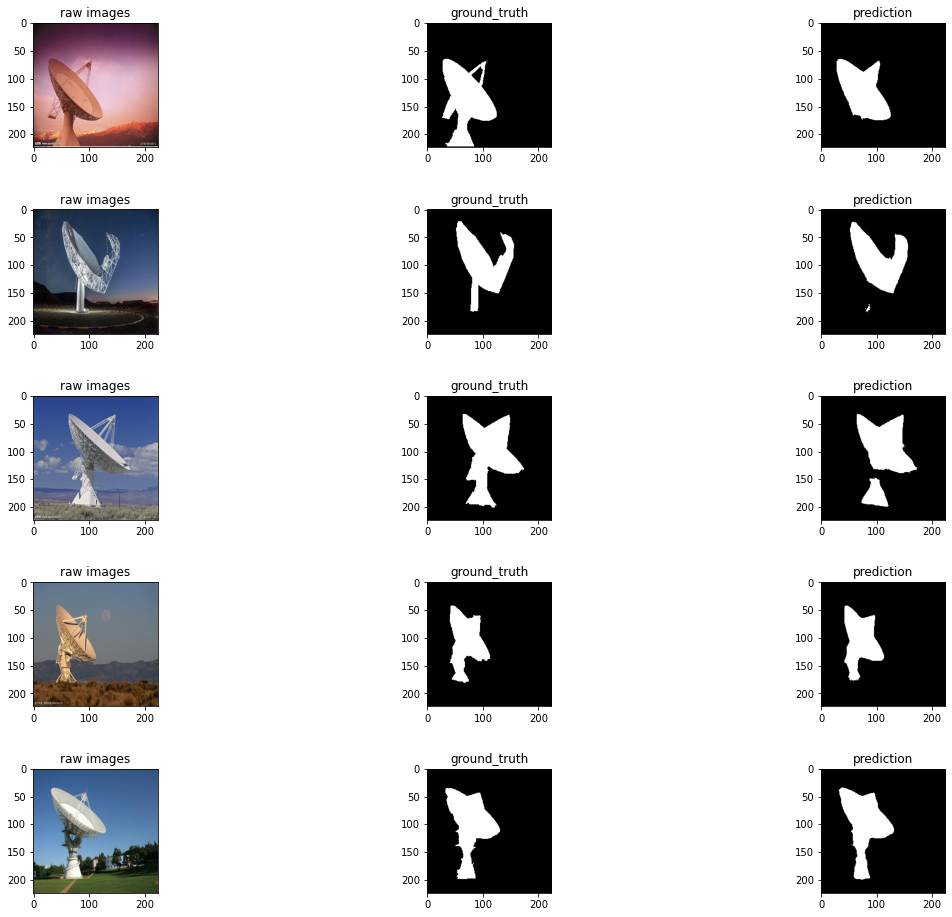

In [24]:
plot_batch_mask(input_embedding, val_prediction, input_mask)

In [25]:
experiment_number = config.experiment.number
experiment_description = config.experiment.description
experiment_root_path = os.path.join("leo_segmentation", "data", "models", f"experiment_{experiment_number}")
cached_files = os.listdir(experiment_root_path)
cached_files

['experiment_meta_test_6_ious.pkl',
 'experiment_meta_test_6_stats.pkl',
 'experiment_meta_train_6_ious.pkl',
 'experiment_meta_train_6_stats.pkl',
 'experiment_meta_val_6_ious.pkl',
 'experiment_meta_val_6_stats.pkl',
 'train_log.txt',
 'val_log.txt']

In [26]:
val_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[4])).T
filtered_scores = []
for _class, _df in val_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_val_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_val_ious", "class_sampling_frequency"])
filtered_val_ious = filtered_val_ious.sort_values(by="mean_val_ious", ascending=False)
filtered_val_ious

,classes,mean_val_ious,class_sampling_frequency
199,rally_car,0.905904,21
125,pinecone,0.901964,26
93,shih-tzu,0.898609,33
176,otter,0.893410,26
185,prayer_rug,0.891659,22
123,rubick_cube,0.890382,20
166,skull,0.883513,27
154,prairie_chicken,0.876412,27
133,pheasant,0.871997,30
170,pig,0.871469,38


In [27]:
filtered_val_ious.class_sampling_frequency.max()

39

In [28]:
train_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[2])).T
filtered_scores = []
for _class, _df in train_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_train_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_train_ious", "class_sampling_frequency"])
filtered_train_ious = filtered_train_ious.sort_values(by="mean_train_ious", ascending=False)

In [29]:
#classes in meta-train and meta-val are unique if their intersection is zero
set(filtered_train_ious.classes.unique()).intersection(set(filtered_val_ious.classes.unique()))

set()

In [30]:
meta_val_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[5]))
num_data_points = meta_val_loss.shape[0]

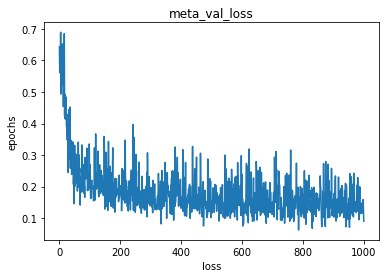

In [31]:
plt.title("meta_val_loss")
plt.ylabel("epochs")
plt.xlabel("loss")
plt.plot(np.arange(num_data_points), meta_val_loss.total_val_loss)

In [32]:
meta_train_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[3]))
num_data_points = meta_train_loss.shape[0]

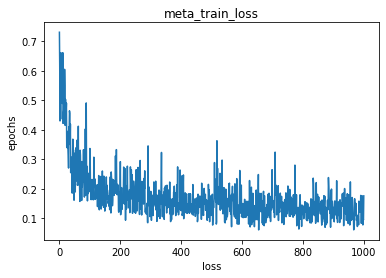

In [33]:
plt.title("meta_train_loss")
plt.ylabel("epochs")
plt.xlabel("loss")
plt.plot(np.arange(num_data_points), meta_train_loss.total_val_loss)